In [1]:
import numpy as np
from numpy import random
from scipy import interpolate
import matplotlib.pyplot as plt
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import tensorflow as tf



In [2]:
sess=tf.Session()

#initial weight
def weight_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.contrib.layers.xavier_initializer())
#intial bias
def bias_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.constant_initializer(0.1))
#placeholder
with tf.name_scope('Input'):
    X=tf.placeholder(tf.float32,[None,8192])
with tf.name_scope('Label'):
    Y_=tf.placeholder(tf.float32,[None,1])
lr=tf.placeholder(tf.float32)

#reshape layer
with tf.name_scope('Reshape_layer'):
    XX=tf.reshape(X,[-1,8192,1,1])
#convolution layer 1
w_conv1=weight_variable('w_conv1',[16,1,1,16])
b_conv1=bias_variable('b_conv1',[16])
with tf.name_scope('Convolution_layer1'):
    conv1=tf.nn.conv2d(XX,w_conv1,strides=[1,1,1,1],padding='VALID')
print(conv1.shape)

#activation layer 1
with tf.name_scope('Relu_layer1'):
    h_conv1=tf.nn.relu(conv1+b_conv1)

#pooling layer 1
with tf.name_scope('Pooling_layer1'):
    h_pool1=tf.nn.max_pool(h_conv1,[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool1.shape)

#convolution layer 2
w_conv2=weight_variable('w_conv2',[8,1,16,32])
b_conv2=bias_variable('b_conv2',[32])
with tf.name_scope('Convolution_layer2'):
    conv2=tf.nn.atrous_conv2d(h_pool1,w_conv2,rate=4,padding='VALID')
print(conv2.shape)

#activation layer 2
with tf.name_scope('Relu_layer2'):
    h_conv2=tf.nn.relu(conv2+b_conv2)

#pooling layer 2
with tf.name_scope('Pooling_layer2'):
    h_pool2=tf.nn.max_pool(h_conv2,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool2)

#convolution layer 3
w_conv3=weight_variable('w_conv3',[8,1,32,64])
b_conv3=bias_variable('b_conv3',[64])
with tf.name_scope('Convolution_layer3'):
    conv3=tf.nn.atrous_conv2d(h_pool2,w_conv3,rate=4,padding='VALID')
print(conv3)

#activation layer 3
with tf.name_scope('Relu_layer3'):
    h_conv3=tf.nn.relu(conv3+b_conv3)

#pooling layer 3
with tf.name_scope('Pooling_layer3'):
    h_pool3=tf.nn.max_pool(h_conv3,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool3.shape)

#flatten layer
with tf.name_scope('Flatten_layer'):
    h_flatten=tf.reshape(h_pool3,[-1,7680])
print(h_flatten.shape)

#linear layer 1
w_linear1=weight_variable('w_linear1',[7680,64])
b_linear1=bias_variable('b_linear1',[64])

#activation layer 4
with tf.name_scope('Relu_layer4'):
    h_linear1=tf.nn.relu(tf.matmul(h_flatten,w_linear1)+b_linear1)

#linear layer 2
w_linear2=weight_variable('w_linear2',[64,1])
b_linear2=bias_variable('b_linear2',[1])

#activation layer 5
with tf.name_scope('Output'):
    Y=tf.matmul(h_linear1,w_linear2)+b_linear2

#loss function
mse=tf.losses.mean_squared_error(Y_,Y)

#relative error
relative_error=tf.reduce_mean(tf.cast(tf.divide(tf.abs(tf.subtract(Y,Y_)),Y_),dtype=tf.float32))*100

#optimization
optimizer=tf.train.AdamOptimizer(learning_rate=lr)
train_step=optimizer.minimize(mse)

#visualization
tf.summary.scalar('relative_error',relative_error)
tf.summary.scalar('meansquared_error',tf.log(mse))
merged=tf.summary.merge_all()
train_writer=tf.summary.FileWriter('/home/txie/project/predictor/train/',sess.graph)
test_writer=tf.summary.FileWriter('/home/txie/project/predictor/test/')

#run
sess.run(tf.global_variables_initializer())

(?, 8177, 1, 16)
(?, 2045, 1, 16)
(?, ?, ?, 32)
Tensor("Pooling_layer2/MaxPool:0", shape=(?, ?, ?, 32), dtype=float32)
Tensor("Convolution_layer3/atrous_conv2d/BatchToSpaceND:0", shape=(?, ?, ?, 64), dtype=float32)
(?, ?, ?, 64)
(?, 7680)


In [3]:
#get data
f=h5py.File('EOB-M1.h5','r')
time=f['hPlus'][:,:,0]
signal=f['hPlus'][:,:,1]
ratio=f['MassRatio']
newsig=np.zeros([901,8192])
for i in range(901):
    fx=interpolate.interp1d(time[i],signal[i],kind='cubic')
    xnew=np.linspace(time[i][0],time[i][72228],8192)
    newsig[i]=fx(xnew)
    '''
    if i%100==0:
        print(i,ratio[i])
        plt.figure()
        plt.plot(newsig[i])
        plt.show()  
    '''
p=list(zip(ratio,newsig))
random.shuffle(p)
ratio,newsig=zip(*p)
newsig=np.array(newsig)


In [4]:
#get test set
snr=0.6
test_sig=np.zeros([100,8192])
test_label=np.zeros([100,1])
for i in range(100):
    r=random.randint(0,1638)
    test_label[i]=ratio[i+801]
    test_sig[i,0:8191-r:1]=newsig[i+801,r:8191:1]*snr
    temp=copy.copy(test_sig[i])
    test_sig[i]=test_sig[i]+np.random.normal(0,1,8192)
    test_sig[i]=test_sig[i]/np.std(test_sig[i])
    '''
    print(i,test_label[i])
    plt.figure()
    plt.plot(test_sig[i],'b')
    plt.plot(temp,'r')
    plt.show()
    '''

In [5]:
#get train set
epoch=100000
learning_rate=0.001
error_train=[]
error_test=[]
mse_train=[]
mse_test=[]
train_sig=np.zeros([50,8192])
train_label=np.zeros([50,1])
#training
for i in range(epoch):
    snr=0.6
    for j in range(50):
        r=random.randint(0,1638)
        train_label[j]=ratio[(i*50+j)%801]
        train_sig[j,0:8191-r:1]=newsig[(i*50+j)%801,r:8191:1]*snr
        temp=copy.copy(train_sig[j])
        train_sig[j]=train_sig[j]+np.random.normal(0,1,8192)
        train_sig[j]=train_sig[j]/np.std(train_sig[j])
        '''
        if j==25:
            print((i*50+j)%901,train_label[j])
            plt.figure()
            plt.plot(train_sig[j],'b')
            plt.plot(temp,'r')
            plt.show()
        '''
    if (i+1)%50==0:
        summary,a,c=sess.run([merged,relative_error,mse],feed_dict={X:test_sig,Y_:test_label})
        error_test.append(a)
        mse_test.append(c)
        print('test:'+' relative_error:'+str(a)+' mse:'+str(c))
        test_writer.add_summary(summary,i)
    a,c=sess.run([relative_error,mse],feed_dict={X:train_sig,Y_:train_label})
    error_train.append(a)
    mse_train.append(c)
    print('epoch:'+str(i)+' relative_error:'+str(a)+' mse:'+str(c))
    summary,_=sess.run([merged,train_step],feed_dict={X:train_sig,Y_:train_label,lr:learning_rate})
    train_writer.add_summary(summary,i)
    train_sig=np.zeros([50,8192])
    train_label=np.zeros([50,1])
    
        

epoch:0 relative_error:85.3902 mse:33.8905
epoch:1 relative_error:252.73 mse:58.8788
epoch:2 relative_error:72.5172 mse:8.32887
epoch:3 relative_error:65.2876 mse:11.1573
epoch:4 relative_error:57.3888 mse:18.2571
epoch:5 relative_error:52.0458 mse:14.583
epoch:6 relative_error:54.7208 mse:13.2377
epoch:7 relative_error:51.6642 mse:10.2661
epoch:8 relative_error:69.5612 mse:8.91579
epoch:9 relative_error:63.1797 mse:6.49311
epoch:10 relative_error:68.0203 mse:7.06509
epoch:11 relative_error:92.8745 mse:9.37092
epoch:12 relative_error:90.3333 mse:8.21451
epoch:13 relative_error:71.0959 mse:6.47022
epoch:14 relative_error:65.5501 mse:5.71149
epoch:15 relative_error:63.8052 mse:7.92917
epoch:16 relative_error:52.9967 mse:7.01615
epoch:17 relative_error:69.9756 mse:7.56911
epoch:18 relative_error:49.8206 mse:5.67236
epoch:19 relative_error:73.8433 mse:9.03377
epoch:20 relative_error:56.0664 mse:7.68887
epoch:21 relative_error:78.8377 mse:7.00164
epoch:22 relative_error:82.8228 mse:7.31345


epoch:183 relative_error:73.1359 mse:6.81274
epoch:184 relative_error:75.0594 mse:6.8046
epoch:185 relative_error:58.1115 mse:7.17129
epoch:186 relative_error:62.1446 mse:6.69189
epoch:187 relative_error:56.1094 mse:5.16152
epoch:188 relative_error:74.163 mse:5.66568
epoch:189 relative_error:60.2513 mse:6.27629
epoch:190 relative_error:54.4695 mse:5.2568
epoch:191 relative_error:68.265 mse:7.40158
epoch:192 relative_error:45.6661 mse:5.95291
epoch:193 relative_error:86.2948 mse:7.72102
epoch:194 relative_error:68.1575 mse:6.16505
epoch:195 relative_error:72.778 mse:7.09266
epoch:196 relative_error:69.7357 mse:7.10807
epoch:197 relative_error:74.1373 mse:7.52027
epoch:198 relative_error:78.711 mse:6.78101
test: relative_error:71.4661 mse:8.00872
epoch:199 relative_error:72.4208 mse:6.73735
epoch:200 relative_error:72.9496 mse:6.62839
epoch:201 relative_error:58.9147 mse:6.96103
epoch:202 relative_error:62.3545 mse:6.8388
epoch:203 relative_error:52.3964 mse:5.04279
epoch:204 relative_er

epoch:366 relative_error:32.2423 mse:2.93754
epoch:367 relative_error:43.7081 mse:2.66523
epoch:368 relative_error:28.7953 mse:2.31313
epoch:369 relative_error:45.408 mse:2.5064
epoch:370 relative_error:49.2365 mse:2.9959
epoch:371 relative_error:32.0688 mse:1.96259
epoch:372 relative_error:38.2974 mse:3.05751
epoch:373 relative_error:33.5836 mse:3.33634
epoch:374 relative_error:33.5647 mse:2.67971
epoch:375 relative_error:44.0972 mse:3.05409
epoch:376 relative_error:36.0773 mse:3.56661
epoch:377 relative_error:50.6024 mse:3.61839
epoch:378 relative_error:40.9366 mse:3.22703
epoch:379 relative_error:36.8344 mse:2.34822
epoch:380 relative_error:39.5458 mse:2.99749
epoch:381 relative_error:38.0276 mse:2.32934
epoch:382 relative_error:33.5026 mse:2.82624
epoch:383 relative_error:33.341 mse:4.57651
epoch:384 relative_error:25.9207 mse:2.28417
epoch:385 relative_error:35.7107 mse:2.39583
epoch:386 relative_error:51.5755 mse:3.76648
epoch:387 relative_error:41.1357 mse:3.35848
epoch:388 rela

epoch:546 relative_error:38.5148 mse:1.98017
epoch:547 relative_error:26.861 mse:2.19923
epoch:548 relative_error:37.9177 mse:2.34542
test: relative_error:32.7672 mse:2.55728
epoch:549 relative_error:26.1731 mse:1.9527
epoch:550 relative_error:37.179 mse:1.93588
epoch:551 relative_error:39.3847 mse:2.58046
epoch:552 relative_error:35.6308 mse:2.6466
epoch:553 relative_error:30.8935 mse:1.71004
epoch:554 relative_error:34.8574 mse:2.22354
epoch:555 relative_error:23.6502 mse:1.47151
epoch:556 relative_error:34.4961 mse:2.01564
epoch:557 relative_error:35.2976 mse:2.47031
epoch:558 relative_error:22.9994 mse:2.01247
epoch:559 relative_error:29.8659 mse:1.36771
epoch:560 relative_error:39.0382 mse:2.9566
epoch:561 relative_error:41.2032 mse:2.27903
epoch:562 relative_error:35.2629 mse:1.77845
epoch:563 relative_error:23.6567 mse:2.03614
epoch:564 relative_error:32.6919 mse:1.92507
epoch:565 relative_error:28.1441 mse:2.44933
epoch:566 relative_error:42.4851 mse:2.48332
epoch:567 relative_

epoch:726 relative_error:32.157 mse:1.80125
epoch:727 relative_error:26.6636 mse:1.88704
epoch:728 relative_error:35.9331 mse:2.12529
epoch:729 relative_error:43.1191 mse:1.93584
epoch:730 relative_error:33.4179 mse:2.58095
epoch:731 relative_error:27.588 mse:1.83042
epoch:732 relative_error:20.0742 mse:1.45191
epoch:733 relative_error:30.3842 mse:2.02215
epoch:734 relative_error:24.2835 mse:2.18611
epoch:735 relative_error:23.8924 mse:1.32837
epoch:736 relative_error:27.8155 mse:2.47662
epoch:737 relative_error:37.2571 mse:2.39963
epoch:738 relative_error:44.4405 mse:3.23721
epoch:739 relative_error:29.502 mse:2.35515
epoch:740 relative_error:32.8425 mse:1.923
epoch:741 relative_error:31.1734 mse:2.86609
epoch:742 relative_error:35.7341 mse:2.36195
epoch:743 relative_error:25.7486 mse:2.0884
epoch:744 relative_error:28.9481 mse:2.32072
epoch:745 relative_error:39.1051 mse:1.84028
epoch:746 relative_error:30.6484 mse:1.62776
epoch:747 relative_error:33.432 mse:2.36417
epoch:748 relativ

epoch:906 relative_error:25.1667 mse:1.53011
epoch:907 relative_error:25.3466 mse:1.73053
epoch:908 relative_error:23.7911 mse:1.3908
epoch:909 relative_error:26.7539 mse:1.18592
epoch:910 relative_error:28.8279 mse:2.0666
epoch:911 relative_error:25.9524 mse:1.49896
epoch:912 relative_error:34.9547 mse:2.25964
epoch:913 relative_error:27.5877 mse:2.28424
epoch:914 relative_error:26.8667 mse:1.45229
epoch:915 relative_error:20.5949 mse:1.37395
epoch:916 relative_error:39.2098 mse:1.99968
epoch:917 relative_error:29.0808 mse:2.2598
epoch:918 relative_error:34.1212 mse:1.74602
epoch:919 relative_error:36.1922 mse:1.99479
epoch:920 relative_error:24.7961 mse:1.37068
epoch:921 relative_error:39.7944 mse:2.69033
epoch:922 relative_error:23.3455 mse:1.30646
epoch:923 relative_error:25.7389 mse:1.60366
epoch:924 relative_error:29.5053 mse:1.56344
epoch:925 relative_error:36.7448 mse:1.78563
epoch:926 relative_error:34.5856 mse:2.16811
epoch:927 relative_error:24.0251 mse:1.47534
epoch:928 rel

epoch:1086 relative_error:32.8924 mse:2.58915
epoch:1087 relative_error:19.8784 mse:1.71868
epoch:1088 relative_error:34.2996 mse:1.86779
epoch:1089 relative_error:21.4687 mse:1.72321
epoch:1090 relative_error:33.5435 mse:1.52563
epoch:1091 relative_error:32.5506 mse:1.82336
epoch:1092 relative_error:23.0295 mse:1.51706
epoch:1093 relative_error:24.774 mse:1.75439
epoch:1094 relative_error:25.8048 mse:2.02741
epoch:1095 relative_error:35.0483 mse:1.65191
epoch:1096 relative_error:27.2763 mse:1.6656
epoch:1097 relative_error:30.7924 mse:1.44682
epoch:1098 relative_error:33.9009 mse:1.75383
test: relative_error:30.6336 mse:2.14299
epoch:1099 relative_error:25.2943 mse:1.34263
epoch:1100 relative_error:22.8405 mse:1.31036
epoch:1101 relative_error:27.8423 mse:1.47819
epoch:1102 relative_error:32.0637 mse:1.92385
epoch:1103 relative_error:25.2301 mse:2.16084
epoch:1104 relative_error:28.5799 mse:2.01892
epoch:1105 relative_error:25.5377 mse:2.28223
epoch:1106 relative_error:30.3389 mse:1.8

epoch:1264 relative_error:32.987 mse:2.13061
epoch:1265 relative_error:19.811 mse:1.55
epoch:1266 relative_error:27.7346 mse:1.81568
epoch:1267 relative_error:30.6483 mse:1.58812
epoch:1268 relative_error:20.8932 mse:1.27101
epoch:1269 relative_error:25.4145 mse:1.37146
epoch:1270 relative_error:29.288 mse:2.18223
epoch:1271 relative_error:46.1308 mse:2.36344
epoch:1272 relative_error:26.3076 mse:1.17279
epoch:1273 relative_error:33.254 mse:2.04253
epoch:1274 relative_error:24.3677 mse:1.7107
epoch:1275 relative_error:20.2309 mse:1.80013
epoch:1276 relative_error:20.0793 mse:1.56058
epoch:1277 relative_error:27.908 mse:1.10699
epoch:1278 relative_error:34.717 mse:2.04243
epoch:1279 relative_error:20.6354 mse:1.26258
epoch:1280 relative_error:27.4236 mse:1.38556
epoch:1281 relative_error:22.8486 mse:1.55405
epoch:1282 relative_error:29.7614 mse:1.58854
epoch:1283 relative_error:31.8828 mse:1.58822
epoch:1284 relative_error:22.6488 mse:1.96335
epoch:1285 relative_error:27.1879 mse:2.6292

epoch:1443 relative_error:40.9783 mse:1.78709
epoch:1444 relative_error:24.261 mse:2.08368
epoch:1445 relative_error:30.2929 mse:1.2988
epoch:1446 relative_error:25.0466 mse:1.84624
epoch:1447 relative_error:26.4749 mse:1.79725
epoch:1448 relative_error:29.7913 mse:2.42399
test: relative_error:26.0533 mse:1.83184
epoch:1449 relative_error:23.7189 mse:1.6823
epoch:1450 relative_error:41.8951 mse:2.31147
epoch:1451 relative_error:29.1858 mse:1.92722
epoch:1452 relative_error:22.5063 mse:1.24274
epoch:1453 relative_error:27.5385 mse:1.62536
epoch:1454 relative_error:31.0831 mse:1.53775
epoch:1455 relative_error:24.0133 mse:2.20447
epoch:1456 relative_error:25.3658 mse:2.40074
epoch:1457 relative_error:22.7265 mse:2.31121
epoch:1458 relative_error:27.198 mse:1.78666
epoch:1459 relative_error:32.0731 mse:1.4999
epoch:1460 relative_error:25.2637 mse:2.03035
epoch:1461 relative_error:35.6588 mse:2.2016
epoch:1462 relative_error:20.2265 mse:1.3651
epoch:1463 relative_error:26.1724 mse:1.59429


epoch:1619 relative_error:34.0915 mse:2.53658
epoch:1620 relative_error:18.7584 mse:0.986721
epoch:1621 relative_error:30.7176 mse:1.74082
epoch:1622 relative_error:23.6516 mse:1.44043
epoch:1623 relative_error:30.6976 mse:1.64395
epoch:1624 relative_error:36.6104 mse:1.57771
epoch:1625 relative_error:25.7947 mse:1.30648
epoch:1626 relative_error:26.9835 mse:1.57067
epoch:1627 relative_error:22.2517 mse:0.992642
epoch:1628 relative_error:19.7767 mse:1.61151
epoch:1629 relative_error:21.5028 mse:1.22454
epoch:1630 relative_error:30.3879 mse:1.20792
epoch:1631 relative_error:23.9491 mse:1.40787
epoch:1632 relative_error:24.5456 mse:1.41281
epoch:1633 relative_error:26.555 mse:1.85258
epoch:1634 relative_error:24.5297 mse:1.46226
epoch:1635 relative_error:37.9782 mse:1.8678
epoch:1636 relative_error:20.6757 mse:1.28232
epoch:1637 relative_error:29.8341 mse:1.78638
epoch:1638 relative_error:20.5654 mse:2.33304
epoch:1639 relative_error:27.2169 mse:1.02435
epoch:1640 relative_error:25.6318 

epoch:1798 relative_error:23.6114 mse:1.33855
test: relative_error:27.4538 mse:1.75315
epoch:1799 relative_error:23.4789 mse:1.1173
epoch:1800 relative_error:27.4372 mse:1.57724
epoch:1801 relative_error:24.2762 mse:1.41424
epoch:1802 relative_error:29.1939 mse:1.41504
epoch:1803 relative_error:30.1816 mse:1.75921
epoch:1804 relative_error:18.8776 mse:1.2071
epoch:1805 relative_error:17.9483 mse:1.11552
epoch:1806 relative_error:32.2654 mse:1.27085
epoch:1807 relative_error:28.0302 mse:1.48311
epoch:1808 relative_error:15.8158 mse:0.893079
epoch:1809 relative_error:25.2218 mse:1.98562
epoch:1810 relative_error:18.6336 mse:1.79309
epoch:1811 relative_error:27.4915 mse:1.65972
epoch:1812 relative_error:25.0833 mse:1.37642
epoch:1813 relative_error:23.7727 mse:1.3021
epoch:1814 relative_error:24.4642 mse:1.5665
epoch:1815 relative_error:34.0403 mse:1.726
epoch:1816 relative_error:27.6869 mse:1.21405
epoch:1817 relative_error:24.0201 mse:1.29867
epoch:1818 relative_error:28.3923 mse:1.7422

epoch:1974 relative_error:22.9101 mse:1.58807
epoch:1975 relative_error:33.3593 mse:1.5464
epoch:1976 relative_error:33.3433 mse:1.63301
epoch:1977 relative_error:44.7036 mse:2.2338
epoch:1978 relative_error:24.6302 mse:2.00412
epoch:1979 relative_error:25.7573 mse:2.38882
epoch:1980 relative_error:20.1817 mse:1.80789
epoch:1981 relative_error:23.4273 mse:1.47131
epoch:1982 relative_error:31.6068 mse:1.31444
epoch:1983 relative_error:35.0928 mse:1.80849
epoch:1984 relative_error:19.6219 mse:1.32024
epoch:1985 relative_error:21.8655 mse:1.36649
epoch:1986 relative_error:23.602 mse:1.62234
epoch:1987 relative_error:25.5699 mse:0.980506
epoch:1988 relative_error:26.2381 mse:1.33233
epoch:1989 relative_error:19.1194 mse:1.30886
epoch:1990 relative_error:31.8937 mse:1.83583
epoch:1991 relative_error:26.812 mse:1.76366
epoch:1992 relative_error:23.9072 mse:1.18586
epoch:1993 relative_error:26.519 mse:1.5026
epoch:1994 relative_error:20.0928 mse:0.898848
epoch:1995 relative_error:24.4921 mse:

epoch:2150 relative_error:33.986 mse:2.38176
epoch:2151 relative_error:19.8352 mse:1.1169
epoch:2152 relative_error:34.0415 mse:1.32927
epoch:2153 relative_error:22.2139 mse:0.965399
epoch:2154 relative_error:20.9187 mse:1.76791
epoch:2155 relative_error:19.3032 mse:0.937795
epoch:2156 relative_error:31.0233 mse:1.9465
epoch:2157 relative_error:21.0721 mse:1.69754
epoch:2158 relative_error:29.6078 mse:1.50809
epoch:2159 relative_error:31.3617 mse:1.7573
epoch:2160 relative_error:20.6151 mse:1.70026
epoch:2161 relative_error:17.106 mse:0.84693
epoch:2162 relative_error:19.9949 mse:1.68212
epoch:2163 relative_error:24.1795 mse:1.45544
epoch:2164 relative_error:27.1478 mse:1.26099
epoch:2165 relative_error:24.4174 mse:1.98088
epoch:2166 relative_error:24.632 mse:1.0631
epoch:2167 relative_error:20.9958 mse:1.13761
epoch:2168 relative_error:31.1409 mse:1.26623
epoch:2169 relative_error:30.8277 mse:1.6476
epoch:2170 relative_error:22.1554 mse:1.587
epoch:2171 relative_error:26.3406 mse:1.64

epoch:2327 relative_error:21.9722 mse:1.25242
epoch:2328 relative_error:29.0095 mse:1.35613
epoch:2329 relative_error:23.1687 mse:1.73524
epoch:2330 relative_error:16.209 mse:1.27426
epoch:2331 relative_error:24.3624 mse:1.27319
epoch:2332 relative_error:21.1527 mse:1.32651
epoch:2333 relative_error:23.2934 mse:1.37048
epoch:2334 relative_error:24.3148 mse:1.39882
epoch:2335 relative_error:30.6711 mse:1.55024
epoch:2336 relative_error:21.7187 mse:1.20538
epoch:2337 relative_error:24.6385 mse:1.28907
epoch:2338 relative_error:23.2816 mse:1.60048
epoch:2339 relative_error:20.1265 mse:0.927589
epoch:2340 relative_error:24.8845 mse:1.57052
epoch:2341 relative_error:12.93 mse:0.558433
epoch:2342 relative_error:19.8311 mse:0.881391
epoch:2343 relative_error:21.4202 mse:1.24789
epoch:2344 relative_error:29.1324 mse:1.61629
epoch:2345 relative_error:23.644 mse:1.47159
epoch:2346 relative_error:20.0997 mse:0.967918
epoch:2347 relative_error:24.3954 mse:1.1909
epoch:2348 relative_error:27.1008 m

epoch:2505 relative_error:26.4691 mse:2.03277
epoch:2506 relative_error:17.593 mse:0.763714
epoch:2507 relative_error:26.1045 mse:1.427
epoch:2508 relative_error:32.015 mse:1.71896
epoch:2509 relative_error:25.2677 mse:1.64538
epoch:2510 relative_error:24.4871 mse:1.24023
epoch:2511 relative_error:27.8782 mse:0.939092
epoch:2512 relative_error:25.0708 mse:1.72862
epoch:2513 relative_error:18.4891 mse:1.62175
epoch:2514 relative_error:27.8411 mse:1.68594
epoch:2515 relative_error:15.4279 mse:1.08048
epoch:2516 relative_error:31.6391 mse:2.00939
epoch:2517 relative_error:20.3099 mse:1.11833
epoch:2518 relative_error:26.98 mse:1.11291
epoch:2519 relative_error:20.0857 mse:1.45163
epoch:2520 relative_error:28.6068 mse:1.61811
epoch:2521 relative_error:23.6559 mse:1.08734
epoch:2522 relative_error:21.2003 mse:1.1221
epoch:2523 relative_error:26.1632 mse:1.57118
epoch:2524 relative_error:20.3732 mse:1.40911
epoch:2525 relative_error:23.5685 mse:1.86709
epoch:2526 relative_error:22.0747 mse:1

epoch:2681 relative_error:23.4801 mse:0.887461
epoch:2682 relative_error:30.8512 mse:1.53221
epoch:2683 relative_error:32.2939 mse:1.67982
epoch:2684 relative_error:21.3622 mse:1.22381
epoch:2685 relative_error:24.9205 mse:1.47338
epoch:2686 relative_error:18.0877 mse:0.985862
epoch:2687 relative_error:22.7345 mse:1.32251
epoch:2688 relative_error:19.4173 mse:1.70907
epoch:2689 relative_error:20.6156 mse:1.7305
epoch:2690 relative_error:27.8555 mse:1.38332
epoch:2691 relative_error:20.059 mse:1.48287
epoch:2692 relative_error:25.5937 mse:1.1918
epoch:2693 relative_error:21.5731 mse:1.28327
epoch:2694 relative_error:20.4852 mse:1.16364
epoch:2695 relative_error:24.4821 mse:1.33999
epoch:2696 relative_error:22.7597 mse:1.49034
epoch:2697 relative_error:27.0647 mse:1.5228
epoch:2698 relative_error:23.6705 mse:1.55003
test: relative_error:24.9552 mse:1.36436
epoch:2699 relative_error:27.1567 mse:1.57641
epoch:2700 relative_error:31.3213 mse:1.96303
epoch:2701 relative_error:21.9585 mse:1.3

epoch:2857 relative_error:28.9935 mse:1.21868
epoch:2858 relative_error:24.4584 mse:0.972469
epoch:2859 relative_error:19.069 mse:1.04875
epoch:2860 relative_error:28.9179 mse:1.54562
epoch:2861 relative_error:22.5537 mse:1.51883
epoch:2862 relative_error:23.8716 mse:1.64346
epoch:2863 relative_error:21.9752 mse:0.845661
epoch:2864 relative_error:28.2898 mse:1.67576
epoch:2865 relative_error:16.8765 mse:1.38106
epoch:2866 relative_error:27.6412 mse:1.44934
epoch:2867 relative_error:17.7546 mse:2.00734
epoch:2868 relative_error:21.6159 mse:1.30001
epoch:2869 relative_error:29.5694 mse:1.42013
epoch:2870 relative_error:21.1362 mse:1.18168
epoch:2871 relative_error:23.3312 mse:1.22559
epoch:2872 relative_error:18.9211 mse:1.22874
epoch:2873 relative_error:28.4388 mse:1.2083
epoch:2874 relative_error:24.2944 mse:1.00192
epoch:2875 relative_error:28.8572 mse:1.26679
epoch:2876 relative_error:19.5563 mse:1.27224
epoch:2877 relative_error:21.0629 mse:1.28096
epoch:2878 relative_error:18.5397 

epoch:3035 relative_error:23.7244 mse:1.62793
epoch:3036 relative_error:27.9051 mse:2.13567
epoch:3037 relative_error:16.9624 mse:1.01724
epoch:3038 relative_error:23.2868 mse:1.17955
epoch:3039 relative_error:21.0321 mse:1.01286
epoch:3040 relative_error:30.0828 mse:1.27335
epoch:3041 relative_error:18.8614 mse:1.24943
epoch:3042 relative_error:20.1305 mse:1.44591
epoch:3043 relative_error:22.3036 mse:1.7669
epoch:3044 relative_error:22.5365 mse:1.16444
epoch:3045 relative_error:25.0596 mse:0.909193
epoch:3046 relative_error:16.1449 mse:1.29742
epoch:3047 relative_error:27.2999 mse:1.25249
epoch:3048 relative_error:24.1818 mse:1.31969
test: relative_error:26.6068 mse:1.51618
epoch:3049 relative_error:27.3265 mse:1.04068
epoch:3050 relative_error:25.305 mse:1.04639
epoch:3051 relative_error:19.2955 mse:1.2318
epoch:3052 relative_error:27.6623 mse:1.3941
epoch:3053 relative_error:19.5256 mse:1.02183
epoch:3054 relative_error:21.0478 mse:1.32101
epoch:3055 relative_error:23.2454 mse:1.27

epoch:3213 relative_error:17.1722 mse:0.872044
epoch:3214 relative_error:15.5689 mse:0.745301
epoch:3215 relative_error:27.974 mse:1.23009
epoch:3216 relative_error:20.3475 mse:1.28743
epoch:3217 relative_error:22.8691 mse:1.34982
epoch:3218 relative_error:20.4918 mse:1.29398
epoch:3219 relative_error:21.0337 mse:1.43717
epoch:3220 relative_error:26.0726 mse:1.67825
epoch:3221 relative_error:34.5757 mse:1.8268
epoch:3222 relative_error:17.0645 mse:0.779792
epoch:3223 relative_error:21.7989 mse:1.20204
epoch:3224 relative_error:20.627 mse:1.53399
epoch:3225 relative_error:19.4952 mse:0.940202
epoch:3226 relative_error:25.3938 mse:1.0294
epoch:3227 relative_error:24.4539 mse:1.19086
epoch:3228 relative_error:34.5844 mse:1.48961
epoch:3229 relative_error:22.7898 mse:1.20436
epoch:3230 relative_error:14.7527 mse:0.721825
epoch:3231 relative_error:24.4571 mse:1.19079
epoch:3232 relative_error:26.8272 mse:1.32386
epoch:3233 relative_error:20.3061 mse:1.39855
epoch:3234 relative_error:18.0959

epoch:3390 relative_error:21.5091 mse:1.05286
epoch:3391 relative_error:22.0811 mse:1.07278
epoch:3392 relative_error:21.5581 mse:0.877805
epoch:3393 relative_error:17.6174 mse:0.907055
epoch:3394 relative_error:17.8903 mse:1.60567
epoch:3395 relative_error:22.8743 mse:1.60294
epoch:3396 relative_error:21.3016 mse:1.15672
epoch:3397 relative_error:30.6348 mse:1.10343
epoch:3398 relative_error:24.6217 mse:1.14653
test: relative_error:22.6017 mse:1.26553
epoch:3399 relative_error:25.7313 mse:1.61556
epoch:3400 relative_error:18.9915 mse:0.737671
epoch:3401 relative_error:19.2646 mse:1.60599
epoch:3402 relative_error:26.8377 mse:1.17016
epoch:3403 relative_error:25.6948 mse:1.29811
epoch:3404 relative_error:27.87 mse:1.29307
epoch:3405 relative_error:23.2052 mse:1.21563
epoch:3406 relative_error:19.6076 mse:1.22904
epoch:3407 relative_error:20.3463 mse:1.02029
epoch:3408 relative_error:22.7323 mse:1.06537
epoch:3409 relative_error:20.0294 mse:1.35465
epoch:3410 relative_error:23.2666 mse:

epoch:3565 relative_error:22.3076 mse:1.26749
epoch:3566 relative_error:27.3347 mse:1.51428
epoch:3567 relative_error:22.6154 mse:0.931216
epoch:3568 relative_error:20.9072 mse:0.975449
epoch:3569 relative_error:21.249 mse:0.82873
epoch:3570 relative_error:17.7156 mse:0.982517
epoch:3571 relative_error:17.8995 mse:1.15692
epoch:3572 relative_error:17.2333 mse:1.67258
epoch:3573 relative_error:20.6622 mse:0.949995
epoch:3574 relative_error:24.0454 mse:1.16456
epoch:3575 relative_error:22.2015 mse:1.11874
epoch:3576 relative_error:25.9261 mse:1.29355
epoch:3577 relative_error:26.3074 mse:1.33572
epoch:3578 relative_error:22.7313 mse:0.981869
epoch:3579 relative_error:25.897 mse:1.01854
epoch:3580 relative_error:25.24 mse:2.36871
epoch:3581 relative_error:21.1337 mse:1.35498
epoch:3582 relative_error:14.4741 mse:0.793744
epoch:3583 relative_error:17.8374 mse:0.729564
epoch:3584 relative_error:31.5601 mse:1.75578
epoch:3585 relative_error:34.461 mse:1.79894
epoch:3586 relative_error:20.055

epoch:3742 relative_error:19.2697 mse:1.29311
epoch:3743 relative_error:21.2519 mse:1.25208
epoch:3744 relative_error:19.7554 mse:0.838149
epoch:3745 relative_error:25.0366 mse:0.967016
epoch:3746 relative_error:19.6081 mse:1.34439
epoch:3747 relative_error:21.3459 mse:0.901861
epoch:3748 relative_error:17.2696 mse:1.38272
test: relative_error:23.7808 mse:1.30009
epoch:3749 relative_error:20.3425 mse:0.874456
epoch:3750 relative_error:24.5141 mse:1.17049
epoch:3751 relative_error:17.0895 mse:0.96027
epoch:3752 relative_error:29.9372 mse:1.34676
epoch:3753 relative_error:22.4111 mse:1.08952
epoch:3754 relative_error:27.491 mse:1.26667
epoch:3755 relative_error:28.0992 mse:1.50116
epoch:3756 relative_error:19.0922 mse:1.61045
epoch:3757 relative_error:20.821 mse:1.05892
epoch:3758 relative_error:22.3868 mse:1.03074
epoch:3759 relative_error:17.1011 mse:0.889625
epoch:3760 relative_error:20.571 mse:1.01869
epoch:3761 relative_error:32.1281 mse:1.66157
epoch:3762 relative_error:17.1101 mse

epoch:3920 relative_error:22.0837 mse:0.839944
epoch:3921 relative_error:18.6605 mse:0.848524
epoch:3922 relative_error:23.5874 mse:1.32923
epoch:3923 relative_error:19.9905 mse:0.884506
epoch:3924 relative_error:21.6443 mse:1.43457
epoch:3925 relative_error:27.5736 mse:1.35036
epoch:3926 relative_error:35.5243 mse:1.70483
epoch:3927 relative_error:12.8564 mse:0.624249
epoch:3928 relative_error:28.5932 mse:1.34921
epoch:3929 relative_error:17.4078 mse:1.49415
epoch:3930 relative_error:28.4058 mse:1.26249
epoch:3931 relative_error:20.805 mse:1.35336
epoch:3932 relative_error:20.1967 mse:0.784912
epoch:3933 relative_error:26.8662 mse:1.10953
epoch:3934 relative_error:17.7258 mse:1.17113
epoch:3935 relative_error:20.7303 mse:1.39206
epoch:3936 relative_error:15.2854 mse:0.561807
epoch:3937 relative_error:25.5856 mse:1.22154
epoch:3938 relative_error:22.8342 mse:1.34007
epoch:3939 relative_error:15.9911 mse:0.929288
epoch:3940 relative_error:19.6716 mse:1.43743
epoch:3941 relative_error:28

epoch:4098 relative_error:18.8979 mse:1.22334
test: relative_error:21.0279 mse:1.22906
epoch:4099 relative_error:18.186 mse:1.02363
epoch:4100 relative_error:18.1617 mse:0.971955
epoch:4101 relative_error:22.7711 mse:1.38655
epoch:4102 relative_error:28.529 mse:1.35507
epoch:4103 relative_error:17.7476 mse:0.875367
epoch:4104 relative_error:20.0767 mse:1.01164
epoch:4105 relative_error:23.336 mse:1.19367
epoch:4106 relative_error:26.3635 mse:1.3388
epoch:4107 relative_error:23.8303 mse:1.24124
epoch:4108 relative_error:18.2481 mse:0.98225
epoch:4109 relative_error:37.8255 mse:1.60913
epoch:4110 relative_error:23.6302 mse:1.22255
epoch:4111 relative_error:20.403 mse:1.48636
epoch:4112 relative_error:17.5382 mse:0.643361
epoch:4113 relative_error:21.1656 mse:0.748279
epoch:4114 relative_error:21.6386 mse:1.17548
epoch:4115 relative_error:18.1583 mse:0.984639
epoch:4116 relative_error:27.12 mse:1.46932
epoch:4117 relative_error:21.1734 mse:1.14937
epoch:4118 relative_error:25.8021 mse:1.1

epoch:4273 relative_error:23.3343 mse:0.873046
epoch:4274 relative_error:20.7543 mse:0.923586
epoch:4275 relative_error:20.6035 mse:1.33761
epoch:4276 relative_error:19.3202 mse:0.925186
epoch:4277 relative_error:18.2181 mse:1.43376
epoch:4278 relative_error:22.5209 mse:0.831778
epoch:4279 relative_error:25.9834 mse:1.01411
epoch:4280 relative_error:20.11 mse:1.17466
epoch:4281 relative_error:22.5108 mse:1.1945
epoch:4282 relative_error:27.893 mse:1.4582
epoch:4283 relative_error:17.4417 mse:0.726907
epoch:4284 relative_error:20.2223 mse:1.13338
epoch:4285 relative_error:25.2941 mse:1.809
epoch:4286 relative_error:19.8664 mse:1.47573
epoch:4287 relative_error:13.5674 mse:0.611217
epoch:4288 relative_error:24.8984 mse:1.21305
epoch:4289 relative_error:31.1884 mse:1.43934
epoch:4290 relative_error:28.7017 mse:1.18007
epoch:4291 relative_error:14.9029 mse:0.945231
epoch:4292 relative_error:22.6074 mse:1.33939
epoch:4293 relative_error:17.1399 mse:1.25986
epoch:4294 relative_error:22.4786 

epoch:4451 relative_error:20.6869 mse:1.11989
epoch:4452 relative_error:23.1643 mse:1.26574
epoch:4453 relative_error:20.6026 mse:1.02913
epoch:4454 relative_error:28.1895 mse:1.38808
epoch:4455 relative_error:20.9771 mse:1.1734
epoch:4456 relative_error:15.5089 mse:0.784964
epoch:4457 relative_error:22.7675 mse:1.25045
epoch:4458 relative_error:18.7689 mse:1.23272
epoch:4459 relative_error:29.7709 mse:1.28756
epoch:4460 relative_error:23.0895 mse:0.97928
epoch:4461 relative_error:24.465 mse:1.39206
epoch:4462 relative_error:22.4263 mse:1.06549
epoch:4463 relative_error:21.4204 mse:1.50274
epoch:4464 relative_error:17.3317 mse:1.04165
epoch:4465 relative_error:24.4607 mse:1.30606
epoch:4466 relative_error:22.7337 mse:0.97791
epoch:4467 relative_error:17.5784 mse:1.2808
epoch:4468 relative_error:21.0169 mse:0.912369
epoch:4469 relative_error:19.1352 mse:1.6147
epoch:4470 relative_error:23.2432 mse:1.18446
epoch:4471 relative_error:35.7809 mse:1.59217
epoch:4472 relative_error:17.9165 ms

epoch:4630 relative_error:15.9592 mse:0.704964
epoch:4631 relative_error:29.4496 mse:1.24902
epoch:4632 relative_error:11.4181 mse:0.474744
epoch:4633 relative_error:29.3146 mse:1.41012
epoch:4634 relative_error:18.0836 mse:1.21072
epoch:4635 relative_error:32.4721 mse:1.33871
epoch:4636 relative_error:21.9231 mse:1.20381
epoch:4637 relative_error:18.9008 mse:1.02883
epoch:4638 relative_error:24.8061 mse:1.15145
epoch:4639 relative_error:19.9468 mse:0.989765
epoch:4640 relative_error:18.5361 mse:1.20924
epoch:4641 relative_error:24.8627 mse:0.97462
epoch:4642 relative_error:22.6159 mse:0.896337
epoch:4643 relative_error:17.65 mse:1.28299
epoch:4644 relative_error:17.4519 mse:0.826356
epoch:4645 relative_error:19.1078 mse:0.982832
epoch:4646 relative_error:15.536 mse:0.685401
epoch:4647 relative_error:25.6421 mse:1.04105
epoch:4648 relative_error:17.5896 mse:1.04196
test: relative_error:22.1832 mse:1.23122
epoch:4649 relative_error:25.9576 mse:1.34227
epoch:4650 relative_error:17.8221 m

epoch:4805 relative_error:23.1316 mse:1.50825
epoch:4806 relative_error:21.2171 mse:0.943846
epoch:4807 relative_error:22.7593 mse:0.916483
epoch:4808 relative_error:13.3527 mse:0.614931
epoch:4809 relative_error:22.5579 mse:1.63732
epoch:4810 relative_error:19.6188 mse:1.09696
epoch:4811 relative_error:20.6545 mse:0.991158
epoch:4812 relative_error:23.0124 mse:0.959852
epoch:4813 relative_error:18.1171 mse:0.826086
epoch:4814 relative_error:27.8075 mse:1.25704
epoch:4815 relative_error:18.3871 mse:0.941451
epoch:4816 relative_error:21.7663 mse:1.0564
epoch:4817 relative_error:18.0878 mse:0.785703
epoch:4818 relative_error:19.7055 mse:0.662396
epoch:4819 relative_error:19.7975 mse:1.32981
epoch:4820 relative_error:19.8735 mse:1.38365
epoch:4821 relative_error:26.0786 mse:1.50785
epoch:4822 relative_error:17.657 mse:1.11063
epoch:4823 relative_error:16.1166 mse:0.456155
epoch:4824 relative_error:15.3321 mse:0.864458
epoch:4825 relative_error:24.2077 mse:1.07955
epoch:4826 relative_error

epoch:4980 relative_error:13.2536 mse:0.662006
epoch:4981 relative_error:21.8132 mse:1.1328
epoch:4982 relative_error:16.7343 mse:1.04687
epoch:4983 relative_error:26.7147 mse:1.49015
epoch:4984 relative_error:16.7161 mse:0.77993
epoch:4985 relative_error:22.1845 mse:0.892007
epoch:4986 relative_error:31.1012 mse:1.57482
epoch:4987 relative_error:20.473 mse:1.10475
epoch:4988 relative_error:20.1805 mse:1.01761
epoch:4989 relative_error:19.2152 mse:1.38739
epoch:4990 relative_error:33.9758 mse:1.70348
epoch:4991 relative_error:15.2096 mse:1.09203
epoch:4992 relative_error:25.4821 mse:1.10375
epoch:4993 relative_error:20.1306 mse:1.08592
epoch:4994 relative_error:24.8153 mse:1.05822
epoch:4995 relative_error:21.8612 mse:0.97912
epoch:4996 relative_error:17.3872 mse:0.849053
epoch:4997 relative_error:24.9964 mse:1.52298
epoch:4998 relative_error:19.4133 mse:1.33525
test: relative_error:20.5668 mse:1.20184
epoch:4999 relative_error:25.1256 mse:1.44126
epoch:5000 relative_error:20.2585 mse:

epoch:5154 relative_error:21.6436 mse:0.957921
epoch:5155 relative_error:29.8355 mse:1.19818
epoch:5156 relative_error:19.8851 mse:0.826606
epoch:5157 relative_error:24.1093 mse:1.03259
epoch:5158 relative_error:15.0346 mse:1.28761
epoch:5159 relative_error:21.1482 mse:1.13331
epoch:5160 relative_error:21.8539 mse:1.45297
epoch:5161 relative_error:13.821 mse:0.655464
epoch:5162 relative_error:21.4589 mse:1.1636
epoch:5163 relative_error:20.8778 mse:0.780887
epoch:5164 relative_error:32.4338 mse:1.45223
epoch:5165 relative_error:25.8649 mse:0.764888
epoch:5166 relative_error:24.6976 mse:1.17438
epoch:5167 relative_error:25.8406 mse:1.51319
epoch:5168 relative_error:21.4044 mse:1.5013
epoch:5169 relative_error:22.1802 mse:1.10157
epoch:5170 relative_error:21.495 mse:0.897268
epoch:5171 relative_error:20.8527 mse:0.9189
epoch:5172 relative_error:19.3676 mse:1.17464
epoch:5173 relative_error:21.9072 mse:0.949206
epoch:5174 relative_error:17.7251 mse:1.17708
epoch:5175 relative_error:21.424

epoch:5331 relative_error:19.3433 mse:0.837985
epoch:5332 relative_error:16.5029 mse:0.602079
epoch:5333 relative_error:15.1795 mse:0.820111
epoch:5334 relative_error:16.1039 mse:1.12887
epoch:5335 relative_error:16.1575 mse:0.752223
epoch:5336 relative_error:23.6382 mse:1.33324
epoch:5337 relative_error:16.4619 mse:0.877497
epoch:5338 relative_error:24.16 mse:1.3863
epoch:5339 relative_error:19.5808 mse:0.857834
epoch:5340 relative_error:32.8398 mse:1.19054
epoch:5341 relative_error:23.2313 mse:1.3934
epoch:5342 relative_error:24.848 mse:1.47206
epoch:5343 relative_error:24.2077 mse:1.25225
epoch:5344 relative_error:24.8358 mse:1.24887
epoch:5345 relative_error:17.1161 mse:0.870192
epoch:5346 relative_error:16.6517 mse:0.591945
epoch:5347 relative_error:23.3333 mse:1.18493
epoch:5348 relative_error:17.7232 mse:0.947073
test: relative_error:22.6538 mse:1.19561
epoch:5349 relative_error:22.8833 mse:1.25281
epoch:5350 relative_error:22.5421 mse:1.11171
epoch:5351 relative_error:25.3026 m

epoch:5505 relative_error:13.5668 mse:0.708119
epoch:5506 relative_error:22.8606 mse:0.954703
epoch:5507 relative_error:24.9181 mse:1.15446
epoch:5508 relative_error:18.435 mse:0.918049
epoch:5509 relative_error:19.8367 mse:0.868157
epoch:5510 relative_error:21.9283 mse:1.18236
epoch:5511 relative_error:22.713 mse:1.01474
epoch:5512 relative_error:27.9037 mse:1.14154
epoch:5513 relative_error:14.1418 mse:0.923766
epoch:5514 relative_error:28.8272 mse:1.57317
epoch:5515 relative_error:20.3419 mse:1.04145
epoch:5516 relative_error:17.7712 mse:1.01816
epoch:5517 relative_error:19.2876 mse:0.874069
epoch:5518 relative_error:16.8847 mse:1.30616
epoch:5519 relative_error:22.7296 mse:1.00533
epoch:5520 relative_error:24.9374 mse:1.46905
epoch:5521 relative_error:24.1519 mse:1.17719
epoch:5522 relative_error:17.7317 mse:1.00424
epoch:5523 relative_error:26.3319 mse:0.994446
epoch:5524 relative_error:21.2349 mse:1.38443
epoch:5525 relative_error:19.6955 mse:1.11753
epoch:5526 relative_error:20.

epoch:5680 relative_error:20.893 mse:0.845151
epoch:5681 relative_error:13.4379 mse:0.781748
epoch:5682 relative_error:17.4273 mse:0.841075
epoch:5683 relative_error:22.9425 mse:0.660006
epoch:5684 relative_error:21.0973 mse:1.12949
epoch:5685 relative_error:21.6881 mse:1.02267
epoch:5686 relative_error:17.5694 mse:0.911418
epoch:5687 relative_error:17.9405 mse:1.10186
epoch:5688 relative_error:24.5629 mse:0.94711
epoch:5689 relative_error:15.6666 mse:0.940173
epoch:5690 relative_error:22.7804 mse:1.14866
epoch:5691 relative_error:17.3208 mse:1.09873
epoch:5692 relative_error:28.8021 mse:1.31934
epoch:5693 relative_error:26.0462 mse:1.47733
epoch:5694 relative_error:20.815 mse:1.22574
epoch:5695 relative_error:30.9659 mse:1.54253
epoch:5696 relative_error:21.2056 mse:1.35982
epoch:5697 relative_error:15.2078 mse:1.20412
epoch:5698 relative_error:17.275 mse:0.834289
test: relative_error:19.4626 mse:1.17321
epoch:5699 relative_error:15.0045 mse:0.669331
epoch:5700 relative_error:21.5494 

epoch:5855 relative_error:22.4341 mse:1.10972
epoch:5856 relative_error:21.3691 mse:1.09494
epoch:5857 relative_error:22.7677 mse:1.30668
epoch:5858 relative_error:17.1223 mse:1.12779
epoch:5859 relative_error:22.6237 mse:1.70269
epoch:5860 relative_error:21.1973 mse:1.6636
epoch:5861 relative_error:19.969 mse:1.03493
epoch:5862 relative_error:24.956 mse:1.03552
epoch:5863 relative_error:12.4309 mse:0.931235
epoch:5864 relative_error:24.7548 mse:1.00522
epoch:5865 relative_error:21.2364 mse:1.01896
epoch:5866 relative_error:29.6883 mse:1.86944
epoch:5867 relative_error:23.5372 mse:1.44668
epoch:5868 relative_error:22.0746 mse:1.57923
epoch:5869 relative_error:21.3876 mse:1.00096
epoch:5870 relative_error:20.7902 mse:0.936549
epoch:5871 relative_error:17.4736 mse:0.730201
epoch:5872 relative_error:35.1665 mse:1.92311
epoch:5873 relative_error:22.2586 mse:1.24995
epoch:5874 relative_error:26.8574 mse:1.45801
epoch:5875 relative_error:18.4244 mse:0.606632
epoch:5876 relative_error:24.2312

epoch:6032 relative_error:25.8133 mse:0.868126
epoch:6033 relative_error:15.2069 mse:1.1176
epoch:6034 relative_error:14.8571 mse:0.80308
epoch:6035 relative_error:24.3736 mse:1.107
epoch:6036 relative_error:23.575 mse:1.69147
epoch:6037 relative_error:16.4943 mse:1.26156
epoch:6038 relative_error:16.5638 mse:0.718156
epoch:6039 relative_error:13.6312 mse:0.793876
epoch:6040 relative_error:34.9292 mse:1.69129
epoch:6041 relative_error:22.9211 mse:0.827337
epoch:6042 relative_error:21.9464 mse:1.22616
epoch:6043 relative_error:19.0725 mse:1.07487
epoch:6044 relative_error:20.8418 mse:1.62634
epoch:6045 relative_error:19.2047 mse:0.961285
epoch:6046 relative_error:17.3906 mse:0.727293
epoch:6047 relative_error:19.933 mse:0.926266
epoch:6048 relative_error:26.9273 mse:1.40398
test: relative_error:23.5333 mse:1.22162
epoch:6049 relative_error:19.6436 mse:1.06993
epoch:6050 relative_error:16.2348 mse:0.86034
epoch:6051 relative_error:22.8085 mse:1.0969
epoch:6052 relative_error:21.4214 mse:

epoch:6208 relative_error:19.164 mse:0.964399
epoch:6209 relative_error:19.2528 mse:1.04254
epoch:6210 relative_error:16.8027 mse:1.07568
epoch:6211 relative_error:23.1446 mse:0.970056
epoch:6212 relative_error:30.0986 mse:1.33162
epoch:6213 relative_error:18.5702 mse:1.13322
epoch:6214 relative_error:17.9929 mse:0.790585
epoch:6215 relative_error:25.9013 mse:1.85349
epoch:6216 relative_error:21.4654 mse:1.17573
epoch:6217 relative_error:17.5653 mse:1.17851
epoch:6218 relative_error:14.5389 mse:0.946211
epoch:6219 relative_error:20.8438 mse:0.757125
epoch:6220 relative_error:18.9416 mse:1.37327
epoch:6221 relative_error:26.4986 mse:0.860696
epoch:6222 relative_error:22.4582 mse:0.842105
epoch:6223 relative_error:25.0973 mse:1.24204
epoch:6224 relative_error:18.3268 mse:0.949891
epoch:6225 relative_error:15.9041 mse:0.809476
epoch:6226 relative_error:16.7949 mse:1.21163
epoch:6227 relative_error:16.1849 mse:0.753158
epoch:6228 relative_error:31.1183 mse:1.06994
epoch:6229 relative_error

epoch:6383 relative_error:17.3999 mse:0.815319
epoch:6384 relative_error:21.8153 mse:1.17921
epoch:6385 relative_error:18.9916 mse:0.960283
epoch:6386 relative_error:17.267 mse:1.40704
epoch:6387 relative_error:21.1042 mse:0.901131
epoch:6388 relative_error:22.1633 mse:0.719962
epoch:6389 relative_error:18.1878 mse:0.827631
epoch:6390 relative_error:21.9853 mse:0.998039
epoch:6391 relative_error:16.7904 mse:0.984334
epoch:6392 relative_error:22.1881 mse:0.948108
epoch:6393 relative_error:21.6696 mse:0.790747
epoch:6394 relative_error:18.9188 mse:0.965463
epoch:6395 relative_error:19.7774 mse:0.666308
epoch:6396 relative_error:24.6247 mse:1.36689
epoch:6397 relative_error:23.9002 mse:1.17022
epoch:6398 relative_error:24.8386 mse:1.18954
test: relative_error:20.6833 mse:1.15021
epoch:6399 relative_error:21.3265 mse:1.13097
epoch:6400 relative_error:29.7116 mse:1.25258
epoch:6401 relative_error:16.5153 mse:0.996172
epoch:6402 relative_error:18.4239 mse:0.99289
epoch:6403 relative_error:24

epoch:6557 relative_error:16.8119 mse:0.818043
epoch:6558 relative_error:23.3487 mse:1.15627
epoch:6559 relative_error:20.8141 mse:1.24243
epoch:6560 relative_error:22.4678 mse:0.692843
epoch:6561 relative_error:20.2375 mse:0.847078
epoch:6562 relative_error:19.9276 mse:1.03208
epoch:6563 relative_error:14.99 mse:0.613508
epoch:6564 relative_error:18.7289 mse:0.957175
epoch:6565 relative_error:15.6716 mse:0.728025
epoch:6566 relative_error:18.7385 mse:0.986757
epoch:6567 relative_error:20.5517 mse:1.16144
epoch:6568 relative_error:20.3732 mse:1.26755
epoch:6569 relative_error:37.4333 mse:1.86696
epoch:6570 relative_error:18.3098 mse:0.724337
epoch:6571 relative_error:29.1461 mse:1.4637
epoch:6572 relative_error:15.486 mse:1.25398
epoch:6573 relative_error:16.9594 mse:0.87749
epoch:6574 relative_error:17.161 mse:0.93997
epoch:6575 relative_error:18.1056 mse:1.39576
epoch:6576 relative_error:22.3502 mse:1.00949
epoch:6577 relative_error:19.3281 mse:0.955823
epoch:6578 relative_error:21.3

epoch:6734 relative_error:23.0906 mse:0.907584
epoch:6735 relative_error:20.0896 mse:0.733411
epoch:6736 relative_error:20.0624 mse:1.20699
epoch:6737 relative_error:20.3334 mse:0.906155
epoch:6738 relative_error:19.1852 mse:1.28438
epoch:6739 relative_error:18.7025 mse:0.849639
epoch:6740 relative_error:20.2011 mse:0.703222
epoch:6741 relative_error:24.262 mse:1.1207
epoch:6742 relative_error:12.9033 mse:0.586709
epoch:6743 relative_error:25.9848 mse:1.31077
epoch:6744 relative_error:12.0213 mse:0.625252
epoch:6745 relative_error:21.816 mse:0.833705
epoch:6746 relative_error:20.7807 mse:0.879462
epoch:6747 relative_error:21.3811 mse:0.951019
epoch:6748 relative_error:18.0404 mse:1.17456
test: relative_error:20.8916 mse:1.07605
epoch:6749 relative_error:22.2307 mse:1.1534
epoch:6750 relative_error:21.376 mse:0.791831
epoch:6751 relative_error:15.3428 mse:0.543068
epoch:6752 relative_error:19.8207 mse:1.24303
epoch:6753 relative_error:22.7898 mse:0.920937
epoch:6754 relative_error:19.66

epoch:6910 relative_error:26.645 mse:0.890002
epoch:6911 relative_error:20.5998 mse:0.654802
epoch:6912 relative_error:24.6095 mse:1.41073
epoch:6913 relative_error:19.427 mse:0.929917
epoch:6914 relative_error:22.489 mse:1.24287
epoch:6915 relative_error:15.7219 mse:0.595499
epoch:6916 relative_error:21.7266 mse:1.01369
epoch:6917 relative_error:19.9346 mse:0.99595
epoch:6918 relative_error:16.9644 mse:1.14124
epoch:6919 relative_error:19.9953 mse:1.27572
epoch:6920 relative_error:17.1411 mse:0.73234
epoch:6921 relative_error:21.9707 mse:0.905582
epoch:6922 relative_error:14.9166 mse:0.735398
epoch:6923 relative_error:16.7799 mse:0.785697
epoch:6924 relative_error:20.8669 mse:0.978949
epoch:6925 relative_error:15.5995 mse:0.746024
epoch:6926 relative_error:30.6746 mse:1.28562
epoch:6927 relative_error:24.9724 mse:1.25616
epoch:6928 relative_error:21.7049 mse:1.21022
epoch:6929 relative_error:21.3712 mse:0.921422
epoch:6930 relative_error:17.0624 mse:0.907279
epoch:6931 relative_error:

epoch:7086 relative_error:18.7274 mse:0.572109
epoch:7087 relative_error:22.4461 mse:1.0317
epoch:7088 relative_error:19.6007 mse:1.00497
epoch:7089 relative_error:27.2843 mse:1.15824
epoch:7090 relative_error:16.7595 mse:0.815488
epoch:7091 relative_error:14.5241 mse:1.10106
epoch:7092 relative_error:16.1446 mse:1.02985
epoch:7093 relative_error:18.9571 mse:0.787589
epoch:7094 relative_error:16.8767 mse:0.788801
epoch:7095 relative_error:15.3686 mse:0.779964
epoch:7096 relative_error:26.8429 mse:1.40203
epoch:7097 relative_error:20.2985 mse:0.910831
epoch:7098 relative_error:23.4892 mse:0.786493
test: relative_error:20.4949 mse:1.08681
epoch:7099 relative_error:13.342 mse:0.713648
epoch:7100 relative_error:19.13 mse:1.01779
epoch:7101 relative_error:18.6128 mse:1.13482
epoch:7102 relative_error:19.1547 mse:1.04438
epoch:7103 relative_error:16.7908 mse:0.760748
epoch:7104 relative_error:20.0466 mse:0.966456
epoch:7105 relative_error:26.0582 mse:1.08882
epoch:7106 relative_error:23.1741

epoch:7260 relative_error:20.8032 mse:0.89537
epoch:7261 relative_error:14.4959 mse:1.07097
epoch:7262 relative_error:23.824 mse:0.902653
epoch:7263 relative_error:20.4713 mse:0.911976
epoch:7264 relative_error:21.3523 mse:0.838962
epoch:7265 relative_error:26.1679 mse:1.10739
epoch:7266 relative_error:23.2801 mse:1.38806
epoch:7267 relative_error:17.1622 mse:1.03271
epoch:7268 relative_error:13.8279 mse:0.39236
epoch:7269 relative_error:25.1401 mse:0.795431
epoch:7270 relative_error:23.1736 mse:0.925641
epoch:7271 relative_error:19.7701 mse:0.887136
epoch:7272 relative_error:17.3443 mse:0.926481
epoch:7273 relative_error:18.521 mse:0.832635
epoch:7274 relative_error:20.2352 mse:0.659159
epoch:7275 relative_error:21.7726 mse:1.11898
epoch:7276 relative_error:21.9193 mse:1.23443
epoch:7277 relative_error:15.7321 mse:0.982395
epoch:7278 relative_error:20.9671 mse:1.00294
epoch:7279 relative_error:15.1916 mse:0.575765
epoch:7280 relative_error:23.6054 mse:1.10288
epoch:7281 relative_error

epoch:7435 relative_error:20.6969 mse:0.996411
epoch:7436 relative_error:24.9934 mse:1.24399
epoch:7437 relative_error:18.3601 mse:1.02885
epoch:7438 relative_error:19.9132 mse:0.983265
epoch:7439 relative_error:21.5701 mse:0.87172
epoch:7440 relative_error:19.0404 mse:0.605786
epoch:7441 relative_error:21.2101 mse:0.731018
epoch:7442 relative_error:21.5298 mse:1.3821
epoch:7443 relative_error:15.6506 mse:0.982649
epoch:7444 relative_error:17.6266 mse:0.870608
epoch:7445 relative_error:23.1503 mse:0.79393
epoch:7446 relative_error:18.137 mse:0.6434
epoch:7447 relative_error:14.5245 mse:0.916896
epoch:7448 relative_error:19.907 mse:0.891638
test: relative_error:19.3071 mse:0.995238
epoch:7449 relative_error:16.7221 mse:1.11113
epoch:7450 relative_error:18.6916 mse:0.894762
epoch:7451 relative_error:23.6511 mse:1.09742
epoch:7452 relative_error:18.0018 mse:0.786523
epoch:7453 relative_error:15.7947 mse:0.849034
epoch:7454 relative_error:23.716 mse:1.14512
epoch:7455 relative_error:21.025

epoch:7610 relative_error:32.2368 mse:1.17925
epoch:7611 relative_error:21.8733 mse:1.04703
epoch:7612 relative_error:15.1653 mse:0.954611
epoch:7613 relative_error:24.1901 mse:2.17976
epoch:7614 relative_error:17.6649 mse:0.960292
epoch:7615 relative_error:17.0991 mse:0.691712
epoch:7616 relative_error:15.0092 mse:0.488727
epoch:7617 relative_error:22.8197 mse:1.28659
epoch:7618 relative_error:21.4236 mse:0.821316
epoch:7619 relative_error:21.7112 mse:1.0197
epoch:7620 relative_error:16.1079 mse:0.736872
epoch:7621 relative_error:20.0982 mse:0.998233
epoch:7622 relative_error:20.5515 mse:0.99147
epoch:7623 relative_error:18.45 mse:0.99934
epoch:7624 relative_error:29.8578 mse:1.90111
epoch:7625 relative_error:11.6922 mse:0.702227
epoch:7626 relative_error:25.1452 mse:1.06807
epoch:7627 relative_error:29.8619 mse:1.18442
epoch:7628 relative_error:19.6798 mse:1.31812
epoch:7629 relative_error:19.1414 mse:1.32491
epoch:7630 relative_error:19.5556 mse:1.20994
epoch:7631 relative_error:21.

epoch:7787 relative_error:17.6497 mse:0.985335
epoch:7788 relative_error:16.8074 mse:0.943719
epoch:7789 relative_error:27.1479 mse:1.13571
epoch:7790 relative_error:20.8897 mse:1.11793
epoch:7791 relative_error:21.8681 mse:0.749134
epoch:7792 relative_error:27.4376 mse:1.53496
epoch:7793 relative_error:24.7526 mse:1.2832
epoch:7794 relative_error:24.7404 mse:1.05239
epoch:7795 relative_error:23.2251 mse:1.4027
epoch:7796 relative_error:13.356 mse:0.853058
epoch:7797 relative_error:15.3877 mse:0.535884
epoch:7798 relative_error:15.6461 mse:0.632793
test: relative_error:19.3666 mse:1.11423
epoch:7799 relative_error:16.3102 mse:1.17549
epoch:7800 relative_error:16.5075 mse:0.763451
epoch:7801 relative_error:19.3769 mse:1.11927
epoch:7802 relative_error:22.614 mse:1.29231
epoch:7803 relative_error:19.6603 mse:0.930546
epoch:7804 relative_error:12.3453 mse:0.582013
epoch:7805 relative_error:23.607 mse:0.837972
epoch:7806 relative_error:15.5574 mse:0.575394
epoch:7807 relative_error:22.4459

epoch:7962 relative_error:25.2314 mse:1.09794
epoch:7963 relative_error:25.7887 mse:1.2169
epoch:7964 relative_error:12.2117 mse:0.593064
epoch:7965 relative_error:21.99 mse:0.87874
epoch:7966 relative_error:21.0719 mse:0.826878
epoch:7967 relative_error:19.9358 mse:0.684082
epoch:7968 relative_error:24.2795 mse:1.63824
epoch:7969 relative_error:17.3412 mse:0.991361
epoch:7970 relative_error:28.4336 mse:1.03771
epoch:7971 relative_error:25.0586 mse:1.12924
epoch:7972 relative_error:20.5202 mse:0.927584
epoch:7973 relative_error:20.0189 mse:0.979617
epoch:7974 relative_error:15.8807 mse:0.70791
epoch:7975 relative_error:23.3687 mse:1.13834
epoch:7976 relative_error:17.3731 mse:1.08134
epoch:7977 relative_error:17.3564 mse:1.26042
epoch:7978 relative_error:20.2659 mse:1.16734
epoch:7979 relative_error:27.1445 mse:1.21631
epoch:7980 relative_error:15.2049 mse:0.764885
epoch:7981 relative_error:19.8039 mse:0.987783
epoch:7982 relative_error:18.0964 mse:1.05696
epoch:7983 relative_error:17.

epoch:8140 relative_error:16.1443 mse:0.65835
epoch:8141 relative_error:21.6027 mse:1.13866
epoch:8142 relative_error:15.7046 mse:0.824499
epoch:8143 relative_error:21.1698 mse:1.24059
epoch:8144 relative_error:22.1455 mse:1.05621
epoch:8145 relative_error:19.9567 mse:0.694046
epoch:8146 relative_error:24.3936 mse:0.950061
epoch:8147 relative_error:20.0111 mse:0.952029
epoch:8148 relative_error:21.9895 mse:1.16802
test: relative_error:19.0661 mse:0.979392
epoch:8149 relative_error:17.8685 mse:0.97072
epoch:8150 relative_error:24.7538 mse:1.09626
epoch:8151 relative_error:17.5576 mse:0.931219
epoch:8152 relative_error:17.5385 mse:0.893867
epoch:8153 relative_error:19.772 mse:1.16624
epoch:8154 relative_error:19.7533 mse:0.977418
epoch:8155 relative_error:21.9088 mse:0.690922
epoch:8156 relative_error:16.1428 mse:0.951056
epoch:8157 relative_error:20.0145 mse:0.709287
epoch:8158 relative_error:19.6115 mse:1.23945
epoch:8159 relative_error:18.0274 mse:0.708002
epoch:8160 relative_error:23

epoch:8314 relative_error:15.6221 mse:1.4945
epoch:8315 relative_error:27.3709 mse:1.1952
epoch:8316 relative_error:22.8786 mse:1.20952
epoch:8317 relative_error:22.1797 mse:1.47772
epoch:8318 relative_error:18.6237 mse:1.06196
epoch:8319 relative_error:23.9824 mse:0.889754
epoch:8320 relative_error:21.2693 mse:0.891222
epoch:8321 relative_error:19.2064 mse:0.997422
epoch:8322 relative_error:23.6531 mse:1.25223
epoch:8323 relative_error:22.0245 mse:1.07458
epoch:8324 relative_error:16.2359 mse:0.565561
epoch:8325 relative_error:15.4202 mse:0.697229
epoch:8326 relative_error:14.1543 mse:0.483463
epoch:8327 relative_error:23.3718 mse:0.878279
epoch:8328 relative_error:16.3924 mse:1.26195
epoch:8329 relative_error:22.1455 mse:1.22088
epoch:8330 relative_error:13.0738 mse:0.832075
epoch:8331 relative_error:17.3777 mse:0.865295
epoch:8332 relative_error:22.7545 mse:1.08459
epoch:8333 relative_error:19.0227 mse:1.19259
epoch:8334 relative_error:21.4819 mse:1.10944
epoch:8335 relative_error:1

epoch:8491 relative_error:21.0522 mse:0.827926
epoch:8492 relative_error:18.09 mse:0.919463
epoch:8493 relative_error:14.8299 mse:0.647017
epoch:8494 relative_error:19.6462 mse:1.25696
epoch:8495 relative_error:20.9859 mse:1.00899
epoch:8496 relative_error:28.7884 mse:1.07138
epoch:8497 relative_error:22.9724 mse:0.955223
epoch:8498 relative_error:30.3516 mse:1.49564
test: relative_error:18.3552 mse:1.02038
epoch:8499 relative_error:16.6509 mse:0.932359
epoch:8500 relative_error:20.2661 mse:1.30992
epoch:8501 relative_error:14.995 mse:0.838776
epoch:8502 relative_error:15.3764 mse:0.509399
epoch:8503 relative_error:21.2559 mse:1.01669
epoch:8504 relative_error:12.0781 mse:0.592602
epoch:8505 relative_error:21.3483 mse:1.00683
epoch:8506 relative_error:18.5448 mse:1.5032
epoch:8507 relative_error:21.4207 mse:1.01937
epoch:8508 relative_error:18.6449 mse:0.635855
epoch:8509 relative_error:14.3408 mse:0.82844
epoch:8510 relative_error:23.8576 mse:1.32543
epoch:8511 relative_error:12.2037 

epoch:8665 relative_error:22.0722 mse:1.05927
epoch:8666 relative_error:20.9698 mse:1.23538
epoch:8667 relative_error:16.5413 mse:0.847004
epoch:8668 relative_error:18.9783 mse:0.85199
epoch:8669 relative_error:13.7917 mse:0.988538
epoch:8670 relative_error:20.0583 mse:1.17487
epoch:8671 relative_error:26.8089 mse:1.48582
epoch:8672 relative_error:24.1075 mse:1.06191
epoch:8673 relative_error:21.6107 mse:0.779635
epoch:8674 relative_error:20.3234 mse:1.06507
epoch:8675 relative_error:27.1342 mse:1.07067
epoch:8676 relative_error:15.8601 mse:0.642048
epoch:8677 relative_error:17.6809 mse:0.909132
epoch:8678 relative_error:17.9749 mse:0.746528
epoch:8679 relative_error:24.8448 mse:1.12412
epoch:8680 relative_error:15.9871 mse:0.973898
epoch:8681 relative_error:14.9897 mse:0.948815
epoch:8682 relative_error:22.4049 mse:1.41054
epoch:8683 relative_error:28.085 mse:1.34644
epoch:8684 relative_error:20.6307 mse:0.698684
epoch:8685 relative_error:17.0408 mse:1.029
epoch:8686 relative_error:19

epoch:8842 relative_error:23.4207 mse:1.03724
epoch:8843 relative_error:18.9216 mse:0.7899
epoch:8844 relative_error:20.9694 mse:0.834866
epoch:8845 relative_error:16.5007 mse:1.00635
epoch:8846 relative_error:16.1454 mse:1.0825
epoch:8847 relative_error:13.5508 mse:0.858969
epoch:8848 relative_error:18.9912 mse:1.08338
test: relative_error:20.1227 mse:1.00233
epoch:8849 relative_error:22.0381 mse:0.985993
epoch:8850 relative_error:21.2782 mse:0.899136
epoch:8851 relative_error:27.5977 mse:1.39119
epoch:8852 relative_error:18.5191 mse:0.79652
epoch:8853 relative_error:13.0711 mse:0.819477
epoch:8854 relative_error:18.6663 mse:0.9344
epoch:8855 relative_error:25.8675 mse:0.919189
epoch:8856 relative_error:19.7686 mse:0.876652
epoch:8857 relative_error:17.2299 mse:0.885601
epoch:8858 relative_error:15.8372 mse:1.31594
epoch:8859 relative_error:14.9414 mse:0.811741
epoch:8860 relative_error:25.5691 mse:1.30341
epoch:8861 relative_error:17.5418 mse:1.04619
epoch:8862 relative_error:23.9512

epoch:9017 relative_error:14.477 mse:0.61146
epoch:9018 relative_error:17.1578 mse:1.01882
epoch:9019 relative_error:17.8013 mse:1.19292
epoch:9020 relative_error:21.0392 mse:0.796183
epoch:9021 relative_error:18.0243 mse:0.694974
epoch:9022 relative_error:16.105 mse:0.763658
epoch:9023 relative_error:16.6563 mse:0.712059
epoch:9024 relative_error:24.3372 mse:1.1751
epoch:9025 relative_error:18.9511 mse:1.02719
epoch:9026 relative_error:21.6203 mse:0.886882
epoch:9027 relative_error:26.8611 mse:0.931723
epoch:9028 relative_error:15.0302 mse:0.912115
epoch:9029 relative_error:15.7612 mse:0.774201
epoch:9030 relative_error:17.4473 mse:0.698224
epoch:9031 relative_error:23.851 mse:0.852539
epoch:9032 relative_error:24.1108 mse:1.05146
epoch:9033 relative_error:12.6651 mse:0.691578
epoch:9034 relative_error:13.739 mse:0.691056
epoch:9035 relative_error:14.5885 mse:1.2686
epoch:9036 relative_error:19.7754 mse:0.909813
epoch:9037 relative_error:25.7237 mse:1.33973
epoch:9038 relative_error:1

epoch:9194 relative_error:19.9239 mse:0.776271
epoch:9195 relative_error:12.299 mse:0.572721
epoch:9196 relative_error:21.4024 mse:1.14937
epoch:9197 relative_error:14.3294 mse:0.554753
epoch:9198 relative_error:20.7716 mse:1.07298
test: relative_error:19.2044 mse:0.985308
epoch:9199 relative_error:16.8863 mse:0.774981
epoch:9200 relative_error:29.1786 mse:1.31175
epoch:9201 relative_error:28.983 mse:1.10572
epoch:9202 relative_error:21.3449 mse:1.07871
epoch:9203 relative_error:22.9898 mse:1.70014
epoch:9204 relative_error:25.341 mse:1.10562
epoch:9205 relative_error:16.0724 mse:1.06432
epoch:9206 relative_error:26.2984 mse:1.14601
epoch:9207 relative_error:19.8785 mse:0.841605
epoch:9208 relative_error:23.1622 mse:1.2382
epoch:9209 relative_error:17.3862 mse:0.803286
epoch:9210 relative_error:17.931 mse:0.884306
epoch:9211 relative_error:15.406 mse:1.22448
epoch:9212 relative_error:27.9705 mse:1.03182
epoch:9213 relative_error:15.6502 mse:0.96897
epoch:9214 relative_error:16.2588 mse

epoch:9370 relative_error:17.4031 mse:0.987213
epoch:9371 relative_error:22.8993 mse:1.33717
epoch:9372 relative_error:17.8199 mse:0.679296
epoch:9373 relative_error:20.7688 mse:0.953614
epoch:9374 relative_error:17.2994 mse:1.34145
epoch:9375 relative_error:14.4804 mse:0.991327
epoch:9376 relative_error:21.2276 mse:1.25694
epoch:9377 relative_error:31.5527 mse:1.3776
epoch:9378 relative_error:18.8501 mse:0.734773
epoch:9379 relative_error:17.2853 mse:0.720596
epoch:9380 relative_error:24.3617 mse:1.00633
epoch:9381 relative_error:23.2721 mse:1.98782
epoch:9382 relative_error:15.495 mse:0.747279
epoch:9383 relative_error:23.8163 mse:1.03402
epoch:9384 relative_error:24.5408 mse:0.875262
epoch:9385 relative_error:16.6775 mse:0.726698
epoch:9386 relative_error:14.9723 mse:0.665753
epoch:9387 relative_error:19.2807 mse:0.937376
epoch:9388 relative_error:24.3096 mse:1.48941
epoch:9389 relative_error:20.6558 mse:0.727169
epoch:9390 relative_error:15.0291 mse:0.904952
epoch:9391 relative_err

epoch:9546 relative_error:15.025 mse:0.663478
epoch:9547 relative_error:21.8497 mse:1.36648
epoch:9548 relative_error:17.6725 mse:0.914459
test: relative_error:17.9624 mse:0.974205
epoch:9549 relative_error:19.2522 mse:0.635373
epoch:9550 relative_error:11.5589 mse:0.533647
epoch:9551 relative_error:15.8552 mse:0.743372
epoch:9552 relative_error:18.3704 mse:0.805407
epoch:9553 relative_error:23.6407 mse:0.986631
epoch:9554 relative_error:19.0901 mse:0.718893
epoch:9555 relative_error:17.1529 mse:1.16133
epoch:9556 relative_error:27.1939 mse:0.917725
epoch:9557 relative_error:21.7743 mse:0.992465
epoch:9558 relative_error:14.5 mse:0.743046
epoch:9559 relative_error:17.1329 mse:0.765709
epoch:9560 relative_error:20.945 mse:1.1024
epoch:9561 relative_error:16.5999 mse:0.875628
epoch:9562 relative_error:15.344 mse:0.749553
epoch:9563 relative_error:18.9001 mse:1.22596
epoch:9564 relative_error:20.9468 mse:1.02952
epoch:9565 relative_error:29.4171 mse:1.21712
epoch:9566 relative_error:14.81

epoch:9721 relative_error:21.1208 mse:0.949364
epoch:9722 relative_error:15.2158 mse:0.648245
epoch:9723 relative_error:17.6651 mse:1.04354
epoch:9724 relative_error:14.326 mse:0.920382
epoch:9725 relative_error:21.9764 mse:1.16395
epoch:9726 relative_error:15.3799 mse:0.694337
epoch:9727 relative_error:23.7586 mse:1.02137
epoch:9728 relative_error:13.8778 mse:0.654758
epoch:9729 relative_error:22.7811 mse:0.934816
epoch:9730 relative_error:24.1335 mse:1.01727
epoch:9731 relative_error:20.2008 mse:1.15827
epoch:9732 relative_error:32.0425 mse:1.9708
epoch:9733 relative_error:14.6702 mse:1.11327
epoch:9734 relative_error:20.1131 mse:0.951105
epoch:9735 relative_error:17.6302 mse:0.942994
epoch:9736 relative_error:31.5765 mse:1.27752
epoch:9737 relative_error:24.8492 mse:1.18698
epoch:9738 relative_error:17.1823 mse:0.775514
epoch:9739 relative_error:12.088 mse:0.975578
epoch:9740 relative_error:17.6395 mse:1.38223
epoch:9741 relative_error:15.2167 mse:0.57897
epoch:9742 relative_error:1

epoch:9896 relative_error:21.8694 mse:0.781419
epoch:9897 relative_error:20.121 mse:0.991053
epoch:9898 relative_error:13.4631 mse:0.458555
test: relative_error:20.7602 mse:1.08833
epoch:9899 relative_error:18.823 mse:0.811551
epoch:9900 relative_error:13.3416 mse:0.882809
epoch:9901 relative_error:23.2745 mse:0.807424
epoch:9902 relative_error:20.3742 mse:0.902197
epoch:9903 relative_error:15.6302 mse:0.70505
epoch:9904 relative_error:28.2976 mse:1.30074
epoch:9905 relative_error:14.7724 mse:0.696452
epoch:9906 relative_error:21.2675 mse:0.917877
epoch:9907 relative_error:18.603 mse:0.799816
epoch:9908 relative_error:21.3969 mse:0.878315
epoch:9909 relative_error:24.3809 mse:1.40316
epoch:9910 relative_error:15.6281 mse:1.04024
epoch:9911 relative_error:16.5783 mse:0.693902
epoch:9912 relative_error:15.5038 mse:0.444648
epoch:9913 relative_error:17.4211 mse:0.763606
epoch:9914 relative_error:13.384 mse:0.562032
epoch:9915 relative_error:18.0403 mse:0.926978
epoch:9916 relative_error:1

epoch:10069 relative_error:17.4372 mse:1.08662
epoch:10070 relative_error:16.458 mse:0.781398
epoch:10071 relative_error:15.4261 mse:0.74092
epoch:10072 relative_error:20.6516 mse:0.79587
epoch:10073 relative_error:21.0329 mse:0.999497
epoch:10074 relative_error:21.1592 mse:0.801746
epoch:10075 relative_error:15.688 mse:0.826745
epoch:10076 relative_error:18.1703 mse:1.05286
epoch:10077 relative_error:27.6009 mse:1.32747
epoch:10078 relative_error:18.2855 mse:0.991809
epoch:10079 relative_error:11.8217 mse:0.570907
epoch:10080 relative_error:16.8548 mse:0.796421
epoch:10081 relative_error:16.3899 mse:0.913933
epoch:10082 relative_error:21.7643 mse:0.827822
epoch:10083 relative_error:22.4662 mse:0.973
epoch:10084 relative_error:20.8987 mse:0.850188
epoch:10085 relative_error:22.1727 mse:0.858168
epoch:10086 relative_error:15.4228 mse:0.855843
epoch:10087 relative_error:13.2061 mse:0.528686
epoch:10088 relative_error:15.9802 mse:0.600087
epoch:10089 relative_error:16.5503 mse:0.613044
ep

epoch:10242 relative_error:26.8087 mse:1.08496
epoch:10243 relative_error:16.4879 mse:0.839283
epoch:10244 relative_error:19.1537 mse:1.15528
epoch:10245 relative_error:25.8133 mse:0.854403
epoch:10246 relative_error:13.1332 mse:0.930427
epoch:10247 relative_error:19.0833 mse:0.956896
epoch:10248 relative_error:17.2456 mse:0.76878
test: relative_error:22.6591 mse:1.26453
epoch:10249 relative_error:27.9408 mse:1.04667
epoch:10250 relative_error:17.802 mse:1.03832
epoch:10251 relative_error:21.0264 mse:0.960788
epoch:10252 relative_error:17.3833 mse:1.115
epoch:10253 relative_error:17.163 mse:0.763561
epoch:10254 relative_error:24.6572 mse:1.07518
epoch:10255 relative_error:15.4881 mse:1.15859
epoch:10256 relative_error:27.7017 mse:1.24101
epoch:10257 relative_error:12.8221 mse:0.595755
epoch:10258 relative_error:29.8296 mse:1.1987
epoch:10259 relative_error:20.6522 mse:0.711071
epoch:10260 relative_error:18.2144 mse:0.977102
epoch:10261 relative_error:27.768 mse:1.0502
epoch:10262 relat

epoch:10412 relative_error:22.7882 mse:1.26175
epoch:10413 relative_error:13.5759 mse:1.05612
epoch:10414 relative_error:24.827 mse:1.07839
epoch:10415 relative_error:16.1189 mse:0.894016
epoch:10416 relative_error:19.2004 mse:0.949655
epoch:10417 relative_error:17.488 mse:0.873079
epoch:10418 relative_error:27.6569 mse:1.37532
epoch:10419 relative_error:24.2099 mse:0.980398
epoch:10420 relative_error:15.6757 mse:0.720921
epoch:10421 relative_error:22.1558 mse:1.2739
epoch:10422 relative_error:17.6286 mse:0.959665
epoch:10423 relative_error:21.8674 mse:1.54306
epoch:10424 relative_error:15.4362 mse:0.565977
epoch:10425 relative_error:20.9765 mse:0.652707
epoch:10426 relative_error:18.4592 mse:0.607678
epoch:10427 relative_error:25.3609 mse:1.02536
epoch:10428 relative_error:16.779 mse:0.730082
epoch:10429 relative_error:18.3514 mse:1.02317
epoch:10430 relative_error:25.9745 mse:1.32809
epoch:10431 relative_error:16.106 mse:1.10665
epoch:10432 relative_error:22.0636 mse:1.12766
epoch:10

epoch:10583 relative_error:26.4198 mse:1.79642
epoch:10584 relative_error:15.7711 mse:0.86971
epoch:10585 relative_error:17.3455 mse:0.810098
epoch:10586 relative_error:15.195 mse:0.841074
epoch:10587 relative_error:16.0405 mse:1.0837
epoch:10588 relative_error:16.7114 mse:0.8309
epoch:10589 relative_error:13.1275 mse:0.757363
epoch:10590 relative_error:23.2711 mse:1.09891
epoch:10591 relative_error:25.6889 mse:1.72355
epoch:10592 relative_error:24.5366 mse:1.42787
epoch:10593 relative_error:22.4044 mse:1.1099
epoch:10594 relative_error:19.6742 mse:0.874216
epoch:10595 relative_error:19.7666 mse:1.03659
epoch:10596 relative_error:17.5991 mse:1.33512
epoch:10597 relative_error:17.9456 mse:0.922041
epoch:10598 relative_error:22.385 mse:0.949293
test: relative_error:21.721 mse:1.08484
epoch:10599 relative_error:19.7214 mse:0.80742
epoch:10600 relative_error:19.5119 mse:0.759283
epoch:10601 relative_error:30.3772 mse:1.28783
epoch:10602 relative_error:19.0298 mse:0.770634
epoch:10603 relat

epoch:10754 relative_error:24.3573 mse:1.15328
epoch:10755 relative_error:26.6158 mse:0.97175
epoch:10756 relative_error:17.7901 mse:0.716848
epoch:10757 relative_error:23.4977 mse:1.01074
epoch:10758 relative_error:21.192 mse:0.817289
epoch:10759 relative_error:18.8832 mse:1.06359
epoch:10760 relative_error:14.0655 mse:0.647036
epoch:10761 relative_error:17.3062 mse:0.532915
epoch:10762 relative_error:24.2914 mse:1.27602
epoch:10763 relative_error:16.1658 mse:1.09025
epoch:10764 relative_error:22.8599 mse:1.06259
epoch:10765 relative_error:17.9853 mse:1.02494
epoch:10766 relative_error:19.127 mse:0.655263
epoch:10767 relative_error:20.4192 mse:0.792096
epoch:10768 relative_error:16.9615 mse:1.07979
epoch:10769 relative_error:17.1675 mse:0.776867
epoch:10770 relative_error:22.0301 mse:1.00559
epoch:10771 relative_error:19.58 mse:0.809597
epoch:10772 relative_error:26.2734 mse:1.07733
epoch:10773 relative_error:23.6654 mse:1.3055
epoch:10774 relative_error:20.6252 mse:0.782084
epoch:107

epoch:10926 relative_error:20.8495 mse:0.89057
epoch:10927 relative_error:19.8117 mse:0.849353
epoch:10928 relative_error:12.9027 mse:0.735541
epoch:10929 relative_error:20.5434 mse:1.29216
epoch:10930 relative_error:14.93 mse:0.790695
epoch:10931 relative_error:23.7152 mse:0.938167
epoch:10932 relative_error:20.9463 mse:0.767583
epoch:10933 relative_error:24.6538 mse:0.919507
epoch:10934 relative_error:14.604 mse:0.724336
epoch:10935 relative_error:13.016 mse:0.71402
epoch:10936 relative_error:15.6605 mse:0.763013
epoch:10937 relative_error:21.0828 mse:0.840197
epoch:10938 relative_error:22.3316 mse:0.878651
epoch:10939 relative_error:17.8939 mse:0.858414
epoch:10940 relative_error:16.7171 mse:0.71136
epoch:10941 relative_error:18.271 mse:0.908576
epoch:10942 relative_error:23.0745 mse:1.02925
epoch:10943 relative_error:18.3686 mse:0.576065
epoch:10944 relative_error:17.2817 mse:0.926868
epoch:10945 relative_error:18.6157 mse:0.907137
epoch:10946 relative_error:15.0494 mse:0.856833
ep

epoch:11097 relative_error:14.2152 mse:0.486057
epoch:11098 relative_error:13.8983 mse:0.520249
test: relative_error:17.8303 mse:1.03375
epoch:11099 relative_error:16.7932 mse:0.966268
epoch:11100 relative_error:16.2134 mse:0.704249
epoch:11101 relative_error:18.5514 mse:1.33359
epoch:11102 relative_error:16.9005 mse:0.996374
epoch:11103 relative_error:27.6383 mse:1.24487
epoch:11104 relative_error:11.7548 mse:0.511625
epoch:11105 relative_error:20.7613 mse:1.22581
epoch:11106 relative_error:17.4042 mse:0.758127
epoch:11107 relative_error:18.8865 mse:0.601317
epoch:11108 relative_error:18.4913 mse:0.785964
epoch:11109 relative_error:18.2063 mse:0.760305
epoch:11110 relative_error:24.3089 mse:0.753331
epoch:11111 relative_error:14.4987 mse:0.765727
epoch:11112 relative_error:15.9443 mse:0.643226
epoch:11113 relative_error:18.3035 mse:0.779338
epoch:11114 relative_error:13.1823 mse:0.452183
epoch:11115 relative_error:15.2942 mse:0.904987
epoch:11116 relative_error:19.0418 mse:0.782163
ep

epoch:11267 relative_error:21.1479 mse:0.810428
epoch:11268 relative_error:20.43 mse:0.90466
epoch:11269 relative_error:23.8352 mse:1.0241
epoch:11270 relative_error:21.7536 mse:1.07457
epoch:11271 relative_error:20.4397 mse:1.04595
epoch:11272 relative_error:19.57 mse:0.917825
epoch:11273 relative_error:14.2516 mse:0.634172
epoch:11274 relative_error:20.1678 mse:0.790973
epoch:11275 relative_error:15.8457 mse:0.939918
epoch:11276 relative_error:19.1861 mse:1.01202
epoch:11277 relative_error:17.4276 mse:0.994587
epoch:11278 relative_error:16.6697 mse:0.94007
epoch:11279 relative_error:19.0736 mse:0.704254
epoch:11280 relative_error:16.3352 mse:0.849715
epoch:11281 relative_error:23.832 mse:1.16097
epoch:11282 relative_error:18.8726 mse:1.26549
epoch:11283 relative_error:16.8135 mse:1.05883
epoch:11284 relative_error:14.927 mse:0.738397
epoch:11285 relative_error:17.6967 mse:0.838899
epoch:11286 relative_error:28.5866 mse:1.6317
epoch:11287 relative_error:16.6412 mse:0.563702
epoch:1128

epoch:11439 relative_error:17.4343 mse:0.597064
epoch:11440 relative_error:23.9003 mse:0.857666
epoch:11441 relative_error:16.9358 mse:0.737917
epoch:11442 relative_error:15.9322 mse:0.863527
epoch:11443 relative_error:25.174 mse:1.25157
epoch:11444 relative_error:22.4849 mse:0.958956
epoch:11445 relative_error:16.898 mse:0.664583
epoch:11446 relative_error:23.557 mse:1.04305
epoch:11447 relative_error:15.6303 mse:0.865513
epoch:11448 relative_error:17.0142 mse:0.714511
test: relative_error:18.7815 mse:0.965365
epoch:11449 relative_error:21.7028 mse:1.33012
epoch:11450 relative_error:21.5456 mse:0.856229
epoch:11451 relative_error:18.326 mse:0.607462
epoch:11452 relative_error:13.4347 mse:0.620716
epoch:11453 relative_error:19.9744 mse:0.899654
epoch:11454 relative_error:10.0354 mse:0.697835
epoch:11455 relative_error:24.0434 mse:0.928163
epoch:11456 relative_error:18.6452 mse:0.800898
epoch:11457 relative_error:15.6969 mse:0.801345
epoch:11458 relative_error:18.3728 mse:1.0943
epoch:1

epoch:11612 relative_error:23.162 mse:1.10389
epoch:11613 relative_error:17.8416 mse:0.723478
epoch:11614 relative_error:11.997 mse:0.701924
epoch:11615 relative_error:32.8043 mse:1.30183
epoch:11616 relative_error:20.339 mse:0.949374
epoch:11617 relative_error:16.2201 mse:1.01624
epoch:11618 relative_error:13.9081 mse:0.832258
epoch:11619 relative_error:18.7812 mse:1.02123
epoch:11620 relative_error:20.1943 mse:0.640101
epoch:11621 relative_error:23.7345 mse:0.939353
epoch:11622 relative_error:27.1002 mse:1.64594
epoch:11623 relative_error:24.3477 mse:1.14956
epoch:11624 relative_error:14.5211 mse:1.1418
epoch:11625 relative_error:16.4867 mse:0.80192
epoch:11626 relative_error:22.9861 mse:1.17863
epoch:11627 relative_error:22.9061 mse:1.11261
epoch:11628 relative_error:18.2036 mse:0.866094
epoch:11629 relative_error:22.4909 mse:1.23707
epoch:11630 relative_error:11.9834 mse:0.828084
epoch:11631 relative_error:18.8767 mse:0.616111
epoch:11632 relative_error:19.8913 mse:0.981795
epoch:1

epoch:11783 relative_error:16.9519 mse:0.870669
epoch:11784 relative_error:16.5423 mse:0.942906
epoch:11785 relative_error:15.7416 mse:0.791285
epoch:11786 relative_error:24.0784 mse:0.955537
epoch:11787 relative_error:20.9183 mse:0.848598
epoch:11788 relative_error:16.7264 mse:0.810874
epoch:11789 relative_error:14.6717 mse:0.629173
epoch:11790 relative_error:14.1196 mse:0.909698
epoch:11791 relative_error:19.2455 mse:1.24642
epoch:11792 relative_error:17.9288 mse:1.27501
epoch:11793 relative_error:16.5601 mse:0.705244
epoch:11794 relative_error:27.5913 mse:1.42465
epoch:11795 relative_error:19.2993 mse:1.1222
epoch:11796 relative_error:21.7924 mse:0.772754
epoch:11797 relative_error:18.7068 mse:0.748455
epoch:11798 relative_error:16.6352 mse:1.00404
test: relative_error:17.2285 mse:1.06335
epoch:11799 relative_error:22.4682 mse:1.47585
epoch:11800 relative_error:14.7641 mse:0.603565
epoch:11801 relative_error:18.9997 mse:1.1053
epoch:11802 relative_error:18.5803 mse:0.66209
epoch:118

epoch:11955 relative_error:17.6084 mse:0.843504
epoch:11956 relative_error:23.7078 mse:0.862862
epoch:11957 relative_error:17.4967 mse:0.678755
epoch:11958 relative_error:17.3965 mse:0.610233
epoch:11959 relative_error:22.078 mse:0.855857
epoch:11960 relative_error:14.8441 mse:0.773379
epoch:11961 relative_error:16.0683 mse:0.827254
epoch:11962 relative_error:15.5677 mse:0.565822
epoch:11963 relative_error:19.6996 mse:0.85088
epoch:11964 relative_error:17.8857 mse:0.982245
epoch:11965 relative_error:16.9471 mse:0.681989
epoch:11966 relative_error:19.2189 mse:1.0175
epoch:11967 relative_error:19.323 mse:0.986932
epoch:11968 relative_error:15.8865 mse:0.875412
epoch:11969 relative_error:16.9144 mse:0.873952
epoch:11970 relative_error:26.4524 mse:1.32849
epoch:11971 relative_error:22.7566 mse:0.92568
epoch:11972 relative_error:24.8267 mse:0.820877
epoch:11973 relative_error:21.1248 mse:0.864441
epoch:11974 relative_error:18.6754 mse:0.979143
epoch:11975 relative_error:22.0484 mse:1.57546


epoch:12126 relative_error:17.2838 mse:0.930566
epoch:12127 relative_error:17.7323 mse:1.2236
epoch:12128 relative_error:28.16 mse:1.4234
epoch:12129 relative_error:14.8589 mse:0.804889
epoch:12130 relative_error:28.3081 mse:1.22992
epoch:12131 relative_error:20.5412 mse:1.00237
epoch:12132 relative_error:22.2781 mse:0.802545
epoch:12133 relative_error:18.8014 mse:0.558747
epoch:12134 relative_error:19.9055 mse:1.14945
epoch:12135 relative_error:16.8193 mse:1.01728
epoch:12136 relative_error:21.0039 mse:0.974142
epoch:12137 relative_error:18.2857 mse:0.738542
epoch:12138 relative_error:20.9343 mse:0.882816
epoch:12139 relative_error:24.4999 mse:0.942499
epoch:12140 relative_error:21.5417 mse:1.07107
epoch:12141 relative_error:14.7328 mse:0.651607
epoch:12142 relative_error:16.6051 mse:0.902422
epoch:12143 relative_error:15.8066 mse:1.31347
epoch:12144 relative_error:21.8171 mse:1.18601
epoch:12145 relative_error:13.9772 mse:0.689971
epoch:12146 relative_error:21.8323 mse:0.951199
epoch

epoch:12298 relative_error:19.2467 mse:0.923315
test: relative_error:18.3113 mse:0.988351
epoch:12299 relative_error:14.4829 mse:0.664602
epoch:12300 relative_error:16.4228 mse:0.790602
epoch:12301 relative_error:15.8828 mse:0.905808
epoch:12302 relative_error:21.7003 mse:1.08882
epoch:12303 relative_error:12.4659 mse:0.935743
epoch:12304 relative_error:27.2433 mse:1.54494
epoch:12305 relative_error:21.0358 mse:1.05892
epoch:12306 relative_error:17.0349 mse:0.860561
epoch:12307 relative_error:17.7948 mse:0.908467
epoch:12308 relative_error:15.7477 mse:0.555017
epoch:12309 relative_error:21.7507 mse:0.823226
epoch:12310 relative_error:24.6403 mse:1.28293
epoch:12311 relative_error:19.9626 mse:1.09564
epoch:12312 relative_error:15.2648 mse:0.936147
epoch:12313 relative_error:15.2481 mse:0.564673
epoch:12314 relative_error:19.3193 mse:0.757223
epoch:12315 relative_error:24.9358 mse:0.932287
epoch:12316 relative_error:24.2092 mse:1.15476
epoch:12317 relative_error:16.3112 mse:0.771717
epoc

epoch:12468 relative_error:19.6712 mse:0.963722
epoch:12469 relative_error:19.8434 mse:0.658117
epoch:12470 relative_error:22.0891 mse:1.00707
epoch:12471 relative_error:21.9695 mse:1.09627
epoch:12472 relative_error:21.3773 mse:0.804757
epoch:12473 relative_error:18.6665 mse:0.926575
epoch:12474 relative_error:14.4081 mse:0.550068
epoch:12475 relative_error:18.4456 mse:0.718506
epoch:12476 relative_error:16.4517 mse:0.517397
epoch:12477 relative_error:17.1046 mse:0.964408
epoch:12478 relative_error:19.0412 mse:1.06649
epoch:12479 relative_error:19.2069 mse:1.06966
epoch:12480 relative_error:18.8376 mse:0.700051
epoch:12481 relative_error:25.9641 mse:0.997326
epoch:12482 relative_error:16.6331 mse:0.812385
epoch:12483 relative_error:23.2651 mse:1.10598
epoch:12484 relative_error:18.1662 mse:1.14409
epoch:12485 relative_error:23.5588 mse:1.18798
epoch:12486 relative_error:14.9709 mse:0.687998
epoch:12487 relative_error:20.4228 mse:1.04691
epoch:12488 relative_error:26.1324 mse:1.14205
e

epoch:12638 relative_error:15.0694 mse:0.981355
epoch:12639 relative_error:15.5062 mse:0.628321
epoch:12640 relative_error:18.6596 mse:0.793279
epoch:12641 relative_error:29.2663 mse:1.32348
epoch:12642 relative_error:12.9763 mse:0.869667
epoch:12643 relative_error:24.4458 mse:1.1293
epoch:12644 relative_error:18.3027 mse:1.03055
epoch:12645 relative_error:21.1441 mse:1.1094
epoch:12646 relative_error:14.9283 mse:0.632882
epoch:12647 relative_error:14.4304 mse:0.692209
epoch:12648 relative_error:21.3408 mse:0.768001
test: relative_error:18.2905 mse:0.9656
epoch:12649 relative_error:16.7253 mse:0.991142
epoch:12650 relative_error:14.181 mse:0.668927
epoch:12651 relative_error:15.0865 mse:0.472908
epoch:12652 relative_error:16.7427 mse:0.825923
epoch:12653 relative_error:14.0985 mse:0.675382
epoch:12654 relative_error:19.6095 mse:0.831373
epoch:12655 relative_error:19.6464 mse:0.940953
epoch:12656 relative_error:17.7584 mse:0.701928
epoch:12657 relative_error:21.9159 mse:0.785797
epoch:1

epoch:12810 relative_error:13.359 mse:0.638762
epoch:12811 relative_error:21.0594 mse:0.912199
epoch:12812 relative_error:23.4473 mse:1.08218
epoch:12813 relative_error:23.2557 mse:1.45634
epoch:12814 relative_error:14.814 mse:0.649095
epoch:12815 relative_error:17.2138 mse:1.66266
epoch:12816 relative_error:23.5089 mse:1.82446
epoch:12817 relative_error:22.4623 mse:0.738809
epoch:12818 relative_error:11.7617 mse:0.494457
epoch:12819 relative_error:29.2238 mse:1.2835
epoch:12820 relative_error:20.1774 mse:1.11233
epoch:12821 relative_error:18.7236 mse:0.838738
epoch:12822 relative_error:22.7191 mse:1.15438
epoch:12823 relative_error:16.7982 mse:1.33064
epoch:12824 relative_error:29.0711 mse:1.55721
epoch:12825 relative_error:17.5446 mse:0.934165
epoch:12826 relative_error:15.3541 mse:0.863095
epoch:12827 relative_error:24.1723 mse:1.07811
epoch:12828 relative_error:20.1006 mse:0.72215
epoch:12829 relative_error:26.9168 mse:1.3218
epoch:12830 relative_error:17.6608 mse:0.87281
epoch:128

epoch:12981 relative_error:13.6825 mse:0.585476
epoch:12982 relative_error:23.6853 mse:1.02096
epoch:12983 relative_error:21.4921 mse:0.891923
epoch:12984 relative_error:19.7395 mse:0.958033
epoch:12985 relative_error:14.3169 mse:0.607004
epoch:12986 relative_error:16.2612 mse:0.790945
epoch:12987 relative_error:21.4896 mse:1.08625
epoch:12988 relative_error:25.0017 mse:1.0844
epoch:12989 relative_error:15.7583 mse:0.782062
epoch:12990 relative_error:15.8831 mse:0.731302
epoch:12991 relative_error:17.0756 mse:0.791007
epoch:12992 relative_error:16.1754 mse:1.02388
epoch:12993 relative_error:22.3494 mse:1.28401
epoch:12994 relative_error:11.1423 mse:0.528774
epoch:12995 relative_error:17.3037 mse:0.582426
epoch:12996 relative_error:20.6238 mse:1.4315
epoch:12997 relative_error:20.1669 mse:0.868514
epoch:12998 relative_error:22.8973 mse:0.997588
test: relative_error:20.1125 mse:1.06908
epoch:12999 relative_error:16.4708 mse:0.829597
epoch:13000 relative_error:18.159 mse:0.77052
epoch:130

epoch:13152 relative_error:17.2718 mse:1.08025
epoch:13153 relative_error:17.0922 mse:0.610577
epoch:13154 relative_error:22.2424 mse:0.761529
epoch:13155 relative_error:13.7627 mse:0.578099
epoch:13156 relative_error:15.9957 mse:0.817466
epoch:13157 relative_error:17.747 mse:1.0988
epoch:13158 relative_error:21.8788 mse:0.695452
epoch:13159 relative_error:23.5145 mse:1.00877
epoch:13160 relative_error:17.3064 mse:1.03149
epoch:13161 relative_error:22.0187 mse:1.09308
epoch:13162 relative_error:20.7751 mse:0.908611
epoch:13163 relative_error:16.9302 mse:0.962104
epoch:13164 relative_error:21.8619 mse:0.859781
epoch:13165 relative_error:20.9335 mse:0.964081
epoch:13166 relative_error:15.1037 mse:0.820707
epoch:13167 relative_error:19.4941 mse:1.1454
epoch:13168 relative_error:16.6146 mse:0.856701
epoch:13169 relative_error:18.6155 mse:0.736074
epoch:13170 relative_error:25.5752 mse:1.33313
epoch:13171 relative_error:16.9717 mse:0.679468
epoch:13172 relative_error:20.6017 mse:1.15294
epo

epoch:13323 relative_error:11.273 mse:0.449984
epoch:13324 relative_error:22.705 mse:1.05853
epoch:13325 relative_error:20.717 mse:1.00837
epoch:13326 relative_error:16.8505 mse:0.792648
epoch:13327 relative_error:16.0004 mse:0.776057
epoch:13328 relative_error:13.7358 mse:0.826181
epoch:13329 relative_error:21.0389 mse:1.40568
epoch:13330 relative_error:20.6366 mse:0.90347
epoch:13331 relative_error:17.4774 mse:0.747011
epoch:13332 relative_error:20.3801 mse:0.941855
epoch:13333 relative_error:14.8592 mse:0.798738
epoch:13334 relative_error:19.9738 mse:0.952688
epoch:13335 relative_error:15.7877 mse:0.703717
epoch:13336 relative_error:17.6276 mse:0.533709
epoch:13337 relative_error:17.0567 mse:0.773193
epoch:13338 relative_error:21.7649 mse:0.973443
epoch:13339 relative_error:22.9658 mse:1.27187
epoch:13340 relative_error:23.1498 mse:0.759954
epoch:13341 relative_error:16.1967 mse:0.696199
epoch:13342 relative_error:14.9973 mse:0.724832
epoch:13343 relative_error:15.6587 mse:0.876281


epoch:13493 relative_error:15.4424 mse:0.853115
epoch:13494 relative_error:19.6113 mse:0.588661
epoch:13495 relative_error:19.304 mse:1.09302
epoch:13496 relative_error:14.9644 mse:1.09188
epoch:13497 relative_error:23.4028 mse:1.26448
epoch:13498 relative_error:16.6489 mse:0.668093
test: relative_error:21.0781 mse:1.11371
epoch:13499 relative_error:14.5227 mse:0.757434
epoch:13500 relative_error:23.2074 mse:1.18226
epoch:13501 relative_error:19.5339 mse:0.771448
epoch:13502 relative_error:15.3095 mse:0.736564
epoch:13503 relative_error:16.6206 mse:0.977757
epoch:13504 relative_error:15.9395 mse:1.67082
epoch:13505 relative_error:22.2877 mse:1.17519
epoch:13506 relative_error:28.0247 mse:1.06337
epoch:13507 relative_error:14.0306 mse:0.613955
epoch:13508 relative_error:22.7936 mse:0.976379
epoch:13509 relative_error:23.2891 mse:0.999196
epoch:13510 relative_error:25.5133 mse:1.11077
epoch:13511 relative_error:18.1551 mse:0.914596
epoch:13512 relative_error:17.6597 mse:0.84996
epoch:135

epoch:13665 relative_error:17.2959 mse:1.07454
epoch:13666 relative_error:25.9611 mse:1.03844
epoch:13667 relative_error:14.4432 mse:0.694805
epoch:13668 relative_error:21.9806 mse:0.953147
epoch:13669 relative_error:17.1376 mse:0.770151
epoch:13670 relative_error:24.628 mse:1.22083
epoch:13671 relative_error:23.0932 mse:1.20126
epoch:13672 relative_error:15.5695 mse:0.485055
epoch:13673 relative_error:18.8159 mse:0.831169
epoch:13674 relative_error:21.0882 mse:1.07218
epoch:13675 relative_error:14.2331 mse:0.717578
epoch:13676 relative_error:18.1617 mse:0.956013
epoch:13677 relative_error:29.51 mse:1.31327
epoch:13678 relative_error:18.5168 mse:1.02591
epoch:13679 relative_error:16.1132 mse:0.54998
epoch:13680 relative_error:16.2829 mse:0.769199
epoch:13681 relative_error:14.0167 mse:1.37453
epoch:13682 relative_error:25.5674 mse:1.08521
epoch:13683 relative_error:12.2005 mse:0.356627
epoch:13684 relative_error:20.0426 mse:0.752403
epoch:13685 relative_error:16.6072 mse:0.787265
epoch

epoch:13835 relative_error:19.1523 mse:1.21351
epoch:13836 relative_error:14.0305 mse:0.523409
epoch:13837 relative_error:25.5335 mse:0.852449
epoch:13838 relative_error:21.3769 mse:1.08054
epoch:13839 relative_error:15.9917 mse:0.616355
epoch:13840 relative_error:15.0589 mse:0.709511
epoch:13841 relative_error:14.4292 mse:1.14473
epoch:13842 relative_error:20.1773 mse:0.883889
epoch:13843 relative_error:22.694 mse:0.978133
epoch:13844 relative_error:23.3177 mse:1.04832
epoch:13845 relative_error:17.2151 mse:0.633826
epoch:13846 relative_error:21.0321 mse:0.848449
epoch:13847 relative_error:17.5142 mse:0.599103
epoch:13848 relative_error:13.7985 mse:0.639112
test: relative_error:16.063 mse:0.994092
epoch:13849 relative_error:20.8578 mse:1.47972
epoch:13850 relative_error:18.9075 mse:1.45805
epoch:13851 relative_error:12.8975 mse:0.957702
epoch:13852 relative_error:18.2504 mse:1.18424
epoch:13853 relative_error:28.1664 mse:1.2583
epoch:13854 relative_error:28.2392 mse:1.61352
epoch:1385

epoch:14007 relative_error:22.6264 mse:0.708657
epoch:14008 relative_error:20.5302 mse:0.91074
epoch:14009 relative_error:16.9811 mse:1.15495
epoch:14010 relative_error:18.4109 mse:0.664206
epoch:14011 relative_error:15.9594 mse:0.643863
epoch:14012 relative_error:19.4282 mse:1.23417
epoch:14013 relative_error:16.1701 mse:0.671973
epoch:14014 relative_error:12.3457 mse:0.68105
epoch:14015 relative_error:18.8286 mse:0.955438
epoch:14016 relative_error:14.9825 mse:0.670622
epoch:14017 relative_error:13.2367 mse:0.865789
epoch:14018 relative_error:29.4486 mse:1.36816
epoch:14019 relative_error:24.8958 mse:1.08032
epoch:14020 relative_error:19.0062 mse:0.985913
epoch:14021 relative_error:12.0456 mse:0.613791
epoch:14022 relative_error:16.0966 mse:0.962455
epoch:14023 relative_error:20.8805 mse:0.97346
epoch:14024 relative_error:18.0757 mse:0.727789
epoch:14025 relative_error:15.4433 mse:0.917283
epoch:14026 relative_error:19.2623 mse:0.805215
epoch:14027 relative_error:21.0473 mse:0.959419

epoch:14179 relative_error:18.4249 mse:0.820103
epoch:14180 relative_error:21.0345 mse:1.44523
epoch:14181 relative_error:22.2407 mse:0.960149
epoch:14182 relative_error:17.3661 mse:1.05032
epoch:14183 relative_error:29.797 mse:1.35278
epoch:14184 relative_error:16.1637 mse:0.677728
epoch:14185 relative_error:15.0128 mse:0.844652
epoch:14186 relative_error:25.1269 mse:1.21451
epoch:14187 relative_error:18.1122 mse:0.740119
epoch:14188 relative_error:17.1268 mse:0.696229
epoch:14189 relative_error:18.6392 mse:0.69805
epoch:14190 relative_error:19.9774 mse:0.78365
epoch:14191 relative_error:14.4836 mse:0.767332
epoch:14192 relative_error:12.9965 mse:0.571572
epoch:14193 relative_error:15.284 mse:0.700496
epoch:14194 relative_error:21.1966 mse:1.1168
epoch:14195 relative_error:23.7214 mse:0.923737
epoch:14196 relative_error:11.1111 mse:0.592125
epoch:14197 relative_error:19.595 mse:0.805939
epoch:14198 relative_error:16.5264 mse:1.16178
test: relative_error:18.1242 mse:0.903318
epoch:1419

epoch:14350 relative_error:16.9064 mse:0.632653
epoch:14351 relative_error:19.034 mse:0.734474
epoch:14352 relative_error:13.1221 mse:0.442057
epoch:14353 relative_error:15.4812 mse:0.954429
epoch:14354 relative_error:17.233 mse:0.650649
epoch:14355 relative_error:18.6711 mse:0.890535
epoch:14356 relative_error:12.5752 mse:0.617103
epoch:14357 relative_error:21.9117 mse:1.23839
epoch:14358 relative_error:13.1856 mse:0.819854
epoch:14359 relative_error:18.0568 mse:0.780431
epoch:14360 relative_error:15.288 mse:0.643736
epoch:14361 relative_error:17.2759 mse:0.621141
epoch:14362 relative_error:23.8579 mse:1.13801
epoch:14363 relative_error:23.4895 mse:1.0305
epoch:14364 relative_error:16.6309 mse:0.949069
epoch:14365 relative_error:20.9378 mse:0.810332
epoch:14366 relative_error:17.7396 mse:0.548273
epoch:14367 relative_error:21.3973 mse:1.21017
epoch:14368 relative_error:19.1623 mse:0.909649
epoch:14369 relative_error:14.5535 mse:0.93833
epoch:14370 relative_error:20.136 mse:0.707507
ep

epoch:14521 relative_error:12.732 mse:0.526652
epoch:14522 relative_error:22.7254 mse:0.851417
epoch:14523 relative_error:18.3649 mse:0.862101
epoch:14524 relative_error:17.3228 mse:1.04746
epoch:14525 relative_error:16.3995 mse:0.872761
epoch:14526 relative_error:22.9405 mse:0.844688
epoch:14527 relative_error:21.7454 mse:0.955938
epoch:14528 relative_error:19.1845 mse:1.1301
epoch:14529 relative_error:23.992 mse:1.32233
epoch:14530 relative_error:13.5225 mse:0.70522
epoch:14531 relative_error:22.2386 mse:0.810667
epoch:14532 relative_error:12.282 mse:0.523394
epoch:14533 relative_error:18.3742 mse:0.704123
epoch:14534 relative_error:16.3878 mse:1.73873
epoch:14535 relative_error:21.7794 mse:0.716658
epoch:14536 relative_error:20.9765 mse:1.06008
epoch:14537 relative_error:18.1478 mse:0.697871
epoch:14538 relative_error:27.6563 mse:1.059
epoch:14539 relative_error:19.4174 mse:0.850228
epoch:14540 relative_error:14.4847 mse:0.588859
epoch:14541 relative_error:16.9465 mse:0.914449
epoch

epoch:14694 relative_error:25.6728 mse:1.08424
epoch:14695 relative_error:17.0463 mse:0.642428
epoch:14696 relative_error:21.2582 mse:0.958344
epoch:14697 relative_error:16.1758 mse:0.563322
epoch:14698 relative_error:20.6417 mse:0.916004
test: relative_error:17.9268 mse:0.859996
epoch:14699 relative_error:22.189 mse:1.02376
epoch:14700 relative_error:12.1077 mse:0.499032
epoch:14701 relative_error:16.4146 mse:0.743499
epoch:14702 relative_error:15.5484 mse:0.696092
epoch:14703 relative_error:19.606 mse:0.866106
epoch:14704 relative_error:16.2036 mse:0.74356
epoch:14705 relative_error:13.4379 mse:0.725823
epoch:14706 relative_error:15.319 mse:1.19701
epoch:14707 relative_error:19.4649 mse:0.822114
epoch:14708 relative_error:18.6038 mse:0.550057
epoch:14709 relative_error:16.3774 mse:0.723649
epoch:14710 relative_error:18.8427 mse:0.967017
epoch:14711 relative_error:17.4686 mse:0.800634
epoch:14712 relative_error:16.4877 mse:0.72275
epoch:14713 relative_error:25.8881 mse:1.16203
epoch:1

epoch:14864 relative_error:14.0602 mse:0.578977
epoch:14865 relative_error:14.1297 mse:0.761252
epoch:14866 relative_error:12.7545 mse:0.599471
epoch:14867 relative_error:23.488 mse:1.26982
epoch:14868 relative_error:15.2064 mse:0.766756
epoch:14869 relative_error:15.6288 mse:0.683953
epoch:14870 relative_error:13.6812 mse:0.600183
epoch:14871 relative_error:15.1089 mse:0.932082
epoch:14872 relative_error:26.2964 mse:0.949246
epoch:14873 relative_error:21.8503 mse:0.823897
epoch:14874 relative_error:20.3647 mse:1.01921
epoch:14875 relative_error:18.9702 mse:0.658504
epoch:14876 relative_error:17.3449 mse:0.880709
epoch:14877 relative_error:15.0422 mse:0.773062
epoch:14878 relative_error:16.8269 mse:0.494702
epoch:14879 relative_error:23.7684 mse:1.10816
epoch:14880 relative_error:15.9269 mse:0.806999
epoch:14881 relative_error:17.1162 mse:0.740721
epoch:14882 relative_error:16.4704 mse:0.790869
epoch:14883 relative_error:15.5505 mse:0.532777
epoch:14884 relative_error:17.5623 mse:0.864

epoch:15037 relative_error:12.6697 mse:0.568437
epoch:15038 relative_error:23.6307 mse:1.09489
epoch:15039 relative_error:22.0001 mse:0.704493
epoch:15040 relative_error:12.5553 mse:0.861061
epoch:15041 relative_error:18.252 mse:0.685044
epoch:15042 relative_error:19.816 mse:1.33457
epoch:15043 relative_error:25.0399 mse:1.31393
epoch:15044 relative_error:29.3293 mse:1.04966
epoch:15045 relative_error:12.798 mse:0.820658
epoch:15046 relative_error:16.2948 mse:0.795233
epoch:15047 relative_error:17.5203 mse:0.807824
epoch:15048 relative_error:22.286 mse:0.817176
test: relative_error:17.7547 mse:0.844365
epoch:15049 relative_error:12.4414 mse:0.458836
epoch:15050 relative_error:11.6715 mse:0.47195
epoch:15051 relative_error:27.7568 mse:1.11356
epoch:15052 relative_error:17.6957 mse:1.09381
epoch:15053 relative_error:15.2389 mse:1.27783
epoch:15054 relative_error:16.3103 mse:0.550003
epoch:15055 relative_error:16.5674 mse:0.508555
epoch:15056 relative_error:13.762 mse:0.530548
epoch:15057

epoch:15207 relative_error:21.3173 mse:1.08751
epoch:15208 relative_error:21.1842 mse:0.778684
epoch:15209 relative_error:15.907 mse:0.621499
epoch:15210 relative_error:20.395 mse:0.980232
epoch:15211 relative_error:20.165 mse:1.36722
epoch:15212 relative_error:16.8008 mse:0.758336
epoch:15213 relative_error:15.1656 mse:0.801734
epoch:15214 relative_error:18.2897 mse:0.935427
epoch:15215 relative_error:22.0978 mse:0.957622
epoch:15216 relative_error:16.3695 mse:0.762028
epoch:15217 relative_error:21.6244 mse:0.871242
epoch:15218 relative_error:16.0071 mse:1.10004
epoch:15219 relative_error:18.8718 mse:0.762608
epoch:15220 relative_error:21.1168 mse:0.761226
epoch:15221 relative_error:13.8663 mse:0.802657
epoch:15222 relative_error:14.8331 mse:0.613089
epoch:15223 relative_error:19.7257 mse:1.04026
epoch:15224 relative_error:17.114 mse:0.649762
epoch:15225 relative_error:17.1533 mse:0.598774
epoch:15226 relative_error:17.0749 mse:0.773033
epoch:15227 relative_error:23.8554 mse:1.04431
e

epoch:15377 relative_error:20.8931 mse:0.871666
epoch:15378 relative_error:16.5775 mse:0.780259
epoch:15379 relative_error:10.4531 mse:0.450948
epoch:15380 relative_error:23.4122 mse:1.16727
epoch:15381 relative_error:10.6969 mse:0.645597
epoch:15382 relative_error:14.9651 mse:0.411897
epoch:15383 relative_error:13.7877 mse:0.769264
epoch:15384 relative_error:17.2759 mse:0.932671
epoch:15385 relative_error:20.5906 mse:0.814978
epoch:15386 relative_error:17.7057 mse:0.901062
epoch:15387 relative_error:25.0273 mse:0.938923
epoch:15388 relative_error:21.5684 mse:1.21233
epoch:15389 relative_error:14.4185 mse:0.763073
epoch:15390 relative_error:12.9275 mse:0.490158
epoch:15391 relative_error:14.7148 mse:0.459118
epoch:15392 relative_error:14.716 mse:0.564843
epoch:15393 relative_error:12.465 mse:0.554655
epoch:15394 relative_error:16.4623 mse:0.471544
epoch:15395 relative_error:15.2352 mse:0.74452
epoch:15396 relative_error:23.2723 mse:1.07201
epoch:15397 relative_error:10.9508 mse:0.51739

epoch:15548 relative_error:15.5635 mse:0.746711
test: relative_error:17.4884 mse:0.747581
epoch:15549 relative_error:12.2505 mse:0.658291
epoch:15550 relative_error:13.4301 mse:0.464536
epoch:15551 relative_error:18.961 mse:0.71188
epoch:15552 relative_error:18.6475 mse:0.496093
epoch:15553 relative_error:14.0453 mse:0.72446
epoch:15554 relative_error:22.2834 mse:0.956391
epoch:15555 relative_error:10.3655 mse:0.720716
epoch:15556 relative_error:22.0062 mse:0.860472
epoch:15557 relative_error:15.5103 mse:0.559814
epoch:15558 relative_error:13.8737 mse:0.551409
epoch:15559 relative_error:13.7944 mse:0.48869
epoch:15560 relative_error:16.5799 mse:0.791894
epoch:15561 relative_error:20.9241 mse:0.534647
epoch:15562 relative_error:14.9222 mse:0.520198
epoch:15563 relative_error:19.8478 mse:0.95758
epoch:15564 relative_error:18.4822 mse:1.0413
epoch:15565 relative_error:10.2628 mse:0.455095
epoch:15566 relative_error:13.5232 mse:0.473047
epoch:15567 relative_error:21.8976 mse:0.807087
epoch

epoch:15717 relative_error:19.1812 mse:0.596582
epoch:15718 relative_error:11.5412 mse:0.814729
epoch:15719 relative_error:14.7354 mse:0.752569
epoch:15720 relative_error:14.6 mse:1.0188
epoch:15721 relative_error:14.8075 mse:0.417757
epoch:15722 relative_error:15.3146 mse:0.792533
epoch:15723 relative_error:19.9056 mse:0.68787
epoch:15724 relative_error:18.3477 mse:0.653107
epoch:15725 relative_error:18.1213 mse:0.880205
epoch:15726 relative_error:16.0562 mse:0.595287
epoch:15727 relative_error:14.3244 mse:0.531031
epoch:15728 relative_error:15.6281 mse:0.636895
epoch:15729 relative_error:11.9627 mse:0.483697
epoch:15730 relative_error:13.212 mse:0.669056
epoch:15731 relative_error:12.7565 mse:0.812291
epoch:15732 relative_error:15.6537 mse:0.637096
epoch:15733 relative_error:20.4488 mse:0.662227
epoch:15734 relative_error:13.8127 mse:0.442282
epoch:15735 relative_error:22.9633 mse:0.943098
epoch:15736 relative_error:15.9808 mse:0.683157
epoch:15737 relative_error:18.3935 mse:0.706734

epoch:15886 relative_error:11.8328 mse:0.42957
epoch:15887 relative_error:15.5845 mse:0.577673
epoch:15888 relative_error:19.1591 mse:0.654691
epoch:15889 relative_error:16.1075 mse:0.626279
epoch:15890 relative_error:12.1536 mse:0.702129
epoch:15891 relative_error:15.979 mse:0.933967
epoch:15892 relative_error:16.7294 mse:0.638672
epoch:15893 relative_error:21.9441 mse:1.05355
epoch:15894 relative_error:12.7274 mse:0.684095
epoch:15895 relative_error:15.5207 mse:0.624463
epoch:15896 relative_error:19.0651 mse:0.831054
epoch:15897 relative_error:16.1765 mse:0.585951
epoch:15898 relative_error:14.7662 mse:0.498954
test: relative_error:16.1572 mse:0.631256
epoch:15899 relative_error:17.7576 mse:0.815129
epoch:15900 relative_error:20.7865 mse:0.644281
epoch:15901 relative_error:15.8119 mse:0.64389
epoch:15902 relative_error:10.7461 mse:0.445933
epoch:15903 relative_error:20.8687 mse:1.03032
epoch:15904 relative_error:16.5528 mse:0.65966
epoch:15905 relative_error:16.691 mse:0.699112
epoch

epoch:16055 relative_error:17.4561 mse:0.525933
epoch:16056 relative_error:11.3827 mse:0.607906
epoch:16057 relative_error:21.9629 mse:0.954522
epoch:16058 relative_error:13.7225 mse:0.494507
epoch:16059 relative_error:13.7111 mse:0.701572
epoch:16060 relative_error:25.2577 mse:1.14416
epoch:16061 relative_error:20.5872 mse:1.14621
epoch:16062 relative_error:15.1395 mse:0.741384
epoch:16063 relative_error:10.6044 mse:0.289387
epoch:16064 relative_error:15.4536 mse:0.428885
epoch:16065 relative_error:16.1433 mse:0.603414
epoch:16066 relative_error:13.5306 mse:0.385193
epoch:16067 relative_error:22.1022 mse:1.47838
epoch:16068 relative_error:12.2771 mse:0.612534
epoch:16069 relative_error:13.9258 mse:0.425681
epoch:16070 relative_error:11.3808 mse:0.370374
epoch:16071 relative_error:21.4624 mse:0.863978
epoch:16072 relative_error:9.39388 mse:0.429749
epoch:16073 relative_error:15.2855 mse:0.426527
epoch:16074 relative_error:17.6431 mse:0.818751
epoch:16075 relative_error:15.18 mse:0.5328

epoch:16225 relative_error:14.0105 mse:0.368936
epoch:16226 relative_error:11.3175 mse:0.379071
epoch:16227 relative_error:16.8167 mse:0.712847
epoch:16228 relative_error:11.2179 mse:0.531769
epoch:16229 relative_error:15.7004 mse:0.521588
epoch:16230 relative_error:13.0663 mse:0.552699
epoch:16231 relative_error:15.0777 mse:0.5543
epoch:16232 relative_error:13.2925 mse:0.404831
epoch:16233 relative_error:12.9677 mse:0.499696
epoch:16234 relative_error:14.824 mse:0.619315
epoch:16235 relative_error:21.5609 mse:0.732857
epoch:16236 relative_error:16.6048 mse:0.44358
epoch:16237 relative_error:16.4094 mse:0.721488
epoch:16238 relative_error:15.9782 mse:0.714005
epoch:16239 relative_error:12.5577 mse:0.725856
epoch:16240 relative_error:21.0707 mse:1.16303
epoch:16241 relative_error:13.1348 mse:0.447248
epoch:16242 relative_error:13.3374 mse:0.36517
epoch:16243 relative_error:24.7723 mse:1.069
epoch:16244 relative_error:11.6831 mse:0.453536
epoch:16245 relative_error:17.1759 mse:0.53145
ep

epoch:16398 relative_error:12.7748 mse:0.709448
test: relative_error:15.0993 mse:0.566753
epoch:16399 relative_error:12.6295 mse:0.479419
epoch:16400 relative_error:12.5143 mse:0.51992
epoch:16401 relative_error:10.819 mse:0.355065
epoch:16402 relative_error:9.24346 mse:0.413852
epoch:16403 relative_error:15.6783 mse:0.566514
epoch:16404 relative_error:14.8621 mse:0.857046
epoch:16405 relative_error:19.8947 mse:0.737902
epoch:16406 relative_error:20.1051 mse:0.876616
epoch:16407 relative_error:12.4491 mse:0.542684
epoch:16408 relative_error:13.6547 mse:0.61427
epoch:16409 relative_error:12.4206 mse:0.359604
epoch:16410 relative_error:22.2799 mse:0.672442
epoch:16411 relative_error:15.2261 mse:0.519849
epoch:16412 relative_error:23.2344 mse:0.835656
epoch:16413 relative_error:15.9429 mse:0.53097
epoch:16414 relative_error:13.3202 mse:0.785023
epoch:16415 relative_error:13.3786 mse:0.610369
epoch:16416 relative_error:15.8194 mse:0.689365
epoch:16417 relative_error:12.1382 mse:0.372537
ep

epoch:16567 relative_error:11.0818 mse:0.66857
epoch:16568 relative_error:18.8478 mse:1.04468
epoch:16569 relative_error:13.9931 mse:0.706968
epoch:16570 relative_error:17.6963 mse:0.756163
epoch:16571 relative_error:13.0898 mse:0.327559
epoch:16572 relative_error:17.3507 mse:0.589132
epoch:16573 relative_error:17.2214 mse:0.626798
epoch:16574 relative_error:13.8334 mse:0.500477
epoch:16575 relative_error:18.5333 mse:0.803829
epoch:16576 relative_error:16.3035 mse:0.490872
epoch:16577 relative_error:16.1173 mse:0.695764
epoch:16578 relative_error:16.1652 mse:0.811758
epoch:16579 relative_error:13.7994 mse:0.652315
epoch:16580 relative_error:11.7486 mse:0.392905
epoch:16581 relative_error:21.5481 mse:0.702415
epoch:16582 relative_error:20.5519 mse:0.766232
epoch:16583 relative_error:13.2088 mse:0.554359
epoch:16584 relative_error:16.9095 mse:0.529305
epoch:16585 relative_error:11.1326 mse:0.481441
epoch:16586 relative_error:15.8468 mse:0.467124
epoch:16587 relative_error:16.7651 mse:0.5

epoch:16738 relative_error:17.6102 mse:0.850775
epoch:16739 relative_error:16.634 mse:0.486146
epoch:16740 relative_error:12.4027 mse:0.638567
epoch:16741 relative_error:13.0611 mse:0.443678
epoch:16742 relative_error:20.6076 mse:0.886774
epoch:16743 relative_error:11.3379 mse:0.35999
epoch:16744 relative_error:18.7037 mse:0.636544
epoch:16745 relative_error:7.83333 mse:0.213931
epoch:16746 relative_error:19.5966 mse:0.979967
epoch:16747 relative_error:20.4353 mse:1.01897
epoch:16748 relative_error:12.3279 mse:0.606079
test: relative_error:14.4412 mse:0.556067
epoch:16749 relative_error:21.3647 mse:1.00624
epoch:16750 relative_error:14.1034 mse:0.661826
epoch:16751 relative_error:13.1059 mse:0.643409
epoch:16752 relative_error:12.9702 mse:0.442872
epoch:16753 relative_error:16.1091 mse:0.483287
epoch:16754 relative_error:12.8707 mse:0.413794
epoch:16755 relative_error:13.4317 mse:0.410953
epoch:16756 relative_error:16.3433 mse:0.860795
epoch:16757 relative_error:15.994 mse:0.552825
epo

epoch:16909 relative_error:18.9042 mse:0.653554
epoch:16910 relative_error:11.0746 mse:0.324654
epoch:16911 relative_error:15.466 mse:0.699272
epoch:16912 relative_error:21.5405 mse:0.970969
epoch:16913 relative_error:19.2244 mse:0.607601
epoch:16914 relative_error:17.0111 mse:0.634751
epoch:16915 relative_error:16.1294 mse:0.63644
epoch:16916 relative_error:16.5835 mse:1.27428
epoch:16917 relative_error:10.2017 mse:0.564113
epoch:16918 relative_error:15.8333 mse:0.635699
epoch:16919 relative_error:12.0551 mse:0.439843
epoch:16920 relative_error:13.4183 mse:0.48427
epoch:16921 relative_error:15.3504 mse:0.831028
epoch:16922 relative_error:17.0165 mse:0.758881
epoch:16923 relative_error:18.8729 mse:0.820865
epoch:16924 relative_error:10.4353 mse:0.368911
epoch:16925 relative_error:18.1199 mse:0.568913
epoch:16926 relative_error:15.3796 mse:0.988352
epoch:16927 relative_error:17.3124 mse:1.18223
epoch:16928 relative_error:17.3314 mse:0.889626
epoch:16929 relative_error:15.2635 mse:0.7332

epoch:17079 relative_error:17.7797 mse:0.561171
epoch:17080 relative_error:15.0466 mse:0.807032
epoch:17081 relative_error:17.2188 mse:0.536184
epoch:17082 relative_error:22.9212 mse:1.06226
epoch:17083 relative_error:19.4614 mse:0.550068
epoch:17084 relative_error:15.2855 mse:0.465135
epoch:17085 relative_error:16.225 mse:0.533225
epoch:17086 relative_error:12.4318 mse:0.455381
epoch:17087 relative_error:13.6311 mse:0.464149
epoch:17088 relative_error:10.9147 mse:0.336362
epoch:17089 relative_error:14.9299 mse:0.751721
epoch:17090 relative_error:11.9879 mse:0.38143
epoch:17091 relative_error:13.7637 mse:0.891341
epoch:17092 relative_error:14.5651 mse:0.501259
epoch:17093 relative_error:10.1592 mse:0.50651
epoch:17094 relative_error:11.825 mse:0.481213
epoch:17095 relative_error:16.4511 mse:0.666482
epoch:17096 relative_error:16.5533 mse:0.716127
epoch:17097 relative_error:16.7984 mse:0.487139
epoch:17098 relative_error:16.4411 mse:0.619527
test: relative_error:16.088 mse:0.604848
epoc

epoch:17248 relative_error:13.8206 mse:0.873337
test: relative_error:14.8399 mse:0.527345
epoch:17249 relative_error:17.0442 mse:0.528829
epoch:17250 relative_error:17.1864 mse:0.787408
epoch:17251 relative_error:10.0248 mse:0.411016
epoch:17252 relative_error:11.709 mse:0.440509
epoch:17253 relative_error:13.0151 mse:0.851807
epoch:17254 relative_error:16.9312 mse:0.93793
epoch:17255 relative_error:17.6952 mse:0.553065
epoch:17256 relative_error:11.2577 mse:0.408824
epoch:17257 relative_error:16.1637 mse:0.460853
epoch:17258 relative_error:15.1948 mse:0.589137
epoch:17259 relative_error:13.2987 mse:0.554832
epoch:17260 relative_error:23.6401 mse:0.97377
epoch:17261 relative_error:18.4842 mse:0.758907
epoch:17262 relative_error:22.4448 mse:0.868614
epoch:17263 relative_error:10.7174 mse:0.437261
epoch:17264 relative_error:12.981 mse:0.660395
epoch:17265 relative_error:15.4781 mse:0.463238
epoch:17266 relative_error:23.6431 mse:0.91697
epoch:17267 relative_error:12.2395 mse:0.516479
epo

epoch:17418 relative_error:15.6487 mse:0.673181
epoch:17419 relative_error:17.4122 mse:0.69269
epoch:17420 relative_error:15.2605 mse:0.469536
epoch:17421 relative_error:13.3121 mse:0.483356
epoch:17422 relative_error:12.6457 mse:0.304761
epoch:17423 relative_error:19.3783 mse:0.976925
epoch:17424 relative_error:10.5832 mse:0.401003
epoch:17425 relative_error:13.8147 mse:0.416801
epoch:17426 relative_error:19.0747 mse:0.536404
epoch:17427 relative_error:10.4211 mse:0.429306
epoch:17428 relative_error:16.3518 mse:0.572243
epoch:17429 relative_error:14.0547 mse:0.85551
epoch:17430 relative_error:15.8992 mse:0.423498
epoch:17431 relative_error:15.0497 mse:0.550685
epoch:17432 relative_error:12.5101 mse:0.640518
epoch:17433 relative_error:17.7083 mse:0.534336
epoch:17434 relative_error:12.5897 mse:0.500792
epoch:17435 relative_error:14.3977 mse:0.56
epoch:17436 relative_error:17.2519 mse:0.706623
epoch:17437 relative_error:12.4759 mse:0.702654
epoch:17438 relative_error:16.8042 mse:0.83210

epoch:17590 relative_error:17.9269 mse:0.618513
epoch:17591 relative_error:16.8909 mse:0.495369
epoch:17592 relative_error:10.507 mse:0.442004
epoch:17593 relative_error:20.0426 mse:0.734823
epoch:17594 relative_error:12.041 mse:0.435535
epoch:17595 relative_error:13.8671 mse:0.620315
epoch:17596 relative_error:12.399 mse:0.383939
epoch:17597 relative_error:13.6586 mse:0.483508
epoch:17598 relative_error:21.6107 mse:0.819138
test: relative_error:15.0762 mse:0.556612
epoch:17599 relative_error:13.3959 mse:0.731174
epoch:17600 relative_error:10.7152 mse:0.405163
epoch:17601 relative_error:10.2268 mse:0.378348
epoch:17602 relative_error:16.8499 mse:0.549557
epoch:17603 relative_error:16.013 mse:0.660932
epoch:17604 relative_error:16.5746 mse:0.635181
epoch:17605 relative_error:13.8539 mse:0.443047
epoch:17606 relative_error:14.4045 mse:0.466942
epoch:17607 relative_error:22.5063 mse:0.635233
epoch:17608 relative_error:12.7109 mse:0.581996
epoch:17609 relative_error:16.7898 mse:0.903139
ep

epoch:17760 relative_error:9.86651 mse:0.438251
epoch:17761 relative_error:14.1745 mse:0.566667
epoch:17762 relative_error:13.2705 mse:0.356344
epoch:17763 relative_error:14.5932 mse:0.534261
epoch:17764 relative_error:16.7764 mse:0.562031
epoch:17765 relative_error:14.8237 mse:0.494961
epoch:17766 relative_error:10.038 mse:0.538193
epoch:17767 relative_error:11.7064 mse:0.308296
epoch:17768 relative_error:10.6314 mse:0.379802
epoch:17769 relative_error:18.4181 mse:0.865933
epoch:17770 relative_error:12.2502 mse:0.488089
epoch:17771 relative_error:13.7515 mse:0.598077
epoch:17772 relative_error:14.9217 mse:0.484776
epoch:17773 relative_error:13.2031 mse:0.380581
epoch:17774 relative_error:16.4204 mse:0.587844
epoch:17775 relative_error:17.0419 mse:0.822956
epoch:17776 relative_error:14.6628 mse:0.543917
epoch:17777 relative_error:17.2546 mse:0.631635
epoch:17778 relative_error:17.9009 mse:0.528828
epoch:17779 relative_error:14.1999 mse:0.651196
epoch:17780 relative_error:14.0068 mse:0.

epoch:17932 relative_error:17.713 mse:0.858072
epoch:17933 relative_error:13.5417 mse:0.366879
epoch:17934 relative_error:11.5468 mse:0.395177
epoch:17935 relative_error:16.6393 mse:0.556598
epoch:17936 relative_error:12.6865 mse:0.478478
epoch:17937 relative_error:15.2989 mse:1.24573
epoch:17938 relative_error:18.081 mse:0.611635
epoch:17939 relative_error:15.9719 mse:0.531459
epoch:17940 relative_error:12.9878 mse:0.61541
epoch:17941 relative_error:19.7758 mse:1.19343
epoch:17942 relative_error:9.60855 mse:0.424187
epoch:17943 relative_error:14.8093 mse:0.384318
epoch:17944 relative_error:18.4403 mse:0.626037
epoch:17945 relative_error:13.9142 mse:0.505087
epoch:17946 relative_error:15.7829 mse:0.864065
epoch:17947 relative_error:21.035 mse:0.748881
epoch:17948 relative_error:15.9784 mse:0.371016
test: relative_error:15.3057 mse:0.604307
epoch:17949 relative_error:15.2424 mse:0.517064
epoch:17950 relative_error:20.0094 mse:0.720159
epoch:17951 relative_error:15.8549 mse:1.13725
epoch

epoch:18103 relative_error:13.8298 mse:0.606497
epoch:18104 relative_error:14.096 mse:0.453752
epoch:18105 relative_error:11.6689 mse:0.409142
epoch:18106 relative_error:12.335 mse:0.414216
epoch:18107 relative_error:13.3584 mse:0.4215
epoch:18108 relative_error:24.1532 mse:0.89674
epoch:18109 relative_error:18.2819 mse:0.70483
epoch:18110 relative_error:16.2987 mse:0.654542
epoch:18111 relative_error:17.5034 mse:0.745671
epoch:18112 relative_error:12.3247 mse:0.555042
epoch:18113 relative_error:11.3797 mse:0.539258
epoch:18114 relative_error:14.9619 mse:0.594765
epoch:18115 relative_error:14.9612 mse:0.539559
epoch:18116 relative_error:8.51461 mse:0.266365
epoch:18117 relative_error:13.8617 mse:0.564793
epoch:18118 relative_error:12.9614 mse:0.529442
epoch:18119 relative_error:18.0281 mse:0.977516
epoch:18120 relative_error:15.9253 mse:0.46026
epoch:18121 relative_error:12.1557 mse:0.561822
epoch:18122 relative_error:21.0302 mse:0.808885
epoch:18123 relative_error:13.9385 mse:0.555661

epoch:18273 relative_error:13.4476 mse:0.578976
epoch:18274 relative_error:15.4993 mse:0.573501
epoch:18275 relative_error:15.1231 mse:0.361518
epoch:18276 relative_error:9.24988 mse:0.606993
epoch:18277 relative_error:10.3727 mse:0.388903
epoch:18278 relative_error:11.6132 mse:0.448649
epoch:18279 relative_error:16.9368 mse:0.553903
epoch:18280 relative_error:22.6615 mse:0.719531
epoch:18281 relative_error:9.56514 mse:0.404128
epoch:18282 relative_error:19.7078 mse:0.725833
epoch:18283 relative_error:12.4723 mse:0.572788
epoch:18284 relative_error:19.2277 mse:0.709479
epoch:18285 relative_error:10.0474 mse:0.249426
epoch:18286 relative_error:16.0069 mse:0.972961
epoch:18287 relative_error:19.7107 mse:0.745768
epoch:18288 relative_error:19.5403 mse:0.824361
epoch:18289 relative_error:13.1609 mse:0.457774
epoch:18290 relative_error:13.6495 mse:0.601154
epoch:18291 relative_error:16.6589 mse:0.695658
epoch:18292 relative_error:9.50106 mse:0.233115
epoch:18293 relative_error:10.5932 mse:0

epoch:18443 relative_error:14.7047 mse:0.8752
epoch:18444 relative_error:14.6738 mse:0.51802
epoch:18445 relative_error:14.3215 mse:0.42351
epoch:18446 relative_error:12.7472 mse:0.62848
epoch:18447 relative_error:18.6198 mse:0.677132
epoch:18448 relative_error:13.1587 mse:0.453988
test: relative_error:14.1944 mse:0.518409
epoch:18449 relative_error:10.992 mse:0.452451
epoch:18450 relative_error:12.759 mse:0.504055
epoch:18451 relative_error:16.4032 mse:0.555981
epoch:18452 relative_error:18.0475 mse:0.739046
epoch:18453 relative_error:14.8723 mse:0.557038
epoch:18454 relative_error:9.53998 mse:0.533318
epoch:18455 relative_error:11.9116 mse:0.380181
epoch:18456 relative_error:20.8624 mse:0.588584
epoch:18457 relative_error:9.988 mse:0.324611
epoch:18458 relative_error:13.9041 mse:0.55864
epoch:18459 relative_error:11.3808 mse:0.481487
epoch:18460 relative_error:20.4946 mse:0.550501
epoch:18461 relative_error:18.8729 mse:0.638546
epoch:18462 relative_error:20.0231 mse:0.937358
epoch:18

epoch:18612 relative_error:15.5256 mse:0.690994
epoch:18613 relative_error:12.4453 mse:0.438293
epoch:18614 relative_error:12.225 mse:0.292172
epoch:18615 relative_error:10.5998 mse:0.529744
epoch:18616 relative_error:26.3967 mse:1.23658
epoch:18617 relative_error:11.2857 mse:0.553264
epoch:18618 relative_error:13.8659 mse:0.409155
epoch:18619 relative_error:13.4589 mse:0.460615
epoch:18620 relative_error:13.7257 mse:0.483239
epoch:18621 relative_error:13.8753 mse:0.674385
epoch:18622 relative_error:18.3721 mse:0.996513
epoch:18623 relative_error:15.7403 mse:0.447276
epoch:18624 relative_error:14.2812 mse:0.577024
epoch:18625 relative_error:11.6948 mse:0.344203
epoch:18626 relative_error:13.5037 mse:0.495235
epoch:18627 relative_error:13.4638 mse:0.341035
epoch:18628 relative_error:14.9445 mse:0.577562
epoch:18629 relative_error:11.5182 mse:0.48815
epoch:18630 relative_error:13.0993 mse:0.696471
epoch:18631 relative_error:10.7259 mse:0.526781
epoch:18632 relative_error:14.2613 mse:0.45

epoch:18783 relative_error:14.0749 mse:0.521193
epoch:18784 relative_error:14.6921 mse:0.498803
epoch:18785 relative_error:13.6073 mse:0.518993
epoch:18786 relative_error:12.6189 mse:0.462936
epoch:18787 relative_error:15.6027 mse:0.469664
epoch:18788 relative_error:15.6349 mse:0.729526
epoch:18789 relative_error:12.8465 mse:0.684738
epoch:18790 relative_error:15.0789 mse:0.583935
epoch:18791 relative_error:12.8836 mse:0.601014
epoch:18792 relative_error:18.9501 mse:0.655832
epoch:18793 relative_error:14.539 mse:0.453266
epoch:18794 relative_error:13.1233 mse:0.448517
epoch:18795 relative_error:18.0391 mse:0.910326
epoch:18796 relative_error:13.8112 mse:0.617001
epoch:18797 relative_error:13.6593 mse:0.421649
epoch:18798 relative_error:15.9877 mse:0.383995
test: relative_error:14.4532 mse:0.534286
epoch:18799 relative_error:15.2678 mse:0.944286
epoch:18800 relative_error:14.382 mse:0.532837
epoch:18801 relative_error:11.6289 mse:0.472829
epoch:18802 relative_error:14.8191 mse:0.579028


epoch:18951 relative_error:16.713 mse:1.04954
epoch:18952 relative_error:19.7207 mse:0.690411
epoch:18953 relative_error:22.2091 mse:1.02106
epoch:18954 relative_error:10.393 mse:0.349309
epoch:18955 relative_error:15.0831 mse:0.710356
epoch:18956 relative_error:11.2009 mse:0.413238
epoch:18957 relative_error:18.7006 mse:0.501348
epoch:18958 relative_error:15.887 mse:0.567168
epoch:18959 relative_error:16.6779 mse:0.70346
epoch:18960 relative_error:15.1624 mse:0.690359
epoch:18961 relative_error:11.5192 mse:0.442436
epoch:18962 relative_error:10.0701 mse:0.382582
epoch:18963 relative_error:13.164 mse:0.463967
epoch:18964 relative_error:14.1531 mse:0.440578
epoch:18965 relative_error:11.2959 mse:0.388417
epoch:18966 relative_error:12.8945 mse:0.485674
epoch:18967 relative_error:16.143 mse:0.672883
epoch:18968 relative_error:12.1224 mse:0.36739
epoch:18969 relative_error:14.4817 mse:0.545873
epoch:18970 relative_error:12.7625 mse:0.496997
epoch:18971 relative_error:14.0291 mse:0.658318
e

epoch:19123 relative_error:12.9175 mse:0.414764
epoch:19124 relative_error:15.1428 mse:0.377052
epoch:19125 relative_error:12.7512 mse:1.07933
epoch:19126 relative_error:14.8845 mse:0.491507
epoch:19127 relative_error:15.232 mse:0.67058
epoch:19128 relative_error:17.4847 mse:0.717089
epoch:19129 relative_error:19.3459 mse:0.757306
epoch:19130 relative_error:12.7546 mse:0.442418
epoch:19131 relative_error:21.342 mse:1.18876
epoch:19132 relative_error:14.082 mse:0.755975
epoch:19133 relative_error:17.17 mse:0.514358
epoch:19134 relative_error:24.1184 mse:1.01322
epoch:19135 relative_error:18.4907 mse:0.680193
epoch:19136 relative_error:16.7098 mse:0.617707
epoch:19137 relative_error:11.7352 mse:0.389223
epoch:19138 relative_error:14.2863 mse:0.649512
epoch:19139 relative_error:14.9865 mse:0.696316
epoch:19140 relative_error:17.8998 mse:0.555134
epoch:19141 relative_error:12.4254 mse:0.850826
epoch:19142 relative_error:14.4909 mse:0.4767
epoch:19143 relative_error:15.2454 mse:0.629542
epo

epoch:19295 relative_error:16.1072 mse:0.928658
epoch:19296 relative_error:17.6262 mse:0.663414
epoch:19297 relative_error:17.5661 mse:0.699359
epoch:19298 relative_error:14.7751 mse:0.778174
test: relative_error:14.4195 mse:0.496465
epoch:19299 relative_error:12.9052 mse:0.445512
epoch:19300 relative_error:15.1843 mse:0.321182
epoch:19301 relative_error:12.3939 mse:0.571233
epoch:19302 relative_error:12.3631 mse:0.401913
epoch:19303 relative_error:11.7015 mse:0.473176
epoch:19304 relative_error:13.3232 mse:0.386595
epoch:19305 relative_error:13.9312 mse:0.316194
epoch:19306 relative_error:13.1899 mse:0.514199
epoch:19307 relative_error:19.5381 mse:0.934281
epoch:19308 relative_error:16.4002 mse:0.826989
epoch:19309 relative_error:15.8748 mse:0.385758
epoch:19310 relative_error:14.4623 mse:0.497927
epoch:19311 relative_error:11.4779 mse:0.443139
epoch:19312 relative_error:17.8579 mse:0.587587
epoch:19313 relative_error:21.023 mse:0.685531
epoch:19314 relative_error:9.62784 mse:0.379105

epoch:19465 relative_error:17.7253 mse:0.637612
epoch:19466 relative_error:10.9355 mse:0.291379
epoch:19467 relative_error:16.8653 mse:0.62877
epoch:19468 relative_error:12.74 mse:0.564802
epoch:19469 relative_error:11.4416 mse:0.308943
epoch:19470 relative_error:17.4449 mse:0.568155
epoch:19471 relative_error:14.0343 mse:0.497449
epoch:19472 relative_error:22.0916 mse:1.54139
epoch:19473 relative_error:12.921 mse:0.364541
epoch:19474 relative_error:14.6673 mse:0.683165
epoch:19475 relative_error:11.2237 mse:0.518915
epoch:19476 relative_error:23.6103 mse:0.807118
epoch:19477 relative_error:14.9371 mse:0.591161
epoch:19478 relative_error:10.6838 mse:0.398479
epoch:19479 relative_error:13.0977 mse:0.39676
epoch:19480 relative_error:12.8149 mse:0.639225
epoch:19481 relative_error:16.5547 mse:0.509075
epoch:19482 relative_error:15.8131 mse:0.444948
epoch:19483 relative_error:14.072 mse:0.837171
epoch:19484 relative_error:8.75126 mse:0.324784
epoch:19485 relative_error:13.9601 mse:0.410241

epoch:19634 relative_error:16.6093 mse:0.540086
epoch:19635 relative_error:12.0088 mse:0.453925
epoch:19636 relative_error:14.9021 mse:0.387451
epoch:19637 relative_error:11.7575 mse:0.428617
epoch:19638 relative_error:11.2111 mse:0.349411
epoch:19639 relative_error:14.1497 mse:0.464965
epoch:19640 relative_error:9.72827 mse:0.437171
epoch:19641 relative_error:18.3395 mse:0.669955
epoch:19642 relative_error:18.2691 mse:0.855744
epoch:19643 relative_error:13.7774 mse:0.503768
epoch:19644 relative_error:21.3613 mse:1.00434
epoch:19645 relative_error:12.2636 mse:0.416503
epoch:19646 relative_error:16.6314 mse:0.529684
epoch:19647 relative_error:16.1831 mse:0.6466
epoch:19648 relative_error:15.0083 mse:0.511276
test: relative_error:15.5924 mse:0.560431
epoch:19649 relative_error:21.615 mse:0.667011
epoch:19650 relative_error:11.9491 mse:0.459383
epoch:19651 relative_error:12.4465 mse:0.498051
epoch:19652 relative_error:11.1415 mse:0.318502
epoch:19653 relative_error:13.4877 mse:0.467852
ep

epoch:19804 relative_error:11.2094 mse:0.295469
epoch:19805 relative_error:14.197 mse:0.497303
epoch:19806 relative_error:18.2543 mse:0.406815
epoch:19807 relative_error:20.4239 mse:0.830629
epoch:19808 relative_error:14.8775 mse:0.464496
epoch:19809 relative_error:18.712 mse:0.541943
epoch:19810 relative_error:16.3594 mse:0.583491
epoch:19811 relative_error:12.7614 mse:0.672763
epoch:19812 relative_error:15.3448 mse:0.605881
epoch:19813 relative_error:14.0694 mse:1.03004
epoch:19814 relative_error:12.3074 mse:1.18429
epoch:19815 relative_error:14.2827 mse:0.671142
epoch:19816 relative_error:17.7596 mse:0.887864
epoch:19817 relative_error:21.2251 mse:0.998322
epoch:19818 relative_error:17.2173 mse:0.478004
epoch:19819 relative_error:14.0144 mse:0.636053
epoch:19820 relative_error:14.4309 mse:0.577455
epoch:19821 relative_error:19.2332 mse:0.848778
epoch:19822 relative_error:21.0245 mse:0.963202
epoch:19823 relative_error:15.345 mse:0.353717
epoch:19824 relative_error:11.9825 mse:0.3473

epoch:19974 relative_error:13.0336 mse:0.505679
epoch:19975 relative_error:18.2039 mse:0.671318
epoch:19976 relative_error:12.5692 mse:0.445003
epoch:19977 relative_error:14.4798 mse:0.593172
epoch:19978 relative_error:15.6596 mse:0.673184
epoch:19979 relative_error:9.08232 mse:0.281992
epoch:19980 relative_error:13.0784 mse:0.479998
epoch:19981 relative_error:12.0908 mse:0.690193
epoch:19982 relative_error:11.6759 mse:0.290831
epoch:19983 relative_error:14.423 mse:0.53307
epoch:19984 relative_error:17.1174 mse:0.694947
epoch:19985 relative_error:19.7112 mse:0.545506
epoch:19986 relative_error:16.533 mse:0.961032
epoch:19987 relative_error:12.2929 mse:0.358442
epoch:19988 relative_error:20.3852 mse:0.93507
epoch:19989 relative_error:18.9098 mse:0.593362
epoch:19990 relative_error:14.0875 mse:0.631522
epoch:19991 relative_error:17.1205 mse:0.653564
epoch:19992 relative_error:18.6695 mse:0.823151
epoch:19993 relative_error:16.1986 mse:0.47523
epoch:19994 relative_error:15.0722 mse:0.4295

epoch:20145 relative_error:17.5773 mse:0.592003
epoch:20146 relative_error:12.3039 mse:0.667763
epoch:20147 relative_error:10.2166 mse:0.525474
epoch:20148 relative_error:17.5132 mse:0.677459
test: relative_error:15.8967 mse:0.627796
epoch:20149 relative_error:24.9213 mse:1.01987
epoch:20150 relative_error:13.8105 mse:0.443424
epoch:20151 relative_error:12.6491 mse:0.977314
epoch:20152 relative_error:14.909 mse:0.669776
epoch:20153 relative_error:10.1933 mse:0.387979
epoch:20154 relative_error:14.7143 mse:0.433093
epoch:20155 relative_error:11.0447 mse:0.841388
epoch:20156 relative_error:18.5767 mse:0.768613
epoch:20157 relative_error:12.9792 mse:0.575865
epoch:20158 relative_error:13.7128 mse:0.403348
epoch:20159 relative_error:12.9501 mse:0.563032
epoch:20160 relative_error:10.4905 mse:0.300994
epoch:20161 relative_error:20.2697 mse:0.700632
epoch:20162 relative_error:11.7839 mse:0.768198
epoch:20163 relative_error:12.9645 mse:0.672329
epoch:20164 relative_error:15.8046 mse:0.780543


epoch:20314 relative_error:15.7049 mse:0.429771
epoch:20315 relative_error:13.4798 mse:0.520814
epoch:20316 relative_error:11.1398 mse:0.393402
epoch:20317 relative_error:19.014 mse:0.797366
epoch:20318 relative_error:14.9085 mse:0.460544
epoch:20319 relative_error:14.6512 mse:0.424294
epoch:20320 relative_error:18.2932 mse:0.71006
epoch:20321 relative_error:22.8304 mse:0.937421
epoch:20322 relative_error:11.8633 mse:0.311493
epoch:20323 relative_error:10.7549 mse:0.278501
epoch:20324 relative_error:18.8193 mse:1.00177
epoch:20325 relative_error:21.028 mse:0.693718
epoch:20326 relative_error:15.1175 mse:0.518735
epoch:20327 relative_error:12.4075 mse:0.789961
epoch:20328 relative_error:12.0184 mse:0.353831
epoch:20329 relative_error:11.596 mse:0.711179
epoch:20330 relative_error:19.776 mse:0.840246
epoch:20331 relative_error:13.9594 mse:0.565576
epoch:20332 relative_error:10.7312 mse:0.398286
epoch:20333 relative_error:18.9288 mse:0.743109
epoch:20334 relative_error:13.4267 mse:0.4647


epoch:20484 relative_error:13.2681 mse:0.449701
epoch:20485 relative_error:14.5788 mse:0.34763
epoch:20486 relative_error:23.6009 mse:0.860245
epoch:20487 relative_error:10.6938 mse:0.520599
epoch:20488 relative_error:16.412 mse:0.558543
epoch:20489 relative_error:14.873 mse:0.820656
epoch:20490 relative_error:16.4906 mse:0.650528
epoch:20491 relative_error:20.0984 mse:0.727802
epoch:20492 relative_error:14.3122 mse:0.733171
epoch:20493 relative_error:13.5101 mse:0.424337
epoch:20494 relative_error:11.0528 mse:0.345963
epoch:20495 relative_error:14.537 mse:0.453518
epoch:20496 relative_error:14.1347 mse:0.645688
epoch:20497 relative_error:12.8906 mse:0.621506
epoch:20498 relative_error:19.8923 mse:1.10417
test: relative_error:13.2664 mse:0.493012
epoch:20499 relative_error:11.3249 mse:0.653507
epoch:20500 relative_error:13.8144 mse:0.497503
epoch:20501 relative_error:14.7973 mse:0.395871
epoch:20502 relative_error:13.8112 mse:0.409351
epoch:20503 relative_error:11.2827 mse:0.653648
epo

epoch:20654 relative_error:10.1755 mse:0.608425
epoch:20655 relative_error:13.8958 mse:0.422601
epoch:20656 relative_error:15.4591 mse:0.660568
epoch:20657 relative_error:12.0385 mse:0.441928
epoch:20658 relative_error:22.9833 mse:0.722362
epoch:20659 relative_error:10.8855 mse:0.393594
epoch:20660 relative_error:12.2648 mse:0.492696
epoch:20661 relative_error:12.4314 mse:0.355267
epoch:20662 relative_error:19.814 mse:0.695315
epoch:20663 relative_error:10.49 mse:0.432867
epoch:20664 relative_error:10.3354 mse:0.33012
epoch:20665 relative_error:13.7069 mse:0.718827
epoch:20666 relative_error:10.5004 mse:0.393566
epoch:20667 relative_error:14.8176 mse:0.428474
epoch:20668 relative_error:9.59624 mse:0.474867
epoch:20669 relative_error:13.586 mse:0.316435
epoch:20670 relative_error:18.7312 mse:0.970787
epoch:20671 relative_error:15.6976 mse:0.562205
epoch:20672 relative_error:15.453 mse:0.573151
epoch:20673 relative_error:16.8102 mse:0.84831
epoch:20674 relative_error:21.2746 mse:0.581318

epoch:20823 relative_error:20.684 mse:0.712713
epoch:20824 relative_error:14.3167 mse:0.461303
epoch:20825 relative_error:11.183 mse:0.426346
epoch:20826 relative_error:10.7132 mse:0.28447
epoch:20827 relative_error:18.1745 mse:0.955693
epoch:20828 relative_error:12.5553 mse:0.582912
epoch:20829 relative_error:14.9654 mse:0.555667
epoch:20830 relative_error:13.2999 mse:0.468159
epoch:20831 relative_error:19.6567 mse:0.707899
epoch:20832 relative_error:14.6752 mse:0.41938
epoch:20833 relative_error:19.6341 mse:0.924908
epoch:20834 relative_error:18.2518 mse:0.946536
epoch:20835 relative_error:11.9253 mse:0.734529
epoch:20836 relative_error:12.8586 mse:0.65328
epoch:20837 relative_error:14.9851 mse:0.487842
epoch:20838 relative_error:17.8779 mse:0.577208
epoch:20839 relative_error:13.5263 mse:0.399529
epoch:20840 relative_error:16.1043 mse:0.543136
epoch:20841 relative_error:15.9634 mse:0.675872
epoch:20842 relative_error:14.1721 mse:0.619354
epoch:20843 relative_error:18.1948 mse:0.5048

epoch:20992 relative_error:14.4915 mse:0.641703
epoch:20993 relative_error:15.4085 mse:0.425823
epoch:20994 relative_error:17.1072 mse:0.591277
epoch:20995 relative_error:12.65 mse:0.355612
epoch:20996 relative_error:13.5285 mse:0.523521
epoch:20997 relative_error:11.22 mse:0.353934
epoch:20998 relative_error:12.1807 mse:0.280619
test: relative_error:13.8777 mse:0.446759
epoch:20999 relative_error:12.0735 mse:0.349445
epoch:21000 relative_error:14.5143 mse:0.484723
epoch:21001 relative_error:16.0218 mse:0.66076
epoch:21002 relative_error:11.0104 mse:0.503151
epoch:21003 relative_error:20.0532 mse:0.654899
epoch:21004 relative_error:13.3008 mse:0.619565
epoch:21005 relative_error:11.2018 mse:0.29249
epoch:21006 relative_error:11.5185 mse:0.818783
epoch:21007 relative_error:14.2326 mse:0.360358
epoch:21008 relative_error:16.2919 mse:0.597021
epoch:21009 relative_error:12.7094 mse:0.496491
epoch:21010 relative_error:16.0874 mse:0.498602
epoch:21011 relative_error:13.0239 mse:0.456285
epoc

epoch:21162 relative_error:9.94965 mse:0.462351
epoch:21163 relative_error:14.5528 mse:0.435315
epoch:21164 relative_error:14.3519 mse:0.497755
epoch:21165 relative_error:11.9413 mse:0.456332
epoch:21166 relative_error:13.8098 mse:0.452408
epoch:21167 relative_error:14.89 mse:0.576183
epoch:21168 relative_error:18.4894 mse:0.653384
epoch:21169 relative_error:21.1466 mse:0.854985
epoch:21170 relative_error:13.4414 mse:0.521568
epoch:21171 relative_error:14.7738 mse:0.391642
epoch:21172 relative_error:11.1551 mse:0.359116
epoch:21173 relative_error:10.6356 mse:0.345593
epoch:21174 relative_error:10.883 mse:0.367437
epoch:21175 relative_error:14.4688 mse:0.541799
epoch:21176 relative_error:14.4041 mse:0.483724
epoch:21177 relative_error:11.0959 mse:0.422777
epoch:21178 relative_error:10.2994 mse:0.453308
epoch:21179 relative_error:13.7596 mse:0.40674
epoch:21180 relative_error:19.9219 mse:1.09599
epoch:21181 relative_error:10.9237 mse:0.519876
epoch:21182 relative_error:13.7466 mse:0.4777

epoch:21331 relative_error:12.1236 mse:0.363795
epoch:21332 relative_error:10.6704 mse:0.27833
epoch:21333 relative_error:13.1528 mse:0.412453
epoch:21334 relative_error:15.0305 mse:0.505142
epoch:21335 relative_error:14.2878 mse:0.456269
epoch:21336 relative_error:11.8137 mse:0.361805
epoch:21337 relative_error:14.1975 mse:0.516404
epoch:21338 relative_error:16.4393 mse:0.63772
epoch:21339 relative_error:17.8551 mse:0.673996
epoch:21340 relative_error:13.5976 mse:0.352675
epoch:21341 relative_error:14.4681 mse:0.483649
epoch:21342 relative_error:16.2067 mse:0.777439
epoch:21343 relative_error:10.5944 mse:0.250703
epoch:21344 relative_error:16.211 mse:0.752274
epoch:21345 relative_error:14.7197 mse:0.464674
epoch:21346 relative_error:13.1866 mse:0.443704
epoch:21347 relative_error:16.0361 mse:0.52544
epoch:21348 relative_error:16.4269 mse:0.792005
test: relative_error:16.2175 mse:0.605729
epoch:21349 relative_error:13.8007 mse:0.382206
epoch:21350 relative_error:15.2714 mse:0.603772
ep

epoch:21502 relative_error:22.2356 mse:0.831282
epoch:21503 relative_error:14.5605 mse:0.638079
epoch:21504 relative_error:16.1732 mse:0.455452
epoch:21505 relative_error:11.755 mse:0.277667
epoch:21506 relative_error:12.6892 mse:0.743571
epoch:21507 relative_error:15.5186 mse:0.92125
epoch:21508 relative_error:12.5619 mse:0.547351
epoch:21509 relative_error:13.9751 mse:0.710004
epoch:21510 relative_error:13.13 mse:0.340264
epoch:21511 relative_error:16.9343 mse:0.737154
epoch:21512 relative_error:16.124 mse:0.632514
epoch:21513 relative_error:15.227 mse:0.418318
epoch:21514 relative_error:15.5739 mse:0.685285
epoch:21515 relative_error:13.5636 mse:0.526315
epoch:21516 relative_error:17.2981 mse:0.62156
epoch:21517 relative_error:11.8154 mse:0.633698
epoch:21518 relative_error:22.8719 mse:0.93924
epoch:21519 relative_error:12.042 mse:0.362928
epoch:21520 relative_error:14.8377 mse:0.41767
epoch:21521 relative_error:16.8873 mse:0.529151
epoch:21522 relative_error:15.0003 mse:0.541485
ep

epoch:21674 relative_error:13.2859 mse:0.479432
epoch:21675 relative_error:13.9571 mse:0.562687
epoch:21676 relative_error:20.2337 mse:0.816433
epoch:21677 relative_error:10.5036 mse:0.342776
epoch:21678 relative_error:15.7288 mse:0.552443
epoch:21679 relative_error:19.9039 mse:1.01655
epoch:21680 relative_error:16.8741 mse:0.731079
epoch:21681 relative_error:15.6455 mse:0.44804
epoch:21682 relative_error:14.0825 mse:0.64697
epoch:21683 relative_error:15.599 mse:0.451756
epoch:21684 relative_error:13.5855 mse:0.380637
epoch:21685 relative_error:12.5235 mse:0.722841
epoch:21686 relative_error:12.6958 mse:0.492099
epoch:21687 relative_error:16.8154 mse:0.562914
epoch:21688 relative_error:14.3584 mse:0.623555
epoch:21689 relative_error:13.7336 mse:0.541418
epoch:21690 relative_error:13.7339 mse:0.495771
epoch:21691 relative_error:16.6723 mse:0.700741
epoch:21692 relative_error:24.0119 mse:0.853101
epoch:21693 relative_error:11.4418 mse:0.481705
epoch:21694 relative_error:20.366 mse:0.6107

epoch:21844 relative_error:12.4512 mse:0.444317
epoch:21845 relative_error:10.6326 mse:0.56386
epoch:21846 relative_error:12.1141 mse:0.601189
epoch:21847 relative_error:18.1536 mse:0.597974
epoch:21848 relative_error:16.5575 mse:0.575908
test: relative_error:15.2133 mse:0.559098
epoch:21849 relative_error:10.4803 mse:0.363545
epoch:21850 relative_error:17.3118 mse:0.846071
epoch:21851 relative_error:10.7162 mse:0.797906
epoch:21852 relative_error:16.3414 mse:0.562334
epoch:21853 relative_error:11.421 mse:0.27883
epoch:21854 relative_error:13.6227 mse:0.578133
epoch:21855 relative_error:12.8721 mse:0.682925
epoch:21856 relative_error:14.2295 mse:0.313806
epoch:21857 relative_error:17.426 mse:0.561141
epoch:21858 relative_error:11.3882 mse:0.283676
epoch:21859 relative_error:19.9887 mse:0.994298
epoch:21860 relative_error:14.0435 mse:0.585414
epoch:21861 relative_error:14.2142 mse:0.501526
epoch:21862 relative_error:13.1933 mse:0.507116
epoch:21863 relative_error:18.3786 mse:0.946695
ep

epoch:22013 relative_error:15.2733 mse:0.788963
epoch:22014 relative_error:11.0456 mse:0.375584
epoch:22015 relative_error:12.531 mse:0.50312
epoch:22016 relative_error:18.0078 mse:0.761972
epoch:22017 relative_error:19.2858 mse:0.521593
epoch:22018 relative_error:14.3255 mse:0.574285
epoch:22019 relative_error:18.254 mse:0.81669
epoch:22020 relative_error:24.6063 mse:1.12274
epoch:22021 relative_error:14.4385 mse:0.571135
epoch:22022 relative_error:15.8313 mse:0.747843
epoch:22023 relative_error:14.0862 mse:0.405217
epoch:22024 relative_error:13.1051 mse:0.357858
epoch:22025 relative_error:13.1158 mse:0.369605
epoch:22026 relative_error:12.2882 mse:0.475074
epoch:22027 relative_error:8.41439 mse:0.469776
epoch:22028 relative_error:18.4998 mse:0.535964
epoch:22029 relative_error:13.9639 mse:0.481191
epoch:22030 relative_error:10.5349 mse:0.467441
epoch:22031 relative_error:15.2088 mse:0.738902
epoch:22032 relative_error:13.3497 mse:0.474981
epoch:22033 relative_error:12.57 mse:0.301774

epoch:22185 relative_error:11.6462 mse:0.481033
epoch:22186 relative_error:13.4625 mse:0.490497
epoch:22187 relative_error:11.3498 mse:0.453437
epoch:22188 relative_error:17.876 mse:0.776325
epoch:22189 relative_error:15.5854 mse:0.400609
epoch:22190 relative_error:12.8826 mse:0.544428
epoch:22191 relative_error:19.5612 mse:0.579021
epoch:22192 relative_error:12.536 mse:0.694685
epoch:22193 relative_error:18.2391 mse:0.532646
epoch:22194 relative_error:11.8431 mse:0.319393
epoch:22195 relative_error:15.9299 mse:0.745944
epoch:22196 relative_error:14.5991 mse:0.575774
epoch:22197 relative_error:15.1154 mse:0.578579
epoch:22198 relative_error:15.1043 mse:0.725175
test: relative_error:14.6835 mse:0.529022
epoch:22199 relative_error:19.1425 mse:0.67919
epoch:22200 relative_error:20.5621 mse:0.784594
epoch:22201 relative_error:11.9403 mse:0.546398
epoch:22202 relative_error:13.4154 mse:0.544698
epoch:22203 relative_error:10.6282 mse:0.452644
epoch:22204 relative_error:16.3533 mse:0.700699
e

epoch:22356 relative_error:18.5904 mse:0.471664
epoch:22357 relative_error:11.3419 mse:0.288565
epoch:22358 relative_error:10.6578 mse:0.349677
epoch:22359 relative_error:13.2409 mse:0.515735
epoch:22360 relative_error:14.8179 mse:0.526243
epoch:22361 relative_error:17.3928 mse:0.602011
epoch:22362 relative_error:16.1571 mse:0.486949
epoch:22363 relative_error:15.088 mse:0.652801
epoch:22364 relative_error:17.5052 mse:0.856589
epoch:22365 relative_error:14.2009 mse:0.448077
epoch:22366 relative_error:9.21924 mse:0.65054
epoch:22367 relative_error:16.2592 mse:0.44337
epoch:22368 relative_error:11.4371 mse:0.340406
epoch:22369 relative_error:16.4407 mse:0.740662
epoch:22370 relative_error:15.9164 mse:0.669007
epoch:22371 relative_error:14.5126 mse:0.439956
epoch:22372 relative_error:25.4469 mse:1.23658
epoch:22373 relative_error:10.6363 mse:0.336306
epoch:22374 relative_error:11.1654 mse:0.405062
epoch:22375 relative_error:14.1629 mse:0.452316
epoch:22376 relative_error:14.4927 mse:0.404

epoch:22525 relative_error:17.6955 mse:0.763038
epoch:22526 relative_error:8.87974 mse:0.275522
epoch:22527 relative_error:14.8209 mse:0.4667
epoch:22528 relative_error:14.2413 mse:0.659511
epoch:22529 relative_error:12.2696 mse:0.420431
epoch:22530 relative_error:13.0624 mse:0.434632
epoch:22531 relative_error:13.1542 mse:0.384262
epoch:22532 relative_error:12.866 mse:0.474438
epoch:22533 relative_error:15.2652 mse:0.652791
epoch:22534 relative_error:11.6275 mse:0.603154
epoch:22535 relative_error:9.42244 mse:0.410096
epoch:22536 relative_error:16.1598 mse:0.482163
epoch:22537 relative_error:20.2366 mse:1.06174
epoch:22538 relative_error:14.9997 mse:0.623864
epoch:22539 relative_error:15.0822 mse:0.452367
epoch:22540 relative_error:10.614 mse:0.39327
epoch:22541 relative_error:20.5723 mse:1.32369
epoch:22542 relative_error:11.6671 mse:0.498224
epoch:22543 relative_error:13.2069 mse:0.479853
epoch:22544 relative_error:15.2514 mse:0.884935
epoch:22545 relative_error:11.7853 mse:0.354953

epoch:22695 relative_error:14.0584 mse:0.984028
epoch:22696 relative_error:13.9658 mse:0.406599
epoch:22697 relative_error:23.9215 mse:0.850325
epoch:22698 relative_error:17.16 mse:0.830452
test: relative_error:15.7722 mse:0.582504
epoch:22699 relative_error:20.1944 mse:0.646091
epoch:22700 relative_error:10.6658 mse:0.468132
epoch:22701 relative_error:18.8348 mse:0.904501
epoch:22702 relative_error:16.7741 mse:0.639762
epoch:22703 relative_error:10.33 mse:0.471952
epoch:22704 relative_error:12.5731 mse:0.485116
epoch:22705 relative_error:16.1486 mse:0.440758
epoch:22706 relative_error:17.7195 mse:0.470401
epoch:22707 relative_error:15.4019 mse:0.654776
epoch:22708 relative_error:14.9508 mse:0.410592
epoch:22709 relative_error:13.8515 mse:0.864598
epoch:22710 relative_error:9.33379 mse:0.425324
epoch:22711 relative_error:11.8913 mse:0.325551
epoch:22712 relative_error:19.1255 mse:0.59842
epoch:22713 relative_error:12.2856 mse:0.341129
epoch:22714 relative_error:12.4567 mse:0.514139
epo

epoch:22866 relative_error:14.5336 mse:0.304582
epoch:22867 relative_error:15.0565 mse:0.714775
epoch:22868 relative_error:19.8522 mse:1.06241
epoch:22869 relative_error:17.8511 mse:1.01933
epoch:22870 relative_error:11.2073 mse:0.392836
epoch:22871 relative_error:18.6284 mse:0.84983
epoch:22872 relative_error:17.4266 mse:0.548851
epoch:22873 relative_error:17.7865 mse:0.652694
epoch:22874 relative_error:12.331 mse:0.500621
epoch:22875 relative_error:12.6287 mse:0.545273
epoch:22876 relative_error:11.9264 mse:0.628305
epoch:22877 relative_error:14.4422 mse:0.436521
epoch:22878 relative_error:14.6888 mse:0.534156
epoch:22879 relative_error:13.5487 mse:0.533829
epoch:22880 relative_error:15.1343 mse:0.698055
epoch:22881 relative_error:15.8595 mse:0.587303
epoch:22882 relative_error:17.1931 mse:0.380687
epoch:22883 relative_error:13.9341 mse:0.458608
epoch:22884 relative_error:18.8082 mse:0.898426
epoch:22885 relative_error:14.8777 mse:0.338014
epoch:22886 relative_error:14.2591 mse:0.466

epoch:23035 relative_error:13.3455 mse:0.532241
epoch:23036 relative_error:17.7673 mse:0.673115
epoch:23037 relative_error:11.836 mse:0.484248
epoch:23038 relative_error:13.5106 mse:0.400023
epoch:23039 relative_error:11.6189 mse:0.860167
epoch:23040 relative_error:22.0763 mse:0.686995
epoch:23041 relative_error:11.1397 mse:0.465193
epoch:23042 relative_error:14.3822 mse:0.645024
epoch:23043 relative_error:14.2749 mse:0.391915
epoch:23044 relative_error:14.3219 mse:0.576963
epoch:23045 relative_error:18.1199 mse:0.572355
epoch:23046 relative_error:10.7624 mse:0.263406
epoch:23047 relative_error:11.6137 mse:0.360478
epoch:23048 relative_error:18.5518 mse:0.71319
test: relative_error:16.4245 mse:0.598981
epoch:23049 relative_error:17.689 mse:0.562189
epoch:23050 relative_error:8.89026 mse:0.3251
epoch:23051 relative_error:14.4705 mse:0.563175
epoch:23052 relative_error:11.848 mse:0.400827
epoch:23053 relative_error:11.742 mse:0.343045
epoch:23054 relative_error:19.7548 mse:0.640643
epoch

epoch:23206 relative_error:16.5023 mse:0.683932
epoch:23207 relative_error:12.0903 mse:0.403781
epoch:23208 relative_error:16.8032 mse:0.647503
epoch:23209 relative_error:14.9703 mse:0.579694
epoch:23210 relative_error:16.9565 mse:0.654734
epoch:23211 relative_error:11.3466 mse:0.39792
epoch:23212 relative_error:10.4337 mse:0.283065
epoch:23213 relative_error:13.4411 mse:0.581223
epoch:23214 relative_error:22.1342 mse:0.8397
epoch:23215 relative_error:18.4977 mse:1.10139
epoch:23216 relative_error:15.233 mse:0.52851
epoch:23217 relative_error:15.9732 mse:0.581788
epoch:23218 relative_error:10.5773 mse:0.393448
epoch:23219 relative_error:16.0492 mse:0.475444
epoch:23220 relative_error:13.8174 mse:0.888583
epoch:23221 relative_error:18.1119 mse:0.527615
epoch:23222 relative_error:14.5623 mse:0.619645
epoch:23223 relative_error:9.30619 mse:0.249254
epoch:23224 relative_error:12.6885 mse:0.376059
epoch:23225 relative_error:15.2313 mse:0.464978
epoch:23226 relative_error:12.8426 mse:0.46215

epoch:23377 relative_error:13.8047 mse:0.617769
epoch:23378 relative_error:20.6419 mse:1.12458
epoch:23379 relative_error:17.5311 mse:0.728801
epoch:23380 relative_error:13.4679 mse:0.386771
epoch:23381 relative_error:16.7365 mse:0.527276
epoch:23382 relative_error:13.7098 mse:0.572219
epoch:23383 relative_error:13.0394 mse:0.441025
epoch:23384 relative_error:18.7414 mse:0.821308
epoch:23385 relative_error:14.2125 mse:0.443981
epoch:23386 relative_error:15.2078 mse:0.521982
epoch:23387 relative_error:15.2693 mse:0.589703
epoch:23388 relative_error:12.5005 mse:0.656853
epoch:23389 relative_error:9.37919 mse:0.352154
epoch:23390 relative_error:21.2268 mse:0.610981
epoch:23391 relative_error:13.6465 mse:0.583605
epoch:23392 relative_error:12.6967 mse:0.440382
epoch:23393 relative_error:14.3658 mse:0.659164
epoch:23394 relative_error:22.5794 mse:1.03337
epoch:23395 relative_error:15.6958 mse:0.70433
epoch:23396 relative_error:12.9419 mse:0.730226
epoch:23397 relative_error:13.9177 mse:0.56

epoch:23547 relative_error:12.3793 mse:0.423894
epoch:23548 relative_error:17.8575 mse:0.658663
test: relative_error:14.5614 mse:0.500834
epoch:23549 relative_error:11.5241 mse:0.474807
epoch:23550 relative_error:17.6411 mse:0.512199
epoch:23551 relative_error:15.3383 mse:0.859515
epoch:23552 relative_error:10.3706 mse:0.327211
epoch:23553 relative_error:18.9305 mse:0.782028
epoch:23554 relative_error:12.8354 mse:0.503802
epoch:23555 relative_error:11.7988 mse:0.465366
epoch:23556 relative_error:16.256 mse:0.704306
epoch:23557 relative_error:17.4429 mse:0.698583
epoch:23558 relative_error:14.0502 mse:0.422775
epoch:23559 relative_error:14.2534 mse:1.16431
epoch:23560 relative_error:13.2421 mse:0.445238
epoch:23561 relative_error:17.0742 mse:0.485327
epoch:23562 relative_error:11.2611 mse:0.258713
epoch:23563 relative_error:9.12843 mse:0.29464
epoch:23564 relative_error:12.1644 mse:0.505209
epoch:23565 relative_error:8.41034 mse:0.293206
epoch:23566 relative_error:15.6118 mse:0.627521
e

epoch:23716 relative_error:12.748 mse:0.327047
epoch:23717 relative_error:18.0426 mse:0.694281
epoch:23718 relative_error:12.1298 mse:0.471576
epoch:23719 relative_error:11.2849 mse:0.524239
epoch:23720 relative_error:11.3402 mse:0.914429
epoch:23721 relative_error:18.8588 mse:0.900653
epoch:23722 relative_error:21.0664 mse:0.917963
epoch:23723 relative_error:10.7422 mse:0.476886
epoch:23724 relative_error:12.5738 mse:0.401167
epoch:23725 relative_error:12.9263 mse:0.634489
epoch:23726 relative_error:13.3692 mse:0.373069
epoch:23727 relative_error:16.8186 mse:0.616506
epoch:23728 relative_error:11.5848 mse:0.488122
epoch:23729 relative_error:17.5971 mse:0.656421
epoch:23730 relative_error:17.6996 mse:0.924372
epoch:23731 relative_error:22.5007 mse:0.729311
epoch:23732 relative_error:14.2287 mse:0.341609
epoch:23733 relative_error:16.9202 mse:0.515211
epoch:23734 relative_error:13.1195 mse:0.37436
epoch:23735 relative_error:13.0906 mse:0.576195
epoch:23736 relative_error:11.3541 mse:0.3

epoch:23887 relative_error:15.4179 mse:0.374481
epoch:23888 relative_error:10.9854 mse:0.43171
epoch:23889 relative_error:16.3107 mse:0.476054
epoch:23890 relative_error:18.3368 mse:0.7085
epoch:23891 relative_error:11.9664 mse:0.315872
epoch:23892 relative_error:14.3479 mse:0.60364
epoch:23893 relative_error:12.1776 mse:0.470393
epoch:23894 relative_error:17.2754 mse:0.901128
epoch:23895 relative_error:17.5695 mse:0.892861
epoch:23896 relative_error:14.0783 mse:0.939644
epoch:23897 relative_error:12.1724 mse:0.369834
epoch:23898 relative_error:17.7307 mse:0.550264
test: relative_error:13.2231 mse:0.42877
epoch:23899 relative_error:14.705 mse:0.841625
epoch:23900 relative_error:11.4959 mse:0.390446
epoch:23901 relative_error:9.06301 mse:0.379654
epoch:23902 relative_error:15.3169 mse:0.446558
epoch:23903 relative_error:17.8173 mse:0.4556
epoch:23904 relative_error:10.0841 mse:0.383837
epoch:23905 relative_error:16.6795 mse:0.454947
epoch:23906 relative_error:12.8129 mse:0.361028
epoch:

epoch:24056 relative_error:12.8049 mse:0.535074
epoch:24057 relative_error:14.6146 mse:0.538542
epoch:24058 relative_error:20.1658 mse:0.626007
epoch:24059 relative_error:13.3517 mse:0.528164
epoch:24060 relative_error:12.6305 mse:0.459886
epoch:24061 relative_error:13.5148 mse:0.463616
epoch:24062 relative_error:14.3313 mse:0.71585
epoch:24063 relative_error:13.7498 mse:0.415015
epoch:24064 relative_error:11.0723 mse:0.584949
epoch:24065 relative_error:15.4115 mse:0.506897
epoch:24066 relative_error:10.2451 mse:0.462416
epoch:24067 relative_error:24.1389 mse:0.98337
epoch:24068 relative_error:17.9747 mse:0.544102
epoch:24069 relative_error:12.1328 mse:0.554051
epoch:24070 relative_error:14.4971 mse:0.403094
epoch:24071 relative_error:11.9733 mse:0.401123
epoch:24072 relative_error:12.5827 mse:0.554067
epoch:24073 relative_error:14.5541 mse:0.476997
epoch:24074 relative_error:18.5322 mse:0.583478
epoch:24075 relative_error:15.7381 mse:0.637671
epoch:24076 relative_error:14.0233 mse:0.5

epoch:24227 relative_error:15.0479 mse:0.458496
epoch:24228 relative_error:13.1908 mse:0.340783
epoch:24229 relative_error:10.3697 mse:0.376558
epoch:24230 relative_error:12.5466 mse:0.421609
epoch:24231 relative_error:11.1944 mse:0.503964
epoch:24232 relative_error:10.1296 mse:0.246273
epoch:24233 relative_error:11.7471 mse:0.430922
epoch:24234 relative_error:18.4146 mse:0.565716
epoch:24235 relative_error:11.4009 mse:0.416329
epoch:24236 relative_error:13.0193 mse:0.523624
epoch:24237 relative_error:12.9214 mse:0.497564
epoch:24238 relative_error:13.1891 mse:0.869169
epoch:24239 relative_error:13.7024 mse:0.602227
epoch:24240 relative_error:12.8996 mse:0.261792
epoch:24241 relative_error:14.0209 mse:0.578469
epoch:24242 relative_error:14.4859 mse:0.53387
epoch:24243 relative_error:14.1854 mse:0.770292
epoch:24244 relative_error:12.3067 mse:0.345921
epoch:24245 relative_error:17.7151 mse:0.605592
epoch:24246 relative_error:14.0331 mse:0.477529
epoch:24247 relative_error:14.4592 mse:0.

epoch:24398 relative_error:10.48 mse:0.675001
test: relative_error:15.6129 mse:0.563108
epoch:24399 relative_error:15.3899 mse:0.452816
epoch:24400 relative_error:25.0052 mse:1.09972
epoch:24401 relative_error:11.9351 mse:0.549152
epoch:24402 relative_error:11.4699 mse:0.353562
epoch:24403 relative_error:12.1802 mse:0.557635
epoch:24404 relative_error:15.8958 mse:0.456843
epoch:24405 relative_error:15.9591 mse:0.452549
epoch:24406 relative_error:19.4968 mse:1.07851
epoch:24407 relative_error:12.0963 mse:0.474592
epoch:24408 relative_error:10.7091 mse:0.40349
epoch:24409 relative_error:10.7308 mse:0.473293
epoch:24410 relative_error:11.4019 mse:0.351647
epoch:24411 relative_error:14.1686 mse:0.327792
epoch:24412 relative_error:12.0614 mse:0.662245
epoch:24413 relative_error:12.945 mse:0.399503
epoch:24414 relative_error:9.26328 mse:0.456954
epoch:24415 relative_error:11.6239 mse:0.350953
epoch:24416 relative_error:13.4502 mse:0.355559
epoch:24417 relative_error:12.6161 mse:0.46453
epoch

epoch:24569 relative_error:9.13408 mse:0.25119
epoch:24570 relative_error:15.8584 mse:0.551985
epoch:24571 relative_error:22.1821 mse:0.688541
epoch:24572 relative_error:12.006 mse:0.462852
epoch:24573 relative_error:14.7252 mse:0.49417
epoch:24574 relative_error:11.0693 mse:0.426971
epoch:24575 relative_error:16.5021 mse:0.684408
epoch:24576 relative_error:13.2258 mse:0.817062
epoch:24577 relative_error:14.1485 mse:0.495446
epoch:24578 relative_error:15.83 mse:0.518637
epoch:24579 relative_error:16.7038 mse:0.544197
epoch:24580 relative_error:12.1302 mse:0.31693
epoch:24581 relative_error:16.4128 mse:0.475618
epoch:24582 relative_error:13.8515 mse:0.883559
epoch:24583 relative_error:11.7532 mse:0.43474
epoch:24584 relative_error:11.4253 mse:0.354777
epoch:24585 relative_error:12.0929 mse:0.542738
epoch:24586 relative_error:12.9836 mse:0.40816
epoch:24587 relative_error:13.9669 mse:0.583636
epoch:24588 relative_error:13.0101 mse:0.631978
epoch:24589 relative_error:15.7263 mse:0.603764


epoch:24739 relative_error:10.4911 mse:0.395005
epoch:24740 relative_error:14.6961 mse:0.395984
epoch:24741 relative_error:14.6771 mse:0.682668
epoch:24742 relative_error:15.1983 mse:0.747849
epoch:24743 relative_error:16.1309 mse:0.500781
epoch:24744 relative_error:12.1496 mse:0.426552
epoch:24745 relative_error:14.5681 mse:0.445408
epoch:24746 relative_error:14.6048 mse:0.503153
epoch:24747 relative_error:24.8929 mse:0.895045
epoch:24748 relative_error:16.6998 mse:0.629067
test: relative_error:15.2058 mse:0.538568
epoch:24749 relative_error:13.0921 mse:0.528645
epoch:24750 relative_error:10.5007 mse:0.491118
epoch:24751 relative_error:15.1469 mse:0.520469
epoch:24752 relative_error:20.916 mse:0.841895
epoch:24753 relative_error:12.3832 mse:0.452341
epoch:24754 relative_error:11.6665 mse:0.374744
epoch:24755 relative_error:13.2885 mse:0.777382
epoch:24756 relative_error:10.2224 mse:0.253682
epoch:24757 relative_error:16.2354 mse:0.773015
epoch:24758 relative_error:9.83698 mse:0.37175


epoch:24910 relative_error:12.8422 mse:0.581688
epoch:24911 relative_error:12.3758 mse:0.514639
epoch:24912 relative_error:19.1879 mse:0.559934
epoch:24913 relative_error:15.6982 mse:0.71951
epoch:24914 relative_error:12.6044 mse:0.310295
epoch:24915 relative_error:13.9904 mse:1.077
epoch:24916 relative_error:18.1143 mse:0.577135
epoch:24917 relative_error:15.721 mse:1.08897
epoch:24918 relative_error:13.493 mse:0.46966
epoch:24919 relative_error:20.9426 mse:0.695684
epoch:24920 relative_error:12.9139 mse:0.571481
epoch:24921 relative_error:12.6412 mse:0.613067
epoch:24922 relative_error:16.3327 mse:0.729937
epoch:24923 relative_error:16.264 mse:0.511963
epoch:24924 relative_error:14.5863 mse:0.687194
epoch:24925 relative_error:12.7374 mse:0.62687
epoch:24926 relative_error:13.9737 mse:0.863907
epoch:24927 relative_error:10.1016 mse:0.398993
epoch:24928 relative_error:15.9938 mse:0.489402
epoch:24929 relative_error:11.5278 mse:0.452513
epoch:24930 relative_error:15.1318 mse:0.539833
ep

epoch:25082 relative_error:14.5651 mse:0.596242
epoch:25083 relative_error:15.3728 mse:0.506568
epoch:25084 relative_error:9.29371 mse:0.332969
epoch:25085 relative_error:9.82504 mse:0.335052
epoch:25086 relative_error:14.8075 mse:0.480586
epoch:25087 relative_error:10.9488 mse:0.768371
epoch:25088 relative_error:15.8347 mse:0.524212
epoch:25089 relative_error:14.8286 mse:0.448778
epoch:25090 relative_error:10.9804 mse:0.432015
epoch:25091 relative_error:9.75927 mse:0.414972
epoch:25092 relative_error:14.4616 mse:0.516328
epoch:25093 relative_error:16.6739 mse:0.485718
epoch:25094 relative_error:18.6899 mse:0.5642
epoch:25095 relative_error:14.7988 mse:0.446424
epoch:25096 relative_error:16.0635 mse:0.614772
epoch:25097 relative_error:11.3464 mse:0.357688
epoch:25098 relative_error:16.2953 mse:0.579811
test: relative_error:13.8732 mse:0.452384
epoch:25099 relative_error:12.3741 mse:0.370328
epoch:25100 relative_error:11.2524 mse:0.502139
epoch:25101 relative_error:12.0986 mse:0.763143


epoch:25253 relative_error:24.6336 mse:0.796631
epoch:25254 relative_error:22.2544 mse:0.763591
epoch:25255 relative_error:13.6189 mse:0.508371
epoch:25256 relative_error:19.4975 mse:0.897654
epoch:25257 relative_error:12.8855 mse:0.556537
epoch:25258 relative_error:12.4093 mse:0.591569
epoch:25259 relative_error:14.6812 mse:0.469423
epoch:25260 relative_error:11.1839 mse:0.513561
epoch:25261 relative_error:12.3169 mse:0.37033
epoch:25262 relative_error:11.6356 mse:0.417329
epoch:25263 relative_error:10.7084 mse:0.708162
epoch:25264 relative_error:19.0289 mse:0.606685
epoch:25265 relative_error:18.3392 mse:0.599565
epoch:25266 relative_error:10.2273 mse:0.273548
epoch:25267 relative_error:21.6197 mse:0.928095
epoch:25268 relative_error:14.399 mse:0.542435
epoch:25269 relative_error:12.3907 mse:0.346239
epoch:25270 relative_error:12.375 mse:0.556602
epoch:25271 relative_error:13.8756 mse:0.422432
epoch:25272 relative_error:26.25 mse:0.956119
epoch:25273 relative_error:10.6994 mse:0.4294

epoch:25423 relative_error:9.79811 mse:0.268888
epoch:25424 relative_error:16.1565 mse:0.40913
epoch:25425 relative_error:15.313 mse:0.43022
epoch:25426 relative_error:10.2477 mse:0.29709
epoch:25427 relative_error:24.0937 mse:0.894371
epoch:25428 relative_error:12.6984 mse:0.568832
epoch:25429 relative_error:16.1322 mse:0.621608
epoch:25430 relative_error:15.3266 mse:0.484783
epoch:25431 relative_error:10.6584 mse:0.34523
epoch:25432 relative_error:15.8102 mse:0.436028
epoch:25433 relative_error:11.0048 mse:0.307358
epoch:25434 relative_error:13.6464 mse:0.480289
epoch:25435 relative_error:15.1704 mse:0.546492
epoch:25436 relative_error:11.6572 mse:0.417837
epoch:25437 relative_error:9.55384 mse:0.374245
epoch:25438 relative_error:16.7743 mse:0.904845
epoch:25439 relative_error:14.5779 mse:0.82761
epoch:25440 relative_error:15.8566 mse:0.775738
epoch:25441 relative_error:12.5702 mse:0.47601
epoch:25442 relative_error:8.65376 mse:0.345101
epoch:25443 relative_error:15.3246 mse:0.541869

epoch:25594 relative_error:10.0762 mse:0.337649
epoch:25595 relative_error:15.5821 mse:0.395817
epoch:25596 relative_error:13.2231 mse:0.412621
epoch:25597 relative_error:15.8134 mse:0.507134
epoch:25598 relative_error:12.6204 mse:0.718172
test: relative_error:15.2361 mse:0.543407
epoch:25599 relative_error:9.90541 mse:0.491745
epoch:25600 relative_error:15.2765 mse:0.561942
epoch:25601 relative_error:14.8747 mse:0.572955
epoch:25602 relative_error:9.08119 mse:0.281332
epoch:25603 relative_error:12.1744 mse:0.34736
epoch:25604 relative_error:17.6101 mse:0.904254
epoch:25605 relative_error:17.2171 mse:0.534217
epoch:25606 relative_error:11.9976 mse:0.422256
epoch:25607 relative_error:11.2111 mse:0.363058
epoch:25608 relative_error:15.4752 mse:0.44107
epoch:25609 relative_error:17.2506 mse:0.560238
epoch:25610 relative_error:11.1868 mse:0.45962
epoch:25611 relative_error:14.0008 mse:0.477086
epoch:25612 relative_error:15.6807 mse:0.509022
epoch:25613 relative_error:14.8855 mse:0.600829
e

epoch:25763 relative_error:12.9227 mse:0.305575
epoch:25764 relative_error:10.4648 mse:0.451529
epoch:25765 relative_error:15.5994 mse:0.45248
epoch:25766 relative_error:14.6794 mse:0.40687
epoch:25767 relative_error:16.1093 mse:0.540034
epoch:25768 relative_error:16.661 mse:0.431394
epoch:25769 relative_error:14.9746 mse:0.461956
epoch:25770 relative_error:11.7047 mse:0.377858
epoch:25771 relative_error:12.6561 mse:0.455474
epoch:25772 relative_error:13.6025 mse:0.377803
epoch:25773 relative_error:13.3134 mse:0.599835
epoch:25774 relative_error:11.8776 mse:0.412997
epoch:25775 relative_error:13.3576 mse:0.537834
epoch:25776 relative_error:10.2836 mse:0.264106
epoch:25777 relative_error:14.7327 mse:0.413217
epoch:25778 relative_error:12.3582 mse:0.470621
epoch:25779 relative_error:18.308 mse:0.590312
epoch:25780 relative_error:10.3824 mse:0.302483
epoch:25781 relative_error:17.3244 mse:0.51171
epoch:25782 relative_error:15.9177 mse:0.466649
epoch:25783 relative_error:11.1408 mse:0.3353

epoch:25933 relative_error:15.3563 mse:0.484104
epoch:25934 relative_error:8.66602 mse:0.295482
epoch:25935 relative_error:13.9361 mse:0.530761
epoch:25936 relative_error:11.4853 mse:0.624885
epoch:25937 relative_error:13.6633 mse:0.746264
epoch:25938 relative_error:13.5254 mse:0.643227
epoch:25939 relative_error:9.45969 mse:0.374154
epoch:25940 relative_error:13.3241 mse:0.559275
epoch:25941 relative_error:11.7328 mse:0.624104
epoch:25942 relative_error:17.8237 mse:0.430717
epoch:25943 relative_error:10.8509 mse:0.265795
epoch:25944 relative_error:17.0952 mse:0.560798
epoch:25945 relative_error:16.2207 mse:0.640667
epoch:25946 relative_error:14.7772 mse:0.540787
epoch:25947 relative_error:14.6303 mse:0.611946
epoch:25948 relative_error:13.3496 mse:0.403566
test: relative_error:16.6228 mse:0.655202
epoch:25949 relative_error:14.5102 mse:0.52307
epoch:25950 relative_error:11.315 mse:0.361475
epoch:25951 relative_error:14.7221 mse:0.471848
epoch:25952 relative_error:11.5506 mse:0.347432


epoch:26101 relative_error:12.1718 mse:0.474002
epoch:26102 relative_error:11.8152 mse:0.232874
epoch:26103 relative_error:13.3542 mse:0.377392
epoch:26104 relative_error:15.9896 mse:0.628139
epoch:26105 relative_error:12.9185 mse:0.388326
epoch:26106 relative_error:12.9031 mse:0.434723
epoch:26107 relative_error:13.0332 mse:0.35043
epoch:26108 relative_error:14.8154 mse:0.470861
epoch:26109 relative_error:17.8404 mse:0.544322
epoch:26110 relative_error:8.30242 mse:0.287786
epoch:26111 relative_error:12.356 mse:0.534319
epoch:26112 relative_error:11.1581 mse:0.393447
epoch:26113 relative_error:16.854 mse:0.749065
epoch:26114 relative_error:17.061 mse:0.438846
epoch:26115 relative_error:12.0968 mse:0.582048
epoch:26116 relative_error:19.0437 mse:0.776947
epoch:26117 relative_error:9.78798 mse:0.36458
epoch:26118 relative_error:11.5843 mse:0.307932
epoch:26119 relative_error:15.042 mse:0.46154
epoch:26120 relative_error:13.1001 mse:0.375784
epoch:26121 relative_error:12.6501 mse:0.29825


epoch:26272 relative_error:11.5577 mse:0.404076
epoch:26273 relative_error:11.8773 mse:0.518855
epoch:26274 relative_error:20.6276 mse:0.649889
epoch:26275 relative_error:13.4414 mse:0.663005
epoch:26276 relative_error:15.0765 mse:0.477321
epoch:26277 relative_error:11.2638 mse:0.512871
epoch:26278 relative_error:18.0891 mse:1.04598
epoch:26279 relative_error:15.581 mse:0.454937
epoch:26280 relative_error:12.151 mse:0.427916
epoch:26281 relative_error:12.6314 mse:0.272279
epoch:26282 relative_error:12.7303 mse:0.474976
epoch:26283 relative_error:10.9828 mse:0.399193
epoch:26284 relative_error:12.9446 mse:0.380215
epoch:26285 relative_error:14.5426 mse:0.496175
epoch:26286 relative_error:13.5629 mse:0.544057
epoch:26287 relative_error:14.3334 mse:0.463741
epoch:26288 relative_error:10.1345 mse:0.633388
epoch:26289 relative_error:14.6016 mse:0.627637
epoch:26290 relative_error:18.2532 mse:0.855365
epoch:26291 relative_error:12.9478 mse:0.557301
epoch:26292 relative_error:20.4533 mse:1.04

epoch:26442 relative_error:16.1214 mse:0.923456
epoch:26443 relative_error:10.9551 mse:0.297226
epoch:26444 relative_error:13.3608 mse:0.498564
epoch:26445 relative_error:15.4428 mse:0.482569
epoch:26446 relative_error:10.5979 mse:0.303232
epoch:26447 relative_error:12.2909 mse:0.34348
epoch:26448 relative_error:16.5241 mse:0.493892
test: relative_error:15.1728 mse:0.559308
epoch:26449 relative_error:11.8375 mse:0.45679
epoch:26450 relative_error:19.3321 mse:0.92262
epoch:26451 relative_error:11.5478 mse:0.510274
epoch:26452 relative_error:14.3657 mse:0.385037
epoch:26453 relative_error:11.4778 mse:0.517832
epoch:26454 relative_error:16.0843 mse:0.470229
epoch:26455 relative_error:16.9251 mse:0.463824
epoch:26456 relative_error:11.9391 mse:0.410576
epoch:26457 relative_error:18.0605 mse:0.572673
epoch:26458 relative_error:12.762 mse:0.286943
epoch:26459 relative_error:13.339 mse:0.48392
epoch:26460 relative_error:14.2566 mse:0.566794
epoch:26461 relative_error:13.0922 mse:0.299633
epoc

epoch:26611 relative_error:11.264 mse:0.358234
epoch:26612 relative_error:17.2739 mse:0.634051
epoch:26613 relative_error:13.7393 mse:0.465015
epoch:26614 relative_error:16.6599 mse:0.524136
epoch:26615 relative_error:12.3229 mse:0.416901
epoch:26616 relative_error:14.422 mse:0.616769
epoch:26617 relative_error:21.104 mse:0.613718
epoch:26618 relative_error:15.7807 mse:0.641317
epoch:26619 relative_error:15.5 mse:1.07459
epoch:26620 relative_error:10.8173 mse:0.352033
epoch:26621 relative_error:18.0914 mse:0.658227
epoch:26622 relative_error:15.7096 mse:0.594607
epoch:26623 relative_error:13.1058 mse:0.484948
epoch:26624 relative_error:11.8399 mse:0.609893
epoch:26625 relative_error:7.56461 mse:0.318191
epoch:26626 relative_error:13.4702 mse:0.358959
epoch:26627 relative_error:13.6056 mse:0.406344
epoch:26628 relative_error:12.8632 mse:0.510363
epoch:26629 relative_error:19.8608 mse:0.91222
epoch:26630 relative_error:11.3085 mse:0.339513
epoch:26631 relative_error:13.8303 mse:0.598415


epoch:26780 relative_error:12.0307 mse:0.356869
epoch:26781 relative_error:18.6172 mse:0.570023
epoch:26782 relative_error:17.4807 mse:0.794074
epoch:26783 relative_error:14.8965 mse:0.875172
epoch:26784 relative_error:15.1096 mse:0.491597
epoch:26785 relative_error:9.74516 mse:0.338721
epoch:26786 relative_error:12.1786 mse:0.281757
epoch:26787 relative_error:11.0934 mse:0.455521
epoch:26788 relative_error:10.2766 mse:0.333935
epoch:26789 relative_error:19.2096 mse:0.885657
epoch:26790 relative_error:12.6113 mse:0.375194
epoch:26791 relative_error:12.6297 mse:0.345446
epoch:26792 relative_error:16.5484 mse:0.440744
epoch:26793 relative_error:10.4266 mse:0.36493
epoch:26794 relative_error:13.3657 mse:0.542971
epoch:26795 relative_error:10.2168 mse:0.333921
epoch:26796 relative_error:15.4846 mse:0.64103
epoch:26797 relative_error:13.1028 mse:0.35246
epoch:26798 relative_error:24.8589 mse:0.79269
test: relative_error:14.7042 mse:0.531617
epoch:26799 relative_error:16.5068 mse:0.542331
ep

epoch:26951 relative_error:16.7189 mse:0.44697
epoch:26952 relative_error:12.958 mse:0.26579
epoch:26953 relative_error:15.5984 mse:0.727003
epoch:26954 relative_error:16.568 mse:0.69597
epoch:26955 relative_error:10.8232 mse:0.544269
epoch:26956 relative_error:15.2026 mse:0.500719
epoch:26957 relative_error:16.8843 mse:0.523454
epoch:26958 relative_error:11.9526 mse:0.374918
epoch:26959 relative_error:9.56744 mse:0.390389
epoch:26960 relative_error:13.8812 mse:0.783054
epoch:26961 relative_error:10.2067 mse:0.446304
epoch:26962 relative_error:13.0151 mse:0.416816
epoch:26963 relative_error:13.4373 mse:0.347577
epoch:26964 relative_error:11.9892 mse:0.447871
epoch:26965 relative_error:10.5544 mse:0.440241
epoch:26966 relative_error:10.0387 mse:0.351211
epoch:26967 relative_error:21.3705 mse:1.17176
epoch:26968 relative_error:11.7252 mse:0.244692
epoch:26969 relative_error:11.4439 mse:0.479686
epoch:26970 relative_error:18.2152 mse:0.616891
epoch:26971 relative_error:10.4522 mse:0.30634

epoch:27122 relative_error:12.9858 mse:0.358846
epoch:27123 relative_error:15.7027 mse:0.370165
epoch:27124 relative_error:6.8752 mse:0.226339
epoch:27125 relative_error:12.1249 mse:0.405749
epoch:27126 relative_error:8.90768 mse:0.291485
epoch:27127 relative_error:9.77189 mse:0.176225
epoch:27128 relative_error:11.4893 mse:0.487455
epoch:27129 relative_error:11.2655 mse:0.660795
epoch:27130 relative_error:23.238 mse:0.728407
epoch:27131 relative_error:17.9325 mse:1.7076
epoch:27132 relative_error:12.937 mse:0.517154
epoch:27133 relative_error:10.9024 mse:0.333468
epoch:27134 relative_error:16.3068 mse:0.455989
epoch:27135 relative_error:12.4723 mse:0.391117
epoch:27136 relative_error:16.9995 mse:0.749722
epoch:27137 relative_error:12.5028 mse:0.728249
epoch:27138 relative_error:7.5755 mse:0.234669
epoch:27139 relative_error:14.5382 mse:0.436141
epoch:27140 relative_error:11.2221 mse:0.342363
epoch:27141 relative_error:13.2139 mse:0.4059
epoch:27142 relative_error:12.0768 mse:0.388691


epoch:27291 relative_error:13.4253 mse:0.387585
epoch:27292 relative_error:13.0782 mse:0.743314
epoch:27293 relative_error:13.5311 mse:0.391809
epoch:27294 relative_error:15.8335 mse:0.519672
epoch:27295 relative_error:11.5218 mse:0.537799
epoch:27296 relative_error:12.8028 mse:0.441601
epoch:27297 relative_error:13.018 mse:0.482257
epoch:27298 relative_error:10.3211 mse:0.308963
test: relative_error:13.7604 mse:0.486894
epoch:27299 relative_error:14.2233 mse:0.384701
epoch:27300 relative_error:9.14403 mse:0.333636
epoch:27301 relative_error:13.8005 mse:0.520941
epoch:27302 relative_error:11.2272 mse:0.442494
epoch:27303 relative_error:11.8313 mse:0.746248
epoch:27304 relative_error:11.6724 mse:0.481326
epoch:27305 relative_error:13.127 mse:0.506231
epoch:27306 relative_error:15.7823 mse:0.432268
epoch:27307 relative_error:17.6573 mse:0.653713
epoch:27308 relative_error:11.1254 mse:0.477387
epoch:27309 relative_error:13.0571 mse:0.754051
epoch:27310 relative_error:11.6913 mse:0.419763


epoch:27460 relative_error:16.8499 mse:0.578658
epoch:27461 relative_error:13.0053 mse:0.403028
epoch:27462 relative_error:10.1504 mse:0.305826
epoch:27463 relative_error:9.66343 mse:0.497731
epoch:27464 relative_error:14.9205 mse:0.399723
epoch:27465 relative_error:11.6329 mse:0.595082
epoch:27466 relative_error:18.4822 mse:0.673071
epoch:27467 relative_error:17.4785 mse:0.954987
epoch:27468 relative_error:12.1619 mse:0.524649
epoch:27469 relative_error:11.3219 mse:0.421002
epoch:27470 relative_error:16.1817 mse:0.498843
epoch:27471 relative_error:13.8418 mse:0.5513
epoch:27472 relative_error:11.3078 mse:0.352754
epoch:27473 relative_error:12.3913 mse:0.545703
epoch:27474 relative_error:11.0404 mse:0.619823
epoch:27475 relative_error:22.469 mse:0.919347
epoch:27476 relative_error:22.4346 mse:0.849836
epoch:27477 relative_error:12.7821 mse:0.363357
epoch:27478 relative_error:13.3175 mse:0.489571
epoch:27479 relative_error:16.1711 mse:0.721372
epoch:27480 relative_error:17.2075 mse:0.53

epoch:27630 relative_error:11.4523 mse:0.300179
epoch:27631 relative_error:11.5593 mse:0.419879
epoch:27632 relative_error:11.9222 mse:0.435952
epoch:27633 relative_error:13.5288 mse:0.607883
epoch:27634 relative_error:7.17942 mse:0.305974
epoch:27635 relative_error:16.1403 mse:0.3921
epoch:27636 relative_error:16.8771 mse:0.61051
epoch:27637 relative_error:14.4779 mse:0.545812
epoch:27638 relative_error:12.8555 mse:0.625676
epoch:27639 relative_error:14.9459 mse:0.545707
epoch:27640 relative_error:16.8998 mse:0.570824
epoch:27641 relative_error:13.4055 mse:0.60825
epoch:27642 relative_error:17.0111 mse:0.620715
epoch:27643 relative_error:13.4893 mse:0.416444
epoch:27644 relative_error:10.6535 mse:0.451108
epoch:27645 relative_error:14.6251 mse:0.581556
epoch:27646 relative_error:10.2875 mse:0.224469
epoch:27647 relative_error:11.002 mse:0.360687
epoch:27648 relative_error:12.6142 mse:0.398589
test: relative_error:14.3744 mse:0.496219
epoch:27649 relative_error:12.0249 mse:0.434323
epo

epoch:27800 relative_error:13.5208 mse:0.352392
epoch:27801 relative_error:13.0103 mse:0.432199
epoch:27802 relative_error:11.3959 mse:0.459071
epoch:27803 relative_error:12.6621 mse:0.588762
epoch:27804 relative_error:10.4092 mse:0.369193
epoch:27805 relative_error:8.15258 mse:0.19464
epoch:27806 relative_error:11.237 mse:0.385447
epoch:27807 relative_error:11.5177 mse:0.398231
epoch:27808 relative_error:11.4752 mse:0.420619
epoch:27809 relative_error:12.9454 mse:0.461647
epoch:27810 relative_error:11.3426 mse:0.741866
epoch:27811 relative_error:23.2825 mse:0.699027
epoch:27812 relative_error:12.338 mse:0.393374
epoch:27813 relative_error:16.6028 mse:0.770478
epoch:27814 relative_error:16.2914 mse:0.596201
epoch:27815 relative_error:13.1076 mse:0.636864
epoch:27816 relative_error:15.6436 mse:0.543311
epoch:27817 relative_error:11.9956 mse:0.248009
epoch:27818 relative_error:16.4044 mse:0.591267
epoch:27819 relative_error:20.8689 mse:1.09075
epoch:27820 relative_error:11.8463 mse:0.381

epoch:27971 relative_error:13.4224 mse:0.367127
epoch:27972 relative_error:17.7013 mse:1.03054
epoch:27973 relative_error:9.7025 mse:0.356794
epoch:27974 relative_error:11.4698 mse:0.309096
epoch:27975 relative_error:11.5819 mse:0.743312
epoch:27976 relative_error:12.1757 mse:0.265227
epoch:27977 relative_error:12.1722 mse:0.465084
epoch:27978 relative_error:15.9723 mse:0.569238
epoch:27979 relative_error:18.215 mse:0.561011
epoch:27980 relative_error:14.102 mse:0.651685
epoch:27981 relative_error:9.07934 mse:0.27008
epoch:27982 relative_error:12.2022 mse:0.313332
epoch:27983 relative_error:12.1743 mse:0.369246
epoch:27984 relative_error:11.645 mse:0.312689
epoch:27985 relative_error:10.9955 mse:0.3795
epoch:27986 relative_error:10.6424 mse:0.287087
epoch:27987 relative_error:14.6152 mse:0.388734
epoch:27988 relative_error:15.9899 mse:0.530072
epoch:27989 relative_error:12.5253 mse:0.76991
epoch:27990 relative_error:13.505 mse:0.396049
epoch:27991 relative_error:10.9962 mse:0.29642
epo

epoch:28142 relative_error:10.5465 mse:0.30424
epoch:28143 relative_error:15.5452 mse:0.514696
epoch:28144 relative_error:16.6322 mse:0.526271
epoch:28145 relative_error:10.9178 mse:0.423856
epoch:28146 relative_error:11.1908 mse:0.500025
epoch:28147 relative_error:11.9909 mse:0.908118
epoch:28148 relative_error:15.1468 mse:0.463534
test: relative_error:13.5511 mse:0.427778
epoch:28149 relative_error:11.6308 mse:0.390377
epoch:28150 relative_error:14.1777 mse:0.41636
epoch:28151 relative_error:8.68655 mse:0.299691
epoch:28152 relative_error:18.0409 mse:0.623099
epoch:28153 relative_error:17.0524 mse:0.428652
epoch:28154 relative_error:10.7435 mse:0.321597
epoch:28155 relative_error:13.3147 mse:0.413505
epoch:28156 relative_error:14.0775 mse:0.549864
epoch:28157 relative_error:12.1383 mse:0.374148
epoch:28158 relative_error:13.0385 mse:0.468695
epoch:28159 relative_error:12.2827 mse:0.250904
epoch:28160 relative_error:15.616 mse:0.778877
epoch:28161 relative_error:9.74952 mse:0.271901
e

epoch:28310 relative_error:10.4414 mse:0.359841
epoch:28311 relative_error:15.1966 mse:0.509404
epoch:28312 relative_error:14.912 mse:0.477029
epoch:28313 relative_error:14.4065 mse:0.516257
epoch:28314 relative_error:10.8753 mse:0.417014
epoch:28315 relative_error:17.0217 mse:0.507098
epoch:28316 relative_error:17.6749 mse:0.597209
epoch:28317 relative_error:12.9592 mse:0.434995
epoch:28318 relative_error:8.8989 mse:0.229215
epoch:28319 relative_error:12.8135 mse:0.328852
epoch:28320 relative_error:9.33686 mse:0.268821
epoch:28321 relative_error:14.3964 mse:1.09258
epoch:28322 relative_error:13.9992 mse:0.746289
epoch:28323 relative_error:11.6157 mse:0.543994
epoch:28324 relative_error:15.3644 mse:0.503987
epoch:28325 relative_error:10.1734 mse:0.302558
epoch:28326 relative_error:9.4807 mse:0.380053
epoch:28327 relative_error:13.1655 mse:0.514572
epoch:28328 relative_error:12.5637 mse:0.455148
epoch:28329 relative_error:13.6392 mse:0.4014
epoch:28330 relative_error:13.8088 mse:0.37551

epoch:28480 relative_error:15.194 mse:0.484673
epoch:28481 relative_error:11.2063 mse:0.393763
epoch:28482 relative_error:13.1418 mse:0.572278
epoch:28483 relative_error:10.3786 mse:0.458505
epoch:28484 relative_error:13.7339 mse:0.355987
epoch:28485 relative_error:15.7978 mse:0.495271
epoch:28486 relative_error:14.3549 mse:0.866875
epoch:28487 relative_error:9.89102 mse:0.396526
epoch:28488 relative_error:17.4436 mse:1.32827
epoch:28489 relative_error:14.2474 mse:0.367081
epoch:28490 relative_error:11.5866 mse:0.381287
epoch:28491 relative_error:13.2639 mse:0.467235
epoch:28492 relative_error:17.1321 mse:0.80154
epoch:28493 relative_error:12.8688 mse:0.45443
epoch:28494 relative_error:11.4362 mse:0.394662
epoch:28495 relative_error:16.6599 mse:0.600478
epoch:28496 relative_error:10.3284 mse:0.662455
epoch:28497 relative_error:10.1891 mse:0.317681
epoch:28498 relative_error:10.7648 mse:0.34952
test: relative_error:15.1462 mse:0.500059
epoch:28499 relative_error:11.6298 mse:0.390517
epo

epoch:28652 relative_error:15.0576 mse:0.556646
epoch:28653 relative_error:11.4799 mse:0.448916
epoch:28654 relative_error:15.7404 mse:0.517228
epoch:28655 relative_error:12.2839 mse:0.401194
epoch:28656 relative_error:17.9995 mse:0.640339
epoch:28657 relative_error:9.73994 mse:0.454182
epoch:28658 relative_error:12.7059 mse:0.442608
epoch:28659 relative_error:9.97707 mse:0.321398
epoch:28660 relative_error:13.9633 mse:0.515293
epoch:28661 relative_error:17.8066 mse:0.635355
epoch:28662 relative_error:10.8602 mse:0.396785
epoch:28663 relative_error:15.9655 mse:0.871117
epoch:28664 relative_error:12.9626 mse:0.639643
epoch:28665 relative_error:14.954 mse:0.570519
epoch:28666 relative_error:15.3007 mse:0.605331
epoch:28667 relative_error:12.5795 mse:0.715734
epoch:28668 relative_error:19.3217 mse:0.532926
epoch:28669 relative_error:11.0771 mse:0.47507
epoch:28670 relative_error:14.6481 mse:0.924099
epoch:28671 relative_error:12.405 mse:0.459948
epoch:28672 relative_error:14.9384 mse:0.45

epoch:28822 relative_error:8.63746 mse:0.405739
epoch:28823 relative_error:12.1245 mse:0.358873
epoch:28824 relative_error:9.64283 mse:0.36397
epoch:28825 relative_error:9.45273 mse:0.369184
epoch:28826 relative_error:13.632 mse:0.466315
epoch:28827 relative_error:16.0374 mse:0.445116
epoch:28828 relative_error:12.2036 mse:0.384512
epoch:28829 relative_error:13.6281 mse:0.49514
epoch:28830 relative_error:11.184 mse:0.440757
epoch:28831 relative_error:12.5407 mse:0.391135
epoch:28832 relative_error:16.0734 mse:0.434254
epoch:28833 relative_error:12.5342 mse:0.398875
epoch:28834 relative_error:10.4948 mse:0.265729
epoch:28835 relative_error:13.3995 mse:0.406401
epoch:28836 relative_error:10.1234 mse:0.366738
epoch:28837 relative_error:14.9934 mse:0.423676
epoch:28838 relative_error:11.3479 mse:0.506263
epoch:28839 relative_error:17.4836 mse:0.622959
epoch:28840 relative_error:13.5084 mse:1.24446
epoch:28841 relative_error:13.5674 mse:0.335133
epoch:28842 relative_error:17.0141 mse:0.5247

epoch:28991 relative_error:14.5384 mse:0.478153
epoch:28992 relative_error:13.8492 mse:0.400941
epoch:28993 relative_error:9.37222 mse:0.32033
epoch:28994 relative_error:12.0893 mse:0.34266
epoch:28995 relative_error:9.82323 mse:0.237981
epoch:28996 relative_error:15.0312 mse:0.683047
epoch:28997 relative_error:18.1446 mse:0.390472
epoch:28998 relative_error:11.9987 mse:0.390603
test: relative_error:12.9458 mse:0.416699
epoch:28999 relative_error:12.6277 mse:0.461805
epoch:29000 relative_error:12.6732 mse:0.852249
epoch:29001 relative_error:12.0861 mse:0.389332
epoch:29002 relative_error:10.9811 mse:0.345205
epoch:29003 relative_error:11.1338 mse:0.374833
epoch:29004 relative_error:17.454 mse:0.579128
epoch:29005 relative_error:11.9019 mse:0.51428
epoch:29006 relative_error:9.37048 mse:0.448099
epoch:29007 relative_error:9.54462 mse:0.257283
epoch:29008 relative_error:8.94163 mse:0.202302
epoch:29009 relative_error:12.213 mse:0.291116
epoch:29010 relative_error:9.11171 mse:0.338326
epo

epoch:29160 relative_error:10.2057 mse:0.345075
epoch:29161 relative_error:14.502 mse:0.449604
epoch:29162 relative_error:20.419 mse:0.566837
epoch:29163 relative_error:13.6782 mse:0.344539
epoch:29164 relative_error:17.2139 mse:0.646028
epoch:29165 relative_error:10.8762 mse:0.394882
epoch:29166 relative_error:11.0221 mse:0.353258
epoch:29167 relative_error:9.59179 mse:0.286447
epoch:29168 relative_error:11.6985 mse:0.280422
epoch:29169 relative_error:12.4128 mse:0.330145
epoch:29170 relative_error:11.1324 mse:0.627686
epoch:29171 relative_error:10.2391 mse:0.194554
epoch:29172 relative_error:10.6634 mse:0.631679
epoch:29173 relative_error:12.0141 mse:0.23625
epoch:29174 relative_error:12.9221 mse:0.353708
epoch:29175 relative_error:14.0745 mse:0.550708
epoch:29176 relative_error:9.60433 mse:0.790749
epoch:29177 relative_error:13.6628 mse:0.380902
epoch:29178 relative_error:12.1953 mse:0.235916
epoch:29179 relative_error:19.6765 mse:0.711031
epoch:29180 relative_error:13.9267 mse:0.45

epoch:29329 relative_error:13.188 mse:0.362251
epoch:29330 relative_error:13.7319 mse:0.56152
epoch:29331 relative_error:9.32115 mse:0.280377
epoch:29332 relative_error:15.2659 mse:0.89428
epoch:29333 relative_error:13.3323 mse:0.917577
epoch:29334 relative_error:14.5223 mse:0.418613
epoch:29335 relative_error:11.8304 mse:0.739351
epoch:29336 relative_error:12.4693 mse:0.627531
epoch:29337 relative_error:9.40019 mse:0.511322
epoch:29338 relative_error:13.0084 mse:0.251912
epoch:29339 relative_error:14.8319 mse:0.489843
epoch:29340 relative_error:11.7411 mse:0.359954
epoch:29341 relative_error:15.8445 mse:0.442215
epoch:29342 relative_error:18.0099 mse:0.914692
epoch:29343 relative_error:12.4268 mse:0.523375
epoch:29344 relative_error:12.9416 mse:0.416235
epoch:29345 relative_error:11.8053 mse:0.327554
epoch:29346 relative_error:9.50156 mse:0.394422
epoch:29347 relative_error:12.0432 mse:0.435148
epoch:29348 relative_error:14.5613 mse:0.499201
test: relative_error:13.4733 mse:0.420496
e

epoch:29500 relative_error:11.8044 mse:0.342254
epoch:29501 relative_error:24.6072 mse:1.06993
epoch:29502 relative_error:12.0455 mse:0.461675
epoch:29503 relative_error:9.43406 mse:0.240628
epoch:29504 relative_error:11.2092 mse:0.412282
epoch:29505 relative_error:10.3546 mse:0.245681
epoch:29506 relative_error:10.4064 mse:0.430058
epoch:29507 relative_error:10.8168 mse:0.386979
epoch:29508 relative_error:15.8023 mse:0.612145
epoch:29509 relative_error:10.7401 mse:0.332805
epoch:29510 relative_error:16.842 mse:0.760768
epoch:29511 relative_error:11.4504 mse:0.6049
epoch:29512 relative_error:16.2212 mse:0.52552
epoch:29513 relative_error:9.727 mse:0.29012
epoch:29514 relative_error:13.8961 mse:0.404365
epoch:29515 relative_error:15.6123 mse:0.638303
epoch:29516 relative_error:10.8441 mse:0.370512
epoch:29517 relative_error:19.3214 mse:0.633365
epoch:29518 relative_error:11.9662 mse:0.403768
epoch:29519 relative_error:10.1791 mse:0.38116
epoch:29520 relative_error:11.8776 mse:0.444065
e

epoch:29671 relative_error:11.0873 mse:0.399963
epoch:29672 relative_error:14.3561 mse:0.368354
epoch:29673 relative_error:10.8907 mse:0.468869
epoch:29674 relative_error:18.7602 mse:0.575532
epoch:29675 relative_error:9.98336 mse:0.462693
epoch:29676 relative_error:12.7063 mse:0.502897
epoch:29677 relative_error:15.9824 mse:0.59269
epoch:29678 relative_error:16.1279 mse:0.562771
epoch:29679 relative_error:8.73226 mse:0.270189
epoch:29680 relative_error:8.63235 mse:0.230601
epoch:29681 relative_error:13.1416 mse:0.296066
epoch:29682 relative_error:12.0038 mse:0.280789
epoch:29683 relative_error:9.90365 mse:0.282053
epoch:29684 relative_error:8.32936 mse:0.367966
epoch:29685 relative_error:10.9451 mse:0.774902
epoch:29686 relative_error:11.4405 mse:0.246691
epoch:29687 relative_error:11.6467 mse:0.392875
epoch:29688 relative_error:15.7016 mse:0.553124
epoch:29689 relative_error:9.43347 mse:0.453914
epoch:29690 relative_error:17.0479 mse:0.561333
epoch:29691 relative_error:18.3687 mse:0.

epoch:29840 relative_error:10.9721 mse:0.360834
epoch:29841 relative_error:13.0629 mse:0.276023
epoch:29842 relative_error:10.8518 mse:0.268023
epoch:29843 relative_error:10.6748 mse:0.384048
epoch:29844 relative_error:9.85275 mse:0.250975
epoch:29845 relative_error:9.27883 mse:0.351949
epoch:29846 relative_error:13.2961 mse:0.427155
epoch:29847 relative_error:11.0867 mse:0.35498
epoch:29848 relative_error:13.7167 mse:0.363359
test: relative_error:14.4759 mse:0.467808
epoch:29849 relative_error:8.84813 mse:0.307278
epoch:29850 relative_error:10.5594 mse:0.239418
epoch:29851 relative_error:17.5013 mse:0.546508
epoch:29852 relative_error:16.4929 mse:0.53577
epoch:29853 relative_error:14.6744 mse:0.353819
epoch:29854 relative_error:9.31387 mse:0.246642
epoch:29855 relative_error:10.3323 mse:0.487846
epoch:29856 relative_error:12.7705 mse:0.428473
epoch:29857 relative_error:16.1488 mse:0.489362
epoch:29858 relative_error:11.3065 mse:0.347618
epoch:29859 relative_error:11.3339 mse:0.504968


epoch:30009 relative_error:8.2398 mse:0.339514
epoch:30010 relative_error:12.8792 mse:0.420163
epoch:30011 relative_error:13.5756 mse:0.381305
epoch:30012 relative_error:11.1426 mse:0.349581
epoch:30013 relative_error:14.3132 mse:0.805729
epoch:30014 relative_error:14.2066 mse:2.16626
epoch:30015 relative_error:9.58266 mse:0.346529
epoch:30016 relative_error:11.3147 mse:0.451383
epoch:30017 relative_error:10.59 mse:0.283557
epoch:30018 relative_error:11.7733 mse:0.368577
epoch:30019 relative_error:13.1949 mse:0.450802
epoch:30020 relative_error:9.58316 mse:0.234555
epoch:30021 relative_error:9.58837 mse:0.471463
epoch:30022 relative_error:13.0138 mse:0.565728
epoch:30023 relative_error:12.1232 mse:0.298944
epoch:30024 relative_error:11.5104 mse:0.438794
epoch:30025 relative_error:13.1307 mse:0.432635
epoch:30026 relative_error:12.0035 mse:0.27837
epoch:30027 relative_error:14.134 mse:0.499153
epoch:30028 relative_error:16.9865 mse:0.706802
epoch:30029 relative_error:10.7917 mse:0.36413

epoch:30178 relative_error:10.3175 mse:0.345267
epoch:30179 relative_error:11.1499 mse:0.478928
epoch:30180 relative_error:12.2552 mse:0.519328
epoch:30181 relative_error:12.2133 mse:0.467193
epoch:30182 relative_error:20.0514 mse:0.623332
epoch:30183 relative_error:19.8409 mse:0.664471
epoch:30184 relative_error:11.2541 mse:0.428608
epoch:30185 relative_error:14.0128 mse:0.534657
epoch:30186 relative_error:11.6586 mse:0.51725
epoch:30187 relative_error:12.3031 mse:0.626418
epoch:30188 relative_error:15.6571 mse:0.706363
epoch:30189 relative_error:14.0515 mse:0.463938
epoch:30190 relative_error:10.3579 mse:0.359222
epoch:30191 relative_error:17.9012 mse:1.09845
epoch:30192 relative_error:10.3167 mse:0.387378
epoch:30193 relative_error:15.668 mse:0.529611
epoch:30194 relative_error:11.8488 mse:0.298562
epoch:30195 relative_error:9.59094 mse:0.3539
epoch:30196 relative_error:11.3254 mse:0.414744
epoch:30197 relative_error:10.2704 mse:0.426062
epoch:30198 relative_error:11.3307 mse:0.2504

test: relative_error:13.3182 mse:0.431223
epoch:30349 relative_error:12.8833 mse:0.567429
epoch:30350 relative_error:15.489 mse:0.486614
epoch:30351 relative_error:6.53938 mse:0.20305
epoch:30352 relative_error:8.00564 mse:0.270428
epoch:30353 relative_error:13.7616 mse:0.555306
epoch:30354 relative_error:13.2826 mse:0.377663
epoch:30355 relative_error:14.0 mse:0.425878
epoch:30356 relative_error:12.4044 mse:0.437613
epoch:30357 relative_error:15.2239 mse:0.764215
epoch:30358 relative_error:11.6697 mse:0.825223
epoch:30359 relative_error:10.4588 mse:0.267646
epoch:30360 relative_error:8.16222 mse:0.250489
epoch:30361 relative_error:15.8468 mse:0.479171
epoch:30362 relative_error:11.8439 mse:0.946634
epoch:30363 relative_error:12.9204 mse:0.300179
epoch:30364 relative_error:13.3669 mse:0.720108
epoch:30365 relative_error:11.4796 mse:0.361222
epoch:30366 relative_error:18.1773 mse:0.603066
epoch:30367 relative_error:14.0665 mse:0.610639
epoch:30368 relative_error:9.72209 mse:0.315541
epo

epoch:30517 relative_error:9.69299 mse:0.396449
epoch:30518 relative_error:9.7215 mse:0.593266
epoch:30519 relative_error:13.5583 mse:0.346742
epoch:30520 relative_error:8.62147 mse:0.279914
epoch:30521 relative_error:12.139 mse:0.299684
epoch:30522 relative_error:7.78781 mse:0.280759
epoch:30523 relative_error:11.4066 mse:0.299184
epoch:30524 relative_error:17.8751 mse:0.640838
epoch:30525 relative_error:10.6014 mse:0.230636
epoch:30526 relative_error:14.585 mse:0.403501
epoch:30527 relative_error:16.1878 mse:0.505816
epoch:30528 relative_error:7.72705 mse:0.228283
epoch:30529 relative_error:9.71822 mse:0.347703
epoch:30530 relative_error:22.9386 mse:1.00015
epoch:30531 relative_error:13.8816 mse:0.457561
epoch:30532 relative_error:9.77296 mse:0.221688
epoch:30533 relative_error:11.0852 mse:0.375046
epoch:30534 relative_error:10.7565 mse:0.376083
epoch:30535 relative_error:12.2649 mse:0.501855
epoch:30536 relative_error:8.13779 mse:0.243498
epoch:30537 relative_error:14.7668 mse:0.741

epoch:30686 relative_error:18.8262 mse:1.1655
epoch:30687 relative_error:10.5022 mse:0.337251
epoch:30688 relative_error:15.1382 mse:0.558253
epoch:30689 relative_error:10.9193 mse:0.342777
epoch:30690 relative_error:15.2935 mse:0.426238
epoch:30691 relative_error:12.6653 mse:0.671949
epoch:30692 relative_error:12.6847 mse:0.433388
epoch:30693 relative_error:11.63 mse:0.25535
epoch:30694 relative_error:12.0916 mse:0.507073
epoch:30695 relative_error:12.6171 mse:0.329194
epoch:30696 relative_error:19.1907 mse:0.652414
epoch:30697 relative_error:13.1774 mse:0.391762
epoch:30698 relative_error:9.40515 mse:0.240655
test: relative_error:11.583 mse:0.319886
epoch:30699 relative_error:12.6646 mse:0.403804
epoch:30700 relative_error:10.8139 mse:0.25125
epoch:30701 relative_error:17.6613 mse:0.533668
epoch:30702 relative_error:13.4515 mse:0.452827
epoch:30703 relative_error:15.7018 mse:0.525623
epoch:30704 relative_error:11.9764 mse:0.319096
epoch:30705 relative_error:10.4267 mse:0.278623
epoch

epoch:30855 relative_error:20.7412 mse:0.901753
epoch:30856 relative_error:15.6288 mse:0.739146
epoch:30857 relative_error:8.52758 mse:0.212532
epoch:30858 relative_error:9.94217 mse:0.347781
epoch:30859 relative_error:10.3125 mse:0.3311
epoch:30860 relative_error:14.7797 mse:0.506578
epoch:30861 relative_error:13.5027 mse:0.402763
epoch:30862 relative_error:15.4206 mse:0.430666
epoch:30863 relative_error:14.4135 mse:0.30771
epoch:30864 relative_error:13.8804 mse:0.436565
epoch:30865 relative_error:14.957 mse:0.461656
epoch:30866 relative_error:11.928 mse:0.360752
epoch:30867 relative_error:12.6471 mse:0.733601
epoch:30868 relative_error:10.5969 mse:0.341565
epoch:30869 relative_error:13.6309 mse:0.359279
epoch:30870 relative_error:7.51056 mse:0.309829
epoch:30871 relative_error:17.0033 mse:0.458704
epoch:30872 relative_error:14.6201 mse:0.460376
epoch:30873 relative_error:9.48256 mse:0.29958
epoch:30874 relative_error:13.2784 mse:0.556339
epoch:30875 relative_error:13.8972 mse:0.42200

epoch:31025 relative_error:7.56012 mse:0.185884
epoch:31026 relative_error:10.7174 mse:0.278166
epoch:31027 relative_error:9.57233 mse:0.233167
epoch:31028 relative_error:9.88492 mse:0.331135
epoch:31029 relative_error:9.25033 mse:0.289721
epoch:31030 relative_error:9.5881 mse:0.309748
epoch:31031 relative_error:15.9962 mse:0.538218
epoch:31032 relative_error:12.9891 mse:0.348628
epoch:31033 relative_error:12.0455 mse:0.394221
epoch:31034 relative_error:11.9959 mse:0.352207
epoch:31035 relative_error:11.842 mse:0.419795
epoch:31036 relative_error:15.9644 mse:0.363731
epoch:31037 relative_error:11.7146 mse:0.331294
epoch:31038 relative_error:12.2433 mse:0.457786
epoch:31039 relative_error:11.3893 mse:0.310543
epoch:31040 relative_error:11.1917 mse:0.562397
epoch:31041 relative_error:11.0716 mse:0.289881
epoch:31042 relative_error:17.4016 mse:0.75914
epoch:31043 relative_error:14.1188 mse:0.464899
epoch:31044 relative_error:11.2884 mse:0.429532
epoch:31045 relative_error:10.0876 mse:0.30

epoch:31194 relative_error:10.9735 mse:0.476925
epoch:31195 relative_error:10.0343 mse:0.281805
epoch:31196 relative_error:13.8896 mse:0.593354
epoch:31197 relative_error:12.8413 mse:0.323071
epoch:31198 relative_error:11.0338 mse:0.338377
test: relative_error:13.4667 mse:0.417661
epoch:31199 relative_error:15.9159 mse:0.369136
epoch:31200 relative_error:11.5255 mse:0.324458
epoch:31201 relative_error:13.1677 mse:0.536498
epoch:31202 relative_error:9.0534 mse:0.309317
epoch:31203 relative_error:12.6475 mse:0.363716
epoch:31204 relative_error:10.1166 mse:0.29897
epoch:31205 relative_error:10.9079 mse:0.233265
epoch:31206 relative_error:12.6623 mse:0.382737
epoch:31207 relative_error:16.3615 mse:0.54061
epoch:31208 relative_error:16.2608 mse:0.456105
epoch:31209 relative_error:8.50578 mse:0.316438
epoch:31210 relative_error:13.6661 mse:0.594771
epoch:31211 relative_error:7.83119 mse:0.238956
epoch:31212 relative_error:8.662 mse:0.250148
epoch:31213 relative_error:10.1782 mse:0.221695
epo

epoch:31365 relative_error:12.3254 mse:0.424172
epoch:31366 relative_error:13.9407 mse:0.439696
epoch:31367 relative_error:11.8268 mse:0.334994
epoch:31368 relative_error:12.1452 mse:0.388362
epoch:31369 relative_error:15.8781 mse:0.602775
epoch:31370 relative_error:17.0034 mse:0.632223
epoch:31371 relative_error:13.0329 mse:0.533682
epoch:31372 relative_error:14.4532 mse:1.18439
epoch:31373 relative_error:18.4962 mse:0.57444
epoch:31374 relative_error:11.5801 mse:0.302043
epoch:31375 relative_error:14.9753 mse:0.412934
epoch:31376 relative_error:11.6819 mse:0.339393
epoch:31377 relative_error:8.96548 mse:0.288505
epoch:31378 relative_error:8.43143 mse:0.330006
epoch:31379 relative_error:11.8129 mse:0.402875
epoch:31380 relative_error:10.1598 mse:0.47109
epoch:31381 relative_error:11.3645 mse:0.385757
epoch:31382 relative_error:12.6838 mse:0.47063
epoch:31383 relative_error:10.1846 mse:0.303091
epoch:31384 relative_error:18.178 mse:0.529866
epoch:31385 relative_error:10.3034 mse:0.3873

epoch:31535 relative_error:17.771 mse:1.03815
epoch:31536 relative_error:11.5726 mse:0.410499
epoch:31537 relative_error:10.6392 mse:0.500984
epoch:31538 relative_error:9.77366 mse:0.27953
epoch:31539 relative_error:15.3689 mse:0.405414
epoch:31540 relative_error:19.8964 mse:0.740647
epoch:31541 relative_error:10.2525 mse:0.383008
epoch:31542 relative_error:14.2658 mse:0.361073
epoch:31543 relative_error:9.15444 mse:0.59207
epoch:31544 relative_error:14.3338 mse:0.380836
epoch:31545 relative_error:16.0359 mse:0.59732
epoch:31546 relative_error:9.96217 mse:0.357884
epoch:31547 relative_error:10.3771 mse:0.429808
epoch:31548 relative_error:14.6998 mse:0.364505
test: relative_error:12.3909 mse:0.343796
epoch:31549 relative_error:18.0045 mse:0.556462
epoch:31550 relative_error:12.1316 mse:0.570953
epoch:31551 relative_error:15.6709 mse:0.52557
epoch:31552 relative_error:13.0009 mse:0.284787
epoch:31553 relative_error:8.45517 mse:0.25925
epoch:31554 relative_error:14.8741 mse:0.448003
epoch

epoch:31705 relative_error:15.0353 mse:0.394512
epoch:31706 relative_error:11.6954 mse:0.605069
epoch:31707 relative_error:12.8473 mse:0.38129
epoch:31708 relative_error:10.6105 mse:0.417939
epoch:31709 relative_error:12.6325 mse:0.464622
epoch:31710 relative_error:14.6911 mse:0.30448
epoch:31711 relative_error:12.4775 mse:0.321923
epoch:31712 relative_error:16.6397 mse:0.848411
epoch:31713 relative_error:10.8047 mse:0.374415
epoch:31714 relative_error:10.5764 mse:0.375546
epoch:31715 relative_error:19.6326 mse:0.86233
epoch:31716 relative_error:15.4964 mse:0.505864
epoch:31717 relative_error:13.6286 mse:0.678121
epoch:31718 relative_error:12.4934 mse:0.462367
epoch:31719 relative_error:12.1139 mse:0.474872
epoch:31720 relative_error:10.4407 mse:0.285316
epoch:31721 relative_error:12.2403 mse:0.324869
epoch:31722 relative_error:11.5359 mse:0.29276
epoch:31723 relative_error:13.7347 mse:0.562516
epoch:31724 relative_error:9.31957 mse:0.274352
epoch:31725 relative_error:14.9435 mse:0.379

epoch:31875 relative_error:12.7052 mse:0.446626
epoch:31876 relative_error:17.2985 mse:0.587305
epoch:31877 relative_error:9.53364 mse:0.301864
epoch:31878 relative_error:15.4492 mse:0.688853
epoch:31879 relative_error:10.2427 mse:0.348805
epoch:31880 relative_error:16.1752 mse:0.440334
epoch:31881 relative_error:17.7439 mse:0.622318
epoch:31882 relative_error:7.64109 mse:0.315711
epoch:31883 relative_error:11.0428 mse:0.459315
epoch:31884 relative_error:9.92205 mse:0.392096
epoch:31885 relative_error:15.3831 mse:0.532725
epoch:31886 relative_error:10.2971 mse:0.241497
epoch:31887 relative_error:11.919 mse:0.477863
epoch:31888 relative_error:16.7105 mse:0.690548
epoch:31889 relative_error:9.41069 mse:0.426779
epoch:31890 relative_error:11.6807 mse:0.4649
epoch:31891 relative_error:11.9326 mse:0.360771
epoch:31892 relative_error:14.1892 mse:0.378319
epoch:31893 relative_error:10.2039 mse:0.328969
epoch:31894 relative_error:10.9764 mse:0.335727
epoch:31895 relative_error:9.58687 mse:0.31

epoch:32047 relative_error:9.34819 mse:0.515866
epoch:32048 relative_error:16.1398 mse:0.396979
test: relative_error:12.6566 mse:0.369084
epoch:32049 relative_error:11.5266 mse:0.320211
epoch:32050 relative_error:10.5857 mse:0.356578
epoch:32051 relative_error:12.0426 mse:0.296976
epoch:32052 relative_error:11.3275 mse:0.247041
epoch:32053 relative_error:12.5049 mse:0.430655
epoch:32054 relative_error:12.5586 mse:0.546015
epoch:32055 relative_error:11.7699 mse:0.328133
epoch:32056 relative_error:10.6349 mse:0.359348
epoch:32057 relative_error:14.995 mse:0.529168
epoch:32058 relative_error:12.7393 mse:0.570081
epoch:32059 relative_error:14.1767 mse:0.417299
epoch:32060 relative_error:14.8729 mse:0.586219
epoch:32061 relative_error:11.6409 mse:0.293263
epoch:32062 relative_error:11.1978 mse:0.319721
epoch:32063 relative_error:12.0747 mse:0.400004
epoch:32064 relative_error:17.911 mse:0.712254
epoch:32065 relative_error:10.9545 mse:0.303217
epoch:32066 relative_error:8.97461 mse:0.227955


epoch:32216 relative_error:9.13085 mse:0.380053
epoch:32217 relative_error:15.938 mse:0.401121
epoch:32218 relative_error:8.06662 mse:0.222076
epoch:32219 relative_error:9.56302 mse:0.315015
epoch:32220 relative_error:9.16396 mse:0.301563
epoch:32221 relative_error:11.0928 mse:0.457695
epoch:32222 relative_error:14.9909 mse:0.409532
epoch:32223 relative_error:11.2511 mse:0.433807
epoch:32224 relative_error:11.1751 mse:0.361267
epoch:32225 relative_error:8.61545 mse:0.289615
epoch:32226 relative_error:9.26562 mse:0.291655
epoch:32227 relative_error:10.0957 mse:0.317764
epoch:32228 relative_error:14.0671 mse:0.395682
epoch:32229 relative_error:11.878 mse:0.51915
epoch:32230 relative_error:10.749 mse:0.321542
epoch:32231 relative_error:15.0084 mse:0.4631
epoch:32232 relative_error:9.01394 mse:0.519202
epoch:32233 relative_error:23.2624 mse:0.684028
epoch:32234 relative_error:8.33298 mse:0.19301
epoch:32235 relative_error:11.2226 mse:0.313795
epoch:32236 relative_error:15.0868 mse:0.529761

epoch:32388 relative_error:11.9113 mse:0.45096
epoch:32389 relative_error:12.2321 mse:0.417836
epoch:32390 relative_error:9.80863 mse:0.348472
epoch:32391 relative_error:11.7703 mse:0.211708
epoch:32392 relative_error:10.4986 mse:0.41467
epoch:32393 relative_error:15.0195 mse:0.394061
epoch:32394 relative_error:14.4246 mse:0.379917
epoch:32395 relative_error:9.53057 mse:0.40993
epoch:32396 relative_error:10.1045 mse:0.404287
epoch:32397 relative_error:15.0794 mse:0.359244
epoch:32398 relative_error:19.5006 mse:0.710214
test: relative_error:13.4165 mse:0.43014
epoch:32399 relative_error:18.8279 mse:0.542891
epoch:32400 relative_error:11.7725 mse:0.431045
epoch:32401 relative_error:12.6224 mse:0.428191
epoch:32402 relative_error:15.9444 mse:0.575511
epoch:32403 relative_error:17.6737 mse:0.65336
epoch:32404 relative_error:10.9379 mse:0.325471
epoch:32405 relative_error:11.4946 mse:0.392285
epoch:32406 relative_error:12.0615 mse:0.379481
epoch:32407 relative_error:11.266 mse:0.609
epoch:3

epoch:32559 relative_error:15.1472 mse:0.579025
epoch:32560 relative_error:14.0722 mse:0.637847
epoch:32561 relative_error:11.6125 mse:0.477626
epoch:32562 relative_error:12.6131 mse:0.4091
epoch:32563 relative_error:9.19423 mse:0.217454
epoch:32564 relative_error:18.0394 mse:0.617728
epoch:32565 relative_error:12.4318 mse:0.273236
epoch:32566 relative_error:9.59448 mse:0.395049
epoch:32567 relative_error:9.51756 mse:0.326198
epoch:32568 relative_error:11.9894 mse:0.775395
epoch:32569 relative_error:13.9989 mse:0.574039
epoch:32570 relative_error:10.1608 mse:0.22473
epoch:32571 relative_error:12.9974 mse:0.48445
epoch:32572 relative_error:14.1484 mse:0.400694
epoch:32573 relative_error:8.81299 mse:0.280622
epoch:32574 relative_error:12.0513 mse:0.293593
epoch:32575 relative_error:16.031 mse:0.51443
epoch:32576 relative_error:11.4397 mse:0.928115
epoch:32577 relative_error:13.0775 mse:0.919496
epoch:32578 relative_error:12.0271 mse:0.367115
epoch:32579 relative_error:8.54129 mse:0.24109

epoch:32731 relative_error:8.34229 mse:0.333405
epoch:32732 relative_error:12.6502 mse:0.331555
epoch:32733 relative_error:8.09882 mse:0.258682
epoch:32734 relative_error:14.8352 mse:0.409614
epoch:32735 relative_error:13.2039 mse:0.44895
epoch:32736 relative_error:10.0839 mse:0.317651
epoch:32737 relative_error:10.6448 mse:0.17643
epoch:32738 relative_error:12.922 mse:0.382309
epoch:32739 relative_error:9.49376 mse:0.291829
epoch:32740 relative_error:15.6797 mse:0.969201
epoch:32741 relative_error:15.366 mse:0.435508
epoch:32742 relative_error:12.1741 mse:0.375839
epoch:32743 relative_error:12.3939 mse:0.477663
epoch:32744 relative_error:11.1713 mse:0.607606
epoch:32745 relative_error:13.1583 mse:0.398708
epoch:32746 relative_error:13.4429 mse:0.308621
epoch:32747 relative_error:9.98071 mse:0.315172
epoch:32748 relative_error:16.4753 mse:0.582784
test: relative_error:12.2023 mse:0.360241
epoch:32749 relative_error:13.3815 mse:0.453235
epoch:32750 relative_error:13.5005 mse:0.638859
ep

epoch:32903 relative_error:12.8254 mse:0.405426
epoch:32904 relative_error:9.41342 mse:0.454755
epoch:32905 relative_error:10.4137 mse:0.380575
epoch:32906 relative_error:23.8247 mse:0.727042
epoch:32907 relative_error:11.6259 mse:0.56355
epoch:32908 relative_error:14.7068 mse:0.383963
epoch:32909 relative_error:11.3492 mse:0.525719
epoch:32910 relative_error:11.7348 mse:0.289587
epoch:32911 relative_error:10.2363 mse:0.301872
epoch:32912 relative_error:11.9609 mse:0.365664
epoch:32913 relative_error:18.0354 mse:0.853671
epoch:32914 relative_error:11.2994 mse:0.3462
epoch:32915 relative_error:10.902 mse:0.391358
epoch:32916 relative_error:9.75535 mse:0.230276
epoch:32917 relative_error:13.0907 mse:0.354555
epoch:32918 relative_error:12.4173 mse:0.373396
epoch:32919 relative_error:9.01995 mse:0.245244
epoch:32920 relative_error:11.7752 mse:0.713916
epoch:32921 relative_error:11.2615 mse:0.93311
epoch:32922 relative_error:17.7516 mse:0.480524
epoch:32923 relative_error:8.9825 mse:0.27679

epoch:33074 relative_error:12.3014 mse:0.458923
epoch:33075 relative_error:8.67435 mse:0.26972
epoch:33076 relative_error:13.22 mse:0.48979
epoch:33077 relative_error:11.5505 mse:0.3649
epoch:33078 relative_error:15.2361 mse:0.716603
epoch:33079 relative_error:9.77559 mse:0.317353
epoch:33080 relative_error:13.6998 mse:0.399171
epoch:33081 relative_error:9.77595 mse:0.446187
epoch:33082 relative_error:13.3479 mse:0.387377
epoch:33083 relative_error:10.0665 mse:0.162739
epoch:33084 relative_error:12.2625 mse:0.450451
epoch:33085 relative_error:9.2808 mse:0.404268
epoch:33086 relative_error:11.5887 mse:0.520842
epoch:33087 relative_error:11.7185 mse:0.294775
epoch:33088 relative_error:9.08183 mse:0.28864
epoch:33089 relative_error:14.5316 mse:0.446732
epoch:33090 relative_error:14.662 mse:0.438899
epoch:33091 relative_error:11.5485 mse:0.413785
epoch:33092 relative_error:7.4743 mse:0.282478
epoch:33093 relative_error:13.3745 mse:0.442047
epoch:33094 relative_error:10.8915 mse:0.398428
ep

epoch:33246 relative_error:13.1574 mse:0.43315
epoch:33247 relative_error:19.4741 mse:0.603871
epoch:33248 relative_error:18.8134 mse:0.765116
test: relative_error:12.9232 mse:0.512678
epoch:33249 relative_error:15.2031 mse:0.487906
epoch:33250 relative_error:10.7181 mse:0.329392
epoch:33251 relative_error:10.0232 mse:0.347422
epoch:33252 relative_error:12.041 mse:0.682251
epoch:33253 relative_error:11.9498 mse:0.443787
epoch:33254 relative_error:14.1365 mse:0.548203
epoch:33255 relative_error:11.7929 mse:0.522516
epoch:33256 relative_error:13.4823 mse:0.492438
epoch:33257 relative_error:8.30219 mse:0.470338
epoch:33258 relative_error:15.52 mse:0.631295
epoch:33259 relative_error:13.7941 mse:0.457786
epoch:33260 relative_error:9.92475 mse:0.359367
epoch:33261 relative_error:13.1342 mse:0.684057
epoch:33262 relative_error:14.3114 mse:0.570709
epoch:33263 relative_error:12.1358 mse:0.285382
epoch:33264 relative_error:16.7854 mse:0.534045
epoch:33265 relative_error:15.504 mse:0.433969
epo

epoch:33415 relative_error:9.89343 mse:0.411633
epoch:33416 relative_error:9.3173 mse:0.290015
epoch:33417 relative_error:8.27107 mse:0.286181
epoch:33418 relative_error:16.7037 mse:0.447397
epoch:33419 relative_error:12.7087 mse:0.39657
epoch:33420 relative_error:7.10862 mse:0.202805
epoch:33421 relative_error:18.5332 mse:0.64851
epoch:33422 relative_error:10.4426 mse:0.38653
epoch:33423 relative_error:13.7561 mse:0.352578
epoch:33424 relative_error:10.9263 mse:0.302923
epoch:33425 relative_error:10.6582 mse:0.312917
epoch:33426 relative_error:14.5425 mse:0.362479
epoch:33427 relative_error:16.2665 mse:0.780705
epoch:33428 relative_error:10.665 mse:0.415062
epoch:33429 relative_error:10.5905 mse:0.270772
epoch:33430 relative_error:8.41665 mse:0.261822
epoch:33431 relative_error:8.27512 mse:0.292186
epoch:33432 relative_error:13.1953 mse:0.409645
epoch:33433 relative_error:8.43403 mse:0.18595
epoch:33434 relative_error:13.1193 mse:0.400351
epoch:33435 relative_error:11.2449 mse:0.28781

epoch:33586 relative_error:18.9335 mse:0.614293
epoch:33587 relative_error:10.0663 mse:0.378964
epoch:33588 relative_error:13.9051 mse:0.680582
epoch:33589 relative_error:11.6822 mse:0.262689
epoch:33590 relative_error:12.4036 mse:0.303277
epoch:33591 relative_error:13.2754 mse:0.473196
epoch:33592 relative_error:9.59671 mse:0.240471
epoch:33593 relative_error:11.4355 mse:0.751491
epoch:33594 relative_error:19.029 mse:0.6801
epoch:33595 relative_error:20.3915 mse:0.57074
epoch:33596 relative_error:8.88075 mse:0.288766
epoch:33597 relative_error:16.883 mse:0.591616
epoch:33598 relative_error:11.0698 mse:0.313516
test: relative_error:14.9719 mse:0.533443
epoch:33599 relative_error:13.5295 mse:0.321585
epoch:33600 relative_error:11.2273 mse:0.452874
epoch:33601 relative_error:11.8737 mse:0.407714
epoch:33602 relative_error:12.552 mse:0.415726
epoch:33603 relative_error:11.2598 mse:0.49066
epoch:33604 relative_error:10.6362 mse:0.419382
epoch:33605 relative_error:13.2746 mse:0.40607
epoch:

epoch:33757 relative_error:12.4711 mse:0.361232
epoch:33758 relative_error:10.536 mse:0.306732
epoch:33759 relative_error:15.01 mse:0.401948
epoch:33760 relative_error:11.606 mse:0.263571
epoch:33761 relative_error:13.0746 mse:0.479288
epoch:33762 relative_error:19.7193 mse:0.755943
epoch:33763 relative_error:9.67583 mse:0.315433
epoch:33764 relative_error:7.84753 mse:0.237365
epoch:33765 relative_error:12.0717 mse:0.405771
epoch:33766 relative_error:20.5551 mse:0.650582
epoch:33767 relative_error:17.0463 mse:0.591867
epoch:33768 relative_error:9.26137 mse:0.224604
epoch:33769 relative_error:12.0764 mse:0.505409
epoch:33770 relative_error:9.31509 mse:0.335078
epoch:33771 relative_error:10.0229 mse:0.297905
epoch:33772 relative_error:8.77379 mse:0.292863
epoch:33773 relative_error:10.5723 mse:0.26695
epoch:33774 relative_error:12.7368 mse:0.637346
epoch:33775 relative_error:9.54267 mse:0.248531
epoch:33776 relative_error:17.6592 mse:1.07076
epoch:33777 relative_error:12.117 mse:0.281547

epoch:33927 relative_error:12.4191 mse:0.315519
epoch:33928 relative_error:16.3942 mse:0.598372
epoch:33929 relative_error:12.4631 mse:0.530626
epoch:33930 relative_error:11.2631 mse:0.660377
epoch:33931 relative_error:15.1333 mse:0.503759
epoch:33932 relative_error:13.92 mse:0.423688
epoch:33933 relative_error:9.47255 mse:0.28496
epoch:33934 relative_error:12.8258 mse:0.342812
epoch:33935 relative_error:15.5068 mse:0.524576
epoch:33936 relative_error:12.4758 mse:0.255788
epoch:33937 relative_error:10.829 mse:0.437772
epoch:33938 relative_error:13.967 mse:0.56489
epoch:33939 relative_error:9.69208 mse:0.294856
epoch:33940 relative_error:9.21132 mse:0.203227
epoch:33941 relative_error:10.9636 mse:0.361587
epoch:33942 relative_error:12.5999 mse:0.289317
epoch:33943 relative_error:14.2376 mse:0.354336
epoch:33944 relative_error:9.2669 mse:0.434056
epoch:33945 relative_error:16.5435 mse:0.605941
epoch:33946 relative_error:9.28232 mse:0.337432
epoch:33947 relative_error:9.19047 mse:0.199276

epoch:34099 relative_error:13.6397 mse:0.330732
epoch:34100 relative_error:11.0325 mse:0.351041
epoch:34101 relative_error:7.46948 mse:0.179948
epoch:34102 relative_error:11.1513 mse:0.273264
epoch:34103 relative_error:9.32611 mse:0.402074
epoch:34104 relative_error:8.5631 mse:0.33388
epoch:34105 relative_error:11.4233 mse:0.283749
epoch:34106 relative_error:12.2582 mse:0.466178
epoch:34107 relative_error:17.3038 mse:0.645502
epoch:34108 relative_error:12.2879 mse:0.298187
epoch:34109 relative_error:10.1662 mse:0.385547
epoch:34110 relative_error:9.13984 mse:0.2122
epoch:34111 relative_error:11.607 mse:0.397829
epoch:34112 relative_error:14.8902 mse:0.354201
epoch:34113 relative_error:10.4052 mse:0.216068
epoch:34114 relative_error:12.6864 mse:0.504653
epoch:34115 relative_error:12.0238 mse:0.346724
epoch:34116 relative_error:13.2792 mse:0.626103
epoch:34117 relative_error:8.94124 mse:0.240435
epoch:34118 relative_error:13.142 mse:0.351785
epoch:34119 relative_error:13.8209 mse:0.53950

epoch:34269 relative_error:10.1985 mse:0.457753
epoch:34270 relative_error:12.9929 mse:0.259543
epoch:34271 relative_error:9.42161 mse:0.287642
epoch:34272 relative_error:11.7686 mse:0.245186
epoch:34273 relative_error:10.6867 mse:0.255129
epoch:34274 relative_error:14.8682 mse:0.525016
epoch:34275 relative_error:12.57 mse:0.350038
epoch:34276 relative_error:10.8595 mse:0.446534
epoch:34277 relative_error:12.0359 mse:0.306486
epoch:34278 relative_error:8.96984 mse:0.234424
epoch:34279 relative_error:12.6381 mse:0.504125
epoch:34280 relative_error:11.2724 mse:0.414423
epoch:34281 relative_error:10.0818 mse:0.335327
epoch:34282 relative_error:10.49 mse:0.497606
epoch:34283 relative_error:11.6075 mse:0.389875
epoch:34284 relative_error:17.5878 mse:0.577244
epoch:34285 relative_error:9.49219 mse:0.448309
epoch:34286 relative_error:11.2165 mse:0.290007
epoch:34287 relative_error:12.2203 mse:0.310306
epoch:34288 relative_error:11.8002 mse:0.235029
epoch:34289 relative_error:20.3005 mse:0.583

epoch:34441 relative_error:12.4402 mse:0.345117
epoch:34442 relative_error:14.4002 mse:0.439174
epoch:34443 relative_error:18.5124 mse:0.654343
epoch:34444 relative_error:17.1137 mse:0.492597
epoch:34445 relative_error:9.08855 mse:0.487304
epoch:34446 relative_error:13.2178 mse:0.387419
epoch:34447 relative_error:16.114 mse:0.776634
epoch:34448 relative_error:10.9176 mse:0.318244
test: relative_error:12.0388 mse:0.346817
epoch:34449 relative_error:14.9332 mse:0.604083
epoch:34450 relative_error:9.25638 mse:0.325758
epoch:34451 relative_error:20.3479 mse:0.681118
epoch:34452 relative_error:10.2573 mse:0.318951
epoch:34453 relative_error:11.7246 mse:0.415677
epoch:34454 relative_error:9.95178 mse:0.292846
epoch:34455 relative_error:10.1037 mse:0.231993
epoch:34456 relative_error:9.25575 mse:0.30519
epoch:34457 relative_error:11.381 mse:0.365832
epoch:34458 relative_error:9.4665 mse:0.331789
epoch:34459 relative_error:13.6368 mse:0.487025
epoch:34460 relative_error:18.4581 mse:0.524509
ep

epoch:34612 relative_error:8.88672 mse:0.315057
epoch:34613 relative_error:8.15664 mse:0.424735
epoch:34614 relative_error:10.0563 mse:0.342715
epoch:34615 relative_error:14.2007 mse:0.518654
epoch:34616 relative_error:9.98177 mse:0.236897
epoch:34617 relative_error:12.2355 mse:0.489699
epoch:34618 relative_error:13.3919 mse:0.502712
epoch:34619 relative_error:12.6568 mse:0.466717
epoch:34620 relative_error:13.2793 mse:0.361707
epoch:34621 relative_error:9.2436 mse:0.328769
epoch:34622 relative_error:12.6381 mse:0.426675
epoch:34623 relative_error:12.5619 mse:0.507891
epoch:34624 relative_error:20.4373 mse:0.83191
epoch:34625 relative_error:16.6017 mse:0.527584
epoch:34626 relative_error:13.0445 mse:0.397791
epoch:34627 relative_error:18.7479 mse:0.787894
epoch:34628 relative_error:13.4421 mse:0.593529
epoch:34629 relative_error:9.73582 mse:0.301376
epoch:34630 relative_error:11.0671 mse:0.39349
epoch:34631 relative_error:11.8323 mse:0.193274
epoch:34632 relative_error:14.1925 mse:0.53

epoch:34783 relative_error:13.9648 mse:0.616871
epoch:34784 relative_error:14.5642 mse:0.84976
epoch:34785 relative_error:16.8666 mse:0.546558
epoch:34786 relative_error:16.2763 mse:0.357722
epoch:34787 relative_error:22.201 mse:0.928552
epoch:34788 relative_error:11.3288 mse:0.356751
epoch:34789 relative_error:12.185 mse:0.671245
epoch:34790 relative_error:13.1867 mse:0.394451
epoch:34791 relative_error:13.9905 mse:0.33241
epoch:34792 relative_error:12.6251 mse:0.39096
epoch:34793 relative_error:7.96484 mse:0.334276
epoch:34794 relative_error:14.5744 mse:0.473233
epoch:34795 relative_error:8.33011 mse:0.290967
epoch:34796 relative_error:17.8433 mse:0.701
epoch:34797 relative_error:16.0072 mse:0.426276
epoch:34798 relative_error:11.826 mse:0.580032
test: relative_error:13.5236 mse:0.384116
epoch:34799 relative_error:10.649 mse:0.373007
epoch:34800 relative_error:14.1667 mse:0.450423
epoch:34801 relative_error:9.98858 mse:0.214444
epoch:34802 relative_error:13.7908 mse:0.377963
epoch:34

epoch:34953 relative_error:10.4099 mse:0.296407
epoch:34954 relative_error:9.9924 mse:0.317001
epoch:34955 relative_error:11.4552 mse:0.352627
epoch:34956 relative_error:15.1779 mse:0.394191
epoch:34957 relative_error:13.2712 mse:0.524729
epoch:34958 relative_error:11.0236 mse:0.511545
epoch:34959 relative_error:9.8574 mse:0.348263
epoch:34960 relative_error:10.3988 mse:0.507405
epoch:34961 relative_error:12.6436 mse:0.286544
epoch:34962 relative_error:14.4844 mse:0.421524
epoch:34963 relative_error:12.4663 mse:0.44917
epoch:34964 relative_error:13.4383 mse:0.49044
epoch:34965 relative_error:15.5917 mse:0.452782
epoch:34966 relative_error:10.2937 mse:0.30773
epoch:34967 relative_error:14.5307 mse:0.361852
epoch:34968 relative_error:10.0992 mse:0.284505
epoch:34969 relative_error:13.3328 mse:0.466304
epoch:34970 relative_error:12.8152 mse:0.33676
epoch:34971 relative_error:8.68152 mse:0.312808
epoch:34972 relative_error:12.1719 mse:0.441118
epoch:34973 relative_error:14.5906 mse:0.39296

epoch:35125 relative_error:15.1019 mse:0.680696
epoch:35126 relative_error:13.2239 mse:0.685533
epoch:35127 relative_error:11.8903 mse:0.380701
epoch:35128 relative_error:12.0977 mse:0.385197
epoch:35129 relative_error:14.8293 mse:0.415726
epoch:35130 relative_error:10.3909 mse:0.423173
epoch:35131 relative_error:10.0694 mse:0.385316
epoch:35132 relative_error:11.7056 mse:0.400577
epoch:35133 relative_error:11.5804 mse:0.296804
epoch:35134 relative_error:7.33553 mse:0.216937
epoch:35135 relative_error:14.0787 mse:0.430616
epoch:35136 relative_error:9.9208 mse:0.285464
epoch:35137 relative_error:11.8662 mse:0.318184
epoch:35138 relative_error:11.4494 mse:0.309944
epoch:35139 relative_error:13.4104 mse:0.49595
epoch:35140 relative_error:17.5296 mse:0.547881
epoch:35141 relative_error:13.5122 mse:0.54255
epoch:35142 relative_error:12.908 mse:0.500479
epoch:35143 relative_error:10.7433 mse:0.240683
epoch:35144 relative_error:12.077 mse:0.442422
epoch:35145 relative_error:11.4788 mse:0.3070

epoch:35297 relative_error:12.3207 mse:0.914582
epoch:35298 relative_error:16.0417 mse:0.440472
test: relative_error:12.1761 mse:0.386048
epoch:35299 relative_error:11.023 mse:0.284792
epoch:35300 relative_error:16.4293 mse:0.433341
epoch:35301 relative_error:14.4187 mse:0.417156
epoch:35302 relative_error:7.91892 mse:0.573309
epoch:35303 relative_error:12.1094 mse:0.291289
epoch:35304 relative_error:14.6847 mse:0.52335
epoch:35305 relative_error:12.2287 mse:0.469532
epoch:35306 relative_error:14.488 mse:0.568169
epoch:35307 relative_error:13.6121 mse:0.508875
epoch:35308 relative_error:10.3841 mse:0.35785
epoch:35309 relative_error:18.3276 mse:0.629394
epoch:35310 relative_error:8.86693 mse:0.256724
epoch:35311 relative_error:15.2934 mse:0.678748
epoch:35312 relative_error:11.9228 mse:0.371409
epoch:35313 relative_error:12.386 mse:0.313607
epoch:35314 relative_error:14.2008 mse:0.399794
epoch:35315 relative_error:12.7507 mse:0.538937
epoch:35316 relative_error:24.0258 mse:1.36245
epoc

epoch:35465 relative_error:11.7999 mse:0.395003
epoch:35466 relative_error:8.55446 mse:0.255066
epoch:35467 relative_error:14.298 mse:0.6264
epoch:35468 relative_error:8.07049 mse:0.288149
epoch:35469 relative_error:13.4134 mse:0.341154
epoch:35470 relative_error:11.6079 mse:0.631944
epoch:35471 relative_error:11.0414 mse:0.329137
epoch:35472 relative_error:11.9202 mse:0.444245
epoch:35473 relative_error:10.724 mse:0.458217
epoch:35474 relative_error:10.972 mse:0.240061
epoch:35475 relative_error:16.3322 mse:0.55888
epoch:35476 relative_error:14.0195 mse:0.411097
epoch:35477 relative_error:12.6212 mse:0.426167
epoch:35478 relative_error:10.898 mse:0.372308
epoch:35479 relative_error:12.5277 mse:0.361247
epoch:35480 relative_error:12.1046 mse:0.297795
epoch:35481 relative_error:16.5142 mse:0.593461
epoch:35482 relative_error:9.04991 mse:0.349903
epoch:35483 relative_error:9.67818 mse:0.310749
epoch:35484 relative_error:9.57119 mse:0.423423
epoch:35485 relative_error:11.9612 mse:0.394233

epoch:35634 relative_error:12.1802 mse:0.290154
epoch:35635 relative_error:12.5336 mse:0.284865
epoch:35636 relative_error:14.3726 mse:0.634531
epoch:35637 relative_error:13.0802 mse:0.544879
epoch:35638 relative_error:8.68091 mse:0.394664
epoch:35639 relative_error:11.8082 mse:0.524356
epoch:35640 relative_error:11.6934 mse:0.243457
epoch:35641 relative_error:11.6193 mse:0.404217
epoch:35642 relative_error:14.377 mse:0.477422
epoch:35643 relative_error:10.3107 mse:0.320794
epoch:35644 relative_error:9.5832 mse:0.445534
epoch:35645 relative_error:13.6076 mse:0.383604
epoch:35646 relative_error:10.71 mse:0.28648
epoch:35647 relative_error:12.2471 mse:0.417183
epoch:35648 relative_error:10.4136 mse:0.420602
test: relative_error:13.356 mse:0.422063
epoch:35649 relative_error:14.1096 mse:0.478294
epoch:35650 relative_error:11.894 mse:0.329326
epoch:35651 relative_error:13.6128 mse:0.334141
epoch:35652 relative_error:13.1841 mse:0.346542
epoch:35653 relative_error:13.7995 mse:0.494476
epoch

epoch:35805 relative_error:14.4763 mse:0.485799
epoch:35806 relative_error:14.4458 mse:0.528059
epoch:35807 relative_error:12.538 mse:0.616373
epoch:35808 relative_error:18.0083 mse:0.633225
epoch:35809 relative_error:9.49022 mse:0.348977
epoch:35810 relative_error:13.0984 mse:0.377474
epoch:35811 relative_error:13.0473 mse:0.50446
epoch:35812 relative_error:10.6284 mse:0.397402
epoch:35813 relative_error:10.1757 mse:0.408439
epoch:35814 relative_error:9.48564 mse:0.228377
epoch:35815 relative_error:10.4695 mse:0.381967
epoch:35816 relative_error:13.0913 mse:0.335477
epoch:35817 relative_error:18.7732 mse:0.522518
epoch:35818 relative_error:11.2195 mse:0.418174
epoch:35819 relative_error:8.93785 mse:0.195684
epoch:35820 relative_error:11.2262 mse:0.410678
epoch:35821 relative_error:19.3785 mse:0.784181
epoch:35822 relative_error:13.9118 mse:0.541643
epoch:35823 relative_error:10.2622 mse:0.468267
epoch:35824 relative_error:12.4738 mse:0.504543
epoch:35825 relative_error:9.18695 mse:0.3

epoch:35975 relative_error:9.29175 mse:0.257728
epoch:35976 relative_error:13.3886 mse:0.40963
epoch:35977 relative_error:9.87415 mse:0.31245
epoch:35978 relative_error:12.9007 mse:0.515342
epoch:35979 relative_error:11.7146 mse:0.358104
epoch:35980 relative_error:15.1926 mse:0.606513
epoch:35981 relative_error:12.5522 mse:0.30206
epoch:35982 relative_error:14.3277 mse:0.45458
epoch:35983 relative_error:8.60429 mse:0.261398
epoch:35984 relative_error:15.6731 mse:0.847605
epoch:35985 relative_error:12.2561 mse:0.374804
epoch:35986 relative_error:11.1918 mse:0.182449
epoch:35987 relative_error:16.608 mse:0.835678
epoch:35988 relative_error:15.4117 mse:0.48453
epoch:35989 relative_error:15.6269 mse:0.490914
epoch:35990 relative_error:12.4772 mse:0.356554
epoch:35991 relative_error:10.2584 mse:0.373853
epoch:35992 relative_error:11.9279 mse:0.335324
epoch:35993 relative_error:8.81294 mse:0.211665
epoch:35994 relative_error:10.6508 mse:0.303489
epoch:35995 relative_error:11.0671 mse:0.33839

epoch:36144 relative_error:17.321 mse:0.560282
epoch:36145 relative_error:8.88281 mse:0.275909
epoch:36146 relative_error:12.9659 mse:0.347316
epoch:36147 relative_error:15.1082 mse:0.271443
epoch:36148 relative_error:15.0006 mse:0.514747
test: relative_error:14.2035 mse:0.435811
epoch:36149 relative_error:17.864 mse:0.604942
epoch:36150 relative_error:13.3179 mse:0.345006
epoch:36151 relative_error:9.34085 mse:0.424998
epoch:36152 relative_error:13.6858 mse:0.497818
epoch:36153 relative_error:16.1638 mse:0.488855
epoch:36154 relative_error:14.5789 mse:0.535296
epoch:36155 relative_error:13.0996 mse:0.46833
epoch:36156 relative_error:18.096 mse:0.957109
epoch:36157 relative_error:9.13263 mse:0.444795
epoch:36158 relative_error:12.4136 mse:0.370222
epoch:36159 relative_error:10.905 mse:0.282799
epoch:36160 relative_error:14.6936 mse:0.401368
epoch:36161 relative_error:8.75273 mse:0.300816
epoch:36162 relative_error:14.9724 mse:0.926384
epoch:36163 relative_error:13.626 mse:0.4745
epoch:

epoch:36315 relative_error:17.7441 mse:0.743046
epoch:36316 relative_error:12.3129 mse:0.404727
epoch:36317 relative_error:11.2717 mse:0.450572
epoch:36318 relative_error:12.0182 mse:0.249486
epoch:36319 relative_error:12.1448 mse:0.41686
epoch:36320 relative_error:10.6152 mse:0.526135
epoch:36321 relative_error:12.555 mse:0.482975
epoch:36322 relative_error:9.67995 mse:0.23399
epoch:36323 relative_error:22.284 mse:1.03503
epoch:36324 relative_error:10.0137 mse:0.288775
epoch:36325 relative_error:15.5386 mse:0.564733
epoch:36326 relative_error:12.516 mse:0.457391
epoch:36327 relative_error:14.2074 mse:0.550974
epoch:36328 relative_error:15.1019 mse:0.706507
epoch:36329 relative_error:18.0052 mse:0.558616
epoch:36330 relative_error:10.6468 mse:0.296194
epoch:36331 relative_error:8.25869 mse:0.311979
epoch:36332 relative_error:13.103 mse:0.396068
epoch:36333 relative_error:10.7651 mse:0.445916
epoch:36334 relative_error:13.2087 mse:0.265391
epoch:36335 relative_error:10.348 mse:0.307244


epoch:36485 relative_error:11.6945 mse:0.339895
epoch:36486 relative_error:13.4765 mse:0.297232
epoch:36487 relative_error:10.1817 mse:0.262681
epoch:36488 relative_error:9.04852 mse:0.28682
epoch:36489 relative_error:13.7283 mse:0.36472
epoch:36490 relative_error:13.2633 mse:0.312325
epoch:36491 relative_error:10.0234 mse:0.394211
epoch:36492 relative_error:11.3448 mse:0.279557
epoch:36493 relative_error:8.46287 mse:0.357355
epoch:36494 relative_error:13.4756 mse:0.325349
epoch:36495 relative_error:14.0734 mse:0.456055
epoch:36496 relative_error:10.7272 mse:0.343949
epoch:36497 relative_error:8.16553 mse:0.264084
epoch:36498 relative_error:9.05121 mse:0.284789
test: relative_error:11.7083 mse:0.316036
epoch:36499 relative_error:12.1808 mse:0.235854
epoch:36500 relative_error:13.3036 mse:0.234181
epoch:36501 relative_error:13.1884 mse:0.582525
epoch:36502 relative_error:14.5173 mse:0.357933
epoch:36503 relative_error:7.52481 mse:0.250394
epoch:36504 relative_error:10.6606 mse:0.41513
e

epoch:36654 relative_error:11.3436 mse:0.418869
epoch:36655 relative_error:16.9331 mse:0.51281
epoch:36656 relative_error:7.77137 mse:0.205449
epoch:36657 relative_error:11.5701 mse:0.289299
epoch:36658 relative_error:9.65859 mse:0.288545
epoch:36659 relative_error:19.1357 mse:0.498462
epoch:36660 relative_error:14.8815 mse:0.46847
epoch:36661 relative_error:10.9456 mse:0.382764
epoch:36662 relative_error:14.098 mse:0.395425
epoch:36663 relative_error:11.9371 mse:0.792225
epoch:36664 relative_error:10.4728 mse:0.63975
epoch:36665 relative_error:8.85507 mse:0.188602
epoch:36666 relative_error:16.9571 mse:0.489819
epoch:36667 relative_error:11.0214 mse:0.346691
epoch:36668 relative_error:17.5594 mse:0.73534
epoch:36669 relative_error:10.7897 mse:0.32929
epoch:36670 relative_error:10.2749 mse:0.365904
epoch:36671 relative_error:10.5595 mse:0.544019
epoch:36672 relative_error:9.22799 mse:0.629049
epoch:36673 relative_error:12.7723 mse:0.326658
epoch:36674 relative_error:8.45189 mse:0.23704

epoch:36825 relative_error:10.3017 mse:0.310799
epoch:36826 relative_error:11.6187 mse:0.208203
epoch:36827 relative_error:12.9095 mse:0.614401
epoch:36828 relative_error:12.5642 mse:0.4027
epoch:36829 relative_error:14.0321 mse:0.360009
epoch:36830 relative_error:12.5852 mse:0.346032
epoch:36831 relative_error:14.6648 mse:0.534274
epoch:36832 relative_error:7.09821 mse:0.21513
epoch:36833 relative_error:18.6325 mse:0.741745
epoch:36834 relative_error:9.10098 mse:0.482105
epoch:36835 relative_error:10.3501 mse:0.228723
epoch:36836 relative_error:13.1806 mse:0.498212
epoch:36837 relative_error:13.0801 mse:0.405797
epoch:36838 relative_error:15.6507 mse:0.671413
epoch:36839 relative_error:9.66873 mse:0.218869
epoch:36840 relative_error:12.5498 mse:0.4323
epoch:36841 relative_error:11.9458 mse:0.344512
epoch:36842 relative_error:11.5205 mse:0.268496
epoch:36843 relative_error:11.3512 mse:0.541672
epoch:36844 relative_error:9.1926 mse:0.240295
epoch:36845 relative_error:16.5415 mse:0.73328

epoch:36995 relative_error:11.1497 mse:0.401609
epoch:36996 relative_error:11.2814 mse:0.378122
epoch:36997 relative_error:13.8088 mse:0.588391
epoch:36998 relative_error:12.3615 mse:0.402869
test: relative_error:12.4186 mse:0.368062
epoch:36999 relative_error:11.9461 mse:0.467041
epoch:37000 relative_error:9.34474 mse:0.229165
epoch:37001 relative_error:13.2283 mse:0.519108
epoch:37002 relative_error:11.5022 mse:0.309593
epoch:37003 relative_error:16.9861 mse:0.90612
epoch:37004 relative_error:9.02894 mse:0.563126
epoch:37005 relative_error:17.8412 mse:0.737306
epoch:37006 relative_error:9.29328 mse:0.26065
epoch:37007 relative_error:16.1502 mse:0.446262
epoch:37008 relative_error:10.9532 mse:0.290191
epoch:37009 relative_error:11.8248 mse:0.355497
epoch:37010 relative_error:9.22628 mse:0.289261
epoch:37011 relative_error:15.1 mse:0.345721
epoch:37012 relative_error:12.2087 mse:0.33588
epoch:37013 relative_error:11.3185 mse:0.383161
epoch:37014 relative_error:14.8052 mse:0.524105
epoc

epoch:37163 relative_error:17.5869 mse:0.498527
epoch:37164 relative_error:10.3565 mse:0.263647
epoch:37165 relative_error:12.5742 mse:0.448559
epoch:37166 relative_error:8.54652 mse:0.253166
epoch:37167 relative_error:11.2526 mse:0.332166
epoch:37168 relative_error:16.1633 mse:0.575581
epoch:37169 relative_error:10.0434 mse:0.246099
epoch:37170 relative_error:15.7324 mse:1.06421
epoch:37171 relative_error:12.0633 mse:0.637035
epoch:37172 relative_error:12.7115 mse:0.273831
epoch:37173 relative_error:9.58922 mse:0.262968
epoch:37174 relative_error:13.5764 mse:0.636476
epoch:37175 relative_error:19.7326 mse:0.70167
epoch:37176 relative_error:8.99336 mse:0.296561
epoch:37177 relative_error:12.0173 mse:0.449729
epoch:37178 relative_error:14.4941 mse:0.3407
epoch:37179 relative_error:11.9129 mse:0.313373
epoch:37180 relative_error:11.1508 mse:0.438762
epoch:37181 relative_error:11.9642 mse:0.291746
epoch:37182 relative_error:9.17606 mse:0.319365
epoch:37183 relative_error:20.8969 mse:0.862

epoch:37334 relative_error:12.0524 mse:0.271446
epoch:37335 relative_error:18.4891 mse:0.699471
epoch:37336 relative_error:12.4059 mse:0.53122
epoch:37337 relative_error:9.24903 mse:0.350459
epoch:37338 relative_error:12.6376 mse:0.416598
epoch:37339 relative_error:8.78851 mse:0.278993
epoch:37340 relative_error:10.7338 mse:0.40254
epoch:37341 relative_error:10.5933 mse:0.907368
epoch:37342 relative_error:8.64276 mse:0.298553
epoch:37343 relative_error:11.8451 mse:0.444871
epoch:37344 relative_error:14.8699 mse:0.47999
epoch:37345 relative_error:12.3313 mse:0.419823
epoch:37346 relative_error:15.7742 mse:0.438093
epoch:37347 relative_error:12.7353 mse:0.536794
epoch:37348 relative_error:11.9146 mse:0.280199
test: relative_error:12.993 mse:0.392977
epoch:37349 relative_error:11.4953 mse:0.281105
epoch:37350 relative_error:12.028 mse:0.415662
epoch:37351 relative_error:10.5584 mse:0.292594
epoch:37352 relative_error:10.1212 mse:0.326372
epoch:37353 relative_error:13.0779 mse:0.411351
epo

epoch:37505 relative_error:8.07963 mse:0.393313
epoch:37506 relative_error:12.9177 mse:0.62855
epoch:37507 relative_error:8.32098 mse:0.29427
epoch:37508 relative_error:10.9078 mse:0.359418
epoch:37509 relative_error:12.0708 mse:0.346651
epoch:37510 relative_error:8.51163 mse:0.26673
epoch:37511 relative_error:17.7265 mse:0.425137
epoch:37512 relative_error:18.0318 mse:0.650876
epoch:37513 relative_error:10.9609 mse:0.453284
epoch:37514 relative_error:12.0171 mse:0.326655
epoch:37515 relative_error:17.0433 mse:0.469001
epoch:37516 relative_error:9.08917 mse:0.336633
epoch:37517 relative_error:12.0886 mse:0.344553
epoch:37518 relative_error:11.5875 mse:0.449908
epoch:37519 relative_error:12.3322 mse:0.550436
epoch:37520 relative_error:15.7717 mse:0.422113
epoch:37521 relative_error:7.97072 mse:0.24382
epoch:37522 relative_error:12.1384 mse:0.423577
epoch:37523 relative_error:12.9448 mse:0.476229
epoch:37524 relative_error:13.0896 mse:0.287276
epoch:37525 relative_error:11.9896 mse:0.371

epoch:37675 relative_error:15.5169 mse:0.381951
epoch:37676 relative_error:12.6966 mse:0.491161
epoch:37677 relative_error:13.2846 mse:0.549317
epoch:37678 relative_error:9.96369 mse:0.298438
epoch:37679 relative_error:11.3355 mse:0.372703
epoch:37680 relative_error:12.2532 mse:0.384983
epoch:37681 relative_error:12.7587 mse:0.866447
epoch:37682 relative_error:12.3077 mse:0.532995
epoch:37683 relative_error:7.93554 mse:0.22264
epoch:37684 relative_error:17.2738 mse:0.508978
epoch:37685 relative_error:12.6556 mse:0.427062
epoch:37686 relative_error:11.5016 mse:0.31407
epoch:37687 relative_error:14.4436 mse:1.03099
epoch:37688 relative_error:16.1049 mse:0.614765
epoch:37689 relative_error:8.86354 mse:0.226812
epoch:37690 relative_error:13.7166 mse:0.572057
epoch:37691 relative_error:15.1904 mse:0.527429
epoch:37692 relative_error:10.9172 mse:0.401094
epoch:37693 relative_error:10.3508 mse:0.319648
epoch:37694 relative_error:10.2843 mse:0.327961
epoch:37695 relative_error:9.78894 mse:0.49

epoch:37845 relative_error:15.7103 mse:0.590179
epoch:37846 relative_error:15.8528 mse:0.600807
epoch:37847 relative_error:15.8456 mse:0.396746
epoch:37848 relative_error:12.6633 mse:0.41184
test: relative_error:13.5793 mse:0.35314
epoch:37849 relative_error:9.43042 mse:0.29674
epoch:37850 relative_error:11.7933 mse:0.479178
epoch:37851 relative_error:11.5977 mse:0.275821
epoch:37852 relative_error:13.8818 mse:0.427176
epoch:37853 relative_error:9.11273 mse:0.331335
epoch:37854 relative_error:15.7155 mse:0.846755
epoch:37855 relative_error:7.78813 mse:0.331025
epoch:37856 relative_error:11.9498 mse:0.387987
epoch:37857 relative_error:14.3815 mse:0.49874
epoch:37858 relative_error:11.886 mse:0.332929
epoch:37859 relative_error:16.6805 mse:0.544658
epoch:37860 relative_error:15.0894 mse:0.471315
epoch:37861 relative_error:11.257 mse:0.320079
epoch:37862 relative_error:12.8304 mse:0.364116
epoch:37863 relative_error:19.3672 mse:0.750334
epoch:37864 relative_error:12.1601 mse:0.642716
epoc

epoch:38016 relative_error:15.404 mse:0.481673
epoch:38017 relative_error:12.354 mse:0.406147
epoch:38018 relative_error:10.7743 mse:0.41167
epoch:38019 relative_error:12.3917 mse:0.401204
epoch:38020 relative_error:14.0353 mse:0.525934
epoch:38021 relative_error:10.1044 mse:0.308211
epoch:38022 relative_error:14.6223 mse:0.400987
epoch:38023 relative_error:11.596 mse:0.349089
epoch:38024 relative_error:16.3166 mse:0.514841
epoch:38025 relative_error:10.827 mse:0.323891
epoch:38026 relative_error:11.4921 mse:0.351344
epoch:38027 relative_error:12.8538 mse:0.351841
epoch:38028 relative_error:12.2631 mse:0.300374
epoch:38029 relative_error:12.8213 mse:0.435288
epoch:38030 relative_error:12.276 mse:0.497373
epoch:38031 relative_error:9.14551 mse:0.464965
epoch:38032 relative_error:13.3416 mse:0.534052
epoch:38033 relative_error:11.8581 mse:0.284928
epoch:38034 relative_error:12.6127 mse:0.426422
epoch:38035 relative_error:11.24 mse:0.447686
epoch:38036 relative_error:13.2148 mse:0.330459


epoch:38188 relative_error:15.103 mse:0.491455
epoch:38189 relative_error:10.2959 mse:0.517703
epoch:38190 relative_error:12.0723 mse:0.361861
epoch:38191 relative_error:10.1461 mse:0.417898
epoch:38192 relative_error:15.2482 mse:0.641887
epoch:38193 relative_error:10.1011 mse:0.270012
epoch:38194 relative_error:8.72378 mse:0.354704
epoch:38195 relative_error:12.1852 mse:0.385339
epoch:38196 relative_error:15.8729 mse:0.503798
epoch:38197 relative_error:17.9374 mse:0.424557
epoch:38198 relative_error:15.2709 mse:0.343184
test: relative_error:15.498 mse:0.53027
epoch:38199 relative_error:12.2695 mse:0.470583
epoch:38200 relative_error:11.1318 mse:0.49584
epoch:38201 relative_error:12.8197 mse:0.550818
epoch:38202 relative_error:9.82944 mse:0.439238
epoch:38203 relative_error:10.4553 mse:0.298268
epoch:38204 relative_error:13.2595 mse:0.384735
epoch:38205 relative_error:11.2641 mse:0.456491
epoch:38206 relative_error:12.2036 mse:0.445415
epoch:38207 relative_error:10.5334 mse:0.520131
ep

epoch:38359 relative_error:11.4453 mse:0.372896
epoch:38360 relative_error:13.0397 mse:0.441449
epoch:38361 relative_error:9.13345 mse:0.400176
epoch:38362 relative_error:8.57497 mse:0.250903
epoch:38363 relative_error:10.6942 mse:0.237266
epoch:38364 relative_error:13.2699 mse:0.425913
epoch:38365 relative_error:14.432 mse:0.493431
epoch:38366 relative_error:11.684 mse:0.386458
epoch:38367 relative_error:12.2295 mse:0.593816
epoch:38368 relative_error:12.0471 mse:0.336144
epoch:38369 relative_error:16.6502 mse:0.714381
epoch:38370 relative_error:8.61787 mse:0.362822
epoch:38371 relative_error:12.3692 mse:0.35
epoch:38372 relative_error:11.2462 mse:0.541734
epoch:38373 relative_error:16.3741 mse:0.697581
epoch:38374 relative_error:11.8657 mse:0.256293
epoch:38375 relative_error:10.4671 mse:0.369341
epoch:38376 relative_error:20.4365 mse:0.644525
epoch:38377 relative_error:11.4883 mse:0.323635
epoch:38378 relative_error:11.529 mse:0.415747
epoch:38379 relative_error:11.2267 mse:0.413443

epoch:38532 relative_error:9.09262 mse:0.256586
epoch:38533 relative_error:8.66474 mse:0.303784
epoch:38534 relative_error:11.6179 mse:0.592776
epoch:38535 relative_error:11.4532 mse:0.265502
epoch:38536 relative_error:16.4904 mse:0.463632
epoch:38537 relative_error:11.2711 mse:0.354147
epoch:38538 relative_error:8.75524 mse:0.295355
epoch:38539 relative_error:10.1459 mse:0.276023
epoch:38540 relative_error:10.5137 mse:0.233187
epoch:38541 relative_error:10.8127 mse:0.289745
epoch:38542 relative_error:11.3641 mse:0.351677
epoch:38543 relative_error:11.2533 mse:0.360593
epoch:38544 relative_error:9.65569 mse:0.258836
epoch:38545 relative_error:13.9658 mse:0.400492
epoch:38546 relative_error:11.1693 mse:0.446499
epoch:38547 relative_error:18.4446 mse:0.694316
epoch:38548 relative_error:8.51954 mse:0.326188
test: relative_error:13.6474 mse:0.369633
epoch:38549 relative_error:12.6847 mse:0.274637
epoch:38550 relative_error:12.2417 mse:0.402002
epoch:38551 relative_error:10.0735 mse:0.31144

epoch:38701 relative_error:13.3745 mse:0.282989
epoch:38702 relative_error:12.1355 mse:0.43283
epoch:38703 relative_error:11.2197 mse:0.399796
epoch:38704 relative_error:9.97428 mse:0.562028
epoch:38705 relative_error:13.1022 mse:0.359286
epoch:38706 relative_error:12.1439 mse:0.351668
epoch:38707 relative_error:17.2024 mse:0.589816
epoch:38708 relative_error:10.897 mse:0.314041
epoch:38709 relative_error:11.527 mse:0.413504
epoch:38710 relative_error:14.3859 mse:0.440773
epoch:38711 relative_error:12.2929 mse:0.611706
epoch:38712 relative_error:13.7884 mse:0.655166
epoch:38713 relative_error:13.7934 mse:0.492769
epoch:38714 relative_error:11.0822 mse:0.370766
epoch:38715 relative_error:14.074 mse:0.554401
epoch:38716 relative_error:14.1764 mse:0.29177
epoch:38717 relative_error:14.1732 mse:0.46336
epoch:38718 relative_error:11.5667 mse:0.387456
epoch:38719 relative_error:13.0737 mse:0.323684
epoch:38720 relative_error:10.1209 mse:0.493221
epoch:38721 relative_error:13.1612 mse:0.35455

epoch:38871 relative_error:8.9385 mse:0.348693
epoch:38872 relative_error:13.6193 mse:0.504899
epoch:38873 relative_error:12.8657 mse:0.374978
epoch:38874 relative_error:12.5976 mse:0.579424
epoch:38875 relative_error:9.54967 mse:0.317772
epoch:38876 relative_error:13.2149 mse:0.35626
epoch:38877 relative_error:16.1839 mse:0.525271
epoch:38878 relative_error:8.34203 mse:0.152103
epoch:38879 relative_error:15.7853 mse:0.461758
epoch:38880 relative_error:7.63473 mse:0.475961
epoch:38881 relative_error:17.4019 mse:0.507784
epoch:38882 relative_error:10.0399 mse:0.198446
epoch:38883 relative_error:11.5196 mse:0.341948
epoch:38884 relative_error:12.0256 mse:0.501742
epoch:38885 relative_error:13.7809 mse:0.560174
epoch:38886 relative_error:17.7305 mse:0.537502
epoch:38887 relative_error:10.7426 mse:0.243933
epoch:38888 relative_error:14.3103 mse:0.451545
epoch:38889 relative_error:19.879 mse:0.639788
epoch:38890 relative_error:12.1832 mse:0.516687
epoch:38891 relative_error:12.1236 mse:0.53

epoch:39042 relative_error:14.1489 mse:0.389317
epoch:39043 relative_error:9.90637 mse:0.332093
epoch:39044 relative_error:10.4848 mse:0.308434
epoch:39045 relative_error:11.6076 mse:0.417587
epoch:39046 relative_error:12.5041 mse:0.392773
epoch:39047 relative_error:11.863 mse:0.335223
epoch:39048 relative_error:10.5327 mse:0.395269
test: relative_error:12.6958 mse:0.365514
epoch:39049 relative_error:11.6894 mse:0.30577
epoch:39050 relative_error:12.0365 mse:0.942693
epoch:39051 relative_error:8.91305 mse:0.336445
epoch:39052 relative_error:9.71616 mse:0.329621
epoch:39053 relative_error:8.32877 mse:0.174061
epoch:39054 relative_error:10.3069 mse:0.35948
epoch:39055 relative_error:12.592 mse:0.369529
epoch:39056 relative_error:9.88711 mse:0.348506
epoch:39057 relative_error:10.0894 mse:0.169132
epoch:39058 relative_error:11.8374 mse:0.619148
epoch:39059 relative_error:7.7841 mse:0.329113
epoch:39060 relative_error:12.3658 mse:0.347711
epoch:39061 relative_error:11.5326 mse:0.334427
epo

epoch:39210 relative_error:12.7706 mse:0.418584
epoch:39211 relative_error:10.6255 mse:0.401342
epoch:39212 relative_error:14.0385 mse:0.471868
epoch:39213 relative_error:20.3684 mse:0.765334
epoch:39214 relative_error:13.1492 mse:0.340056
epoch:39215 relative_error:13.0144 mse:0.392757
epoch:39216 relative_error:15.702 mse:0.627796
epoch:39217 relative_error:9.40756 mse:0.280578
epoch:39218 relative_error:17.8791 mse:0.610437
epoch:39219 relative_error:11.0413 mse:0.369038
epoch:39220 relative_error:12.5332 mse:0.473282
epoch:39221 relative_error:9.43231 mse:0.400318
epoch:39222 relative_error:11.2775 mse:0.670529
epoch:39223 relative_error:10.529 mse:0.380357
epoch:39224 relative_error:11.0294 mse:0.263503
epoch:39225 relative_error:15.4937 mse:0.443504
epoch:39226 relative_error:9.80924 mse:0.418525
epoch:39227 relative_error:9.61976 mse:0.401478
epoch:39228 relative_error:10.6198 mse:0.292851
epoch:39229 relative_error:10.4121 mse:0.341977
epoch:39230 relative_error:12.053 mse:0.35

epoch:39380 relative_error:17.418 mse:0.474236
epoch:39381 relative_error:6.73522 mse:0.287485
epoch:39382 relative_error:15.0597 mse:0.545175
epoch:39383 relative_error:12.6628 mse:0.334814
epoch:39384 relative_error:14.881 mse:0.466735
epoch:39385 relative_error:13.4886 mse:0.742402
epoch:39386 relative_error:9.34192 mse:0.378489
epoch:39387 relative_error:11.726 mse:0.511594
epoch:39388 relative_error:11.0331 mse:0.350871
epoch:39389 relative_error:13.9642 mse:0.317649
epoch:39390 relative_error:14.8685 mse:0.381295
epoch:39391 relative_error:16.5757 mse:0.563049
epoch:39392 relative_error:11.5545 mse:0.424979
epoch:39393 relative_error:8.58256 mse:0.36483
epoch:39394 relative_error:14.0118 mse:0.326819
epoch:39395 relative_error:8.36546 mse:0.382065
epoch:39396 relative_error:13.6264 mse:0.566399
epoch:39397 relative_error:12.2154 mse:0.500082
epoch:39398 relative_error:12.3108 mse:0.268468
test: relative_error:14.4139 mse:0.423067
epoch:39399 relative_error:12.2351 mse:0.291017
ep

test: relative_error:13.8092 mse:0.386038
epoch:39549 relative_error:10.9849 mse:0.294502
epoch:39550 relative_error:16.1478 mse:1.29814
epoch:39551 relative_error:14.102 mse:0.705182
epoch:39552 relative_error:8.21438 mse:0.197172
epoch:39553 relative_error:8.08378 mse:0.30709
epoch:39554 relative_error:9.35746 mse:0.139827
epoch:39555 relative_error:7.80908 mse:0.180945
epoch:39556 relative_error:12.5277 mse:0.441033
epoch:39557 relative_error:13.7462 mse:0.569644
epoch:39558 relative_error:14.1467 mse:0.527115
epoch:39559 relative_error:12.7988 mse:0.383192
epoch:39560 relative_error:13.8376 mse:0.403055
epoch:39561 relative_error:14.2938 mse:0.443745
epoch:39562 relative_error:9.23358 mse:0.2994
epoch:39563 relative_error:9.74592 mse:0.324238
epoch:39564 relative_error:8.26652 mse:0.244725
epoch:39565 relative_error:14.5955 mse:0.446327
epoch:39566 relative_error:11.3509 mse:0.300091
epoch:39567 relative_error:9.32908 mse:0.324881
epoch:39568 relative_error:11.6031 mse:0.397357
epo

epoch:39719 relative_error:18.3795 mse:0.622823
epoch:39720 relative_error:14.7594 mse:0.562083
epoch:39721 relative_error:13.1353 mse:0.458584
epoch:39722 relative_error:16.8973 mse:0.563619
epoch:39723 relative_error:10.249 mse:0.398996
epoch:39724 relative_error:9.33237 mse:0.21182
epoch:39725 relative_error:10.3213 mse:0.307146
epoch:39726 relative_error:10.1592 mse:0.262405
epoch:39727 relative_error:10.3337 mse:0.32343
epoch:39728 relative_error:9.37135 mse:0.461937
epoch:39729 relative_error:10.0902 mse:0.489452
epoch:39730 relative_error:10.2036 mse:0.449565
epoch:39731 relative_error:13.5474 mse:0.418779
epoch:39732 relative_error:6.81401 mse:0.158743
epoch:39733 relative_error:15.5692 mse:0.575234
epoch:39734 relative_error:10.5822 mse:0.434034
epoch:39735 relative_error:15.5672 mse:0.37697
epoch:39736 relative_error:12.3296 mse:0.303948
epoch:39737 relative_error:17.9157 mse:0.813296
epoch:39738 relative_error:13.7587 mse:0.421272
epoch:39739 relative_error:7.70694 mse:0.296

epoch:39891 relative_error:13.2607 mse:0.335313
epoch:39892 relative_error:7.16829 mse:0.258368
epoch:39893 relative_error:12.0731 mse:0.254555
epoch:39894 relative_error:10.3978 mse:0.485634
epoch:39895 relative_error:11.0032 mse:0.350191
epoch:39896 relative_error:17.115 mse:0.497306
epoch:39897 relative_error:10.114 mse:0.296965
epoch:39898 relative_error:20.3807 mse:0.774984
test: relative_error:16.0693 mse:0.561344
epoch:39899 relative_error:12.2492 mse:0.431672
epoch:39900 relative_error:9.28714 mse:0.360313
epoch:39901 relative_error:12.4991 mse:0.432662
epoch:39902 relative_error:14.2651 mse:0.394677
epoch:39903 relative_error:17.8441 mse:0.822983
epoch:39904 relative_error:9.35704 mse:0.260204
epoch:39905 relative_error:8.51131 mse:0.349738
epoch:39906 relative_error:17.0106 mse:0.759627
epoch:39907 relative_error:13.3088 mse:0.525236
epoch:39908 relative_error:7.71836 mse:0.350405
epoch:39909 relative_error:11.405 mse:0.391321
epoch:39910 relative_error:12.466 mse:0.434806
ep

epoch:40063 relative_error:10.2521 mse:0.272155
epoch:40064 relative_error:10.4404 mse:0.250697
epoch:40065 relative_error:11.6571 mse:0.555882
epoch:40066 relative_error:11.9551 mse:0.414446
epoch:40067 relative_error:15.3988 mse:0.414459
epoch:40068 relative_error:9.00296 mse:0.25898
epoch:40069 relative_error:13.3872 mse:0.268498
epoch:40070 relative_error:13.294 mse:0.456723
epoch:40071 relative_error:15.4599 mse:0.407197
epoch:40072 relative_error:18.6692 mse:0.440833
epoch:40073 relative_error:10.2306 mse:0.378104
epoch:40074 relative_error:21.4696 mse:1.38933
epoch:40075 relative_error:12.097 mse:0.358311
epoch:40076 relative_error:9.22562 mse:0.455549
epoch:40077 relative_error:12.4464 mse:0.454135
epoch:40078 relative_error:13.3957 mse:0.373811
epoch:40079 relative_error:8.81213 mse:0.33007
epoch:40080 relative_error:10.5541 mse:0.244355
epoch:40081 relative_error:11.2199 mse:0.431887
epoch:40082 relative_error:12.6759 mse:0.532736
epoch:40083 relative_error:13.8978 mse:0.4672

epoch:40234 relative_error:14.826 mse:0.332665
epoch:40235 relative_error:10.3575 mse:0.345899
epoch:40236 relative_error:10.7841 mse:0.410126
epoch:40237 relative_error:12.4387 mse:0.350133
epoch:40238 relative_error:15.2459 mse:0.354576
epoch:40239 relative_error:12.4095 mse:0.270421
epoch:40240 relative_error:14.8081 mse:0.495796
epoch:40241 relative_error:20.1309 mse:0.7115
epoch:40242 relative_error:11.0344 mse:0.407864
epoch:40243 relative_error:14.273 mse:0.420779
epoch:40244 relative_error:15.5911 mse:0.659165
epoch:40245 relative_error:12.204 mse:0.455281
epoch:40246 relative_error:16.4719 mse:0.497353
epoch:40247 relative_error:9.92094 mse:0.388717
epoch:40248 relative_error:15.3653 mse:0.579084
test: relative_error:13.7161 mse:0.469093
epoch:40249 relative_error:11.263 mse:0.289135
epoch:40250 relative_error:15.3513 mse:0.517998
epoch:40251 relative_error:9.29001 mse:0.352761
epoch:40252 relative_error:9.70854 mse:0.301118
epoch:40253 relative_error:10.4742 mse:0.310017
epoc

epoch:40404 relative_error:9.9424 mse:0.260585
epoch:40405 relative_error:10.3609 mse:0.34549
epoch:40406 relative_error:9.90026 mse:0.316418
epoch:40407 relative_error:12.7021 mse:0.321821
epoch:40408 relative_error:8.68594 mse:0.303346
epoch:40409 relative_error:7.97888 mse:0.168694
epoch:40410 relative_error:13.7228 mse:0.431248
epoch:40411 relative_error:12.8033 mse:0.416622
epoch:40412 relative_error:8.78023 mse:0.328522
epoch:40413 relative_error:10.7497 mse:0.484086
epoch:40414 relative_error:11.574 mse:0.35429
epoch:40415 relative_error:9.61106 mse:0.376123
epoch:40416 relative_error:11.6066 mse:0.50662
epoch:40417 relative_error:14.4524 mse:0.660997
epoch:40418 relative_error:7.65345 mse:0.290084
epoch:40419 relative_error:15.0241 mse:0.403606
epoch:40420 relative_error:13.7498 mse:0.610811
epoch:40421 relative_error:10.9716 mse:0.281539
epoch:40422 relative_error:12.9248 mse:0.386963
epoch:40423 relative_error:11.936 mse:0.32521
epoch:40424 relative_error:11.0073 mse:0.254499

epoch:40573 relative_error:10.1349 mse:0.365518
epoch:40574 relative_error:11.8121 mse:0.298353
epoch:40575 relative_error:11.8753 mse:0.268134
epoch:40576 relative_error:9.2484 mse:0.269777
epoch:40577 relative_error:9.15683 mse:0.376723
epoch:40578 relative_error:10.0361 mse:0.408942
epoch:40579 relative_error:8.63699 mse:0.316744
epoch:40580 relative_error:15.9271 mse:0.802217
epoch:40581 relative_error:8.948 mse:0.196804
epoch:40582 relative_error:12.0311 mse:0.381807
epoch:40583 relative_error:11.5947 mse:0.552097
epoch:40584 relative_error:14.9193 mse:0.343776
epoch:40585 relative_error:18.1109 mse:0.588532
epoch:40586 relative_error:10.7227 mse:0.337336
epoch:40587 relative_error:12.7608 mse:0.255174
epoch:40588 relative_error:13.2441 mse:0.400633
epoch:40589 relative_error:12.7741 mse:0.476084
epoch:40590 relative_error:10.005 mse:0.346738
epoch:40591 relative_error:15.7655 mse:0.543407
epoch:40592 relative_error:13.2248 mse:0.531028
epoch:40593 relative_error:9.92012 mse:0.316

epoch:40742 relative_error:12.6117 mse:0.303177
epoch:40743 relative_error:9.36484 mse:0.330937
epoch:40744 relative_error:13.9988 mse:0.598178
epoch:40745 relative_error:11.2842 mse:0.329332
epoch:40746 relative_error:7.07285 mse:0.188315
epoch:40747 relative_error:21.1189 mse:0.618244
epoch:40748 relative_error:9.32166 mse:0.420651
test: relative_error:12.11 mse:0.34951
epoch:40749 relative_error:10.5871 mse:0.268311
epoch:40750 relative_error:10.2747 mse:0.393237
epoch:40751 relative_error:13.2625 mse:0.379365
epoch:40752 relative_error:12.0694 mse:0.53024
epoch:40753 relative_error:7.66134 mse:0.277394
epoch:40754 relative_error:9.13748 mse:0.376958
epoch:40755 relative_error:13.9085 mse:0.456993
epoch:40756 relative_error:18.2932 mse:0.557756
epoch:40757 relative_error:11.244 mse:0.471361
epoch:40758 relative_error:19.209 mse:0.711394
epoch:40759 relative_error:9.71774 mse:0.368864
epoch:40760 relative_error:12.616 mse:0.423665
epoch:40761 relative_error:9.63109 mse:0.25081
epoch:

epoch:40912 relative_error:10.6495 mse:0.268403
epoch:40913 relative_error:9.73592 mse:0.2663
epoch:40914 relative_error:14.1688 mse:0.699362
epoch:40915 relative_error:16.1268 mse:0.679723
epoch:40916 relative_error:11.6596 mse:0.257346
epoch:40917 relative_error:6.45829 mse:0.168736
epoch:40918 relative_error:10.7384 mse:0.375506
epoch:40919 relative_error:10.305 mse:0.464657
epoch:40920 relative_error:11.8793 mse:0.466519
epoch:40921 relative_error:10.7271 mse:0.270273
epoch:40922 relative_error:11.633 mse:0.326016
epoch:40923 relative_error:15.733 mse:0.479225
epoch:40924 relative_error:11.5842 mse:0.235711
epoch:40925 relative_error:7.80575 mse:0.236913
epoch:40926 relative_error:11.1985 mse:0.423887
epoch:40927 relative_error:12.8245 mse:0.333285
epoch:40928 relative_error:9.3153 mse:0.365275
epoch:40929 relative_error:11.2164 mse:0.334457
epoch:40930 relative_error:10.4073 mse:0.224034
epoch:40931 relative_error:12.9795 mse:0.396426
epoch:40932 relative_error:11.667 mse:0.329914

epoch:41082 relative_error:17.8995 mse:0.672
epoch:41083 relative_error:12.1886 mse:0.376074
epoch:41084 relative_error:16.9433 mse:0.68962
epoch:41085 relative_error:8.19917 mse:0.224646
epoch:41086 relative_error:11.3417 mse:0.364596
epoch:41087 relative_error:15.3594 mse:0.605613
epoch:41088 relative_error:14.4432 mse:0.477368
epoch:41089 relative_error:8.62654 mse:0.30081
epoch:41090 relative_error:11.4457 mse:0.678352
epoch:41091 relative_error:8.8039 mse:0.312468
epoch:41092 relative_error:12.132 mse:0.371742
epoch:41093 relative_error:11.2588 mse:0.251165
epoch:41094 relative_error:11.2648 mse:0.320832
epoch:41095 relative_error:9.48811 mse:0.464929
epoch:41096 relative_error:12.2128 mse:0.281271
epoch:41097 relative_error:12.788 mse:0.268331
epoch:41098 relative_error:13.4703 mse:0.568576
test: relative_error:12.5906 mse:0.376654
epoch:41099 relative_error:16.0242 mse:0.486997
epoch:41100 relative_error:9.71036 mse:0.18027
epoch:41101 relative_error:10.4207 mse:0.433562
epoch:4

epoch:41253 relative_error:11.8222 mse:0.376657
epoch:41254 relative_error:12.3761 mse:0.443045
epoch:41255 relative_error:7.86497 mse:0.208976
epoch:41256 relative_error:13.4673 mse:0.448977
epoch:41257 relative_error:16.3205 mse:0.377756
epoch:41258 relative_error:8.49059 mse:0.142757
epoch:41259 relative_error:10.8064 mse:0.358589
epoch:41260 relative_error:11.2668 mse:0.400877
epoch:41261 relative_error:11.6771 mse:0.440476
epoch:41262 relative_error:12.6537 mse:0.334501
epoch:41263 relative_error:18.0735 mse:0.599048
epoch:41264 relative_error:13.2639 mse:0.478728
epoch:41265 relative_error:11.0475 mse:0.396325
epoch:41266 relative_error:13.8033 mse:0.69277
epoch:41267 relative_error:7.18637 mse:0.346448
epoch:41268 relative_error:15.988 mse:0.697421
epoch:41269 relative_error:12.2551 mse:0.335929
epoch:41270 relative_error:12.4011 mse:0.327949
epoch:41271 relative_error:12.9247 mse:0.482909
epoch:41272 relative_error:10.739 mse:0.683066
epoch:41273 relative_error:14.5193 mse:0.41

epoch:41422 relative_error:13.7108 mse:0.849924
epoch:41423 relative_error:13.5838 mse:0.469497
epoch:41424 relative_error:14.0079 mse:0.48409
epoch:41425 relative_error:8.74714 mse:0.417056
epoch:41426 relative_error:9.61403 mse:0.26145
epoch:41427 relative_error:11.435 mse:0.336319
epoch:41428 relative_error:14.9329 mse:0.392548
epoch:41429 relative_error:10.6642 mse:0.244173
epoch:41430 relative_error:10.7717 mse:0.305142
epoch:41431 relative_error:15.047 mse:0.528501
epoch:41432 relative_error:9.35978 mse:0.295281
epoch:41433 relative_error:15.0768 mse:0.273532
epoch:41434 relative_error:14.5562 mse:0.48999
epoch:41435 relative_error:10.5434 mse:0.26601
epoch:41436 relative_error:15.6764 mse:0.484152
epoch:41437 relative_error:10.6188 mse:0.382165
epoch:41438 relative_error:11.5011 mse:0.679472
epoch:41439 relative_error:12.9722 mse:0.377374
epoch:41440 relative_error:12.2421 mse:0.337338
epoch:41441 relative_error:10.6315 mse:0.451963
epoch:41442 relative_error:19.897 mse:0.883547

epoch:41592 relative_error:12.8158 mse:0.363693
epoch:41593 relative_error:13.311 mse:0.345254
epoch:41594 relative_error:8.67117 mse:0.247704
epoch:41595 relative_error:11.7364 mse:0.465699
epoch:41596 relative_error:16.2457 mse:0.469994
epoch:41597 relative_error:11.0629 mse:0.303902
epoch:41598 relative_error:10.4028 mse:0.330731
test: relative_error:12.8172 mse:0.378074
epoch:41599 relative_error:7.91137 mse:0.161214
epoch:41600 relative_error:12.3908 mse:0.391036
epoch:41601 relative_error:10.6485 mse:0.248276
epoch:41602 relative_error:7.85433 mse:0.211187
epoch:41603 relative_error:11.3851 mse:0.307348
epoch:41604 relative_error:14.0037 mse:0.437556
epoch:41605 relative_error:11.5447 mse:0.201762
epoch:41606 relative_error:9.1783 mse:0.835146
epoch:41607 relative_error:14.9374 mse:0.403311
epoch:41608 relative_error:11.1666 mse:0.454609
epoch:41609 relative_error:12.3675 mse:0.368273
epoch:41610 relative_error:12.1133 mse:0.384352
epoch:41611 relative_error:9.24168 mse:0.237546


epoch:41760 relative_error:13.9784 mse:0.36429
epoch:41761 relative_error:12.2508 mse:0.408537
epoch:41762 relative_error:15.2059 mse:0.498122
epoch:41763 relative_error:12.0478 mse:0.560925
epoch:41764 relative_error:14.6796 mse:0.517303
epoch:41765 relative_error:13.9083 mse:0.334052
epoch:41766 relative_error:6.75456 mse:0.188609
epoch:41767 relative_error:13.737 mse:0.469624
epoch:41768 relative_error:13.4385 mse:0.385287
epoch:41769 relative_error:12.5378 mse:0.287429
epoch:41770 relative_error:15.3649 mse:0.556449
epoch:41771 relative_error:10.9859 mse:0.397607
epoch:41772 relative_error:16.5059 mse:0.504302
epoch:41773 relative_error:11.3322 mse:0.327547
epoch:41774 relative_error:13.0984 mse:1.11797
epoch:41775 relative_error:9.68882 mse:0.237124
epoch:41776 relative_error:15.056 mse:0.369644
epoch:41777 relative_error:14.1048 mse:0.424422
epoch:41778 relative_error:10.5432 mse:0.300303
epoch:41779 relative_error:7.91929 mse:0.360567
epoch:41780 relative_error:9.19033 mse:0.277

epoch:41929 relative_error:11.8321 mse:0.446348
epoch:41930 relative_error:13.8198 mse:0.357405
epoch:41931 relative_error:15.4851 mse:0.670122
epoch:41932 relative_error:14.4341 mse:0.393855
epoch:41933 relative_error:19.3382 mse:0.531728
epoch:41934 relative_error:11.3457 mse:0.347848
epoch:41935 relative_error:11.6665 mse:0.353471
epoch:41936 relative_error:11.3805 mse:0.288693
epoch:41937 relative_error:13.1926 mse:0.420766
epoch:41938 relative_error:13.1096 mse:0.599229
epoch:41939 relative_error:17.7189 mse:0.566209
epoch:41940 relative_error:5.76328 mse:0.169825
epoch:41941 relative_error:14.7597 mse:0.485831
epoch:41942 relative_error:11.8417 mse:0.42982
epoch:41943 relative_error:12.084 mse:0.334032
epoch:41944 relative_error:8.58982 mse:0.31013
epoch:41945 relative_error:13.3449 mse:0.707998
epoch:41946 relative_error:12.7385 mse:0.411957
epoch:41947 relative_error:11.6956 mse:0.336628
epoch:41948 relative_error:21.1677 mse:0.803413
test: relative_error:11.886 mse:0.356954
ep

epoch:42098 relative_error:8.34061 mse:0.213128
test: relative_error:14.3765 mse:0.450411
epoch:42099 relative_error:12.2609 mse:0.334056
epoch:42100 relative_error:9.91249 mse:0.373158
epoch:42101 relative_error:11.6841 mse:0.465271
epoch:42102 relative_error:13.5227 mse:0.431482
epoch:42103 relative_error:10.358 mse:0.269475
epoch:42104 relative_error:10.6274 mse:0.426349
epoch:42105 relative_error:13.7767 mse:0.458276
epoch:42106 relative_error:17.0712 mse:0.371801
epoch:42107 relative_error:13.9274 mse:0.464304
epoch:42108 relative_error:11.5416 mse:0.375399
epoch:42109 relative_error:13.3193 mse:0.881895
epoch:42110 relative_error:9.26048 mse:0.225465
epoch:42111 relative_error:11.2744 mse:0.375489
epoch:42112 relative_error:10.9938 mse:0.323984
epoch:42113 relative_error:12.1469 mse:0.312603
epoch:42114 relative_error:10.302 mse:0.349392
epoch:42115 relative_error:13.0174 mse:0.335623
epoch:42116 relative_error:9.07408 mse:0.237367
epoch:42117 relative_error:14.5135 mse:0.380263


epoch:42267 relative_error:10.6642 mse:0.355594
epoch:42268 relative_error:12.6324 mse:0.484075
epoch:42269 relative_error:22.2364 mse:0.77464
epoch:42270 relative_error:10.3012 mse:0.283832
epoch:42271 relative_error:9.66809 mse:0.311399
epoch:42272 relative_error:9.95338 mse:0.254298
epoch:42273 relative_error:13.1473 mse:0.323957
epoch:42274 relative_error:9.17282 mse:0.33562
epoch:42275 relative_error:9.70277 mse:0.24025
epoch:42276 relative_error:11.2852 mse:0.417532
epoch:42277 relative_error:9.92038 mse:0.457783
epoch:42278 relative_error:15.0825 mse:0.416874
epoch:42279 relative_error:7.90363 mse:0.325137
epoch:42280 relative_error:16.1588 mse:0.489798
epoch:42281 relative_error:11.1536 mse:0.513015
epoch:42282 relative_error:14.1297 mse:0.36844
epoch:42283 relative_error:9.5739 mse:0.297679
epoch:42284 relative_error:9.86928 mse:0.276803
epoch:42285 relative_error:17.1743 mse:0.373256
epoch:42286 relative_error:8.76061 mse:0.334457
epoch:42287 relative_error:10.2437 mse:0.4109

epoch:42439 relative_error:6.94459 mse:0.192729
epoch:42440 relative_error:10.6143 mse:0.304059
epoch:42441 relative_error:13.503 mse:0.694674
epoch:42442 relative_error:12.4093 mse:0.323204
epoch:42443 relative_error:9.77457 mse:0.288588
epoch:42444 relative_error:7.41096 mse:0.224785
epoch:42445 relative_error:12.0188 mse:0.374314
epoch:42446 relative_error:8.45606 mse:0.179796
epoch:42447 relative_error:7.55795 mse:0.275393
epoch:42448 relative_error:11.8176 mse:0.464381
test: relative_error:12.4795 mse:0.406261
epoch:42449 relative_error:11.4663 mse:0.362373
epoch:42450 relative_error:11.7891 mse:0.497495
epoch:42451 relative_error:10.3195 mse:0.266185
epoch:42452 relative_error:11.0667 mse:0.369441
epoch:42453 relative_error:10.8917 mse:0.39566
epoch:42454 relative_error:13.2681 mse:0.450558
epoch:42455 relative_error:9.77685 mse:0.356733
epoch:42456 relative_error:12.6469 mse:0.414985
epoch:42457 relative_error:8.64174 mse:0.205699
epoch:42458 relative_error:12.0659 mse:0.337487


epoch:42607 relative_error:10.5904 mse:0.425358
epoch:42608 relative_error:13.3769 mse:0.478278
epoch:42609 relative_error:12.541 mse:0.290231
epoch:42610 relative_error:9.65439 mse:0.251256
epoch:42611 relative_error:9.53214 mse:0.427483
epoch:42612 relative_error:12.0014 mse:0.574711
epoch:42613 relative_error:10.3116 mse:0.37756
epoch:42614 relative_error:12.821 mse:0.290134
epoch:42615 relative_error:10.6242 mse:0.384151
epoch:42616 relative_error:16.3509 mse:0.560652
epoch:42617 relative_error:10.2763 mse:0.391197
epoch:42618 relative_error:14.4642 mse:0.513712
epoch:42619 relative_error:18.5349 mse:0.568899
epoch:42620 relative_error:13.9427 mse:0.334129
epoch:42621 relative_error:19.8441 mse:0.540415
epoch:42622 relative_error:8.86881 mse:0.21564
epoch:42623 relative_error:13.8613 mse:0.514816
epoch:42624 relative_error:8.37209 mse:0.279044
epoch:42625 relative_error:20.8522 mse:0.712382
epoch:42626 relative_error:10.4355 mse:0.266677
epoch:42627 relative_error:8.62454 mse:0.375

epoch:42776 relative_error:8.79297 mse:0.350466
epoch:42777 relative_error:8.98857 mse:0.261129
epoch:42778 relative_error:13.9359 mse:0.423063
epoch:42779 relative_error:13.7561 mse:0.35212
epoch:42780 relative_error:12.4518 mse:0.362473
epoch:42781 relative_error:12.6724 mse:0.324382
epoch:42782 relative_error:16.794 mse:0.79682
epoch:42783 relative_error:9.51116 mse:0.233071
epoch:42784 relative_error:9.01578 mse:0.273574
epoch:42785 relative_error:19.9182 mse:0.607861
epoch:42786 relative_error:14.9093 mse:0.355652
epoch:42787 relative_error:8.33595 mse:0.277137
epoch:42788 relative_error:10.9838 mse:0.280899
epoch:42789 relative_error:8.23358 mse:0.344254
epoch:42790 relative_error:9.98655 mse:0.268967
epoch:42791 relative_error:11.7849 mse:0.477057
epoch:42792 relative_error:10.8501 mse:0.411862
epoch:42793 relative_error:12.4772 mse:0.551796
epoch:42794 relative_error:15.4458 mse:0.779072
epoch:42795 relative_error:12.1135 mse:0.309095
epoch:42796 relative_error:11.6911 mse:0.25

epoch:42946 relative_error:10.4848 mse:0.309635
epoch:42947 relative_error:12.0169 mse:0.364431
epoch:42948 relative_error:10.1965 mse:0.304214
test: relative_error:12.902 mse:0.350943
epoch:42949 relative_error:12.3369 mse:0.463431
epoch:42950 relative_error:13.8084 mse:0.467313
epoch:42951 relative_error:14.4293 mse:0.459728
epoch:42952 relative_error:8.37109 mse:0.236667
epoch:42953 relative_error:9.14412 mse:0.27265
epoch:42954 relative_error:9.68742 mse:0.30615
epoch:42955 relative_error:17.1469 mse:0.474677
epoch:42956 relative_error:12.9131 mse:0.394381
epoch:42957 relative_error:13.6598 mse:0.359956
epoch:42958 relative_error:14.1267 mse:0.531406
epoch:42959 relative_error:9.04589 mse:0.320962
epoch:42960 relative_error:12.384 mse:0.351098
epoch:42961 relative_error:15.4252 mse:0.475041
epoch:42962 relative_error:11.751 mse:0.322169
epoch:42963 relative_error:10.0037 mse:0.375426
epoch:42964 relative_error:9.82298 mse:0.254843
epoch:42965 relative_error:9.70795 mse:0.498216
epo

epoch:43117 relative_error:14.5571 mse:0.531163
epoch:43118 relative_error:23.5409 mse:0.770014
epoch:43119 relative_error:10.9917 mse:0.307845
epoch:43120 relative_error:9.75476 mse:0.391807
epoch:43121 relative_error:18.8827 mse:0.699088
epoch:43122 relative_error:12.3713 mse:0.434087
epoch:43123 relative_error:16.1205 mse:0.749339
epoch:43124 relative_error:11.8599 mse:0.313974
epoch:43125 relative_error:9.55449 mse:0.280038
epoch:43126 relative_error:14.0537 mse:0.447552
epoch:43127 relative_error:15.2196 mse:0.352254
epoch:43128 relative_error:8.61133 mse:0.370487
epoch:43129 relative_error:12.4737 mse:0.350412
epoch:43130 relative_error:19.0686 mse:0.804379
epoch:43131 relative_error:11.6733 mse:0.296923
epoch:43132 relative_error:17.6114 mse:0.488035
epoch:43133 relative_error:11.3891 mse:0.383504
epoch:43134 relative_error:15.4237 mse:0.639286
epoch:43135 relative_error:11.0962 mse:0.299841
epoch:43136 relative_error:10.8394 mse:0.441269
epoch:43137 relative_error:15.3085 mse:0

epoch:43286 relative_error:9.69681 mse:0.288643
epoch:43287 relative_error:16.3971 mse:0.409719
epoch:43288 relative_error:10.6056 mse:0.445796
epoch:43289 relative_error:13.8808 mse:0.288907
epoch:43290 relative_error:8.74769 mse:0.311787
epoch:43291 relative_error:9.44035 mse:0.226723
epoch:43292 relative_error:17.8562 mse:0.495798
epoch:43293 relative_error:11.0031 mse:0.26925
epoch:43294 relative_error:9.99949 mse:0.224386
epoch:43295 relative_error:10.2201 mse:0.298492
epoch:43296 relative_error:9.25537 mse:0.337199
epoch:43297 relative_error:13.196 mse:0.308434
epoch:43298 relative_error:13.6408 mse:0.441328
test: relative_error:13.4293 mse:0.374522
epoch:43299 relative_error:11.3084 mse:0.296077
epoch:43300 relative_error:12.5997 mse:0.389426
epoch:43301 relative_error:9.1519 mse:0.318883
epoch:43302 relative_error:8.44953 mse:0.275707
epoch:43303 relative_error:15.3148 mse:0.426723
epoch:43304 relative_error:10.2872 mse:0.358831
epoch:43305 relative_error:13.9509 mse:0.391534
e

epoch:43455 relative_error:10.1381 mse:0.315457
epoch:43456 relative_error:11.1272 mse:0.304872
epoch:43457 relative_error:11.9004 mse:0.353014
epoch:43458 relative_error:14.3992 mse:0.367431
epoch:43459 relative_error:11.7298 mse:0.341356
epoch:43460 relative_error:11.1101 mse:0.373074
epoch:43461 relative_error:12.1479 mse:0.407852
epoch:43462 relative_error:9.15128 mse:0.29973
epoch:43463 relative_error:15.9979 mse:0.474399
epoch:43464 relative_error:16.8229 mse:0.494706
epoch:43465 relative_error:8.92241 mse:0.211147
epoch:43466 relative_error:9.12154 mse:0.217908
epoch:43467 relative_error:11.2675 mse:0.372353
epoch:43468 relative_error:12.5454 mse:0.342009
epoch:43469 relative_error:11.6844 mse:0.42643
epoch:43470 relative_error:20.1365 mse:0.786519
epoch:43471 relative_error:8.7678 mse:0.285378
epoch:43472 relative_error:7.8389 mse:0.28857
epoch:43473 relative_error:7.39692 mse:0.221893
epoch:43474 relative_error:18.8573 mse:0.629848
epoch:43475 relative_error:16.6724 mse:0.5533

epoch:43624 relative_error:14.4648 mse:0.346747
epoch:43625 relative_error:11.6453 mse:0.356988
epoch:43626 relative_error:11.6531 mse:0.357865
epoch:43627 relative_error:9.27659 mse:0.40248
epoch:43628 relative_error:13.2706 mse:0.258328
epoch:43629 relative_error:13.8638 mse:0.508835
epoch:43630 relative_error:15.7516 mse:0.72086
epoch:43631 relative_error:14.3877 mse:0.353633
epoch:43632 relative_error:13.1662 mse:0.502526
epoch:43633 relative_error:11.9066 mse:0.671058
epoch:43634 relative_error:12.2521 mse:0.279548
epoch:43635 relative_error:14.0323 mse:0.366331
epoch:43636 relative_error:11.0523 mse:0.515232
epoch:43637 relative_error:15.9621 mse:0.616669
epoch:43638 relative_error:9.00711 mse:0.284053
epoch:43639 relative_error:8.94641 mse:0.329556
epoch:43640 relative_error:15.0126 mse:0.429579
epoch:43641 relative_error:8.52509 mse:0.286142
epoch:43642 relative_error:17.1483 mse:0.943408
epoch:43643 relative_error:15.3861 mse:0.443655
epoch:43644 relative_error:14.1272 mse:0.3

epoch:43794 relative_error:13.5823 mse:0.771372
epoch:43795 relative_error:13.0934 mse:0.375775
epoch:43796 relative_error:13.135 mse:0.473278
epoch:43797 relative_error:11.3281 mse:0.298541
epoch:43798 relative_error:8.49551 mse:0.377751
test: relative_error:13.4946 mse:0.457802
epoch:43799 relative_error:17.9643 mse:0.630897
epoch:43800 relative_error:12.0984 mse:0.358337
epoch:43801 relative_error:9.34051 mse:0.298335
epoch:43802 relative_error:10.0113 mse:0.285621
epoch:43803 relative_error:14.7197 mse:1.1129
epoch:43804 relative_error:13.9601 mse:0.363715
epoch:43805 relative_error:9.26869 mse:0.284872
epoch:43806 relative_error:11.2187 mse:0.452192
epoch:43807 relative_error:16.1151 mse:0.614814
epoch:43808 relative_error:10.3998 mse:0.385867
epoch:43809 relative_error:15.2726 mse:0.870053
epoch:43810 relative_error:8.87775 mse:0.288337
epoch:43811 relative_error:13.7745 mse:0.349991
epoch:43812 relative_error:7.93133 mse:0.266009
epoch:43813 relative_error:8.99044 mse:0.39835
ep

epoch:43963 relative_error:8.67947 mse:0.323258
epoch:43964 relative_error:10.2426 mse:0.268294
epoch:43965 relative_error:10.1178 mse:0.282964
epoch:43966 relative_error:17.6681 mse:1.04965
epoch:43967 relative_error:17.3334 mse:0.434682
epoch:43968 relative_error:10.805 mse:0.314112
epoch:43969 relative_error:10.5135 mse:0.432209
epoch:43970 relative_error:8.99181 mse:0.265941
epoch:43971 relative_error:10.9644 mse:0.35056
epoch:43972 relative_error:10.1881 mse:0.411486
epoch:43973 relative_error:10.297 mse:0.295288
epoch:43974 relative_error:8.78732 mse:0.315631
epoch:43975 relative_error:14.1668 mse:0.848038
epoch:43976 relative_error:11.879 mse:1.20962
epoch:43977 relative_error:8.1156 mse:0.284848
epoch:43978 relative_error:12.708 mse:0.418936
epoch:43979 relative_error:6.96846 mse:0.187213
epoch:43980 relative_error:14.2789 mse:0.391547
epoch:43981 relative_error:7.39618 mse:0.194607
epoch:43982 relative_error:11.1996 mse:0.279095
epoch:43983 relative_error:13.4558 mse:0.751662


epoch:44134 relative_error:11.4577 mse:0.287648
epoch:44135 relative_error:10.5236 mse:0.343927
epoch:44136 relative_error:10.3331 mse:0.265902
epoch:44137 relative_error:10.2258 mse:0.630992
epoch:44138 relative_error:13.3402 mse:0.761073
epoch:44139 relative_error:15.0919 mse:0.773996
epoch:44140 relative_error:15.0648 mse:0.404521
epoch:44141 relative_error:12.9006 mse:0.349389
epoch:44142 relative_error:17.4152 mse:0.654594
epoch:44143 relative_error:19.9212 mse:0.542807
epoch:44144 relative_error:13.5947 mse:0.540608
epoch:44145 relative_error:10.1718 mse:0.516092
epoch:44146 relative_error:17.1615 mse:0.686038
epoch:44147 relative_error:13.9303 mse:0.310925
epoch:44148 relative_error:10.7038 mse:0.448496
test: relative_error:14.6641 mse:0.470856
epoch:44149 relative_error:9.53692 mse:0.254703
epoch:44150 relative_error:12.6386 mse:0.524638
epoch:44151 relative_error:13.6246 mse:0.468165
epoch:44152 relative_error:14.2857 mse:0.36176
epoch:44153 relative_error:7.90545 mse:0.232858

epoch:44303 relative_error:10.8464 mse:0.410101
epoch:44304 relative_error:10.7271 mse:0.317247
epoch:44305 relative_error:9.57836 mse:0.359334
epoch:44306 relative_error:11.8957 mse:0.462914
epoch:44307 relative_error:11.3791 mse:0.201637
epoch:44308 relative_error:12.2961 mse:0.407293
epoch:44309 relative_error:9.02521 mse:0.44316
epoch:44310 relative_error:10.4645 mse:0.319038
epoch:44311 relative_error:8.09936 mse:0.264822
epoch:44312 relative_error:19.1437 mse:0.672751
epoch:44313 relative_error:16.0205 mse:0.553868
epoch:44314 relative_error:15.3736 mse:0.593792
epoch:44315 relative_error:13.3317 mse:0.437375
epoch:44316 relative_error:15.1619 mse:0.683795
epoch:44317 relative_error:19.2334 mse:0.891267
epoch:44318 relative_error:7.75845 mse:0.277813
epoch:44319 relative_error:13.1896 mse:0.279949
epoch:44320 relative_error:14.3303 mse:0.333589
epoch:44321 relative_error:12.1589 mse:0.378145
epoch:44322 relative_error:14.9762 mse:0.609041
epoch:44323 relative_error:13.1382 mse:0.

epoch:44472 relative_error:11.7003 mse:0.423865
epoch:44473 relative_error:12.39 mse:0.456046
epoch:44474 relative_error:11.4794 mse:0.306962
epoch:44475 relative_error:12.3597 mse:0.509229
epoch:44476 relative_error:10.774 mse:0.307839
epoch:44477 relative_error:11.3788 mse:0.284371
epoch:44478 relative_error:13.0265 mse:0.324233
epoch:44479 relative_error:13.1642 mse:0.374176
epoch:44480 relative_error:13.4985 mse:0.335031
epoch:44481 relative_error:10.7847 mse:0.254943
epoch:44482 relative_error:11.8015 mse:0.296529
epoch:44483 relative_error:9.36504 mse:0.242752
epoch:44484 relative_error:11.0804 mse:0.331587
epoch:44485 relative_error:9.79966 mse:0.233087
epoch:44486 relative_error:9.30198 mse:0.199344
epoch:44487 relative_error:10.0062 mse:0.536171
epoch:44488 relative_error:15.4128 mse:0.525335
epoch:44489 relative_error:11.5375 mse:0.207044
epoch:44490 relative_error:10.6698 mse:0.388269
epoch:44491 relative_error:12.5836 mse:0.542884
epoch:44492 relative_error:9.55143 mse:0.23

epoch:44643 relative_error:12.5706 mse:0.260303
epoch:44644 relative_error:14.2116 mse:0.345208
epoch:44645 relative_error:9.85863 mse:0.398082
epoch:44646 relative_error:12.1808 mse:0.526991
epoch:44647 relative_error:9.54552 mse:0.406868
epoch:44648 relative_error:11.1943 mse:0.323184
test: relative_error:13.9973 mse:0.397655
epoch:44649 relative_error:15.3874 mse:0.41576
epoch:44650 relative_error:9.33705 mse:0.304534
epoch:44651 relative_error:9.61307 mse:0.315117
epoch:44652 relative_error:18.5397 mse:0.696525
epoch:44653 relative_error:14.6754 mse:0.287198
epoch:44654 relative_error:11.8439 mse:0.333036
epoch:44655 relative_error:10.8475 mse:0.39609
epoch:44656 relative_error:12.3731 mse:0.373567
epoch:44657 relative_error:7.07868 mse:0.187517
epoch:44658 relative_error:12.079 mse:0.622076
epoch:44659 relative_error:12.1121 mse:0.315116
epoch:44660 relative_error:11.449 mse:0.32121
epoch:44661 relative_error:9.40662 mse:0.26343
epoch:44662 relative_error:11.8935 mse:0.314272
epoc

epoch:44813 relative_error:11.9617 mse:0.292776
epoch:44814 relative_error:10.8317 mse:0.352095
epoch:44815 relative_error:12.3613 mse:0.354831
epoch:44816 relative_error:14.1513 mse:0.392558
epoch:44817 relative_error:8.34977 mse:0.188826
epoch:44818 relative_error:11.7314 mse:0.607877
epoch:44819 relative_error:8.12652 mse:0.154137
epoch:44820 relative_error:18.0855 mse:0.69071
epoch:44821 relative_error:8.78375 mse:0.341539
epoch:44822 relative_error:11.6196 mse:0.435851
epoch:44823 relative_error:10.9271 mse:0.344593
epoch:44824 relative_error:8.16834 mse:0.158914
epoch:44825 relative_error:10.6827 mse:0.316877
epoch:44826 relative_error:9.45843 mse:0.633392
epoch:44827 relative_error:13.3861 mse:0.474253
epoch:44828 relative_error:14.7959 mse:0.434396
epoch:44829 relative_error:13.0398 mse:0.447823
epoch:44830 relative_error:13.6972 mse:0.429465
epoch:44831 relative_error:10.2465 mse:0.301165
epoch:44832 relative_error:12.8868 mse:0.312584
epoch:44833 relative_error:13.1983 mse:0.

epoch:44982 relative_error:11.4059 mse:0.32761
epoch:44983 relative_error:13.9057 mse:0.460567
epoch:44984 relative_error:9.26286 mse:0.32254
epoch:44985 relative_error:16.0872 mse:0.435496
epoch:44986 relative_error:10.2712 mse:0.30849
epoch:44987 relative_error:10.7725 mse:0.251966
epoch:44988 relative_error:11.8584 mse:0.441407
epoch:44989 relative_error:12.9889 mse:0.399259
epoch:44990 relative_error:10.932 mse:0.205379
epoch:44991 relative_error:11.9393 mse:0.332623
epoch:44992 relative_error:15.3022 mse:0.513424
epoch:44993 relative_error:15.9552 mse:0.902651
epoch:44994 relative_error:9.25793 mse:0.275901
epoch:44995 relative_error:9.32979 mse:0.292148
epoch:44996 relative_error:13.9768 mse:0.303426
epoch:44997 relative_error:14.6633 mse:0.410108
epoch:44998 relative_error:9.86198 mse:0.283877
test: relative_error:12.7999 mse:0.381077
epoch:44999 relative_error:8.83303 mse:0.254678
epoch:45000 relative_error:10.2391 mse:0.333656
epoch:45001 relative_error:12.2848 mse:0.364373
ep

epoch:45152 relative_error:12.4027 mse:0.477508
epoch:45153 relative_error:10.1916 mse:0.294046
epoch:45154 relative_error:9.5772 mse:0.229781
epoch:45155 relative_error:11.111 mse:0.318443
epoch:45156 relative_error:13.0248 mse:0.28945
epoch:45157 relative_error:18.0491 mse:0.712954
epoch:45158 relative_error:6.97246 mse:0.207205
epoch:45159 relative_error:12.5245 mse:0.308903
epoch:45160 relative_error:8.05463 mse:0.268582
epoch:45161 relative_error:13.6238 mse:0.271993
epoch:45162 relative_error:10.116 mse:0.281073
epoch:45163 relative_error:10.6965 mse:0.40299
epoch:45164 relative_error:13.4408 mse:0.335943
epoch:45165 relative_error:12.4409 mse:0.249466
epoch:45166 relative_error:12.971 mse:0.32353
epoch:45167 relative_error:9.1637 mse:0.22059
epoch:45168 relative_error:13.0879 mse:0.50576
epoch:45169 relative_error:11.8805 mse:0.340747
epoch:45170 relative_error:10.4106 mse:0.241591
epoch:45171 relative_error:10.7617 mse:0.351663
epoch:45172 relative_error:10.7356 mse:0.235497
ep

epoch:45323 relative_error:9.9026 mse:0.233785
epoch:45324 relative_error:10.9425 mse:0.300709
epoch:45325 relative_error:12.7943 mse:0.46969
epoch:45326 relative_error:12.6073 mse:0.262836
epoch:45327 relative_error:12.5666 mse:0.258442
epoch:45328 relative_error:11.736 mse:0.320943
epoch:45329 relative_error:12.6205 mse:0.385697
epoch:45330 relative_error:8.8496 mse:0.23231
epoch:45331 relative_error:9.48903 mse:0.297246
epoch:45332 relative_error:12.5672 mse:0.343391
epoch:45333 relative_error:10.9419 mse:0.281583
epoch:45334 relative_error:9.10263 mse:0.420006
epoch:45335 relative_error:8.18988 mse:0.224632
epoch:45336 relative_error:8.9677 mse:0.319775
epoch:45337 relative_error:10.1566 mse:0.312389
epoch:45338 relative_error:10.8965 mse:0.485289
epoch:45339 relative_error:13.2421 mse:0.406533
epoch:45340 relative_error:12.6222 mse:0.428935
epoch:45341 relative_error:7.98104 mse:0.46111
epoch:45342 relative_error:15.5938 mse:0.388663
epoch:45343 relative_error:10.7695 mse:0.30446


epoch:45493 relative_error:14.8145 mse:0.368301
epoch:45494 relative_error:10.4745 mse:0.353131
epoch:45495 relative_error:9.68527 mse:0.239935
epoch:45496 relative_error:10.41 mse:0.29303
epoch:45497 relative_error:11.9 mse:0.373136
epoch:45498 relative_error:12.4574 mse:0.347645
test: relative_error:13.0879 mse:0.362597
epoch:45499 relative_error:10.9402 mse:0.514525
epoch:45500 relative_error:12.3964 mse:0.277892
epoch:45501 relative_error:10.3886 mse:0.3881
epoch:45502 relative_error:13.3127 mse:0.402139
epoch:45503 relative_error:10.9406 mse:0.237071
epoch:45504 relative_error:10.2197 mse:0.282062
epoch:45505 relative_error:16.2178 mse:0.410288
epoch:45506 relative_error:11.4377 mse:0.314793
epoch:45507 relative_error:13.4864 mse:0.379097
epoch:45508 relative_error:12.9198 mse:0.323808
epoch:45509 relative_error:17.8553 mse:0.553688
epoch:45510 relative_error:11.5561 mse:0.363204
epoch:45511 relative_error:12.5633 mse:0.491209
epoch:45512 relative_error:9.87496 mse:0.242054
epoch:

epoch:45662 relative_error:11.1144 mse:0.270695
epoch:45663 relative_error:21.7775 mse:0.822358
epoch:45664 relative_error:14.6232 mse:0.557582
epoch:45665 relative_error:18.5888 mse:0.591609
epoch:45666 relative_error:12.0538 mse:0.482857
epoch:45667 relative_error:7.71149 mse:0.309746
epoch:45668 relative_error:12.4906 mse:0.601437
epoch:45669 relative_error:14.3237 mse:0.33696
epoch:45670 relative_error:12.5364 mse:0.329725
epoch:45671 relative_error:10.3892 mse:0.402403
epoch:45672 relative_error:9.0096 mse:0.41891
epoch:45673 relative_error:16.4478 mse:0.657459
epoch:45674 relative_error:13.6601 mse:0.354878
epoch:45675 relative_error:8.36754 mse:0.285536
epoch:45676 relative_error:15.5093 mse:0.419411
epoch:45677 relative_error:12.4888 mse:0.355697
epoch:45678 relative_error:17.0613 mse:0.538409
epoch:45679 relative_error:12.7356 mse:0.314155
epoch:45680 relative_error:11.2088 mse:0.286336
epoch:45681 relative_error:12.0999 mse:0.378962
epoch:45682 relative_error:14.3064 mse:0.60

epoch:45833 relative_error:10.1282 mse:0.358727
epoch:45834 relative_error:23.8078 mse:1.0849
epoch:45835 relative_error:7.54615 mse:0.188623
epoch:45836 relative_error:9.85744 mse:0.348238
epoch:45837 relative_error:12.6294 mse:0.550524
epoch:45838 relative_error:10.009 mse:0.232299
epoch:45839 relative_error:16.2136 mse:0.982675
epoch:45840 relative_error:8.85127 mse:0.177289
epoch:45841 relative_error:13.8983 mse:0.304992
epoch:45842 relative_error:11.5817 mse:0.376385
epoch:45843 relative_error:10.1737 mse:0.307146
epoch:45844 relative_error:9.87795 mse:0.49327
epoch:45845 relative_error:14.9298 mse:0.406804
epoch:45846 relative_error:9.509 mse:0.464529
epoch:45847 relative_error:6.40369 mse:0.122192
epoch:45848 relative_error:15.3125 mse:0.610351
test: relative_error:15.5814 mse:0.552296
epoch:45849 relative_error:9.19822 mse:0.368142
epoch:45850 relative_error:16.1547 mse:0.681809
epoch:45851 relative_error:10.7665 mse:0.345932
epoch:45852 relative_error:13.4248 mse:0.322594
epoc

epoch:46002 relative_error:8.94422 mse:0.269186
epoch:46003 relative_error:9.73974 mse:0.425348
epoch:46004 relative_error:11.8668 mse:0.420285
epoch:46005 relative_error:10.2299 mse:0.370246
epoch:46006 relative_error:11.4045 mse:0.53419
epoch:46007 relative_error:8.35503 mse:0.242817
epoch:46008 relative_error:16.5704 mse:0.466481
epoch:46009 relative_error:7.84188 mse:0.344056
epoch:46010 relative_error:10.9571 mse:0.436218
epoch:46011 relative_error:10.5683 mse:0.251407
epoch:46012 relative_error:10.2864 mse:0.43588
epoch:46013 relative_error:10.7695 mse:0.320329
epoch:46014 relative_error:14.6119 mse:0.488462
epoch:46015 relative_error:13.6419 mse:0.300561
epoch:46016 relative_error:19.5442 mse:0.62985
epoch:46017 relative_error:13.9068 mse:0.504781
epoch:46018 relative_error:21.0135 mse:0.699572
epoch:46019 relative_error:9.71713 mse:0.246402
epoch:46020 relative_error:8.59721 mse:0.215499
epoch:46021 relative_error:9.28899 mse:0.266571
epoch:46022 relative_error:10.4048 mse:0.25

epoch:46173 relative_error:10.1347 mse:0.316592
epoch:46174 relative_error:14.414 mse:0.617562
epoch:46175 relative_error:15.3747 mse:0.471471
epoch:46176 relative_error:10.0066 mse:0.208118
epoch:46177 relative_error:11.4893 mse:0.567692
epoch:46178 relative_error:8.34915 mse:0.293786
epoch:46179 relative_error:14.2832 mse:0.414693
epoch:46180 relative_error:9.43431 mse:0.253221
epoch:46181 relative_error:11.0729 mse:0.23913
epoch:46182 relative_error:8.83045 mse:0.273904
epoch:46183 relative_error:10.0527 mse:0.311724
epoch:46184 relative_error:11.5797 mse:0.329228
epoch:46185 relative_error:11.5975 mse:0.735273
epoch:46186 relative_error:9.45946 mse:0.184689
epoch:46187 relative_error:11.2153 mse:0.290759
epoch:46188 relative_error:12.4179 mse:0.846155
epoch:46189 relative_error:14.5919 mse:0.467816
epoch:46190 relative_error:14.4394 mse:0.553547
epoch:46191 relative_error:14.199 mse:0.26474
epoch:46192 relative_error:12.8396 mse:0.282095
epoch:46193 relative_error:9.24821 mse:0.229

epoch:46344 relative_error:9.73071 mse:0.343327
epoch:46345 relative_error:9.04425 mse:0.300064
epoch:46346 relative_error:15.3519 mse:0.487061
epoch:46347 relative_error:9.74031 mse:0.186849
epoch:46348 relative_error:10.56 mse:0.339695
test: relative_error:14.8849 mse:0.450889
epoch:46349 relative_error:12.8595 mse:0.315794
epoch:46350 relative_error:12.0041 mse:0.346838
epoch:46351 relative_error:14.484 mse:0.428276
epoch:46352 relative_error:12.0028 mse:0.353032
epoch:46353 relative_error:9.24023 mse:0.197733
epoch:46354 relative_error:24.6032 mse:0.821869
epoch:46355 relative_error:12.5351 mse:0.346611
epoch:46356 relative_error:12.0607 mse:0.739298
epoch:46357 relative_error:10.984 mse:0.319741
epoch:46358 relative_error:9.39633 mse:0.252856
epoch:46359 relative_error:13.627 mse:0.603583
epoch:46360 relative_error:11.924 mse:0.550596
epoch:46361 relative_error:8.22722 mse:0.274456
epoch:46362 relative_error:10.2928 mse:0.349248
epoch:46363 relative_error:12.6795 mse:0.369659
epoc

epoch:46513 relative_error:11.2616 mse:0.469851
epoch:46514 relative_error:10.4538 mse:0.213719
epoch:46515 relative_error:11.992 mse:0.36282
epoch:46516 relative_error:7.95993 mse:0.320262
epoch:46517 relative_error:11.1196 mse:0.344246
epoch:46518 relative_error:13.6042 mse:0.321855
epoch:46519 relative_error:10.325 mse:0.269316
epoch:46520 relative_error:10.3028 mse:0.58585
epoch:46521 relative_error:9.43957 mse:0.420554
epoch:46522 relative_error:11.8044 mse:0.524885
epoch:46523 relative_error:12.7896 mse:0.494537
epoch:46524 relative_error:12.3695 mse:0.425096
epoch:46525 relative_error:12.69 mse:0.53168
epoch:46526 relative_error:12.0165 mse:0.442533
epoch:46527 relative_error:15.1977 mse:0.430093
epoch:46528 relative_error:14.6656 mse:0.646212
epoch:46529 relative_error:18.2426 mse:0.793845
epoch:46530 relative_error:20.7621 mse:0.643653
epoch:46531 relative_error:15.2139 mse:0.766786
epoch:46532 relative_error:12.0164 mse:0.531516
epoch:46533 relative_error:10.685 mse:0.357631


epoch:46683 relative_error:12.6273 mse:0.405393
epoch:46684 relative_error:8.17831 mse:0.22957
epoch:46685 relative_error:11.4373 mse:0.270329
epoch:46686 relative_error:10.7821 mse:0.279527
epoch:46687 relative_error:11.617 mse:0.391287
epoch:46688 relative_error:13.7325 mse:0.264777
epoch:46689 relative_error:8.86471 mse:0.236783
epoch:46690 relative_error:12.8034 mse:0.291256
epoch:46691 relative_error:9.28389 mse:0.957682
epoch:46692 relative_error:11.0303 mse:0.405874
epoch:46693 relative_error:12.1999 mse:0.35634
epoch:46694 relative_error:18.7601 mse:0.601643
epoch:46695 relative_error:11.0028 mse:0.324032
epoch:46696 relative_error:12.8027 mse:0.487194
epoch:46697 relative_error:21.7429 mse:0.922997
epoch:46698 relative_error:7.54362 mse:0.368259
test: relative_error:14.1724 mse:0.427034
epoch:46699 relative_error:14.2268 mse:0.505674
epoch:46700 relative_error:16.371 mse:0.60636
epoch:46701 relative_error:10.2684 mse:0.296424
epoch:46702 relative_error:14.3436 mse:0.553285
epo

epoch:46853 relative_error:9.80091 mse:0.466354
epoch:46854 relative_error:11.9312 mse:0.280459
epoch:46855 relative_error:8.75173 mse:0.177246
epoch:46856 relative_error:10.1792 mse:0.439323
epoch:46857 relative_error:13.1124 mse:0.345066
epoch:46858 relative_error:8.79827 mse:0.333101
epoch:46859 relative_error:15.0824 mse:0.354892
epoch:46860 relative_error:14.4217 mse:0.787733
epoch:46861 relative_error:7.70391 mse:0.23324
epoch:46862 relative_error:11.0062 mse:0.365918
epoch:46863 relative_error:7.84054 mse:0.180795
epoch:46864 relative_error:13.1506 mse:0.398261
epoch:46865 relative_error:12.0366 mse:0.247891
epoch:46866 relative_error:13.7794 mse:0.545888
epoch:46867 relative_error:15.45 mse:0.391984
epoch:46868 relative_error:8.05679 mse:0.260504
epoch:46869 relative_error:10.4636 mse:0.359711
epoch:46870 relative_error:9.19337 mse:0.18183
epoch:46871 relative_error:10.445 mse:0.373058
epoch:46872 relative_error:10.4774 mse:0.448806
epoch:46873 relative_error:11.5114 mse:0.3400

epoch:47023 relative_error:9.04938 mse:0.260563
epoch:47024 relative_error:16.8281 mse:0.541394
epoch:47025 relative_error:14.8314 mse:0.398174
epoch:47026 relative_error:10.8526 mse:0.404827
epoch:47027 relative_error:15.3822 mse:0.374628
epoch:47028 relative_error:10.9267 mse:0.28014
epoch:47029 relative_error:10.4036 mse:0.337708
epoch:47030 relative_error:21.6426 mse:0.837074
epoch:47031 relative_error:15.3291 mse:0.473517
epoch:47032 relative_error:11.8085 mse:0.519243
epoch:47033 relative_error:8.08352 mse:0.205233
epoch:47034 relative_error:13.0418 mse:0.624267
epoch:47035 relative_error:12.22 mse:0.334737
epoch:47036 relative_error:13.8921 mse:0.500922
epoch:47037 relative_error:8.60873 mse:0.335026
epoch:47038 relative_error:14.5079 mse:0.338589
epoch:47039 relative_error:9.60914 mse:0.294223
epoch:47040 relative_error:15.7793 mse:0.465589
epoch:47041 relative_error:11.2323 mse:0.274673
epoch:47042 relative_error:11.456 mse:0.558937
epoch:47043 relative_error:14.6305 mse:0.503

epoch:47194 relative_error:13.4635 mse:0.74117
epoch:47195 relative_error:15.8395 mse:0.403184
epoch:47196 relative_error:12.0461 mse:0.2862
epoch:47197 relative_error:7.41809 mse:0.207456
epoch:47198 relative_error:15.897 mse:0.443714
test: relative_error:15.2831 mse:0.538044
epoch:47199 relative_error:10.9534 mse:0.332372
epoch:47200 relative_error:13.2908 mse:0.315995
epoch:47201 relative_error:11.913 mse:0.43256
epoch:47202 relative_error:11.9677 mse:0.468758
epoch:47203 relative_error:17.2292 mse:0.436254
epoch:47204 relative_error:7.84112 mse:0.186331
epoch:47205 relative_error:7.92336 mse:0.204125
epoch:47206 relative_error:11.1616 mse:0.32209
epoch:47207 relative_error:9.48678 mse:0.225056
epoch:47208 relative_error:9.432 mse:0.401431
epoch:47209 relative_error:8.682 mse:0.264655
epoch:47210 relative_error:9.83249 mse:0.312215
epoch:47211 relative_error:9.15795 mse:0.225478
epoch:47212 relative_error:11.7039 mse:0.217935
epoch:47213 relative_error:9.62514 mse:0.301475
epoch:472

epoch:47362 relative_error:11.3367 mse:0.264908
epoch:47363 relative_error:12.6013 mse:0.349018
epoch:47364 relative_error:10.4503 mse:0.285008
epoch:47365 relative_error:7.64697 mse:0.198466
epoch:47366 relative_error:11.1437 mse:0.201232
epoch:47367 relative_error:10.9261 mse:0.261993
epoch:47368 relative_error:10.5394 mse:0.445472
epoch:47369 relative_error:11.1992 mse:0.443305
epoch:47370 relative_error:11.7897 mse:0.314066
epoch:47371 relative_error:12.966 mse:0.37577
epoch:47372 relative_error:12.7431 mse:0.260229
epoch:47373 relative_error:9.79168 mse:0.280059
epoch:47374 relative_error:12.8536 mse:0.326948
epoch:47375 relative_error:9.05066 mse:0.433145
epoch:47376 relative_error:8.56213 mse:0.284257
epoch:47377 relative_error:11.6922 mse:0.239054
epoch:47378 relative_error:8.07798 mse:0.200113
epoch:47379 relative_error:15.9341 mse:0.399327
epoch:47380 relative_error:9.75869 mse:0.366095
epoch:47381 relative_error:6.51195 mse:0.169741
epoch:47382 relative_error:9.50214 mse:0.2

epoch:47531 relative_error:9.43295 mse:0.523345
epoch:47532 relative_error:17.9105 mse:0.51943
epoch:47533 relative_error:11.6325 mse:0.534435
epoch:47534 relative_error:10.0364 mse:0.433272
epoch:47535 relative_error:11.2355 mse:0.622754
epoch:47536 relative_error:12.7727 mse:0.602745
epoch:47537 relative_error:10.6867 mse:0.370457
epoch:47538 relative_error:11.8223 mse:0.460988
epoch:47539 relative_error:14.0275 mse:0.406371
epoch:47540 relative_error:10.7447 mse:0.294053
epoch:47541 relative_error:9.71301 mse:0.305936
epoch:47542 relative_error:10.3026 mse:0.369881
epoch:47543 relative_error:12.3384 mse:0.432501
epoch:47544 relative_error:14.2072 mse:0.379536
epoch:47545 relative_error:12.5697 mse:0.525857
epoch:47546 relative_error:13.4485 mse:0.49033
epoch:47547 relative_error:9.967 mse:0.392317
epoch:47548 relative_error:12.4231 mse:0.329645
test: relative_error:15.2102 mse:0.489595
epoch:47549 relative_error:12.3026 mse:0.493467
epoch:47550 relative_error:14.6489 mse:0.599374
ep

epoch:47700 relative_error:17.7466 mse:0.511469
epoch:47701 relative_error:15.314 mse:0.65876
epoch:47702 relative_error:9.25612 mse:0.338212
epoch:47703 relative_error:11.0805 mse:0.292314
epoch:47704 relative_error:10.074 mse:0.41586
epoch:47705 relative_error:11.5593 mse:0.693743
epoch:47706 relative_error:10.2529 mse:0.267791
epoch:47707 relative_error:10.3298 mse:0.315529
epoch:47708 relative_error:15.4524 mse:0.386899
epoch:47709 relative_error:17.7745 mse:0.518558
epoch:47710 relative_error:9.0703 mse:0.394936
epoch:47711 relative_error:9.5844 mse:0.277422
epoch:47712 relative_error:12.5043 mse:0.680665
epoch:47713 relative_error:15.3593 mse:0.536763
epoch:47714 relative_error:7.63313 mse:0.153387
epoch:47715 relative_error:9.44614 mse:0.270403
epoch:47716 relative_error:16.0539 mse:0.408471
epoch:47717 relative_error:11.7528 mse:0.43769
epoch:47718 relative_error:7.85617 mse:0.163349
epoch:47719 relative_error:10.1841 mse:0.290969
epoch:47720 relative_error:13.0683 mse:0.434661

epoch:47871 relative_error:13.3956 mse:0.475072
epoch:47872 relative_error:15.4127 mse:0.76264
epoch:47873 relative_error:13.9148 mse:0.652689
epoch:47874 relative_error:8.92568 mse:0.246996
epoch:47875 relative_error:14.3512 mse:0.422907
epoch:47876 relative_error:13.9761 mse:0.298108
epoch:47877 relative_error:11.0587 mse:0.411596
epoch:47878 relative_error:8.14893 mse:0.161758
epoch:47879 relative_error:10.4157 mse:0.314859
epoch:47880 relative_error:10.792 mse:0.327493
epoch:47881 relative_error:10.6718 mse:0.333982
epoch:47882 relative_error:7.72633 mse:0.288921
epoch:47883 relative_error:11.3356 mse:0.421227
epoch:47884 relative_error:16.5299 mse:0.594033
epoch:47885 relative_error:10.5133 mse:0.306823
epoch:47886 relative_error:7.96691 mse:0.239328
epoch:47887 relative_error:15.9777 mse:0.47004
epoch:47888 relative_error:10.3877 mse:0.329177
epoch:47889 relative_error:11.4016 mse:0.355016
epoch:47890 relative_error:11.5787 mse:0.283076
epoch:47891 relative_error:9.74994 mse:0.29

epoch:48040 relative_error:10.0944 mse:0.263653
epoch:48041 relative_error:11.369 mse:0.228088
epoch:48042 relative_error:11.2887 mse:0.30716
epoch:48043 relative_error:9.8249 mse:0.419201
epoch:48044 relative_error:9.09194 mse:0.236412
epoch:48045 relative_error:13.1996 mse:0.332006
epoch:48046 relative_error:12.759 mse:0.593255
epoch:48047 relative_error:11.0389 mse:0.29647
epoch:48048 relative_error:10.3967 mse:0.359936
test: relative_error:14.6614 mse:0.486718
epoch:48049 relative_error:11.6475 mse:0.243444
epoch:48050 relative_error:17.9358 mse:0.671057
epoch:48051 relative_error:10.3131 mse:0.31447
epoch:48052 relative_error:14.3513 mse:0.446854
epoch:48053 relative_error:11.6263 mse:0.454969
epoch:48054 relative_error:11.3449 mse:0.353807
epoch:48055 relative_error:12.5349 mse:0.340063
epoch:48056 relative_error:17.2138 mse:0.466334
epoch:48057 relative_error:10.3566 mse:0.290997
epoch:48058 relative_error:16.7214 mse:0.494837
epoch:48059 relative_error:10.2638 mse:0.232957
epoc

epoch:48212 relative_error:11.9679 mse:0.257715
epoch:48213 relative_error:8.83164 mse:0.291668
epoch:48214 relative_error:10.5319 mse:0.35508
epoch:48215 relative_error:10.0101 mse:0.248506
epoch:48216 relative_error:12.6871 mse:0.274661
epoch:48217 relative_error:12.6559 mse:0.407681
epoch:48218 relative_error:12.681 mse:0.638445
epoch:48219 relative_error:13.3741 mse:0.403909
epoch:48220 relative_error:7.68352 mse:0.296066
epoch:48221 relative_error:15.8241 mse:0.331655
epoch:48222 relative_error:10.5193 mse:0.328791
epoch:48223 relative_error:10.9714 mse:0.354241
epoch:48224 relative_error:11.5955 mse:0.562752
epoch:48225 relative_error:8.52772 mse:0.297154
epoch:48226 relative_error:17.43 mse:0.626157
epoch:48227 relative_error:12.8108 mse:0.285658
epoch:48228 relative_error:18.0632 mse:0.455048
epoch:48229 relative_error:10.7406 mse:0.25934
epoch:48230 relative_error:9.21557 mse:0.320181
epoch:48231 relative_error:8.93404 mse:0.216866
epoch:48232 relative_error:12.3003 mse:0.2056

epoch:48383 relative_error:7.83887 mse:0.302326
epoch:48384 relative_error:10.7193 mse:0.314137
epoch:48385 relative_error:15.0495 mse:0.594931
epoch:48386 relative_error:13.7944 mse:0.45103
epoch:48387 relative_error:11.7576 mse:0.355089
epoch:48388 relative_error:11.8899 mse:0.421505
epoch:48389 relative_error:15.4432 mse:0.602391
epoch:48390 relative_error:9.39257 mse:0.331195
epoch:48391 relative_error:9.30509 mse:0.385871
epoch:48392 relative_error:11.0368 mse:0.364679
epoch:48393 relative_error:13.8288 mse:0.409222
epoch:48394 relative_error:9.39602 mse:0.735246
epoch:48395 relative_error:13.2316 mse:0.671472
epoch:48396 relative_error:8.79039 mse:0.287422
epoch:48397 relative_error:15.4189 mse:0.402118
epoch:48398 relative_error:15.357 mse:0.590169
test: relative_error:14.4644 mse:0.467048
epoch:48399 relative_error:12.8452 mse:0.523276
epoch:48400 relative_error:11.6252 mse:0.524471
epoch:48401 relative_error:12.1474 mse:0.312523
epoch:48402 relative_error:12.3367 mse:0.260615


epoch:48553 relative_error:14.4363 mse:0.60358
epoch:48554 relative_error:10.7923 mse:0.421913
epoch:48555 relative_error:12.0486 mse:0.470886
epoch:48556 relative_error:10.7803 mse:0.282809
epoch:48557 relative_error:14.3779 mse:0.414494
epoch:48558 relative_error:14.6016 mse:0.803273
epoch:48559 relative_error:9.33328 mse:0.201037
epoch:48560 relative_error:9.86417 mse:0.39363
epoch:48561 relative_error:10.6863 mse:0.397932
epoch:48562 relative_error:14.4892 mse:0.267508
epoch:48563 relative_error:10.3365 mse:0.213023
epoch:48564 relative_error:13.1436 mse:0.404053
epoch:48565 relative_error:10.3614 mse:0.321042
epoch:48566 relative_error:11.8844 mse:0.389481
epoch:48567 relative_error:11.0089 mse:0.566232
epoch:48568 relative_error:11.6925 mse:0.252049
epoch:48569 relative_error:6.96832 mse:0.163418
epoch:48570 relative_error:12.9145 mse:0.411525
epoch:48571 relative_error:12.5062 mse:0.541961
epoch:48572 relative_error:10.6737 mse:0.33546
epoch:48573 relative_error:11.0603 mse:0.33

epoch:48724 relative_error:9.29524 mse:0.451814
epoch:48725 relative_error:16.8898 mse:0.489051
epoch:48726 relative_error:10.8084 mse:0.385188
epoch:48727 relative_error:11.7786 mse:0.540454
epoch:48728 relative_error:10.6437 mse:0.325624
epoch:48729 relative_error:13.9108 mse:0.404949
epoch:48730 relative_error:9.32844 mse:0.241879
epoch:48731 relative_error:9.39077 mse:0.437261
epoch:48732 relative_error:11.6927 mse:0.705363
epoch:48733 relative_error:11.4658 mse:0.386885
epoch:48734 relative_error:14.9305 mse:0.314811
epoch:48735 relative_error:9.32721 mse:0.365873
epoch:48736 relative_error:14.2255 mse:0.323179
epoch:48737 relative_error:10.3778 mse:0.236965
epoch:48738 relative_error:11.5974 mse:0.303543
epoch:48739 relative_error:10.7118 mse:0.412605
epoch:48740 relative_error:9.12439 mse:0.189184
epoch:48741 relative_error:13.4047 mse:0.297103
epoch:48742 relative_error:10.0924 mse:0.26407
epoch:48743 relative_error:8.86296 mse:0.237934
epoch:48744 relative_error:11.1739 mse:0.

epoch:48895 relative_error:6.99413 mse:0.215332
epoch:48896 relative_error:16.0547 mse:0.37807
epoch:48897 relative_error:8.04456 mse:0.29292
epoch:48898 relative_error:12.3624 mse:0.361563
test: relative_error:12.5494 mse:0.389706
epoch:48899 relative_error:13.4101 mse:0.486515
epoch:48900 relative_error:12.9037 mse:0.439148
epoch:48901 relative_error:15.0102 mse:0.420484
epoch:48902 relative_error:13.3258 mse:0.541375
epoch:48903 relative_error:12.7105 mse:0.423736
epoch:48904 relative_error:11.1379 mse:0.368552
epoch:48905 relative_error:8.68187 mse:0.155045
epoch:48906 relative_error:13.6055 mse:0.5287
epoch:48907 relative_error:8.46431 mse:0.238659
epoch:48908 relative_error:8.82248 mse:0.240092
epoch:48909 relative_error:17.1895 mse:1.1899
epoch:48910 relative_error:13.827 mse:0.580928
epoch:48911 relative_error:7.97953 mse:0.247427
epoch:48912 relative_error:10.6047 mse:0.380329
epoch:48913 relative_error:7.72029 mse:0.14375
epoch:48914 relative_error:12.4755 mse:0.264548
epoch:

epoch:49064 relative_error:11.9041 mse:0.388164
epoch:49065 relative_error:13.4946 mse:0.302228
epoch:49066 relative_error:11.1821 mse:0.268026
epoch:49067 relative_error:9.40921 mse:0.269404
epoch:49068 relative_error:11.3582 mse:0.248525
epoch:49069 relative_error:8.94816 mse:0.415666
epoch:49070 relative_error:11.0831 mse:0.285556
epoch:49071 relative_error:12.1916 mse:0.442925
epoch:49072 relative_error:17.9363 mse:1.04215
epoch:49073 relative_error:9.60213 mse:0.337167
epoch:49074 relative_error:15.679 mse:0.848027
epoch:49075 relative_error:14.7653 mse:0.504867
epoch:49076 relative_error:10.9234 mse:0.225769
epoch:49077 relative_error:10.3224 mse:0.557794
epoch:49078 relative_error:18.286 mse:0.966557
epoch:49079 relative_error:10.5027 mse:0.316055
epoch:49080 relative_error:7.6343 mse:0.229702
epoch:49081 relative_error:8.90804 mse:0.130187
epoch:49082 relative_error:14.6994 mse:0.829087
epoch:49083 relative_error:8.04423 mse:0.247663
epoch:49084 relative_error:12.9673 mse:0.508

epoch:49234 relative_error:12.9951 mse:0.561542
epoch:49235 relative_error:11.5258 mse:0.221335
epoch:49236 relative_error:11.981 mse:0.283866
epoch:49237 relative_error:10.4766 mse:0.276696
epoch:49238 relative_error:13.3282 mse:0.482499
epoch:49239 relative_error:9.78613 mse:0.196492
epoch:49240 relative_error:12.4584 mse:0.746312
epoch:49241 relative_error:11.5712 mse:0.292278
epoch:49242 relative_error:18.8523 mse:0.859847
epoch:49243 relative_error:10.7029 mse:0.479216
epoch:49244 relative_error:12.6552 mse:0.281821
epoch:49245 relative_error:8.11256 mse:0.306381
epoch:49246 relative_error:11.7304 mse:0.273805
epoch:49247 relative_error:10.9848 mse:0.249264
epoch:49248 relative_error:10.3518 mse:0.377193
test: relative_error:12.9746 mse:0.349442
epoch:49249 relative_error:9.05336 mse:0.34633
epoch:49250 relative_error:13.2455 mse:0.31731
epoch:49251 relative_error:12.3216 mse:0.294822
epoch:49252 relative_error:11.8493 mse:0.246636
epoch:49253 relative_error:15.5117 mse:0.491475
e

epoch:49404 relative_error:8.09783 mse:0.209101
epoch:49405 relative_error:7.70575 mse:0.30797
epoch:49406 relative_error:15.8922 mse:0.629587
epoch:49407 relative_error:13.3101 mse:0.382454
epoch:49408 relative_error:10.6633 mse:0.333982
epoch:49409 relative_error:14.9161 mse:0.444191
epoch:49410 relative_error:10.0451 mse:0.377454
epoch:49411 relative_error:14.9543 mse:0.399104
epoch:49412 relative_error:13.5581 mse:0.432421
epoch:49413 relative_error:10.5605 mse:0.302953
epoch:49414 relative_error:11.9704 mse:0.360367
epoch:49415 relative_error:9.36571 mse:0.241265
epoch:49416 relative_error:11.7276 mse:0.415851
epoch:49417 relative_error:10.2375 mse:0.259311
epoch:49418 relative_error:11.2699 mse:0.370306
epoch:49419 relative_error:12.9165 mse:0.4704
epoch:49420 relative_error:10.1933 mse:0.291491
epoch:49421 relative_error:15.7692 mse:0.649885
epoch:49422 relative_error:14.4244 mse:0.732322
epoch:49423 relative_error:10.6534 mse:0.294793
epoch:49424 relative_error:8.29177 mse:0.27

epoch:49574 relative_error:16.3324 mse:0.449322
epoch:49575 relative_error:11.0866 mse:0.465039
epoch:49576 relative_error:10.4386 mse:0.336894
epoch:49577 relative_error:10.4872 mse:0.298206
epoch:49578 relative_error:11.1712 mse:0.268394
epoch:49579 relative_error:11.0555 mse:0.411256
epoch:49580 relative_error:11.7407 mse:0.41609
epoch:49581 relative_error:9.10178 mse:0.287656
epoch:49582 relative_error:9.48757 mse:0.276859
epoch:49583 relative_error:18.5658 mse:0.548324
epoch:49584 relative_error:10.1582 mse:0.49178
epoch:49585 relative_error:10.6859 mse:0.424008
epoch:49586 relative_error:9.85354 mse:0.818553
epoch:49587 relative_error:9.99514 mse:0.211498
epoch:49588 relative_error:13.0825 mse:0.368661
epoch:49589 relative_error:14.5258 mse:0.32757
epoch:49590 relative_error:20.1378 mse:0.735824
epoch:49591 relative_error:10.3722 mse:0.312532
epoch:49592 relative_error:10.6389 mse:0.311145
epoch:49593 relative_error:12.8065 mse:0.334773
epoch:49594 relative_error:13.4616 mse:0.32

epoch:49743 relative_error:15.5601 mse:0.669024
epoch:49744 relative_error:8.91736 mse:0.29
epoch:49745 relative_error:10.1836 mse:0.579841
epoch:49746 relative_error:9.57893 mse:0.600854
epoch:49747 relative_error:11.9364 mse:0.357655
epoch:49748 relative_error:13.1505 mse:0.400524
test: relative_error:15.2574 mse:0.465394
epoch:49749 relative_error:10.6689 mse:0.322511
epoch:49750 relative_error:14.1202 mse:0.476129
epoch:49751 relative_error:11.2677 mse:0.345446
epoch:49752 relative_error:10.4236 mse:0.444393
epoch:49753 relative_error:10.2216 mse:0.224386
epoch:49754 relative_error:12.0046 mse:0.340373
epoch:49755 relative_error:10.7865 mse:0.296086
epoch:49756 relative_error:14.1523 mse:0.395194
epoch:49757 relative_error:13.4335 mse:0.382489
epoch:49758 relative_error:11.7682 mse:0.567236
epoch:49759 relative_error:12.2624 mse:0.291974
epoch:49760 relative_error:13.9311 mse:0.587564
epoch:49761 relative_error:17.2567 mse:0.435058
epoch:49762 relative_error:12.6742 mse:0.671749
ep

epoch:49911 relative_error:10.5847 mse:0.390179
epoch:49912 relative_error:10.6526 mse:0.299507
epoch:49913 relative_error:15.0604 mse:0.553021
epoch:49914 relative_error:17.3684 mse:0.4519
epoch:49915 relative_error:12.7675 mse:0.289723
epoch:49916 relative_error:8.67598 mse:0.227938
epoch:49917 relative_error:10.7304 mse:0.306153
epoch:49918 relative_error:7.32117 mse:0.215823
epoch:49919 relative_error:14.2163 mse:0.486971
epoch:49920 relative_error:11.3273 mse:0.421714
epoch:49921 relative_error:11.2049 mse:0.374072
epoch:49922 relative_error:8.32916 mse:0.244524
epoch:49923 relative_error:12.5436 mse:0.313906
epoch:49924 relative_error:15.1738 mse:0.630336
epoch:49925 relative_error:10.7458 mse:0.31511
epoch:49926 relative_error:9.31775 mse:0.529219
epoch:49927 relative_error:10.4155 mse:0.291332
epoch:49928 relative_error:11.1216 mse:0.878724
epoch:49929 relative_error:11.5317 mse:0.54373
epoch:49930 relative_error:15.4875 mse:0.386413
epoch:49931 relative_error:13.0366 mse:0.564

epoch:50082 relative_error:12.3274 mse:0.292333
epoch:50083 relative_error:16.2233 mse:0.561126
epoch:50084 relative_error:14.6357 mse:0.425416
epoch:50085 relative_error:11.5115 mse:0.26345
epoch:50086 relative_error:10.7971 mse:0.282921
epoch:50087 relative_error:13.8126 mse:0.314954
epoch:50088 relative_error:11.6743 mse:0.489833
epoch:50089 relative_error:14.4288 mse:0.431765
epoch:50090 relative_error:11.2051 mse:0.312142
epoch:50091 relative_error:13.351 mse:0.365782
epoch:50092 relative_error:9.6404 mse:0.32927
epoch:50093 relative_error:9.12076 mse:0.247552
epoch:50094 relative_error:8.52517 mse:0.346291
epoch:50095 relative_error:11.0852 mse:0.293164
epoch:50096 relative_error:17.1658 mse:0.746361
epoch:50097 relative_error:10.768 mse:0.289635
epoch:50098 relative_error:18.8548 mse:0.661909
test: relative_error:14.3842 mse:0.401272
epoch:50099 relative_error:7.45915 mse:0.307459
epoch:50100 relative_error:12.7317 mse:0.410536
epoch:50101 relative_error:12.3765 mse:0.305448
epo

epoch:50250 relative_error:10.2669 mse:0.284117
epoch:50251 relative_error:14.6159 mse:0.611627
epoch:50252 relative_error:8.54877 mse:0.411383
epoch:50253 relative_error:10.4712 mse:0.240102
epoch:50254 relative_error:7.82836 mse:0.211234
epoch:50255 relative_error:17.1706 mse:0.583095
epoch:50256 relative_error:10.8668 mse:0.354789
epoch:50257 relative_error:10.4404 mse:0.384217
epoch:50258 relative_error:10.2431 mse:0.463188
epoch:50259 relative_error:10.8053 mse:0.402101
epoch:50260 relative_error:12.7673 mse:0.559395
epoch:50261 relative_error:10.2081 mse:0.30696
epoch:50262 relative_error:13.3373 mse:0.93137
epoch:50263 relative_error:16.4095 mse:0.698414
epoch:50264 relative_error:12.1633 mse:0.311775
epoch:50265 relative_error:11.6567 mse:0.416036
epoch:50266 relative_error:9.34726 mse:0.232067
epoch:50267 relative_error:16.0354 mse:0.390133
epoch:50268 relative_error:8.74147 mse:0.314613
epoch:50269 relative_error:11.0094 mse:0.338308
epoch:50270 relative_error:21.298 mse:1.01

epoch:50421 relative_error:10.5788 mse:0.307523
epoch:50422 relative_error:9.88772 mse:0.365235
epoch:50423 relative_error:19.5411 mse:0.504086
epoch:50424 relative_error:8.22424 mse:0.242228
epoch:50425 relative_error:9.42027 mse:0.296078
epoch:50426 relative_error:9.43264 mse:0.273619
epoch:50427 relative_error:13.5058 mse:0.363586
epoch:50428 relative_error:10.7328 mse:0.381615
epoch:50429 relative_error:7.98683 mse:0.206357
epoch:50430 relative_error:12.543 mse:0.417818
epoch:50431 relative_error:14.2603 mse:0.559254
epoch:50432 relative_error:12.5682 mse:0.359711
epoch:50433 relative_error:7.61811 mse:0.309723
epoch:50434 relative_error:12.905 mse:0.264614
epoch:50435 relative_error:11.5753 mse:0.287634
epoch:50436 relative_error:17.4673 mse:0.58389
epoch:50437 relative_error:17.1612 mse:0.561836
epoch:50438 relative_error:11.9006 mse:0.55335
epoch:50439 relative_error:15.3505 mse:0.464086
epoch:50440 relative_error:12.8181 mse:0.345747
epoch:50441 relative_error:7.80918 mse:0.264

epoch:50593 relative_error:7.51042 mse:0.168239
epoch:50594 relative_error:10.4873 mse:0.290909
epoch:50595 relative_error:9.24413 mse:0.345958
epoch:50596 relative_error:13.098 mse:0.445413
epoch:50597 relative_error:11.7175 mse:0.260127
epoch:50598 relative_error:8.94151 mse:0.178176
test: relative_error:12.9001 mse:0.313864
epoch:50599 relative_error:12.5025 mse:0.475519
epoch:50600 relative_error:10.0186 mse:0.305955
epoch:50601 relative_error:13.752 mse:0.524308
epoch:50602 relative_error:12.974 mse:0.478653
epoch:50603 relative_error:16.0369 mse:0.47299
epoch:50604 relative_error:13.5556 mse:0.452521
epoch:50605 relative_error:13.9137 mse:0.558227
epoch:50606 relative_error:11.1331 mse:0.449905
epoch:50607 relative_error:12.6852 mse:0.523714
epoch:50608 relative_error:13.316 mse:0.324415
epoch:50609 relative_error:8.55392 mse:0.193033
epoch:50610 relative_error:16.7683 mse:0.566311
epoch:50611 relative_error:12.1152 mse:0.643594
epoch:50612 relative_error:8.25306 mse:0.259558
epo

epoch:50764 relative_error:12.9633 mse:0.318481
epoch:50765 relative_error:10.7119 mse:0.525996
epoch:50766 relative_error:9.44327 mse:0.190671
epoch:50767 relative_error:8.89513 mse:0.275576
epoch:50768 relative_error:11.4093 mse:0.26584
epoch:50769 relative_error:9.94154 mse:0.227338
epoch:50770 relative_error:7.0504 mse:0.225529
epoch:50771 relative_error:11.3082 mse:0.339888
epoch:50772 relative_error:15.651 mse:0.432424
epoch:50773 relative_error:11.4623 mse:0.245927
epoch:50774 relative_error:10.3711 mse:0.269958
epoch:50775 relative_error:10.2838 mse:0.254411
epoch:50776 relative_error:19.9816 mse:0.515209
epoch:50777 relative_error:11.7722 mse:0.359511
epoch:50778 relative_error:9.23438 mse:0.267852
epoch:50779 relative_error:8.53734 mse:0.202203
epoch:50780 relative_error:12.9987 mse:0.340756
epoch:50781 relative_error:9.79223 mse:0.477354
epoch:50782 relative_error:12.2979 mse:0.276726
epoch:50783 relative_error:9.94363 mse:0.421899
epoch:50784 relative_error:11.7447 mse:0.64

epoch:50935 relative_error:14.1944 mse:0.336562
epoch:50936 relative_error:15.2856 mse:0.431993
epoch:50937 relative_error:9.51156 mse:0.353485
epoch:50938 relative_error:10.8293 mse:0.449553
epoch:50939 relative_error:16.5457 mse:0.413982
epoch:50940 relative_error:10.7026 mse:0.450885
epoch:50941 relative_error:8.27155 mse:0.255201
epoch:50942 relative_error:10.0303 mse:0.35226
epoch:50943 relative_error:9.19804 mse:0.354745
epoch:50944 relative_error:10.8597 mse:0.259762
epoch:50945 relative_error:12.014 mse:0.353811
epoch:50946 relative_error:8.93812 mse:0.495351
epoch:50947 relative_error:15.1219 mse:0.438695
epoch:50948 relative_error:15.3126 mse:0.479
test: relative_error:12.3778 mse:0.311375
epoch:50949 relative_error:12.406 mse:0.312932
epoch:50950 relative_error:11.2387 mse:0.206562
epoch:50951 relative_error:9.55414 mse:0.404218
epoch:50952 relative_error:14.643 mse:0.415976
epoch:50953 relative_error:11.2573 mse:0.485811
epoch:50954 relative_error:8.73383 mse:0.319818
epoch

epoch:51103 relative_error:8.86852 mse:0.32918
epoch:51104 relative_error:13.0743 mse:0.547683
epoch:51105 relative_error:14.6748 mse:0.360594
epoch:51106 relative_error:9.93712 mse:0.450111
epoch:51107 relative_error:15.4258 mse:1.05426
epoch:51108 relative_error:10.0532 mse:0.243154
epoch:51109 relative_error:17.6492 mse:0.412342
epoch:51110 relative_error:14.3567 mse:0.325129
epoch:51111 relative_error:9.95572 mse:0.380702
epoch:51112 relative_error:16.8171 mse:0.420219
epoch:51113 relative_error:10.699 mse:0.349098
epoch:51114 relative_error:11.9186 mse:0.379868
epoch:51115 relative_error:10.0508 mse:0.261481
epoch:51116 relative_error:12.1507 mse:0.39349
epoch:51117 relative_error:10.9822 mse:0.283801
epoch:51118 relative_error:13.1175 mse:0.394344
epoch:51119 relative_error:9.3999 mse:0.2898
epoch:51120 relative_error:11.4687 mse:0.390723
epoch:51121 relative_error:17.3122 mse:0.505155
epoch:51122 relative_error:8.14115 mse:0.33427
epoch:51123 relative_error:11.3219 mse:0.250483


epoch:51275 relative_error:12.942 mse:0.357765
epoch:51276 relative_error:14.4127 mse:0.461673
epoch:51277 relative_error:11.9234 mse:0.355485
epoch:51278 relative_error:12.6848 mse:0.394146
epoch:51279 relative_error:12.7839 mse:0.574014
epoch:51280 relative_error:6.56072 mse:0.113382
epoch:51281 relative_error:11.2034 mse:0.204655
epoch:51282 relative_error:9.94824 mse:0.358167
epoch:51283 relative_error:11.785 mse:0.228435
epoch:51284 relative_error:7.82929 mse:0.291925
epoch:51285 relative_error:12.4029 mse:0.273798
epoch:51286 relative_error:12.0226 mse:0.406587
epoch:51287 relative_error:8.54212 mse:0.188376
epoch:51288 relative_error:13.0905 mse:0.321555
epoch:51289 relative_error:10.0768 mse:0.347346
epoch:51290 relative_error:9.10905 mse:0.280986
epoch:51291 relative_error:8.7857 mse:0.241471
epoch:51292 relative_error:13.656 mse:0.428904
epoch:51293 relative_error:11.6302 mse:0.379681
epoch:51294 relative_error:10.7933 mse:0.3619
epoch:51295 relative_error:10.6466 mse:0.34131

epoch:51445 relative_error:9.40722 mse:0.289266
epoch:51446 relative_error:16.5081 mse:0.439198
epoch:51447 relative_error:12.6411 mse:0.338076
epoch:51448 relative_error:15.1165 mse:0.294013
test: relative_error:12.6483 mse:0.337139
epoch:51449 relative_error:10.5438 mse:0.366241
epoch:51450 relative_error:8.66217 mse:0.265124
epoch:51451 relative_error:13.8195 mse:0.477808
epoch:51452 relative_error:11.4709 mse:0.251515
epoch:51453 relative_error:18.5169 mse:0.639012
epoch:51454 relative_error:8.74986 mse:0.233162
epoch:51455 relative_error:11.5512 mse:0.444943
epoch:51456 relative_error:7.48756 mse:0.246327
epoch:51457 relative_error:10.8277 mse:0.265255
epoch:51458 relative_error:11.2902 mse:0.358633
epoch:51459 relative_error:12.4148 mse:0.319552
epoch:51460 relative_error:10.7713 mse:0.421888
epoch:51461 relative_error:10.1375 mse:0.278583
epoch:51462 relative_error:11.4937 mse:0.311924
epoch:51463 relative_error:10.0211 mse:0.378351
epoch:51464 relative_error:21.6305 mse:1.16644

epoch:51614 relative_error:7.63683 mse:0.29803
epoch:51615 relative_error:11.7355 mse:0.600772
epoch:51616 relative_error:10.3013 mse:1.02862
epoch:51617 relative_error:11.0941 mse:0.279055
epoch:51618 relative_error:15.2584 mse:0.715891
epoch:51619 relative_error:7.84826 mse:0.346966
epoch:51620 relative_error:10.498 mse:0.331734
epoch:51621 relative_error:11.4451 mse:0.532273
epoch:51622 relative_error:14.9137 mse:0.347193
epoch:51623 relative_error:9.93828 mse:0.222097
epoch:51624 relative_error:23.0291 mse:0.813993
epoch:51625 relative_error:9.36482 mse:0.29279
epoch:51626 relative_error:11.2921 mse:0.33655
epoch:51627 relative_error:11.7612 mse:0.304936
epoch:51628 relative_error:20.517 mse:0.666806
epoch:51629 relative_error:13.15 mse:0.368364
epoch:51630 relative_error:10.3231 mse:0.425422
epoch:51631 relative_error:11.3293 mse:0.250828
epoch:51632 relative_error:8.91673 mse:0.481506
epoch:51633 relative_error:8.46304 mse:0.294097
epoch:51634 relative_error:17.7269 mse:0.681859


epoch:51783 relative_error:12.8585 mse:0.385908
epoch:51784 relative_error:10.6041 mse:0.243671
epoch:51785 relative_error:8.58424 mse:0.190633
epoch:51786 relative_error:10.6331 mse:0.345639
epoch:51787 relative_error:9.54006 mse:0.329584
epoch:51788 relative_error:15.9203 mse:0.513831
epoch:51789 relative_error:10.8714 mse:0.21358
epoch:51790 relative_error:9.19466 mse:0.302956
epoch:51791 relative_error:13.0142 mse:0.364936
epoch:51792 relative_error:9.19795 mse:0.341207
epoch:51793 relative_error:12.1106 mse:0.250835
epoch:51794 relative_error:10.9223 mse:0.274982
epoch:51795 relative_error:10.3512 mse:0.591791
epoch:51796 relative_error:10.4743 mse:0.377976
epoch:51797 relative_error:7.22742 mse:0.298044
epoch:51798 relative_error:9.26162 mse:0.21546
test: relative_error:12.0805 mse:0.323944
epoch:51799 relative_error:10.8141 mse:0.429688
epoch:51800 relative_error:10.8427 mse:0.277865
epoch:51801 relative_error:9.11995 mse:0.198298
epoch:51802 relative_error:11.1304 mse:0.283277


epoch:51952 relative_error:9.51065 mse:0.32513
epoch:51953 relative_error:13.1089 mse:0.344572
epoch:51954 relative_error:16.0049 mse:0.602793
epoch:51955 relative_error:7.20259 mse:0.211319
epoch:51956 relative_error:12.7141 mse:0.337881
epoch:51957 relative_error:10.8038 mse:0.606212
epoch:51958 relative_error:14.279 mse:0.411338
epoch:51959 relative_error:12.5939 mse:0.276735
epoch:51960 relative_error:9.66616 mse:0.241632
epoch:51961 relative_error:15.3806 mse:0.688365
epoch:51962 relative_error:9.0238 mse:0.348807
epoch:51963 relative_error:8.99601 mse:0.294016
epoch:51964 relative_error:10.1584 mse:0.226411
epoch:51965 relative_error:13.2803 mse:0.285914
epoch:51966 relative_error:11.0612 mse:0.256673
epoch:51967 relative_error:12.9525 mse:0.578866
epoch:51968 relative_error:15.825 mse:0.591436
epoch:51969 relative_error:12.0091 mse:0.262986
epoch:51970 relative_error:14.7441 mse:0.340219
epoch:51971 relative_error:9.86806 mse:0.288574
epoch:51972 relative_error:16.4588 mse:0.461

epoch:52123 relative_error:11.5555 mse:0.337907
epoch:52124 relative_error:9.61809 mse:0.280483
epoch:52125 relative_error:13.4525 mse:0.336772
epoch:52126 relative_error:19.3111 mse:0.977935
epoch:52127 relative_error:10.3014 mse:0.268212
epoch:52128 relative_error:13.1895 mse:0.756929
epoch:52129 relative_error:10.1743 mse:0.247121
epoch:52130 relative_error:15.0693 mse:0.429309
epoch:52131 relative_error:7.98324 mse:0.258766
epoch:52132 relative_error:13.4351 mse:0.410936
epoch:52133 relative_error:9.23408 mse:0.319292
epoch:52134 relative_error:13.7259 mse:0.456723
epoch:52135 relative_error:14.0287 mse:0.859265
epoch:52136 relative_error:11.1772 mse:0.443298
epoch:52137 relative_error:11.6897 mse:0.515978
epoch:52138 relative_error:12.3531 mse:0.687452
epoch:52139 relative_error:9.01715 mse:0.221026
epoch:52140 relative_error:9.43603 mse:0.208371
epoch:52141 relative_error:14.4865 mse:0.465755
epoch:52142 relative_error:10.671 mse:0.280741
epoch:52143 relative_error:11.9151 mse:0.

epoch:52292 relative_error:16.3058 mse:0.696898
epoch:52293 relative_error:14.7433 mse:0.539144
epoch:52294 relative_error:9.69644 mse:0.322046
epoch:52295 relative_error:11.921 mse:0.435783
epoch:52296 relative_error:8.36262 mse:0.265477
epoch:52297 relative_error:18.1889 mse:0.414696
epoch:52298 relative_error:8.39366 mse:0.336665
test: relative_error:12.3523 mse:0.323626
epoch:52299 relative_error:9.37757 mse:0.379575
epoch:52300 relative_error:7.87302 mse:0.285074
epoch:52301 relative_error:11.4668 mse:0.296411
epoch:52302 relative_error:10.7178 mse:0.197911
epoch:52303 relative_error:9.3441 mse:0.360692
epoch:52304 relative_error:13.7759 mse:0.481047
epoch:52305 relative_error:9.463 mse:0.477232
epoch:52306 relative_error:14.1893 mse:0.321028
epoch:52307 relative_error:13.5104 mse:0.413414
epoch:52308 relative_error:9.57738 mse:0.28226
epoch:52309 relative_error:9.22594 mse:0.275284
epoch:52310 relative_error:11.9897 mse:0.295034
epoch:52311 relative_error:13.6077 mse:0.357857
epo

epoch:52461 relative_error:11.7657 mse:0.326529
epoch:52462 relative_error:14.6564 mse:1.11864
epoch:52463 relative_error:10.5185 mse:0.227697
epoch:52464 relative_error:11.6729 mse:0.301297
epoch:52465 relative_error:9.32177 mse:0.478746
epoch:52466 relative_error:15.145 mse:0.32231
epoch:52467 relative_error:14.5503 mse:0.663572
epoch:52468 relative_error:8.81808 mse:0.206803
epoch:52469 relative_error:8.11471 mse:0.33654
epoch:52470 relative_error:9.67104 mse:0.318787
epoch:52471 relative_error:16.6933 mse:0.595458
epoch:52472 relative_error:11.3067 mse:0.351886
epoch:52473 relative_error:11.17 mse:0.44453
epoch:52474 relative_error:9.37213 mse:0.337598
epoch:52475 relative_error:9.16342 mse:0.322968
epoch:52476 relative_error:11.3228 mse:0.354041
epoch:52477 relative_error:11.3589 mse:0.294223
epoch:52478 relative_error:11.2495 mse:0.226207
epoch:52479 relative_error:10.3837 mse:0.38215
epoch:52480 relative_error:13.7926 mse:0.448276
epoch:52481 relative_error:9.93317 mse:0.539508


epoch:52632 relative_error:14.4818 mse:0.383144
epoch:52633 relative_error:19.0347 mse:0.822106
epoch:52634 relative_error:11.5915 mse:0.364545
epoch:52635 relative_error:8.38415 mse:0.167884
epoch:52636 relative_error:9.38965 mse:0.370047
epoch:52637 relative_error:11.8002 mse:0.267861
epoch:52638 relative_error:12.7016 mse:0.348731
epoch:52639 relative_error:13.0328 mse:1.00533
epoch:52640 relative_error:11.1555 mse:0.356939
epoch:52641 relative_error:10.6898 mse:0.530179
epoch:52642 relative_error:13.4815 mse:0.35943
epoch:52643 relative_error:15.3338 mse:0.472212
epoch:52644 relative_error:9.41048 mse:0.340844
epoch:52645 relative_error:13.0798 mse:0.612909
epoch:52646 relative_error:9.83623 mse:0.319292
epoch:52647 relative_error:11.3585 mse:0.306361
epoch:52648 relative_error:13.1651 mse:0.689692
test: relative_error:12.2342 mse:0.318977
epoch:52649 relative_error:9.39464 mse:0.241326
epoch:52650 relative_error:12.9495 mse:0.335643
epoch:52651 relative_error:9.04766 mse:0.212899


epoch:52801 relative_error:11.4836 mse:0.417731
epoch:52802 relative_error:11.486 mse:0.238613
epoch:52803 relative_error:13.6351 mse:0.407631
epoch:52804 relative_error:7.36623 mse:0.249538
epoch:52805 relative_error:10.3683 mse:0.280189
epoch:52806 relative_error:12.3014 mse:0.340325
epoch:52807 relative_error:13.2768 mse:0.357936
epoch:52808 relative_error:15.5581 mse:0.559044
epoch:52809 relative_error:8.66229 mse:0.16684
epoch:52810 relative_error:18.1125 mse:0.623157
epoch:52811 relative_error:11.4441 mse:0.299576
epoch:52812 relative_error:7.53374 mse:0.241416
epoch:52813 relative_error:10.9959 mse:0.396496
epoch:52814 relative_error:10.4116 mse:0.210848
epoch:52815 relative_error:8.10703 mse:0.235687
epoch:52816 relative_error:12.5052 mse:0.481502
epoch:52817 relative_error:13.8203 mse:0.835979
epoch:52818 relative_error:10.2277 mse:0.370348
epoch:52819 relative_error:15.3317 mse:0.385312
epoch:52820 relative_error:8.71978 mse:0.243679
epoch:52821 relative_error:14.4132 mse:0.4

epoch:52972 relative_error:10.2519 mse:0.278918
epoch:52973 relative_error:8.55554 mse:0.318724
epoch:52974 relative_error:15.7599 mse:0.369873
epoch:52975 relative_error:10.6965 mse:0.510986
epoch:52976 relative_error:7.91267 mse:0.195131
epoch:52977 relative_error:11.3815 mse:0.513123
epoch:52978 relative_error:10.2261 mse:0.251106
epoch:52979 relative_error:19.9019 mse:0.605094
epoch:52980 relative_error:8.14279 mse:0.252026
epoch:52981 relative_error:11.7667 mse:0.314844
epoch:52982 relative_error:10.4532 mse:0.264302
epoch:52983 relative_error:9.54258 mse:0.265
epoch:52984 relative_error:11.3913 mse:0.308117
epoch:52985 relative_error:9.0433 mse:0.173052
epoch:52986 relative_error:11.863 mse:0.369907
epoch:52987 relative_error:9.69367 mse:0.284193
epoch:52988 relative_error:10.4349 mse:0.2556
epoch:52989 relative_error:10.5621 mse:0.27293
epoch:52990 relative_error:9.75314 mse:0.182965
epoch:52991 relative_error:9.33265 mse:0.264493
epoch:52992 relative_error:11.2167 mse:0.299529


epoch:53141 relative_error:17.1434 mse:0.655088
epoch:53142 relative_error:11.1183 mse:0.279102
epoch:53143 relative_error:12.7237 mse:0.382537
epoch:53144 relative_error:12.5321 mse:0.357392
epoch:53145 relative_error:14.3132 mse:0.406258
epoch:53146 relative_error:15.7993 mse:0.523985
epoch:53147 relative_error:13.9428 mse:0.734062
epoch:53148 relative_error:8.15873 mse:0.160404
test: relative_error:13.1195 mse:0.387666
epoch:53149 relative_error:7.38473 mse:0.185985
epoch:53150 relative_error:11.5491 mse:0.446472
epoch:53151 relative_error:17.6593 mse:0.48069
epoch:53152 relative_error:9.622 mse:0.303835
epoch:53153 relative_error:13.3751 mse:0.27889
epoch:53154 relative_error:6.82522 mse:0.221508
epoch:53155 relative_error:12.0386 mse:0.39265
epoch:53156 relative_error:9.61778 mse:0.172633
epoch:53157 relative_error:11.0908 mse:0.388232
epoch:53158 relative_error:9.93347 mse:0.252861
epoch:53159 relative_error:9.91672 mse:0.253079
epoch:53160 relative_error:13.0466 mse:0.230658
epo

epoch:53309 relative_error:8.6377 mse:0.257585
epoch:53310 relative_error:11.9703 mse:0.518695
epoch:53311 relative_error:13.2203 mse:0.348082
epoch:53312 relative_error:8.48433 mse:0.264043
epoch:53313 relative_error:11.9038 mse:0.257998
epoch:53314 relative_error:8.49015 mse:0.311386
epoch:53315 relative_error:12.4329 mse:0.738612
epoch:53316 relative_error:11.2815 mse:0.265548
epoch:53317 relative_error:10.7264 mse:0.332656
epoch:53318 relative_error:11.4911 mse:0.445314
epoch:53319 relative_error:16.7453 mse:0.681007
epoch:53320 relative_error:14.8349 mse:0.579101
epoch:53321 relative_error:11.5546 mse:0.214225
epoch:53322 relative_error:10.2671 mse:0.335033
epoch:53323 relative_error:15.3991 mse:0.403057
epoch:53324 relative_error:8.83585 mse:0.253767
epoch:53325 relative_error:11.2874 mse:0.287027
epoch:53326 relative_error:9.66863 mse:0.271076
epoch:53327 relative_error:12.0527 mse:0.399379
epoch:53328 relative_error:11.4229 mse:0.383196
epoch:53329 relative_error:10.8828 mse:0.

epoch:53478 relative_error:12.9833 mse:0.356179
epoch:53479 relative_error:9.15478 mse:0.352588
epoch:53480 relative_error:11.0368 mse:0.402948
epoch:53481 relative_error:12.2918 mse:0.348158
epoch:53482 relative_error:9.98243 mse:0.454272
epoch:53483 relative_error:11.1729 mse:0.285622
epoch:53484 relative_error:10.4372 mse:0.296795
epoch:53485 relative_error:7.71035 mse:0.225698
epoch:53486 relative_error:16.685 mse:0.545827
epoch:53487 relative_error:11.9438 mse:0.25783
epoch:53488 relative_error:9.99615 mse:0.502989
epoch:53489 relative_error:12.7499 mse:0.467984
epoch:53490 relative_error:14.2155 mse:0.386617
epoch:53491 relative_error:14.78 mse:0.440853
epoch:53492 relative_error:20.0095 mse:0.623922
epoch:53493 relative_error:7.86844 mse:0.309308
epoch:53494 relative_error:16.9935 mse:0.36682
epoch:53495 relative_error:8.38175 mse:0.275208
epoch:53496 relative_error:17.0792 mse:0.750138
epoch:53497 relative_error:12.049 mse:0.322311
epoch:53498 relative_error:11.0942 mse:0.31320

epoch:53648 relative_error:8.67177 mse:0.23214
test: relative_error:12.9879 mse:0.355519
epoch:53649 relative_error:7.54264 mse:0.165616
epoch:53650 relative_error:11.3065 mse:0.71088
epoch:53651 relative_error:10.0611 mse:0.229227
epoch:53652 relative_error:13.2619 mse:0.312722
epoch:53653 relative_error:11.2289 mse:0.445171
epoch:53654 relative_error:14.3738 mse:0.515338
epoch:53655 relative_error:10.1182 mse:0.41714
epoch:53656 relative_error:12.2683 mse:0.35154
epoch:53657 relative_error:11.4852 mse:0.281632
epoch:53658 relative_error:9.40543 mse:0.321533
epoch:53659 relative_error:14.6922 mse:0.768629
epoch:53660 relative_error:9.94794 mse:0.328918
epoch:53661 relative_error:10.3517 mse:0.295229
epoch:53662 relative_error:9.12792 mse:0.170586
epoch:53663 relative_error:18.6161 mse:0.756806
epoch:53664 relative_error:9.74806 mse:0.246665
epoch:53665 relative_error:11.8635 mse:0.406666
epoch:53666 relative_error:11.6386 mse:0.330387
epoch:53667 relative_error:10.5359 mse:0.22024
epo

epoch:53818 relative_error:10.2633 mse:0.261257
epoch:53819 relative_error:20.9037 mse:0.765437
epoch:53820 relative_error:11.1771 mse:0.323436
epoch:53821 relative_error:11.762 mse:0.35768
epoch:53822 relative_error:10.7736 mse:0.258199
epoch:53823 relative_error:12.2745 mse:0.303306
epoch:53824 relative_error:12.6574 mse:0.597928
epoch:53825 relative_error:9.73633 mse:0.328698
epoch:53826 relative_error:9.67455 mse:0.28597
epoch:53827 relative_error:10.3949 mse:1.03242
epoch:53828 relative_error:13.9227 mse:0.566166
epoch:53829 relative_error:8.26585 mse:0.245007
epoch:53830 relative_error:16.1902 mse:0.670863
epoch:53831 relative_error:10.5015 mse:0.34707
epoch:53832 relative_error:10.0213 mse:0.296584
epoch:53833 relative_error:13.5363 mse:0.426923
epoch:53834 relative_error:20.2927 mse:1.03755
epoch:53835 relative_error:14.588 mse:0.410646
epoch:53836 relative_error:11.516 mse:0.46308
epoch:53837 relative_error:13.4526 mse:0.481462
epoch:53838 relative_error:9.79958 mse:0.27817
ep

epoch:53989 relative_error:13.1907 mse:0.330968
epoch:53990 relative_error:9.09426 mse:0.295904
epoch:53991 relative_error:12.193 mse:0.452995
epoch:53992 relative_error:16.9218 mse:0.774185
epoch:53993 relative_error:15.3846 mse:0.376693
epoch:53994 relative_error:21.5613 mse:1.20362
epoch:53995 relative_error:15.1111 mse:0.436623
epoch:53996 relative_error:11.0298 mse:0.248795
epoch:53997 relative_error:11.273 mse:0.362305
epoch:53998 relative_error:9.70147 mse:0.242814
test: relative_error:13.5582 mse:0.429603
epoch:53999 relative_error:10.223 mse:0.410891
epoch:54000 relative_error:11.9525 mse:0.431965
epoch:54001 relative_error:8.58005 mse:0.26914
epoch:54002 relative_error:9.66241 mse:0.167073
epoch:54003 relative_error:12.2362 mse:0.50737
epoch:54004 relative_error:13.5444 mse:0.407776
epoch:54005 relative_error:10.7272 mse:0.39973
epoch:54006 relative_error:9.11246 mse:0.376406
epoch:54007 relative_error:10.0773 mse:0.266147
epoch:54008 relative_error:13.1813 mse:0.320503
epoch

epoch:54160 relative_error:8.51393 mse:0.305032
epoch:54161 relative_error:15.4839 mse:0.562759
epoch:54162 relative_error:11.0605 mse:0.298804
epoch:54163 relative_error:13.5512 mse:0.483116
epoch:54164 relative_error:14.7416 mse:0.561411
epoch:54165 relative_error:12.4304 mse:0.321173
epoch:54166 relative_error:11.2818 mse:0.338894
epoch:54167 relative_error:11.4559 mse:0.37756
epoch:54168 relative_error:9.06106 mse:0.238095
epoch:54169 relative_error:11.461 mse:0.313962
epoch:54170 relative_error:13.1759 mse:0.368765
epoch:54171 relative_error:11.4756 mse:0.296288
epoch:54172 relative_error:11.4628 mse:0.294808
epoch:54173 relative_error:10.4321 mse:0.23685
epoch:54174 relative_error:10.144 mse:0.493931
epoch:54175 relative_error:10.037 mse:0.248342
epoch:54176 relative_error:11.6083 mse:0.294282
epoch:54177 relative_error:7.96945 mse:0.20771
epoch:54178 relative_error:9.36192 mse:0.416654
epoch:54179 relative_error:6.65036 mse:0.21877
epoch:54180 relative_error:13.533 mse:0.31058
e

epoch:54331 relative_error:13.9655 mse:0.477664
epoch:54332 relative_error:17.3382 mse:0.459824
epoch:54333 relative_error:8.50241 mse:0.32574
epoch:54334 relative_error:11.819 mse:0.507314
epoch:54335 relative_error:11.6081 mse:0.323899
epoch:54336 relative_error:12.3804 mse:0.314727
epoch:54337 relative_error:8.2883 mse:0.202809
epoch:54338 relative_error:11.5828 mse:0.357376
epoch:54339 relative_error:14.9108 mse:0.938018
epoch:54340 relative_error:10.8246 mse:0.727334
epoch:54341 relative_error:8.34278 mse:0.188058
epoch:54342 relative_error:8.51329 mse:0.33599
epoch:54343 relative_error:8.94581 mse:0.215248
epoch:54344 relative_error:13.3545 mse:0.574611
epoch:54345 relative_error:15.8138 mse:0.470011
epoch:54346 relative_error:15.4431 mse:0.630496
epoch:54347 relative_error:11.4477 mse:0.453564
epoch:54348 relative_error:16.5149 mse:0.923223
test: relative_error:12.1281 mse:0.344357
epoch:54349 relative_error:12.4138 mse:0.36519
epoch:54350 relative_error:8.0496 mse:0.403663
epoc

epoch:54500 relative_error:8.62751 mse:0.400777
epoch:54501 relative_error:17.3115 mse:0.452206
epoch:54502 relative_error:9.35522 mse:0.24709
epoch:54503 relative_error:12.1064 mse:0.238705
epoch:54504 relative_error:6.91883 mse:0.289147
epoch:54505 relative_error:9.98209 mse:0.241316
epoch:54506 relative_error:14.9926 mse:0.342114
epoch:54507 relative_error:11.7592 mse:0.397245
epoch:54508 relative_error:15.2073 mse:0.366396
epoch:54509 relative_error:10.5263 mse:0.267611
epoch:54510 relative_error:9.25855 mse:0.379884
epoch:54511 relative_error:11.0217 mse:0.268227
epoch:54512 relative_error:14.4133 mse:0.564853
epoch:54513 relative_error:11.5484 mse:0.35645
epoch:54514 relative_error:11.1245 mse:0.302503
epoch:54515 relative_error:11.9936 mse:0.458576
epoch:54516 relative_error:8.04964 mse:0.32077
epoch:54517 relative_error:8.99198 mse:0.17352
epoch:54518 relative_error:8.49588 mse:0.23716
epoch:54519 relative_error:13.3276 mse:0.392885
epoch:54520 relative_error:9.99107 mse:0.3986

epoch:54669 relative_error:7.64221 mse:0.179377
epoch:54670 relative_error:12.7275 mse:0.43851
epoch:54671 relative_error:7.77927 mse:0.160688
epoch:54672 relative_error:14.9817 mse:0.367932
epoch:54673 relative_error:17.2207 mse:0.5203
epoch:54674 relative_error:11.7601 mse:0.578397
epoch:54675 relative_error:9.51264 mse:0.22401
epoch:54676 relative_error:11.9163 mse:0.446374
epoch:54677 relative_error:12.3583 mse:0.593785
epoch:54678 relative_error:11.4194 mse:0.510341
epoch:54679 relative_error:12.4376 mse:0.782371
epoch:54680 relative_error:12.1813 mse:0.464588
epoch:54681 relative_error:16.4878 mse:0.909118
epoch:54682 relative_error:13.1708 mse:0.342841
epoch:54683 relative_error:10.8436 mse:0.264903
epoch:54684 relative_error:19.8409 mse:0.589789
epoch:54685 relative_error:9.88554 mse:0.273921
epoch:54686 relative_error:16.2826 mse:0.72254
epoch:54687 relative_error:10.481 mse:0.308509
epoch:54688 relative_error:17.3418 mse:0.455091
epoch:54689 relative_error:11.9798 mse:0.52026

epoch:54841 relative_error:12.2045 mse:0.587031
epoch:54842 relative_error:12.1652 mse:0.313787
epoch:54843 relative_error:15.6384 mse:0.459105
epoch:54844 relative_error:9.859 mse:0.277204
epoch:54845 relative_error:13.6126 mse:0.311832
epoch:54846 relative_error:10.0249 mse:0.268991
epoch:54847 relative_error:12.8883 mse:0.513272
epoch:54848 relative_error:15.4458 mse:0.406054
test: relative_error:13.78 mse:0.404152
epoch:54849 relative_error:14.9476 mse:0.486501
epoch:54850 relative_error:9.5616 mse:0.265068
epoch:54851 relative_error:10.3769 mse:0.300157
epoch:54852 relative_error:8.6302 mse:0.273392
epoch:54853 relative_error:9.40926 mse:0.270851
epoch:54854 relative_error:15.3694 mse:0.462281
epoch:54855 relative_error:8.30661 mse:0.205048
epoch:54856 relative_error:10.9883 mse:0.833597
epoch:54857 relative_error:13.3628 mse:0.481753
epoch:54858 relative_error:11.3194 mse:0.270238
epoch:54859 relative_error:11.4384 mse:0.325558
epoch:54860 relative_error:14.1702 mse:0.423755
epoc

epoch:55012 relative_error:9.50706 mse:0.2164
epoch:55013 relative_error:14.4865 mse:0.699205
epoch:55014 relative_error:11.7949 mse:0.310714
epoch:55015 relative_error:8.5665 mse:0.261203
epoch:55016 relative_error:9.45732 mse:0.311802
epoch:55017 relative_error:13.2215 mse:0.442077
epoch:55018 relative_error:10.5654 mse:0.261523
epoch:55019 relative_error:10.7124 mse:0.45558
epoch:55020 relative_error:13.3255 mse:0.302159
epoch:55021 relative_error:15.2638 mse:0.474525
epoch:55022 relative_error:8.64648 mse:0.254756
epoch:55023 relative_error:8.48615 mse:0.201117
epoch:55024 relative_error:13.7 mse:0.49587
epoch:55025 relative_error:10.1762 mse:0.284533
epoch:55026 relative_error:8.61721 mse:0.29592
epoch:55027 relative_error:10.9393 mse:0.286755
epoch:55028 relative_error:8.77762 mse:0.344139
epoch:55029 relative_error:9.28946 mse:0.220418
epoch:55030 relative_error:11.9256 mse:0.276087
epoch:55031 relative_error:7.69622 mse:0.217099
epoch:55032 relative_error:10.7447 mse:0.249524
e

epoch:55182 relative_error:7.81164 mse:0.209873
epoch:55183 relative_error:8.42295 mse:0.218169
epoch:55184 relative_error:10.4937 mse:0.315494
epoch:55185 relative_error:18.885 mse:0.550911
epoch:55186 relative_error:16.9624 mse:0.699901
epoch:55187 relative_error:15.2015 mse:0.481868
epoch:55188 relative_error:9.5691 mse:0.541007
epoch:55189 relative_error:11.9209 mse:0.330522
epoch:55190 relative_error:11.8342 mse:0.308921
epoch:55191 relative_error:8.7399 mse:0.375966
epoch:55192 relative_error:13.4346 mse:0.28199
epoch:55193 relative_error:9.8781 mse:0.491794
epoch:55194 relative_error:9.70899 mse:0.230761
epoch:55195 relative_error:9.45842 mse:0.347203
epoch:55196 relative_error:9.16334 mse:0.394486
epoch:55197 relative_error:13.741 mse:0.659256
epoch:55198 relative_error:13.0314 mse:0.585112
test: relative_error:12.2209 mse:0.319816
epoch:55199 relative_error:8.8737 mse:0.272554
epoch:55200 relative_error:9.45002 mse:0.249679
epoch:55201 relative_error:8.6665 mse:0.277513
epoch:

epoch:55351 relative_error:9.3616 mse:0.505048
epoch:55352 relative_error:10.2164 mse:0.269003
epoch:55353 relative_error:8.89144 mse:0.317182
epoch:55354 relative_error:10.6488 mse:0.206721
epoch:55355 relative_error:16.3007 mse:0.420826
epoch:55356 relative_error:11.2381 mse:0.290804
epoch:55357 relative_error:21.9594 mse:0.873196
epoch:55358 relative_error:14.012 mse:0.449111
epoch:55359 relative_error:8.7561 mse:0.186692
epoch:55360 relative_error:12.7114 mse:0.49021
epoch:55361 relative_error:14.7551 mse:0.349319
epoch:55362 relative_error:15.6557 mse:0.62544
epoch:55363 relative_error:9.85003 mse:0.326787
epoch:55364 relative_error:11.1094 mse:0.335618
epoch:55365 relative_error:12.2402 mse:0.805755
epoch:55366 relative_error:11.3873 mse:0.624729
epoch:55367 relative_error:9.93864 mse:0.319595
epoch:55368 relative_error:10.3304 mse:0.217797
epoch:55369 relative_error:8.58433 mse:0.221843
epoch:55370 relative_error:10.91 mse:0.416082
epoch:55371 relative_error:11.8797 mse:0.340576

epoch:55523 relative_error:8.31789 mse:0.613973
epoch:55524 relative_error:11.0481 mse:0.278953
epoch:55525 relative_error:8.00074 mse:0.321901
epoch:55526 relative_error:11.1321 mse:0.279578
epoch:55527 relative_error:10.1195 mse:0.23407
epoch:55528 relative_error:10.7434 mse:0.335262
epoch:55529 relative_error:10.2721 mse:0.424009
epoch:55530 relative_error:12.0426 mse:0.275159
epoch:55531 relative_error:16.4235 mse:0.424279
epoch:55532 relative_error:15.5852 mse:0.595414
epoch:55533 relative_error:12.2809 mse:0.309987
epoch:55534 relative_error:14.6142 mse:0.29736
epoch:55535 relative_error:13.9467 mse:0.441813
epoch:55536 relative_error:8.86476 mse:0.161862
epoch:55537 relative_error:10.8492 mse:0.361602
epoch:55538 relative_error:11.6872 mse:0.288014
epoch:55539 relative_error:10.1255 mse:0.430669
epoch:55540 relative_error:11.3745 mse:0.461678
epoch:55541 relative_error:11.0984 mse:0.509464
epoch:55542 relative_error:12.647 mse:0.344475
epoch:55543 relative_error:9.54768 mse:0.19

epoch:55693 relative_error:15.7137 mse:0.552303
epoch:55694 relative_error:13.1389 mse:0.363286
epoch:55695 relative_error:8.87383 mse:0.61879
epoch:55696 relative_error:10.2001 mse:0.273825
epoch:55697 relative_error:11.1388 mse:0.433648
epoch:55698 relative_error:12.6087 mse:0.428644
test: relative_error:15.0423 mse:0.500064
epoch:55699 relative_error:8.63971 mse:0.343724
epoch:55700 relative_error:10.0663 mse:0.206602
epoch:55701 relative_error:10.3568 mse:0.430342
epoch:55702 relative_error:17.4341 mse:0.465691
epoch:55703 relative_error:12.86 mse:0.391173
epoch:55704 relative_error:8.9845 mse:0.345454
epoch:55705 relative_error:8.40278 mse:0.246486
epoch:55706 relative_error:11.2655 mse:0.272347
epoch:55707 relative_error:18.7562 mse:0.549422
epoch:55708 relative_error:13.4769 mse:0.325209
epoch:55709 relative_error:20.7752 mse:0.745301
epoch:55710 relative_error:16.1446 mse:0.440944
epoch:55711 relative_error:8.9177 mse:0.258552
epoch:55712 relative_error:9.90631 mse:0.348026
epo

epoch:55863 relative_error:13.9097 mse:0.610613
epoch:55864 relative_error:9.31225 mse:0.344337
epoch:55865 relative_error:11.6469 mse:0.363656
epoch:55866 relative_error:7.20747 mse:0.20276
epoch:55867 relative_error:11.7941 mse:0.3179
epoch:55868 relative_error:11.2655 mse:0.294255
epoch:55869 relative_error:12.0622 mse:0.402408
epoch:55870 relative_error:11.7977 mse:0.255292
epoch:55871 relative_error:9.74424 mse:0.174132
epoch:55872 relative_error:11.5541 mse:0.339376
epoch:55873 relative_error:10.5496 mse:0.352502
epoch:55874 relative_error:11.9011 mse:0.329056
epoch:55875 relative_error:7.63671 mse:0.301565
epoch:55876 relative_error:11.4943 mse:0.385375
epoch:55877 relative_error:8.23624 mse:0.243343
epoch:55878 relative_error:8.39479 mse:0.175017
epoch:55879 relative_error:12.0553 mse:0.325933
epoch:55880 relative_error:9.1891 mse:0.282854
epoch:55881 relative_error:13.5231 mse:0.274284
epoch:55882 relative_error:10.1158 mse:0.388708
epoch:55883 relative_error:12.7704 mse:0.414

epoch:56034 relative_error:10.9115 mse:0.254871
epoch:56035 relative_error:10.7358 mse:0.297019
epoch:56036 relative_error:12.8957 mse:0.379185
epoch:56037 relative_error:14.0935 mse:0.499549
epoch:56038 relative_error:10.0413 mse:0.433057
epoch:56039 relative_error:15.328 mse:0.439496
epoch:56040 relative_error:8.3434 mse:0.278417
epoch:56041 relative_error:15.1499 mse:0.331109
epoch:56042 relative_error:12.3233 mse:0.404871
epoch:56043 relative_error:11.7569 mse:0.441495
epoch:56044 relative_error:10.5866 mse:0.344714
epoch:56045 relative_error:11.4315 mse:0.295315
epoch:56046 relative_error:11.4131 mse:0.238575
epoch:56047 relative_error:10.1572 mse:0.308651
epoch:56048 relative_error:8.84955 mse:0.49366
test: relative_error:13.3076 mse:0.376478
epoch:56049 relative_error:12.3635 mse:0.409479
epoch:56050 relative_error:12.5966 mse:0.356517
epoch:56051 relative_error:10.9706 mse:0.602613
epoch:56052 relative_error:9.68039 mse:0.360595
epoch:56053 relative_error:10.2682 mse:0.236596
e

epoch:56204 relative_error:14.9889 mse:0.436953
epoch:56205 relative_error:11.657 mse:0.604745
epoch:56206 relative_error:11.9612 mse:0.3225
epoch:56207 relative_error:13.6851 mse:0.365577
epoch:56208 relative_error:13.5326 mse:0.472114
epoch:56209 relative_error:11.2398 mse:0.321039
epoch:56210 relative_error:16.3193 mse:0.384359
epoch:56211 relative_error:10.9145 mse:0.398348
epoch:56212 relative_error:7.91884 mse:0.164834
epoch:56213 relative_error:15.6649 mse:0.530721
epoch:56214 relative_error:15.6348 mse:0.67247
epoch:56215 relative_error:12.3977 mse:0.487164
epoch:56216 relative_error:12.3222 mse:0.514161
epoch:56217 relative_error:9.89965 mse:0.329181
epoch:56218 relative_error:10.3821 mse:0.37878
epoch:56219 relative_error:12.261 mse:0.615322
epoch:56220 relative_error:15.9261 mse:0.454832
epoch:56221 relative_error:10.0504 mse:0.346947
epoch:56222 relative_error:15.7604 mse:0.481053
epoch:56223 relative_error:10.0522 mse:0.519616
epoch:56224 relative_error:10.3034 mse:0.58466

epoch:56374 relative_error:9.89198 mse:0.386982
epoch:56375 relative_error:11.036 mse:0.293684
epoch:56376 relative_error:14.5332 mse:0.388841
epoch:56377 relative_error:10.077 mse:0.270861
epoch:56378 relative_error:10.3163 mse:0.26796
epoch:56379 relative_error:13.7447 mse:0.336426
epoch:56380 relative_error:12.3841 mse:0.40665
epoch:56381 relative_error:11.5295 mse:0.343539
epoch:56382 relative_error:11.6969 mse:0.266961
epoch:56383 relative_error:15.5079 mse:0.398463
epoch:56384 relative_error:8.8452 mse:0.210006
epoch:56385 relative_error:12.604 mse:0.396799
epoch:56386 relative_error:10.8052 mse:0.229373
epoch:56387 relative_error:9.1996 mse:0.265983
epoch:56388 relative_error:8.21003 mse:0.234971
epoch:56389 relative_error:12.6622 mse:0.450559
epoch:56390 relative_error:9.30852 mse:0.317132
epoch:56391 relative_error:15.7149 mse:0.536117
epoch:56392 relative_error:11.6354 mse:0.247074
epoch:56393 relative_error:8.75856 mse:0.304924
epoch:56394 relative_error:11.3703 mse:0.330454

epoch:56544 relative_error:10.4547 mse:0.368292
epoch:56545 relative_error:12.7712 mse:0.417208
epoch:56546 relative_error:11.5067 mse:0.343558
epoch:56547 relative_error:15.7089 mse:0.471637
epoch:56548 relative_error:8.31014 mse:0.245996
test: relative_error:14.5463 mse:0.43998
epoch:56549 relative_error:12.1118 mse:0.500338
epoch:56550 relative_error:14.9661 mse:0.454049
epoch:56551 relative_error:13.3431 mse:0.787227
epoch:56552 relative_error:12.7262 mse:0.210462
epoch:56553 relative_error:11.3006 mse:0.378159
epoch:56554 relative_error:13.3022 mse:0.389841
epoch:56555 relative_error:11.6754 mse:0.349476
epoch:56556 relative_error:12.463 mse:0.403723
epoch:56557 relative_error:10.7418 mse:0.227882
epoch:56558 relative_error:12.1123 mse:0.429704
epoch:56559 relative_error:11.3908 mse:0.458451
epoch:56560 relative_error:12.2668 mse:0.603055
epoch:56561 relative_error:8.07502 mse:0.195224
epoch:56562 relative_error:14.3235 mse:0.329342
epoch:56563 relative_error:9.69076 mse:0.315424


epoch:56714 relative_error:17.9788 mse:1.02533
epoch:56715 relative_error:13.0571 mse:0.648996
epoch:56716 relative_error:10.1485 mse:0.248007
epoch:56717 relative_error:11.3678 mse:0.293064
epoch:56718 relative_error:11.3135 mse:0.879007
epoch:56719 relative_error:14.6655 mse:0.29277
epoch:56720 relative_error:11.6775 mse:0.542707
epoch:56721 relative_error:14.7659 mse:0.646876
epoch:56722 relative_error:11.3843 mse:0.423635
epoch:56723 relative_error:11.4819 mse:0.366069
epoch:56724 relative_error:16.935 mse:0.834989
epoch:56725 relative_error:11.8036 mse:0.443416
epoch:56726 relative_error:11.6788 mse:0.367606
epoch:56727 relative_error:11.871 mse:0.406316
epoch:56728 relative_error:17.2205 mse:0.542219
epoch:56729 relative_error:9.54382 mse:0.479212
epoch:56730 relative_error:15.118 mse:0.535646
epoch:56731 relative_error:9.88512 mse:0.496243
epoch:56732 relative_error:11.6877 mse:0.265063
epoch:56733 relative_error:12.8052 mse:0.482847
epoch:56734 relative_error:10.8053 mse:0.3634

epoch:56885 relative_error:10.445 mse:0.310505
epoch:56886 relative_error:11.7906 mse:0.508591
epoch:56887 relative_error:15.7125 mse:0.685571
epoch:56888 relative_error:15.7154 mse:0.344362
epoch:56889 relative_error:17.2454 mse:0.96676
epoch:56890 relative_error:13.8486 mse:0.334291
epoch:56891 relative_error:9.85536 mse:0.240753
epoch:56892 relative_error:9.91697 mse:0.196139
epoch:56893 relative_error:13.8185 mse:0.452661
epoch:56894 relative_error:9.86562 mse:0.340511
epoch:56895 relative_error:13.5593 mse:0.425061
epoch:56896 relative_error:11.2836 mse:0.304637
epoch:56897 relative_error:8.25204 mse:0.298016
epoch:56898 relative_error:8.82009 mse:0.220449
test: relative_error:11.4513 mse:0.293463
epoch:56899 relative_error:14.8784 mse:0.362825
epoch:56900 relative_error:14.3792 mse:0.375557
epoch:56901 relative_error:10.6618 mse:0.415137
epoch:56902 relative_error:9.23942 mse:0.332211
epoch:56903 relative_error:9.21892 mse:0.379512
epoch:56904 relative_error:15.9765 mse:0.410633


epoch:57054 relative_error:18.6581 mse:0.673579
epoch:57055 relative_error:11.5042 mse:0.381878
epoch:57056 relative_error:9.26504 mse:0.308008
epoch:57057 relative_error:10.6331 mse:0.315195
epoch:57058 relative_error:8.11446 mse:0.163133
epoch:57059 relative_error:16.5984 mse:0.378614
epoch:57060 relative_error:8.26299 mse:0.230637
epoch:57061 relative_error:8.40985 mse:0.168593
epoch:57062 relative_error:10.2727 mse:0.267171
epoch:57063 relative_error:9.85815 mse:0.446372
epoch:57064 relative_error:11.9417 mse:0.33027
epoch:57065 relative_error:9.8176 mse:0.257667
epoch:57066 relative_error:11.4815 mse:0.38687
epoch:57067 relative_error:11.3463 mse:0.286938
epoch:57068 relative_error:11.5701 mse:0.394737
epoch:57069 relative_error:10.4155 mse:0.202256
epoch:57070 relative_error:10.8216 mse:0.428969
epoch:57071 relative_error:20.1901 mse:0.498578
epoch:57072 relative_error:11.5924 mse:0.38625
epoch:57073 relative_error:9.981 mse:0.283504
epoch:57074 relative_error:11.0571 mse:0.27075

epoch:57226 relative_error:11.0294 mse:0.42017
epoch:57227 relative_error:8.62729 mse:0.259426
epoch:57228 relative_error:9.1479 mse:0.215064
epoch:57229 relative_error:13.124 mse:0.299035
epoch:57230 relative_error:9.37225 mse:0.227259
epoch:57231 relative_error:13.8965 mse:0.371886
epoch:57232 relative_error:10.3814 mse:0.252124
epoch:57233 relative_error:8.56065 mse:0.257919
epoch:57234 relative_error:11.4249 mse:0.321887
epoch:57235 relative_error:11.7538 mse:0.236119
epoch:57236 relative_error:13.9105 mse:0.458812
epoch:57237 relative_error:9.25508 mse:0.381121
epoch:57238 relative_error:9.82152 mse:0.202494
epoch:57239 relative_error:8.95529 mse:0.430282
epoch:57240 relative_error:13.5535 mse:0.285015
epoch:57241 relative_error:15.6023 mse:0.425548
epoch:57242 relative_error:10.9175 mse:0.361148
epoch:57243 relative_error:9.44694 mse:0.707353
epoch:57244 relative_error:11.7798 mse:0.266552
epoch:57245 relative_error:10.2627 mse:0.217388
epoch:57246 relative_error:18.742 mse:0.559

epoch:57395 relative_error:18.927 mse:0.678538
epoch:57396 relative_error:12.1549 mse:0.314302
epoch:57397 relative_error:9.1689 mse:0.288824
epoch:57398 relative_error:9.84357 mse:0.322038
test: relative_error:12.2373 mse:0.295749
epoch:57399 relative_error:11.6415 mse:0.302664
epoch:57400 relative_error:12.2032 mse:0.327923
epoch:57401 relative_error:12.9477 mse:0.359262
epoch:57402 relative_error:8.91547 mse:0.288179
epoch:57403 relative_error:14.6057 mse:0.444708
epoch:57404 relative_error:8.30593 mse:0.439015
epoch:57405 relative_error:15.0745 mse:0.482593
epoch:57406 relative_error:13.4593 mse:0.325209
epoch:57407 relative_error:16.1637 mse:0.570029
epoch:57408 relative_error:8.6347 mse:0.192084
epoch:57409 relative_error:10.7494 mse:0.421289
epoch:57410 relative_error:9.74452 mse:0.384048
epoch:57411 relative_error:12.2454 mse:0.273619
epoch:57412 relative_error:12.5423 mse:0.547852
epoch:57413 relative_error:9.95148 mse:0.293922
epoch:57414 relative_error:10.0359 mse:0.290095
e

epoch:57564 relative_error:13.0915 mse:0.48139
epoch:57565 relative_error:11.0565 mse:0.253605
epoch:57566 relative_error:13.294 mse:0.638591
epoch:57567 relative_error:8.99459 mse:0.248853
epoch:57568 relative_error:17.4339 mse:0.487847
epoch:57569 relative_error:7.68715 mse:0.267251
epoch:57570 relative_error:14.6885 mse:0.544172
epoch:57571 relative_error:11.4107 mse:0.314474
epoch:57572 relative_error:12.3065 mse:0.411024
epoch:57573 relative_error:11.7397 mse:0.492348
epoch:57574 relative_error:9.43377 mse:0.22388
epoch:57575 relative_error:7.95482 mse:0.283286
epoch:57576 relative_error:12.0007 mse:0.307919
epoch:57577 relative_error:14.0388 mse:0.355347
epoch:57578 relative_error:9.41638 mse:0.390286
epoch:57579 relative_error:9.84542 mse:0.288671
epoch:57580 relative_error:6.70059 mse:0.215218
epoch:57581 relative_error:9.59246 mse:0.188111
epoch:57582 relative_error:15.9484 mse:0.467095
epoch:57583 relative_error:11.1419 mse:0.398854
epoch:57584 relative_error:14.4792 mse:0.35

epoch:57733 relative_error:11.354 mse:0.328794
epoch:57734 relative_error:11.6537 mse:0.419166
epoch:57735 relative_error:12.7328 mse:0.360918
epoch:57736 relative_error:10.0776 mse:0.261642
epoch:57737 relative_error:15.9138 mse:0.520019
epoch:57738 relative_error:8.21305 mse:0.231872
epoch:57739 relative_error:11.951 mse:0.368061
epoch:57740 relative_error:11.0483 mse:0.40669
epoch:57741 relative_error:13.5562 mse:0.333732
epoch:57742 relative_error:9.85866 mse:0.382046
epoch:57743 relative_error:10.7773 mse:0.304677
epoch:57744 relative_error:17.0069 mse:0.760279
epoch:57745 relative_error:9.56376 mse:0.262601
epoch:57746 relative_error:8.88342 mse:0.220725
epoch:57747 relative_error:10.8692 mse:0.342823
epoch:57748 relative_error:13.2102 mse:0.357719
test: relative_error:12.1996 mse:0.345888
epoch:57749 relative_error:12.2285 mse:0.469677
epoch:57750 relative_error:7.18529 mse:0.14109
epoch:57751 relative_error:12.2861 mse:0.479218
epoch:57752 relative_error:9.93426 mse:0.889415
ep

epoch:57903 relative_error:9.09298 mse:0.341301
epoch:57904 relative_error:16.512 mse:0.360507
epoch:57905 relative_error:9.26144 mse:0.263925
epoch:57906 relative_error:13.3004 mse:0.411425
epoch:57907 relative_error:11.3228 mse:0.317954
epoch:57908 relative_error:11.7243 mse:0.236487
epoch:57909 relative_error:15.1057 mse:0.748736
epoch:57910 relative_error:11.2703 mse:0.515959
epoch:57911 relative_error:11.6865 mse:0.41305
epoch:57912 relative_error:9.63949 mse:0.327697
epoch:57913 relative_error:12.0467 mse:0.360882
epoch:57914 relative_error:12.6083 mse:0.329707
epoch:57915 relative_error:8.2135 mse:0.384871
epoch:57916 relative_error:10.7225 mse:0.261535
epoch:57917 relative_error:12.3127 mse:0.569187
epoch:57918 relative_error:8.76338 mse:0.173341
epoch:57919 relative_error:12.3173 mse:0.383674
epoch:57920 relative_error:10.2906 mse:0.347963
epoch:57921 relative_error:11.9723 mse:0.309596
epoch:57922 relative_error:13.2996 mse:0.560843
epoch:57923 relative_error:11.7265 mse:0.40

epoch:58073 relative_error:13.0059 mse:0.313578
epoch:58074 relative_error:14.0026 mse:0.46634
epoch:58075 relative_error:12.7885 mse:0.418571
epoch:58076 relative_error:10.5447 mse:0.301737
epoch:58077 relative_error:6.63828 mse:0.202401
epoch:58078 relative_error:12.154 mse:0.237101
epoch:58079 relative_error:10.2032 mse:0.220078
epoch:58080 relative_error:13.6332 mse:0.317912
epoch:58081 relative_error:13.8207 mse:0.335802
epoch:58082 relative_error:7.65219 mse:0.173901
epoch:58083 relative_error:10.4814 mse:0.364887
epoch:58084 relative_error:13.8132 mse:0.402545
epoch:58085 relative_error:12.9123 mse:0.431107
epoch:58086 relative_error:9.12375 mse:0.313172
epoch:58087 relative_error:9.60152 mse:0.270744
epoch:58088 relative_error:9.24634 mse:0.7131
epoch:58089 relative_error:14.391 mse:0.33032
epoch:58090 relative_error:13.5301 mse:0.385538
epoch:58091 relative_error:9.96796 mse:0.41353
epoch:58092 relative_error:10.7377 mse:0.361029
epoch:58093 relative_error:7.93073 mse:0.218453

epoch:58242 relative_error:11.8989 mse:0.26357
epoch:58243 relative_error:8.37116 mse:0.225103
epoch:58244 relative_error:9.07423 mse:0.374254
epoch:58245 relative_error:11.0209 mse:0.214031
epoch:58246 relative_error:9.69287 mse:0.542086
epoch:58247 relative_error:13.6077 mse:0.66315
epoch:58248 relative_error:14.5144 mse:0.938201
test: relative_error:12.0852 mse:0.320376
epoch:58249 relative_error:12.8439 mse:0.282456
epoch:58250 relative_error:12.698 mse:0.37665
epoch:58251 relative_error:7.6717 mse:0.285472
epoch:58252 relative_error:11.13 mse:0.432281
epoch:58253 relative_error:11.7064 mse:0.38199
epoch:58254 relative_error:14.3312 mse:0.379815
epoch:58255 relative_error:10.9503 mse:0.320807
epoch:58256 relative_error:12.7983 mse:0.649565
epoch:58257 relative_error:15.8851 mse:0.399394
epoch:58258 relative_error:11.2165 mse:0.266734
epoch:58259 relative_error:8.18337 mse:0.286657
epoch:58260 relative_error:11.6291 mse:0.420809
epoch:58261 relative_error:12.4809 mse:0.337638
epoch:

epoch:58413 relative_error:10.8211 mse:0.231032
epoch:58414 relative_error:12.7472 mse:0.313345
epoch:58415 relative_error:11.0726 mse:0.246262
epoch:58416 relative_error:11.9649 mse:0.436836
epoch:58417 relative_error:10.9657 mse:0.406702
epoch:58418 relative_error:11.1262 mse:0.299901
epoch:58419 relative_error:9.27189 mse:0.300764
epoch:58420 relative_error:8.10269 mse:0.206807
epoch:58421 relative_error:11.8732 mse:0.364893
epoch:58422 relative_error:9.81838 mse:0.228067
epoch:58423 relative_error:12.869 mse:0.617912
epoch:58424 relative_error:9.90856 mse:0.482743
epoch:58425 relative_error:12.3729 mse:0.460302
epoch:58426 relative_error:11.8526 mse:0.297045
epoch:58427 relative_error:8.90739 mse:0.263427
epoch:58428 relative_error:9.98092 mse:0.224656
epoch:58429 relative_error:15.7401 mse:0.820837
epoch:58430 relative_error:8.75539 mse:0.19325
epoch:58431 relative_error:10.2059 mse:0.252891
epoch:58432 relative_error:9.78581 mse:0.379202
epoch:58433 relative_error:15.1639 mse:0.4

epoch:58582 relative_error:7.88719 mse:0.201405
epoch:58583 relative_error:11.0632 mse:0.369734
epoch:58584 relative_error:9.86502 mse:0.359027
epoch:58585 relative_error:6.99571 mse:0.194702
epoch:58586 relative_error:11.7932 mse:0.508297
epoch:58587 relative_error:6.32618 mse:0.158394
epoch:58588 relative_error:11.9428 mse:0.420607
epoch:58589 relative_error:12.9355 mse:0.389159
epoch:58590 relative_error:13.0611 mse:0.493141
epoch:58591 relative_error:13.3631 mse:0.307622
epoch:58592 relative_error:8.69423 mse:0.207489
epoch:58593 relative_error:20.6419 mse:0.761954
epoch:58594 relative_error:12.5989 mse:0.402912
epoch:58595 relative_error:7.7787 mse:0.346928
epoch:58596 relative_error:13.8718 mse:0.77939
epoch:58597 relative_error:15.1665 mse:0.44198
epoch:58598 relative_error:14.4761 mse:0.581988
test: relative_error:11.1617 mse:0.341437
epoch:58599 relative_error:12.9189 mse:0.516733
epoch:58600 relative_error:10.7047 mse:0.264669
epoch:58601 relative_error:9.76327 mse:0.31016
ep

epoch:58752 relative_error:15.1405 mse:0.354364
epoch:58753 relative_error:13.2339 mse:0.370726
epoch:58754 relative_error:9.27999 mse:0.401131
epoch:58755 relative_error:8.21373 mse:0.19803
epoch:58756 relative_error:8.24979 mse:0.229487
epoch:58757 relative_error:11.7958 mse:0.283985
epoch:58758 relative_error:8.98473 mse:0.331831
epoch:58759 relative_error:8.54475 mse:0.32433
epoch:58760 relative_error:11.912 mse:0.393167
epoch:58761 relative_error:8.72737 mse:0.225703
epoch:58762 relative_error:8.87899 mse:0.225028
epoch:58763 relative_error:12.9657 mse:0.46461
epoch:58764 relative_error:8.91692 mse:0.464347
epoch:58765 relative_error:13.1894 mse:0.269205
epoch:58766 relative_error:7.88101 mse:0.234555
epoch:58767 relative_error:15.8768 mse:0.379129
epoch:58768 relative_error:13.2593 mse:0.314178
epoch:58769 relative_error:12.0082 mse:0.358529
epoch:58770 relative_error:12.0012 mse:0.301758
epoch:58771 relative_error:10.7215 mse:0.34437
epoch:58772 relative_error:11.2091 mse:0.4087

epoch:58921 relative_error:10.2476 mse:0.482923
epoch:58922 relative_error:12.3984 mse:0.288226
epoch:58923 relative_error:9.93378 mse:0.254061
epoch:58924 relative_error:7.80348 mse:0.2125
epoch:58925 relative_error:9.92608 mse:0.323155
epoch:58926 relative_error:9.2977 mse:0.254178
epoch:58927 relative_error:18.1404 mse:0.506046
epoch:58928 relative_error:13.3348 mse:0.334453
epoch:58929 relative_error:12.166 mse:0.420105
epoch:58930 relative_error:9.04518 mse:0.209438
epoch:58931 relative_error:9.50002 mse:0.268212
epoch:58932 relative_error:8.16095 mse:0.215573
epoch:58933 relative_error:8.10475 mse:0.215759
epoch:58934 relative_error:8.38282 mse:0.255296
epoch:58935 relative_error:9.76601 mse:0.33111
epoch:58936 relative_error:9.53883 mse:0.192029
epoch:58937 relative_error:9.80806 mse:0.307035
epoch:58938 relative_error:14.2863 mse:0.361727
epoch:58939 relative_error:11.6793 mse:0.573335
epoch:58940 relative_error:7.42479 mse:0.181131
epoch:58941 relative_error:11.5214 mse:0.2787

epoch:59090 relative_error:10.8092 mse:0.426276
epoch:59091 relative_error:10.1656 mse:0.508207
epoch:59092 relative_error:7.8461 mse:0.244041
epoch:59093 relative_error:8.7905 mse:0.221466
epoch:59094 relative_error:15.1558 mse:0.327036
epoch:59095 relative_error:7.52527 mse:0.199799
epoch:59096 relative_error:9.70348 mse:0.236159
epoch:59097 relative_error:15.8654 mse:0.635296
epoch:59098 relative_error:22.7674 mse:0.780741
test: relative_error:13.1412 mse:0.465818
epoch:59099 relative_error:13.5922 mse:0.321859
epoch:59100 relative_error:9.76451 mse:0.470614
epoch:59101 relative_error:11.6849 mse:0.427383
epoch:59102 relative_error:8.737 mse:0.378323
epoch:59103 relative_error:11.2199 mse:0.284439
epoch:59104 relative_error:14.9521 mse:0.56482
epoch:59105 relative_error:9.86909 mse:0.887413
epoch:59106 relative_error:15.5828 mse:0.426923
epoch:59107 relative_error:8.35895 mse:0.16502
epoch:59108 relative_error:9.32767 mse:0.379971
epoch:59109 relative_error:11.5062 mse:0.421456
epoc

epoch:59258 relative_error:11.0565 mse:0.257961
epoch:59259 relative_error:14.3456 mse:0.513718
epoch:59260 relative_error:12.0126 mse:0.3647
epoch:59261 relative_error:11.5341 mse:0.271682
epoch:59262 relative_error:7.37438 mse:0.15206
epoch:59263 relative_error:9.671 mse:0.202636
epoch:59264 relative_error:14.1797 mse:0.373693
epoch:59265 relative_error:10.2324 mse:0.351778
epoch:59266 relative_error:18.2688 mse:0.53715
epoch:59267 relative_error:9.50118 mse:0.334848
epoch:59268 relative_error:9.00019 mse:0.314218
epoch:59269 relative_error:10.9891 mse:0.328753
epoch:59270 relative_error:11.6643 mse:0.226522
epoch:59271 relative_error:8.3997 mse:0.180727
epoch:59272 relative_error:12.7962 mse:0.382954
epoch:59273 relative_error:9.64165 mse:0.334228
epoch:59274 relative_error:9.95292 mse:0.338306
epoch:59275 relative_error:12.6736 mse:0.522746
epoch:59276 relative_error:10.222 mse:0.385369
epoch:59277 relative_error:8.74409 mse:0.275211
epoch:59278 relative_error:8.92882 mse:0.334527


epoch:59427 relative_error:9.75763 mse:0.33896
epoch:59428 relative_error:12.1718 mse:0.438102
epoch:59429 relative_error:8.82264 mse:0.198436
epoch:59430 relative_error:9.1533 mse:0.27926
epoch:59431 relative_error:9.17968 mse:0.281841
epoch:59432 relative_error:12.0601 mse:0.502276
epoch:59433 relative_error:10.7949 mse:0.247676
epoch:59434 relative_error:10.6355 mse:0.485508
epoch:59435 relative_error:16.7755 mse:0.658894
epoch:59436 relative_error:6.95852 mse:0.185137
epoch:59437 relative_error:12.4422 mse:0.411581
epoch:59438 relative_error:9.01302 mse:0.390833
epoch:59439 relative_error:13.1901 mse:0.548449
epoch:59440 relative_error:11.8183 mse:0.322217
epoch:59441 relative_error:12.3699 mse:0.382003
epoch:59442 relative_error:10.9769 mse:0.338219
epoch:59443 relative_error:11.625 mse:0.485856
epoch:59444 relative_error:10.7126 mse:0.271915
epoch:59445 relative_error:14.6752 mse:0.403633
epoch:59446 relative_error:10.9765 mse:0.298929
epoch:59447 relative_error:9.49315 mse:0.282

epoch:59597 relative_error:13.5401 mse:0.458687
epoch:59598 relative_error:9.9373 mse:0.258928
test: relative_error:13.6977 mse:0.390057
epoch:59599 relative_error:12.0112 mse:0.363507
epoch:59600 relative_error:13.4541 mse:0.427977
epoch:59601 relative_error:20.5549 mse:0.764572
epoch:59602 relative_error:14.008 mse:0.393157
epoch:59603 relative_error:11.5395 mse:0.303646
epoch:59604 relative_error:15.6691 mse:0.74204
epoch:59605 relative_error:9.36313 mse:0.23931
epoch:59606 relative_error:13.3945 mse:0.296164
epoch:59607 relative_error:11.0981 mse:0.340638
epoch:59608 relative_error:8.85281 mse:0.550733
epoch:59609 relative_error:9.49403 mse:0.340565
epoch:59610 relative_error:9.44141 mse:0.392054
epoch:59611 relative_error:10.4743 mse:0.424282
epoch:59612 relative_error:14.3815 mse:0.419191
epoch:59613 relative_error:9.31218 mse:0.352706
epoch:59614 relative_error:9.43408 mse:0.396956
epoch:59615 relative_error:11.7744 mse:0.348193
epoch:59616 relative_error:12.1838 mse:0.245309
ep

epoch:59769 relative_error:12.6598 mse:0.554631
epoch:59770 relative_error:10.1727 mse:0.298616
epoch:59771 relative_error:14.6135 mse:0.321537
epoch:59772 relative_error:12.035 mse:0.296978
epoch:59773 relative_error:11.1539 mse:0.376511
epoch:59774 relative_error:7.667 mse:0.179603
epoch:59775 relative_error:9.14264 mse:0.327538
epoch:59776 relative_error:14.4743 mse:0.298773
epoch:59777 relative_error:8.43434 mse:0.13812
epoch:59778 relative_error:11.9319 mse:0.309812
epoch:59779 relative_error:11.913 mse:0.327479
epoch:59780 relative_error:10.1 mse:0.336122
epoch:59781 relative_error:9.43715 mse:0.336089
epoch:59782 relative_error:10.9323 mse:0.343758
epoch:59783 relative_error:12.7473 mse:0.398454
epoch:59784 relative_error:11.8218 mse:0.318851
epoch:59785 relative_error:9.61051 mse:0.26405
epoch:59786 relative_error:13.9127 mse:0.508867
epoch:59787 relative_error:13.9865 mse:0.315467
epoch:59788 relative_error:13.7833 mse:0.365201
epoch:59789 relative_error:8.88237 mse:0.403553
e

epoch:59939 relative_error:14.741 mse:0.390509
epoch:59940 relative_error:15.9577 mse:0.709031
epoch:59941 relative_error:7.43398 mse:0.159832
epoch:59942 relative_error:14.2382 mse:0.375869
epoch:59943 relative_error:16.0923 mse:0.576661
epoch:59944 relative_error:10.1055 mse:0.433528
epoch:59945 relative_error:10.9407 mse:0.329124
epoch:59946 relative_error:7.23066 mse:0.220536
epoch:59947 relative_error:11.7309 mse:0.323055
epoch:59948 relative_error:11.5463 mse:0.242221
test: relative_error:12.4857 mse:0.355204
epoch:59949 relative_error:8.13834 mse:0.372258
epoch:59950 relative_error:15.3821 mse:0.447927
epoch:59951 relative_error:5.98255 mse:0.217557
epoch:59952 relative_error:10.8377 mse:0.387206
epoch:59953 relative_error:10.3152 mse:0.173967
epoch:59954 relative_error:11.4827 mse:0.379847
epoch:59955 relative_error:14.7628 mse:0.277825
epoch:59956 relative_error:10.1498 mse:0.319167
epoch:59957 relative_error:11.3762 mse:0.47725
epoch:59958 relative_error:14.4756 mse:0.476944


epoch:60108 relative_error:10.556 mse:0.28049
epoch:60109 relative_error:8.32104 mse:0.310024
epoch:60110 relative_error:11.3992 mse:0.523048
epoch:60111 relative_error:10.14 mse:0.798898
epoch:60112 relative_error:19.1227 mse:0.645089
epoch:60113 relative_error:10.0878 mse:0.232685
epoch:60114 relative_error:11.2801 mse:0.325255
epoch:60115 relative_error:12.6809 mse:0.348454
epoch:60116 relative_error:14.8224 mse:0.49171
epoch:60117 relative_error:9.28617 mse:0.225376
epoch:60118 relative_error:10.3977 mse:0.539428
epoch:60119 relative_error:12.3213 mse:0.250792
epoch:60120 relative_error:8.91354 mse:0.297567
epoch:60121 relative_error:12.0257 mse:0.34756
epoch:60122 relative_error:9.70179 mse:0.277765
epoch:60123 relative_error:10.4163 mse:0.41542
epoch:60124 relative_error:9.66372 mse:0.293108
epoch:60125 relative_error:8.44778 mse:0.262618
epoch:60126 relative_error:11.7078 mse:0.379663
epoch:60127 relative_error:8.48871 mse:0.300755
epoch:60128 relative_error:10.0762 mse:0.298368

epoch:60278 relative_error:8.91341 mse:0.321458
epoch:60279 relative_error:10.9609 mse:0.289454
epoch:60280 relative_error:12.9639 mse:0.38072
epoch:60281 relative_error:8.65592 mse:0.21632
epoch:60282 relative_error:12.3974 mse:0.541044
epoch:60283 relative_error:10.2459 mse:0.300367
epoch:60284 relative_error:10.9521 mse:0.31196
epoch:60285 relative_error:13.299 mse:0.353517
epoch:60286 relative_error:13.1008 mse:0.466895
epoch:60287 relative_error:10.6555 mse:0.276209
epoch:60288 relative_error:10.3291 mse:0.289028
epoch:60289 relative_error:20.1273 mse:0.496887
epoch:60290 relative_error:11.1335 mse:0.246125
epoch:60291 relative_error:14.5798 mse:0.259798
epoch:60292 relative_error:8.09539 mse:0.242467
epoch:60293 relative_error:9.20566 mse:0.261297
epoch:60294 relative_error:10.349 mse:0.253778
epoch:60295 relative_error:16.0694 mse:0.69015
epoch:60296 relative_error:8.64671 mse:0.159349
epoch:60297 relative_error:9.76652 mse:0.251224
epoch:60298 relative_error:10.0812 mse:0.24542

epoch:60448 relative_error:10.4078 mse:0.424593
test: relative_error:10.6477 mse:0.29773
epoch:60449 relative_error:13.379 mse:0.385488
epoch:60450 relative_error:15.8023 mse:0.450641
epoch:60451 relative_error:13.75 mse:0.512516
epoch:60452 relative_error:14.6481 mse:0.385888
epoch:60453 relative_error:8.75664 mse:0.260772
epoch:60454 relative_error:13.2822 mse:0.358864
epoch:60455 relative_error:9.97994 mse:0.237391
epoch:60456 relative_error:13.5752 mse:0.505531
epoch:60457 relative_error:10.5062 mse:0.477059
epoch:60458 relative_error:11.9015 mse:0.354941
epoch:60459 relative_error:10.2464 mse:0.477413
epoch:60460 relative_error:8.56351 mse:0.145385
epoch:60461 relative_error:12.6789 mse:0.287288
epoch:60462 relative_error:8.79598 mse:0.205886
epoch:60463 relative_error:10.5084 mse:0.271875
epoch:60464 relative_error:11.5783 mse:0.273302
epoch:60465 relative_error:13.7991 mse:0.30213
epoch:60466 relative_error:14.2112 mse:0.532048
epoch:60467 relative_error:15.7477 mse:0.538947
epo

epoch:60617 relative_error:9.16475 mse:0.199507
epoch:60618 relative_error:15.2439 mse:0.611592
epoch:60619 relative_error:9.8599 mse:0.511996
epoch:60620 relative_error:13.7219 mse:0.336814
epoch:60621 relative_error:13.6027 mse:0.353125
epoch:60622 relative_error:9.81866 mse:0.338287
epoch:60623 relative_error:13.6267 mse:0.317678
epoch:60624 relative_error:14.5392 mse:0.472849
epoch:60625 relative_error:14.0633 mse:0.657947
epoch:60626 relative_error:11.0966 mse:0.368536
epoch:60627 relative_error:13.1053 mse:0.388665
epoch:60628 relative_error:10.3202 mse:0.213338
epoch:60629 relative_error:12.8079 mse:0.488026
epoch:60630 relative_error:16.2447 mse:0.492238
epoch:60631 relative_error:10.0674 mse:0.280332
epoch:60632 relative_error:8.56338 mse:0.369812
epoch:60633 relative_error:10.2336 mse:0.626328
epoch:60634 relative_error:10.7819 mse:0.37825
epoch:60635 relative_error:10.7467 mse:0.235961
epoch:60636 relative_error:14.4711 mse:0.564322
epoch:60637 relative_error:14.9238 mse:0.4

epoch:60787 relative_error:10.3283 mse:0.319621
epoch:60788 relative_error:15.1834 mse:0.404199
epoch:60789 relative_error:8.07545 mse:0.277752
epoch:60790 relative_error:10.4468 mse:0.362674
epoch:60791 relative_error:10.9267 mse:0.301609
epoch:60792 relative_error:12.6287 mse:0.33125
epoch:60793 relative_error:9.00917 mse:0.275239
epoch:60794 relative_error:9.95884 mse:0.306176
epoch:60795 relative_error:11.0645 mse:0.458926
epoch:60796 relative_error:17.4985 mse:0.646195
epoch:60797 relative_error:14.6671 mse:0.409683
epoch:60798 relative_error:10.1636 mse:0.54996
test: relative_error:12.3622 mse:0.363284
epoch:60799 relative_error:19.0275 mse:0.725596
epoch:60800 relative_error:8.75186 mse:0.577805
epoch:60801 relative_error:15.9363 mse:0.583389
epoch:60802 relative_error:13.3011 mse:0.427224
epoch:60803 relative_error:11.2891 mse:0.361481
epoch:60804 relative_error:15.8127 mse:0.504864
epoch:60805 relative_error:8.82464 mse:0.253906
epoch:60806 relative_error:11.1907 mse:0.403027


epoch:60956 relative_error:11.431 mse:0.328169
epoch:60957 relative_error:11.8536 mse:0.265238
epoch:60958 relative_error:9.14757 mse:0.290989
epoch:60959 relative_error:12.882 mse:0.506045
epoch:60960 relative_error:10.6048 mse:0.446925
epoch:60961 relative_error:11.4944 mse:0.273596
epoch:60962 relative_error:20.5277 mse:1.0227
epoch:60963 relative_error:11.4686 mse:0.262645
epoch:60964 relative_error:9.99253 mse:0.317989
epoch:60965 relative_error:15.0662 mse:0.545625
epoch:60966 relative_error:10.3346 mse:0.348962
epoch:60967 relative_error:10.1709 mse:0.575212
epoch:60968 relative_error:11.9959 mse:0.353933
epoch:60969 relative_error:8.80725 mse:0.292699
epoch:60970 relative_error:8.3247 mse:0.214206
epoch:60971 relative_error:10.15 mse:0.4301
epoch:60972 relative_error:11.2508 mse:0.306493
epoch:60973 relative_error:14.388 mse:0.41249
epoch:60974 relative_error:13.5296 mse:0.404116
epoch:60975 relative_error:13.874 mse:0.394258
epoch:60976 relative_error:9.26129 mse:0.274664
epoc

epoch:61128 relative_error:12.3605 mse:0.322209
epoch:61129 relative_error:9.70826 mse:0.398927
epoch:61130 relative_error:10.6081 mse:0.271281
epoch:61131 relative_error:11.4959 mse:0.2487
epoch:61132 relative_error:10.2746 mse:0.621548
epoch:61133 relative_error:10.0365 mse:0.261553
epoch:61134 relative_error:11.3699 mse:0.284072
epoch:61135 relative_error:9.43015 mse:0.311137
epoch:61136 relative_error:9.25649 mse:0.239488
epoch:61137 relative_error:10.9161 mse:0.252116
epoch:61138 relative_error:15.0746 mse:0.391593
epoch:61139 relative_error:13.4352 mse:0.341857
epoch:61140 relative_error:11.2751 mse:0.23229
epoch:61141 relative_error:20.0435 mse:0.566961
epoch:61142 relative_error:16.4908 mse:0.622795
epoch:61143 relative_error:10.1775 mse:0.399971
epoch:61144 relative_error:10.9824 mse:0.224336
epoch:61145 relative_error:13.5618 mse:0.460539
epoch:61146 relative_error:11.3063 mse:0.344204
epoch:61147 relative_error:9.71738 mse:0.534759
epoch:61148 relative_error:7.72983 mse:0.31

test: relative_error:12.053 mse:0.304835
epoch:61299 relative_error:9.9791 mse:0.218516
epoch:61300 relative_error:10.0987 mse:0.310997
epoch:61301 relative_error:15.4162 mse:0.380135
epoch:61302 relative_error:7.92405 mse:0.277218
epoch:61303 relative_error:9.68942 mse:0.315441
epoch:61304 relative_error:11.9387 mse:0.325147
epoch:61305 relative_error:10.3156 mse:0.275539
epoch:61306 relative_error:9.52901 mse:0.288817
epoch:61307 relative_error:9.51905 mse:0.247806
epoch:61308 relative_error:8.55492 mse:0.324219
epoch:61309 relative_error:12.8443 mse:0.328222
epoch:61310 relative_error:12.2144 mse:0.33182
epoch:61311 relative_error:9.80565 mse:0.226393
epoch:61312 relative_error:12.1356 mse:0.428832
epoch:61313 relative_error:9.15187 mse:0.278014
epoch:61314 relative_error:12.8924 mse:0.307109
epoch:61315 relative_error:17.1512 mse:0.54627
epoch:61316 relative_error:11.8089 mse:0.32091
epoch:61317 relative_error:15.6339 mse:0.945008
epoch:61318 relative_error:11.501 mse:1.00307
epoch

epoch:61468 relative_error:8.73082 mse:0.256628
epoch:61469 relative_error:10.1732 mse:0.303261
epoch:61470 relative_error:12.2515 mse:0.572594
epoch:61471 relative_error:8.48604 mse:0.274286
epoch:61472 relative_error:14.7913 mse:0.510026
epoch:61473 relative_error:11.2926 mse:0.305475
epoch:61474 relative_error:14.3992 mse:0.511995
epoch:61475 relative_error:12.1135 mse:0.481607
epoch:61476 relative_error:10.1241 mse:0.233322
epoch:61477 relative_error:14.2694 mse:0.38099
epoch:61478 relative_error:8.76673 mse:0.17209
epoch:61479 relative_error:11.26 mse:0.323311
epoch:61480 relative_error:14.2762 mse:0.497972
epoch:61481 relative_error:11.9164 mse:0.366883
epoch:61482 relative_error:8.94535 mse:0.315356
epoch:61483 relative_error:9.89907 mse:0.256386
epoch:61484 relative_error:11.4707 mse:0.433583
epoch:61485 relative_error:11.3799 mse:0.222407
epoch:61486 relative_error:12.0712 mse:0.315046
epoch:61487 relative_error:10.9927 mse:0.628694
epoch:61488 relative_error:10.4439 mse:0.197

epoch:61639 relative_error:7.83123 mse:0.252441
epoch:61640 relative_error:10.6516 mse:0.465252
epoch:61641 relative_error:9.52236 mse:0.194229
epoch:61642 relative_error:9.33551 mse:0.327078
epoch:61643 relative_error:11.8419 mse:0.376869
epoch:61644 relative_error:13.9037 mse:0.849696
epoch:61645 relative_error:9.60873 mse:0.260463
epoch:61646 relative_error:20.144 mse:0.671544
epoch:61647 relative_error:7.08164 mse:0.210493
epoch:61648 relative_error:13.3671 mse:0.567079
test: relative_error:12.8029 mse:0.363102
epoch:61649 relative_error:12.0373 mse:0.328636
epoch:61650 relative_error:14.7151 mse:0.442941
epoch:61651 relative_error:13.4946 mse:0.302706
epoch:61652 relative_error:10.8603 mse:0.351767
epoch:61653 relative_error:14.6977 mse:0.503962
epoch:61654 relative_error:12.7094 mse:0.342545
epoch:61655 relative_error:7.2731 mse:0.378637
epoch:61656 relative_error:9.9101 mse:0.230333
epoch:61657 relative_error:15.2281 mse:0.47587
epoch:61658 relative_error:15.0542 mse:0.393455
ep

epoch:61808 relative_error:12.9659 mse:0.366531
epoch:61809 relative_error:9.81755 mse:0.287124
epoch:61810 relative_error:11.5831 mse:0.355466
epoch:61811 relative_error:11.9732 mse:0.297663
epoch:61812 relative_error:18.8772 mse:0.741113
epoch:61813 relative_error:14.4034 mse:0.282976
epoch:61814 relative_error:12.3554 mse:0.33985
epoch:61815 relative_error:11.7957 mse:0.374466
epoch:61816 relative_error:11.4284 mse:0.528432
epoch:61817 relative_error:15.9523 mse:0.485186
epoch:61818 relative_error:11.3605 mse:0.302955
epoch:61819 relative_error:9.70768 mse:0.374854
epoch:61820 relative_error:10.2521 mse:0.429903
epoch:61821 relative_error:9.22775 mse:0.216655
epoch:61822 relative_error:13.3232 mse:0.351861
epoch:61823 relative_error:10.7835 mse:0.336976
epoch:61824 relative_error:9.48215 mse:0.206388
epoch:61825 relative_error:8.11363 mse:0.242364
epoch:61826 relative_error:11.859 mse:0.463211
epoch:61827 relative_error:11.1878 mse:0.365996
epoch:61828 relative_error:13.55 mse:0.289

epoch:61978 relative_error:13.7248 mse:0.415096
epoch:61979 relative_error:8.16057 mse:0.2952
epoch:61980 relative_error:7.93003 mse:0.154596
epoch:61981 relative_error:7.16802 mse:0.426981
epoch:61982 relative_error:15.4864 mse:0.572256
epoch:61983 relative_error:11.843 mse:0.268713
epoch:61984 relative_error:8.35811 mse:0.500312
epoch:61985 relative_error:12.6992 mse:0.296417
epoch:61986 relative_error:14.4424 mse:0.362281
epoch:61987 relative_error:11.3855 mse:0.286702
epoch:61988 relative_error:11.7893 mse:0.252075
epoch:61989 relative_error:11.0147 mse:0.297121
epoch:61990 relative_error:12.0829 mse:0.435184
epoch:61991 relative_error:10.3734 mse:0.317053
epoch:61992 relative_error:13.9651 mse:0.478061
epoch:61993 relative_error:12.0287 mse:0.280262
epoch:61994 relative_error:15.6133 mse:0.407977
epoch:61995 relative_error:7.4801 mse:0.222604
epoch:61996 relative_error:9.96428 mse:0.189937
epoch:61997 relative_error:8.61535 mse:0.324865
epoch:61998 relative_error:13.9415 mse:0.348

epoch:62147 relative_error:16.2204 mse:0.539607
epoch:62148 relative_error:13.1615 mse:0.307285
test: relative_error:15.2905 mse:0.477221
epoch:62149 relative_error:19.0511 mse:0.623836
epoch:62150 relative_error:14.7582 mse:0.447359
epoch:62151 relative_error:10.953 mse:0.300864
epoch:62152 relative_error:12.5616 mse:0.554149
epoch:62153 relative_error:7.32638 mse:0.19202
epoch:62154 relative_error:10.7846 mse:0.321838
epoch:62155 relative_error:9.21653 mse:0.393534
epoch:62156 relative_error:11.2239 mse:0.488905
epoch:62157 relative_error:14.2 mse:0.529459
epoch:62158 relative_error:10.9636 mse:0.654548
epoch:62159 relative_error:14.1354 mse:0.373589
epoch:62160 relative_error:11.0354 mse:0.379442
epoch:62161 relative_error:11.2811 mse:0.429418
epoch:62162 relative_error:8.06025 mse:0.264841
epoch:62163 relative_error:14.7202 mse:0.347381
epoch:62164 relative_error:18.2471 mse:0.610754
epoch:62165 relative_error:11.6485 mse:0.342004
epoch:62166 relative_error:12.3904 mse:0.300153
epo

epoch:62316 relative_error:10.992 mse:0.270759
epoch:62317 relative_error:11.7967 mse:0.486232
epoch:62318 relative_error:9.21198 mse:0.159064
epoch:62319 relative_error:15.3 mse:0.371706
epoch:62320 relative_error:6.49776 mse:0.188776
epoch:62321 relative_error:13.3991 mse:0.377004
epoch:62322 relative_error:10.1041 mse:0.443094
epoch:62323 relative_error:16.1819 mse:0.474278
epoch:62324 relative_error:10.0475 mse:0.204674
epoch:62325 relative_error:11.8023 mse:0.308952
epoch:62326 relative_error:13.3788 mse:0.435897
epoch:62327 relative_error:14.5873 mse:0.396622
epoch:62328 relative_error:9.08395 mse:0.237845
epoch:62329 relative_error:9.60062 mse:0.28592
epoch:62330 relative_error:11.3161 mse:0.319895
epoch:62331 relative_error:10.126 mse:0.374152
epoch:62332 relative_error:10.4185 mse:0.462083
epoch:62333 relative_error:8.67487 mse:0.232656
epoch:62334 relative_error:11.9851 mse:0.449183
epoch:62335 relative_error:11.9715 mse:0.673144
epoch:62336 relative_error:10.3809 mse:0.43282

epoch:62487 relative_error:11.3723 mse:0.456188
epoch:62488 relative_error:13.9439 mse:0.728238
epoch:62489 relative_error:15.014 mse:0.891225
epoch:62490 relative_error:11.357 mse:0.360079
epoch:62491 relative_error:10.2661 mse:0.332249
epoch:62492 relative_error:13.0377 mse:0.480612
epoch:62493 relative_error:8.35595 mse:0.213887
epoch:62494 relative_error:11.9104 mse:0.405466
epoch:62495 relative_error:13.4264 mse:0.296738
epoch:62496 relative_error:9.95517 mse:0.272624
epoch:62497 relative_error:12.0644 mse:0.408864
epoch:62498 relative_error:9.89285 mse:0.342265
test: relative_error:11.9426 mse:0.28616
epoch:62499 relative_error:12.8552 mse:0.362972
epoch:62500 relative_error:8.87244 mse:0.188109
epoch:62501 relative_error:9.34759 mse:0.321329
epoch:62502 relative_error:13.1761 mse:0.354027
epoch:62503 relative_error:13.675 mse:0.546992
epoch:62504 relative_error:8.11035 mse:0.266483
epoch:62505 relative_error:10.7253 mse:0.212869
epoch:62506 relative_error:17.5127 mse:0.594409
ep

epoch:62658 relative_error:8.80112 mse:0.308427
epoch:62659 relative_error:8.32098 mse:0.179542
epoch:62660 relative_error:15.0158 mse:0.430181
epoch:62661 relative_error:12.1581 mse:0.301504
epoch:62662 relative_error:13.0369 mse:0.395609
epoch:62663 relative_error:10.0764 mse:0.309599
epoch:62664 relative_error:7.37647 mse:0.194057
epoch:62665 relative_error:9.03577 mse:0.365413
epoch:62666 relative_error:13.299 mse:0.270015
epoch:62667 relative_error:13.1673 mse:0.551821
epoch:62668 relative_error:10.6085 mse:0.311889
epoch:62669 relative_error:12.1537 mse:0.614204
epoch:62670 relative_error:8.31097 mse:0.322176
epoch:62671 relative_error:17.8757 mse:0.434805
epoch:62672 relative_error:10.5659 mse:0.258223
epoch:62673 relative_error:13.9926 mse:0.391704
epoch:62674 relative_error:16.9087 mse:0.45952
epoch:62675 relative_error:8.66019 mse:0.220592
epoch:62676 relative_error:15.0944 mse:0.342153
epoch:62677 relative_error:14.4247 mse:0.543766
epoch:62678 relative_error:15.6031 mse:0.4

epoch:62828 relative_error:10.325 mse:0.618148
epoch:62829 relative_error:12.0676 mse:0.263347
epoch:62830 relative_error:12.6199 mse:0.545057
epoch:62831 relative_error:14.7836 mse:0.525075
epoch:62832 relative_error:10.44 mse:0.195556
epoch:62833 relative_error:7.93685 mse:0.193054
epoch:62834 relative_error:8.54229 mse:0.178856
epoch:62835 relative_error:8.96772 mse:0.228455
epoch:62836 relative_error:13.5288 mse:0.487801
epoch:62837 relative_error:16.2558 mse:0.513699
epoch:62838 relative_error:9.7274 mse:0.572044
epoch:62839 relative_error:10.8805 mse:0.344052
epoch:62840 relative_error:15.6327 mse:0.486702
epoch:62841 relative_error:7.76894 mse:0.299617
epoch:62842 relative_error:9.95007 mse:0.329556
epoch:62843 relative_error:10.9128 mse:0.244318
epoch:62844 relative_error:10.0865 mse:0.413299
epoch:62845 relative_error:10.3722 mse:0.223792
epoch:62846 relative_error:12.5301 mse:0.398576
epoch:62847 relative_error:13.6515 mse:0.313954
epoch:62848 relative_error:12.5946 mse:0.281

test: relative_error:12.8925 mse:0.345479
epoch:62999 relative_error:12.8442 mse:0.462226
epoch:63000 relative_error:11.0898 mse:0.296136
epoch:63001 relative_error:12.2748 mse:0.373186
epoch:63002 relative_error:14.3145 mse:0.419084
epoch:63003 relative_error:11.0958 mse:0.345751
epoch:63004 relative_error:9.90101 mse:0.37736
epoch:63005 relative_error:15.9245 mse:0.77232
epoch:63006 relative_error:8.7408 mse:0.371455
epoch:63007 relative_error:12.5402 mse:0.447626
epoch:63008 relative_error:13.4488 mse:0.397386
epoch:63009 relative_error:10.2394 mse:0.435551
epoch:63010 relative_error:13.9328 mse:0.408898
epoch:63011 relative_error:8.4565 mse:0.527228
epoch:63012 relative_error:12.0081 mse:0.32361
epoch:63013 relative_error:7.73567 mse:0.218166
epoch:63014 relative_error:13.0998 mse:0.478206
epoch:63015 relative_error:12.5602 mse:0.594559
epoch:63016 relative_error:12.8724 mse:0.583935
epoch:63017 relative_error:8.98428 mse:0.236612
epoch:63018 relative_error:16.4714 mse:0.401355
epo

epoch:63170 relative_error:11.7904 mse:0.397179
epoch:63171 relative_error:13.2904 mse:0.449185
epoch:63172 relative_error:21.7574 mse:0.832385
epoch:63173 relative_error:9.50446 mse:0.231318
epoch:63174 relative_error:11.5019 mse:0.362109
epoch:63175 relative_error:15.2622 mse:0.358833
epoch:63176 relative_error:7.93923 mse:0.290401
epoch:63177 relative_error:11.0948 mse:0.409558
epoch:63178 relative_error:7.55688 mse:0.139364
epoch:63179 relative_error:9.71893 mse:0.197766
epoch:63180 relative_error:10.1902 mse:0.486008
epoch:63181 relative_error:9.62408 mse:0.233782
epoch:63182 relative_error:15.099 mse:0.974746
epoch:63183 relative_error:7.83251 mse:0.154407
epoch:63184 relative_error:11.4949 mse:0.258913
epoch:63185 relative_error:8.61074 mse:0.297795
epoch:63186 relative_error:10.5315 mse:0.358607
epoch:63187 relative_error:7.32453 mse:0.240705
epoch:63188 relative_error:9.69698 mse:0.212019
epoch:63189 relative_error:11.5853 mse:0.4827
epoch:63190 relative_error:9.86381 mse:0.33

epoch:63341 relative_error:10.0242 mse:0.26777
epoch:63342 relative_error:12.0129 mse:0.330901
epoch:63343 relative_error:10.3297 mse:0.345341
epoch:63344 relative_error:12.0782 mse:0.258257
epoch:63345 relative_error:12.2206 mse:0.411305
epoch:63346 relative_error:11.0931 mse:0.216697
epoch:63347 relative_error:9.00554 mse:0.280715
epoch:63348 relative_error:16.1958 mse:0.58504
test: relative_error:13.647 mse:0.405522
epoch:63349 relative_error:10.7685 mse:0.229079
epoch:63350 relative_error:9.21288 mse:0.306897
epoch:63351 relative_error:11.5739 mse:0.413597
epoch:63352 relative_error:11.2486 mse:0.233327
epoch:63353 relative_error:9.08144 mse:0.275645
epoch:63354 relative_error:11.2518 mse:0.511385
epoch:63355 relative_error:9.55289 mse:0.342917
epoch:63356 relative_error:10.6661 mse:0.241672
epoch:63357 relative_error:11.1307 mse:0.256947
epoch:63358 relative_error:8.86532 mse:0.20316
epoch:63359 relative_error:10.578 mse:0.412396
epoch:63360 relative_error:12.5081 mse:0.354703
epo

epoch:63511 relative_error:13.9555 mse:0.418778
epoch:63512 relative_error:10.9372 mse:0.353309
epoch:63513 relative_error:8.67195 mse:0.211187
epoch:63514 relative_error:8.35002 mse:0.251014
epoch:63515 relative_error:10.9274 mse:0.303406
epoch:63516 relative_error:11.9993 mse:0.247326
epoch:63517 relative_error:10.8278 mse:0.337303
epoch:63518 relative_error:12.2507 mse:0.308094
epoch:63519 relative_error:6.73161 mse:0.183331
epoch:63520 relative_error:23.4366 mse:1.31199
epoch:63521 relative_error:11.6604 mse:0.387326
epoch:63522 relative_error:9.50291 mse:0.277499
epoch:63523 relative_error:8.74498 mse:0.186358
epoch:63524 relative_error:10.6716 mse:0.234026
epoch:63525 relative_error:13.4783 mse:0.365061
epoch:63526 relative_error:12.2494 mse:0.3074
epoch:63527 relative_error:14.8508 mse:0.365582
epoch:63528 relative_error:12.8081 mse:0.316207
epoch:63529 relative_error:8.50676 mse:0.254132
epoch:63530 relative_error:11.6814 mse:0.360884
epoch:63531 relative_error:9.67004 mse:0.20

epoch:63680 relative_error:16.1544 mse:0.44257
epoch:63681 relative_error:15.1135 mse:0.831184
epoch:63682 relative_error:10.0084 mse:0.297292
epoch:63683 relative_error:9.68507 mse:0.295479
epoch:63684 relative_error:7.71757 mse:0.139043
epoch:63685 relative_error:10.0695 mse:0.187109
epoch:63686 relative_error:8.42364 mse:0.127523
epoch:63687 relative_error:11.0637 mse:0.300954
epoch:63688 relative_error:14.3329 mse:0.335293
epoch:63689 relative_error:8.97941 mse:0.227967
epoch:63690 relative_error:9.39345 mse:0.233733
epoch:63691 relative_error:16.714 mse:0.528804
epoch:63692 relative_error:10.7186 mse:0.233003
epoch:63693 relative_error:15.8918 mse:0.683206
epoch:63694 relative_error:17.2938 mse:0.569936
epoch:63695 relative_error:8.11101 mse:0.2847
epoch:63696 relative_error:13.9136 mse:0.329666
epoch:63697 relative_error:9.13794 mse:0.220264
epoch:63698 relative_error:8.24037 mse:0.397944
test: relative_error:13.1114 mse:0.350556
epoch:63699 relative_error:10.0807 mse:0.266193
ep

epoch:63851 relative_error:9.39027 mse:0.273712
epoch:63852 relative_error:12.3469 mse:0.518536
epoch:63853 relative_error:9.68978 mse:0.398043
epoch:63854 relative_error:9.83419 mse:0.30381
epoch:63855 relative_error:8.70074 mse:0.256219
epoch:63856 relative_error:11.3248 mse:0.267535
epoch:63857 relative_error:10.3862 mse:0.290516
epoch:63858 relative_error:11.7499 mse:0.370252
epoch:63859 relative_error:14.5042 mse:0.317735
epoch:63860 relative_error:13.4738 mse:0.419517
epoch:63861 relative_error:11.738 mse:0.357325
epoch:63862 relative_error:12.8992 mse:0.468829
epoch:63863 relative_error:11.1803 mse:0.31776
epoch:63864 relative_error:16.4113 mse:0.478193
epoch:63865 relative_error:10.0147 mse:0.340269
epoch:63866 relative_error:9.66524 mse:0.556442
epoch:63867 relative_error:10.786 mse:0.303308
epoch:63868 relative_error:11.9691 mse:0.309858
epoch:63869 relative_error:9.37996 mse:0.30246
epoch:63870 relative_error:12.0743 mse:0.291938
epoch:63871 relative_error:11.0656 mse:0.3780

epoch:64022 relative_error:7.84489 mse:0.144066
epoch:64023 relative_error:10.6631 mse:0.41602
epoch:64024 relative_error:18.1564 mse:0.372214
epoch:64025 relative_error:8.78621 mse:0.26631
epoch:64026 relative_error:9.1793 mse:0.231743
epoch:64027 relative_error:11.0113 mse:0.344157
epoch:64028 relative_error:8.25967 mse:0.130937
epoch:64029 relative_error:16.6969 mse:0.706179
epoch:64030 relative_error:13.2665 mse:0.443066
epoch:64031 relative_error:8.67189 mse:0.34539
epoch:64032 relative_error:10.3714 mse:0.283088
epoch:64033 relative_error:17.3741 mse:0.48797
epoch:64034 relative_error:7.79613 mse:0.274321
epoch:64035 relative_error:12.7263 mse:0.978665
epoch:64036 relative_error:11.4137 mse:0.655429
epoch:64037 relative_error:13.1197 mse:0.26412
epoch:64038 relative_error:10.903 mse:0.290174
epoch:64039 relative_error:10.8463 mse:0.33165
epoch:64040 relative_error:16.2262 mse:0.53407
epoch:64041 relative_error:7.09229 mse:0.205043
epoch:64042 relative_error:9.31861 mse:0.520984
e

epoch:64193 relative_error:14.7759 mse:0.326892
epoch:64194 relative_error:9.7379 mse:0.321575
epoch:64195 relative_error:11.0979 mse:0.267954
epoch:64196 relative_error:9.79378 mse:0.2909
epoch:64197 relative_error:11.6633 mse:0.447222
epoch:64198 relative_error:14.719 mse:0.362815
test: relative_error:12.2365 mse:0.304828
epoch:64199 relative_error:8.47517 mse:0.214992
epoch:64200 relative_error:11.1061 mse:0.24726
epoch:64201 relative_error:10.0793 mse:0.277936
epoch:64202 relative_error:10.0902 mse:0.319523
epoch:64203 relative_error:9.05698 mse:0.240186
epoch:64204 relative_error:12.3141 mse:0.23667
epoch:64205 relative_error:9.7895 mse:0.334212
epoch:64206 relative_error:10.6168 mse:0.330058
epoch:64207 relative_error:13.4429 mse:0.434301
epoch:64208 relative_error:10.0471 mse:0.273921
epoch:64209 relative_error:16.2201 mse:0.606979
epoch:64210 relative_error:10.639 mse:0.460136
epoch:64211 relative_error:13.9632 mse:0.317066
epoch:64212 relative_error:9.37181 mse:0.244668
epoch:

epoch:64362 relative_error:9.85897 mse:0.229018
epoch:64363 relative_error:11.4282 mse:0.503797
epoch:64364 relative_error:15.6561 mse:0.537812
epoch:64365 relative_error:12.6416 mse:0.383981
epoch:64366 relative_error:7.74017 mse:0.206621
epoch:64367 relative_error:9.5292 mse:0.200512
epoch:64368 relative_error:10.7795 mse:0.461447
epoch:64369 relative_error:13.1066 mse:0.344928
epoch:64370 relative_error:11.5974 mse:0.299329
epoch:64371 relative_error:8.53454 mse:0.246946
epoch:64372 relative_error:11.4226 mse:0.424666
epoch:64373 relative_error:11.0009 mse:0.295791
epoch:64374 relative_error:15.3797 mse:0.483132
epoch:64375 relative_error:9.87389 mse:0.178356
epoch:64376 relative_error:12.4312 mse:0.362085
epoch:64377 relative_error:15.2704 mse:0.692259
epoch:64378 relative_error:10.8737 mse:0.422527
epoch:64379 relative_error:9.26151 mse:0.192583
epoch:64380 relative_error:9.13597 mse:0.223592
epoch:64381 relative_error:12.6889 mse:0.41403
epoch:64382 relative_error:10.5796 mse:0.3

epoch:64532 relative_error:11.203 mse:0.412387
epoch:64533 relative_error:10.3898 mse:0.38784
epoch:64534 relative_error:18.5827 mse:0.566223
epoch:64535 relative_error:14.5263 mse:0.286786
epoch:64536 relative_error:10.8546 mse:0.353307
epoch:64537 relative_error:9.13947 mse:0.171159
epoch:64538 relative_error:9.64862 mse:0.2705
epoch:64539 relative_error:10.371 mse:0.471845
epoch:64540 relative_error:15.1461 mse:0.425353
epoch:64541 relative_error:9.94618 mse:0.169872
epoch:64542 relative_error:9.66457 mse:0.330011
epoch:64543 relative_error:9.26616 mse:0.264878
epoch:64544 relative_error:8.28428 mse:0.248075
epoch:64545 relative_error:11.7632 mse:0.22039
epoch:64546 relative_error:11.2863 mse:0.256633
epoch:64547 relative_error:12.2707 mse:0.349469
epoch:64548 relative_error:11.8865 mse:0.360904
test: relative_error:11.9247 mse:0.307209
epoch:64549 relative_error:12.371 mse:0.353513
epoch:64550 relative_error:13.1344 mse:0.263171
epoch:64551 relative_error:14.212 mse:0.368027
epoch:

epoch:64703 relative_error:8.40366 mse:0.272089
epoch:64704 relative_error:11.1854 mse:0.963123
epoch:64705 relative_error:12.7994 mse:0.517119
epoch:64706 relative_error:12.3367 mse:0.302794
epoch:64707 relative_error:8.4078 mse:0.391262
epoch:64708 relative_error:11.6026 mse:0.255369
epoch:64709 relative_error:9.6349 mse:0.39475
epoch:64710 relative_error:13.1845 mse:0.452942
epoch:64711 relative_error:10.5976 mse:0.281628
epoch:64712 relative_error:10.1401 mse:0.368537
epoch:64713 relative_error:20.157 mse:0.478213
epoch:64714 relative_error:10.6697 mse:0.321361
epoch:64715 relative_error:12.8485 mse:0.479281
epoch:64716 relative_error:10.0914 mse:0.295303
epoch:64717 relative_error:13.3063 mse:0.295189
epoch:64718 relative_error:10.4887 mse:0.387498
epoch:64719 relative_error:7.93144 mse:0.223245
epoch:64720 relative_error:11.1956 mse:0.418974
epoch:64721 relative_error:11.8866 mse:0.279839
epoch:64722 relative_error:15.9548 mse:0.37731
epoch:64723 relative_error:7.14486 mse:0.4031

epoch:64873 relative_error:15.3959 mse:0.398094
epoch:64874 relative_error:11.514 mse:0.238839
epoch:64875 relative_error:10.5818 mse:0.392652
epoch:64876 relative_error:10.9946 mse:0.230078
epoch:64877 relative_error:14.0813 mse:0.345879
epoch:64878 relative_error:9.69757 mse:0.390861
epoch:64879 relative_error:10.5251 mse:0.274233
epoch:64880 relative_error:11.5174 mse:0.430173
epoch:64881 relative_error:11.7287 mse:0.393585
epoch:64882 relative_error:13.7351 mse:0.353451
epoch:64883 relative_error:11.9905 mse:0.430438
epoch:64884 relative_error:12.3812 mse:0.383304
epoch:64885 relative_error:9.73377 mse:0.561906
epoch:64886 relative_error:10.9902 mse:0.263764
epoch:64887 relative_error:16.7223 mse:0.461636
epoch:64888 relative_error:8.34191 mse:0.218127
epoch:64889 relative_error:10.0117 mse:0.203556
epoch:64890 relative_error:9.25163 mse:0.31708
epoch:64891 relative_error:12.7251 mse:0.462571
epoch:64892 relative_error:10.194 mse:0.27348
epoch:64893 relative_error:14.7378 mse:0.365

epoch:65043 relative_error:9.83857 mse:0.289367
epoch:65044 relative_error:20.2184 mse:0.519816
epoch:65045 relative_error:9.76926 mse:0.277261
epoch:65046 relative_error:11.705 mse:0.302194
epoch:65047 relative_error:9.75807 mse:0.217911
epoch:65048 relative_error:9.05392 mse:0.243826
test: relative_error:11.686 mse:0.297677
epoch:65049 relative_error:11.6476 mse:0.270461
epoch:65050 relative_error:10.5623 mse:0.315953
epoch:65051 relative_error:9.1048 mse:0.535588
epoch:65052 relative_error:7.67398 mse:0.185035
epoch:65053 relative_error:14.8025 mse:0.420805
epoch:65054 relative_error:9.79666 mse:0.400482
epoch:65055 relative_error:9.39296 mse:0.264432
epoch:65056 relative_error:9.31189 mse:0.295144
epoch:65057 relative_error:11.9037 mse:0.555916
epoch:65058 relative_error:10.5271 mse:0.481616
epoch:65059 relative_error:7.94358 mse:0.263891
epoch:65060 relative_error:13.0671 mse:0.400165
epoch:65061 relative_error:10.423 mse:0.434196
epoch:65062 relative_error:17.8463 mse:0.63458
epo

epoch:65214 relative_error:18.7555 mse:0.633261
epoch:65215 relative_error:8.83051 mse:0.299226
epoch:65216 relative_error:11.9301 mse:0.328857
epoch:65217 relative_error:10.897 mse:0.641111
epoch:65218 relative_error:12.1262 mse:0.519106
epoch:65219 relative_error:10.4393 mse:0.363455
epoch:65220 relative_error:13.2106 mse:0.42556
epoch:65221 relative_error:9.97803 mse:0.303456
epoch:65222 relative_error:14.5721 mse:0.502701
epoch:65223 relative_error:17.3675 mse:0.448001
epoch:65224 relative_error:12.5129 mse:0.303532
epoch:65225 relative_error:10.8774 mse:0.483407
epoch:65226 relative_error:10.9726 mse:0.303904
epoch:65227 relative_error:9.32588 mse:0.247289
epoch:65228 relative_error:8.8111 mse:0.223352
epoch:65229 relative_error:19.1576 mse:0.610411
epoch:65230 relative_error:14.9351 mse:0.476221
epoch:65231 relative_error:9.05552 mse:0.84316
epoch:65232 relative_error:11.1526 mse:0.277563
epoch:65233 relative_error:10.6128 mse:0.542183
epoch:65234 relative_error:9.82864 mse:0.266

epoch:65385 relative_error:12.7883 mse:0.330258
epoch:65386 relative_error:8.96279 mse:0.286658
epoch:65387 relative_error:8.77129 mse:0.287685
epoch:65388 relative_error:8.77938 mse:0.452414
epoch:65389 relative_error:12.0736 mse:0.339915
epoch:65390 relative_error:14.5823 mse:0.470776
epoch:65391 relative_error:8.38947 mse:0.387816
epoch:65392 relative_error:10.224 mse:0.30219
epoch:65393 relative_error:11.8624 mse:0.591122
epoch:65394 relative_error:12.4105 mse:0.433779
epoch:65395 relative_error:18.5881 mse:0.707355
epoch:65396 relative_error:9.63163 mse:0.268535
epoch:65397 relative_error:11.4382 mse:0.307286
epoch:65398 relative_error:9.51132 mse:0.273126
test: relative_error:14.3942 mse:0.421079
epoch:65399 relative_error:19.4881 mse:0.584896
epoch:65400 relative_error:12.8235 mse:0.318704
epoch:65401 relative_error:13.5897 mse:0.387123
epoch:65402 relative_error:11.733 mse:0.324135
epoch:65403 relative_error:10.2641 mse:0.41276
epoch:65404 relative_error:8.56495 mse:0.299707
ep

epoch:65556 relative_error:10.3755 mse:0.425768
epoch:65557 relative_error:12.4415 mse:0.353437
epoch:65558 relative_error:7.75398 mse:0.33148
epoch:65559 relative_error:13.503 mse:0.79084
epoch:65560 relative_error:10.7622 mse:0.297895
epoch:65561 relative_error:9.72347 mse:0.367624
epoch:65562 relative_error:16.0378 mse:0.38358
epoch:65563 relative_error:8.20795 mse:0.180045
epoch:65564 relative_error:10.2833 mse:0.324833
epoch:65565 relative_error:10.0294 mse:0.223337
epoch:65566 relative_error:13.3177 mse:0.388516
epoch:65567 relative_error:20.0047 mse:1.10771
epoch:65568 relative_error:10.9731 mse:0.368692
epoch:65569 relative_error:8.09225 mse:0.317411
epoch:65570 relative_error:10.3458 mse:0.513445
epoch:65571 relative_error:14.6656 mse:0.509519
epoch:65572 relative_error:8.67366 mse:0.246417
epoch:65573 relative_error:14.1728 mse:0.524786
epoch:65574 relative_error:7.76938 mse:0.347428
epoch:65575 relative_error:13.2071 mse:0.366972
epoch:65576 relative_error:12.7049 mse:0.8736

epoch:65726 relative_error:12.1418 mse:0.454476
epoch:65727 relative_error:11.8146 mse:0.465944
epoch:65728 relative_error:11.1147 mse:0.434121
epoch:65729 relative_error:9.26785 mse:0.408229
epoch:65730 relative_error:10.8655 mse:0.518867
epoch:65731 relative_error:8.44285 mse:0.273613
epoch:65732 relative_error:8.75638 mse:0.381282
epoch:65733 relative_error:11.2765 mse:0.249162
epoch:65734 relative_error:7.87639 mse:0.236759
epoch:65735 relative_error:13.6919 mse:0.371178
epoch:65736 relative_error:11.594 mse:0.339632
epoch:65737 relative_error:8.95774 mse:0.36697
epoch:65738 relative_error:17.0561 mse:0.532667
epoch:65739 relative_error:10.1199 mse:0.259248
epoch:65740 relative_error:9.02612 mse:0.331825
epoch:65741 relative_error:9.50828 mse:0.363917
epoch:65742 relative_error:14.8561 mse:0.386503
epoch:65743 relative_error:11.2761 mse:0.239124
epoch:65744 relative_error:12.0729 mse:0.392245
epoch:65745 relative_error:12.8904 mse:0.356758
epoch:65746 relative_error:11.3151 mse:0.4

epoch:65897 relative_error:10.4755 mse:0.346344
epoch:65898 relative_error:17.6319 mse:0.517882
test: relative_error:13.9699 mse:0.400057
epoch:65899 relative_error:10.1242 mse:0.28017
epoch:65900 relative_error:10.1564 mse:0.466394
epoch:65901 relative_error:11.0016 mse:0.284744
epoch:65902 relative_error:16.2947 mse:0.368345
epoch:65903 relative_error:11.3363 mse:0.357621
epoch:65904 relative_error:10.3049 mse:0.263509
epoch:65905 relative_error:10.4393 mse:0.250036
epoch:65906 relative_error:8.38782 mse:0.274439
epoch:65907 relative_error:14.0403 mse:0.453729
epoch:65908 relative_error:19.3585 mse:0.669765
epoch:65909 relative_error:10.032 mse:0.26928
epoch:65910 relative_error:14.7732 mse:0.631736
epoch:65911 relative_error:8.11845 mse:0.121319
epoch:65912 relative_error:12.1414 mse:0.499217
epoch:65913 relative_error:13.7333 mse:0.549001
epoch:65914 relative_error:10.145 mse:0.246056
epoch:65915 relative_error:10.8787 mse:0.322693
epoch:65916 relative_error:10.6473 mse:0.339212
ep

epoch:66068 relative_error:9.7958 mse:0.262418
epoch:66069 relative_error:12.692 mse:0.530413
epoch:66070 relative_error:9.0895 mse:0.324876
epoch:66071 relative_error:11.728 mse:0.341943
epoch:66072 relative_error:11.4085 mse:0.280215
epoch:66073 relative_error:13.2998 mse:0.376088
epoch:66074 relative_error:13.7338 mse:0.340846
epoch:66075 relative_error:15.7497 mse:0.42758
epoch:66076 relative_error:11.1355 mse:0.340303
epoch:66077 relative_error:9.94081 mse:0.413422
epoch:66078 relative_error:8.78234 mse:0.39214
epoch:66079 relative_error:10.258 mse:0.545692
epoch:66080 relative_error:10.4795 mse:0.384747
epoch:66081 relative_error:7.54382 mse:0.237377
epoch:66082 relative_error:6.95169 mse:0.297446
epoch:66083 relative_error:12.5519 mse:0.305331
epoch:66084 relative_error:12.8494 mse:0.368195
epoch:66085 relative_error:9.35914 mse:0.278795
epoch:66086 relative_error:10.6176 mse:0.289726
epoch:66087 relative_error:10.4131 mse:0.32525
epoch:66088 relative_error:10.254 mse:0.280348
e

epoch:66237 relative_error:13.5744 mse:0.417264
epoch:66238 relative_error:11.7877 mse:0.263701
epoch:66239 relative_error:13.0075 mse:0.338718
epoch:66240 relative_error:10.0519 mse:0.323245
epoch:66241 relative_error:9.76971 mse:0.197992
epoch:66242 relative_error:9.7948 mse:0.414952
epoch:66243 relative_error:11.7653 mse:0.219584
epoch:66244 relative_error:11.3478 mse:0.212916
epoch:66245 relative_error:6.8393 mse:0.172441
epoch:66246 relative_error:11.8917 mse:0.347405
epoch:66247 relative_error:13.9009 mse:0.523285
epoch:66248 relative_error:16.6167 mse:0.912437
test: relative_error:12.0892 mse:0.32658
epoch:66249 relative_error:12.5658 mse:0.518316
epoch:66250 relative_error:10.2203 mse:0.234015
epoch:66251 relative_error:17.0025 mse:0.474642
epoch:66252 relative_error:10.8004 mse:0.249556
epoch:66253 relative_error:10.2031 mse:0.351927
epoch:66254 relative_error:11.3307 mse:0.200445
epoch:66255 relative_error:12.5152 mse:0.383482
epoch:66256 relative_error:10.3251 mse:0.43615
ep

epoch:66405 relative_error:9.00829 mse:0.342977
epoch:66406 relative_error:10.644 mse:0.276002
epoch:66407 relative_error:9.46029 mse:0.275839
epoch:66408 relative_error:15.9524 mse:0.384411
epoch:66409 relative_error:9.91487 mse:0.275765
epoch:66410 relative_error:11.9615 mse:0.513158
epoch:66411 relative_error:18.052 mse:0.498521
epoch:66412 relative_error:13.0336 mse:0.760461
epoch:66413 relative_error:10.9827 mse:0.361628
epoch:66414 relative_error:13.0977 mse:0.409597
epoch:66415 relative_error:11.8071 mse:0.253638
epoch:66416 relative_error:15.649 mse:0.685299
epoch:66417 relative_error:11.3437 mse:0.249216
epoch:66418 relative_error:8.67189 mse:0.444212
epoch:66419 relative_error:8.95348 mse:0.792049
epoch:66420 relative_error:9.77097 mse:0.359429
epoch:66421 relative_error:9.39473 mse:0.280841
epoch:66422 relative_error:12.554 mse:0.301926
epoch:66423 relative_error:14.7269 mse:0.555787
epoch:66424 relative_error:13.4617 mse:0.39734
epoch:66425 relative_error:13.4244 mse:0.6089

epoch:66576 relative_error:11.2702 mse:0.252969
epoch:66577 relative_error:10.3315 mse:0.208755
epoch:66578 relative_error:10.9578 mse:0.318161
epoch:66579 relative_error:10.8016 mse:0.339781
epoch:66580 relative_error:11.2375 mse:0.538545
epoch:66581 relative_error:8.51929 mse:0.282155
epoch:66582 relative_error:14.4121 mse:0.421571
epoch:66583 relative_error:7.02062 mse:0.293254
epoch:66584 relative_error:16.3314 mse:1.10948
epoch:66585 relative_error:12.8699 mse:0.395199
epoch:66586 relative_error:14.5438 mse:0.489155
epoch:66587 relative_error:15.7177 mse:0.469638
epoch:66588 relative_error:11.7815 mse:0.295711
epoch:66589 relative_error:8.52629 mse:0.250775
epoch:66590 relative_error:10.4539 mse:0.72708
epoch:66591 relative_error:10.1275 mse:0.260982
epoch:66592 relative_error:9.0397 mse:0.196572
epoch:66593 relative_error:7.67541 mse:0.202112
epoch:66594 relative_error:11.6135 mse:0.236288
epoch:66595 relative_error:10.5283 mse:0.254658
epoch:66596 relative_error:17.4962 mse:0.82

epoch:66747 relative_error:12.3145 mse:0.299434
epoch:66748 relative_error:10.8867 mse:0.353046
test: relative_error:11.5698 mse:0.314018
epoch:66749 relative_error:8.8224 mse:0.298865
epoch:66750 relative_error:8.56747 mse:0.250627
epoch:66751 relative_error:12.9537 mse:0.434594
epoch:66752 relative_error:14.0179 mse:0.375966
epoch:66753 relative_error:10.861 mse:0.314199
epoch:66754 relative_error:10.6932 mse:0.236898
epoch:66755 relative_error:7.95624 mse:0.269987
epoch:66756 relative_error:13.1639 mse:0.352499
epoch:66757 relative_error:8.29621 mse:0.187056
epoch:66758 relative_error:11.5718 mse:0.308838
epoch:66759 relative_error:12.6221 mse:0.280026
epoch:66760 relative_error:10.5258 mse:0.240894
epoch:66761 relative_error:11.5406 mse:0.482256
epoch:66762 relative_error:16.7851 mse:0.553923
epoch:66763 relative_error:10.7991 mse:0.313806
epoch:66764 relative_error:11.5097 mse:0.367214
epoch:66765 relative_error:6.93674 mse:0.173177
epoch:66766 relative_error:13.6965 mse:0.618227


epoch:66915 relative_error:8.45238 mse:0.297343
epoch:66916 relative_error:14.0715 mse:0.378644
epoch:66917 relative_error:13.5194 mse:0.382711
epoch:66918 relative_error:8.97483 mse:0.265976
epoch:66919 relative_error:9.27038 mse:0.391037
epoch:66920 relative_error:11.7741 mse:0.690536
epoch:66921 relative_error:14.9051 mse:0.366562
epoch:66922 relative_error:15.6099 mse:0.449711
epoch:66923 relative_error:10.8815 mse:0.296754
epoch:66924 relative_error:12.3158 mse:0.284729
epoch:66925 relative_error:6.41746 mse:0.153242
epoch:66926 relative_error:10.1608 mse:0.306518
epoch:66927 relative_error:11.3009 mse:0.314833
epoch:66928 relative_error:11.0916 mse:0.238356
epoch:66929 relative_error:9.1236 mse:0.273104
epoch:66930 relative_error:9.11806 mse:0.484847
epoch:66931 relative_error:10.4074 mse:0.45737
epoch:66932 relative_error:17.9263 mse:0.579523
epoch:66933 relative_error:14.874 mse:0.393981
epoch:66934 relative_error:8.57697 mse:0.236825
epoch:66935 relative_error:13.293 mse:0.489

epoch:67086 relative_error:9.67419 mse:0.336794
epoch:67087 relative_error:10.7451 mse:0.268383
epoch:67088 relative_error:14.9477 mse:0.33726
epoch:67089 relative_error:9.64514 mse:0.397149
epoch:67090 relative_error:9.41958 mse:0.289227
epoch:67091 relative_error:8.35083 mse:0.235859
epoch:67092 relative_error:14.2777 mse:0.284675
epoch:67093 relative_error:10.8274 mse:0.269817
epoch:67094 relative_error:8.51754 mse:0.219175
epoch:67095 relative_error:15.2739 mse:0.289366
epoch:67096 relative_error:7.74082 mse:0.31952
epoch:67097 relative_error:14.4054 mse:0.288728
epoch:67098 relative_error:10.6937 mse:0.203705
test: relative_error:13.783 mse:0.431863
epoch:67099 relative_error:9.08511 mse:0.332214
epoch:67100 relative_error:16.1891 mse:0.594438
epoch:67101 relative_error:12.3237 mse:0.44376
epoch:67102 relative_error:9.80539 mse:0.266637
epoch:67103 relative_error:8.10497 mse:0.146809
epoch:67104 relative_error:11.9128 mse:0.367608
epoch:67105 relative_error:10.2667 mse:0.407281
ep

epoch:67254 relative_error:7.42788 mse:0.400806
epoch:67255 relative_error:14.3943 mse:0.323964
epoch:67256 relative_error:14.7956 mse:0.506395
epoch:67257 relative_error:14.6168 mse:0.444726
epoch:67258 relative_error:10.4289 mse:0.448171
epoch:67259 relative_error:11.3149 mse:0.398111
epoch:67260 relative_error:14.1825 mse:0.335504
epoch:67261 relative_error:10.3435 mse:0.31667
epoch:67262 relative_error:7.41572 mse:0.248199
epoch:67263 relative_error:11.6729 mse:0.328639
epoch:67264 relative_error:8.55376 mse:0.224738
epoch:67265 relative_error:8.12161 mse:0.209068
epoch:67266 relative_error:12.0116 mse:0.270257
epoch:67267 relative_error:12.5051 mse:0.388331
epoch:67268 relative_error:15.3245 mse:0.554085
epoch:67269 relative_error:16.7472 mse:0.639034
epoch:67270 relative_error:7.60524 mse:0.191319
epoch:67271 relative_error:11.8736 mse:0.311166
epoch:67272 relative_error:12.1957 mse:0.7213
epoch:67273 relative_error:15.7257 mse:0.410352
epoch:67274 relative_error:13.8525 mse:0.44

epoch:67423 relative_error:10.0115 mse:0.301538
epoch:67424 relative_error:14.0601 mse:0.382603
epoch:67425 relative_error:12.7273 mse:0.495472
epoch:67426 relative_error:13.7163 mse:0.391215
epoch:67427 relative_error:9.55552 mse:0.346311
epoch:67428 relative_error:11.859 mse:0.299202
epoch:67429 relative_error:12.5995 mse:0.242993
epoch:67430 relative_error:7.9717 mse:0.234921
epoch:67431 relative_error:11.9973 mse:0.325139
epoch:67432 relative_error:6.58266 mse:0.207898
epoch:67433 relative_error:7.87887 mse:0.152291
epoch:67434 relative_error:12.552 mse:0.286972
epoch:67435 relative_error:11.2077 mse:0.737667
epoch:67436 relative_error:11.44 mse:0.183738
epoch:67437 relative_error:10.3279 mse:0.385561
epoch:67438 relative_error:8.21135 mse:0.250555
epoch:67439 relative_error:14.714 mse:0.55872
epoch:67440 relative_error:12.0893 mse:0.198962
epoch:67441 relative_error:10.0826 mse:0.753474
epoch:67442 relative_error:9.02327 mse:0.19197
epoch:67443 relative_error:12.9558 mse:0.597247


epoch:67594 relative_error:10.9005 mse:0.302109
epoch:67595 relative_error:8.36129 mse:0.492872
epoch:67596 relative_error:11.709 mse:0.34667
epoch:67597 relative_error:12.2589 mse:0.729022
epoch:67598 relative_error:11.07 mse:0.241544
test: relative_error:10.842 mse:0.274318
epoch:67599 relative_error:8.08304 mse:0.217747
epoch:67600 relative_error:15.7942 mse:0.397672
epoch:67601 relative_error:10.6551 mse:0.227497
epoch:67602 relative_error:8.80371 mse:0.281648
epoch:67603 relative_error:12.6605 mse:0.304531
epoch:67604 relative_error:5.81966 mse:0.211621
epoch:67605 relative_error:12.8994 mse:0.298553
epoch:67606 relative_error:13.1854 mse:0.410518
epoch:67607 relative_error:9.14844 mse:0.359545
epoch:67608 relative_error:6.74921 mse:0.179823
epoch:67609 relative_error:12.9828 mse:0.263368
epoch:67610 relative_error:19.1549 mse:0.65587
epoch:67611 relative_error:13.317 mse:0.360161
epoch:67612 relative_error:13.2535 mse:0.400254
epoch:67613 relative_error:12.6523 mse:0.379627
epoch

epoch:67763 relative_error:8.94785 mse:0.206135
epoch:67764 relative_error:9.35614 mse:0.440652
epoch:67765 relative_error:12.8882 mse:0.236353
epoch:67766 relative_error:17.1981 mse:0.453243
epoch:67767 relative_error:12.1744 mse:0.646319
epoch:67768 relative_error:10.1771 mse:0.217456
epoch:67769 relative_error:10.5863 mse:0.346792
epoch:67770 relative_error:8.48101 mse:0.170499
epoch:67771 relative_error:12.3894 mse:0.30419
epoch:67772 relative_error:11.0 mse:0.440653
epoch:67773 relative_error:11.0758 mse:0.622915
epoch:67774 relative_error:9.7442 mse:0.267212
epoch:67775 relative_error:15.1526 mse:0.426119
epoch:67776 relative_error:12.2698 mse:0.31797
epoch:67777 relative_error:14.8157 mse:0.476671
epoch:67778 relative_error:8.17652 mse:0.306121
epoch:67779 relative_error:8.91884 mse:0.250373
epoch:67780 relative_error:14.3155 mse:0.60712
epoch:67781 relative_error:15.8909 mse:0.401508
epoch:67782 relative_error:13.4543 mse:0.343688
epoch:67783 relative_error:11.5979 mse:0.418921

epoch:67934 relative_error:9.42532 mse:0.273344
epoch:67935 relative_error:12.8192 mse:0.378391
epoch:67936 relative_error:14.6003 mse:0.587063
epoch:67937 relative_error:21.4791 mse:0.853315
epoch:67938 relative_error:12.1172 mse:0.352467
epoch:67939 relative_error:12.9319 mse:0.389054
epoch:67940 relative_error:11.5519 mse:0.391366
epoch:67941 relative_error:10.1412 mse:0.314888
epoch:67942 relative_error:12.6446 mse:0.25942
epoch:67943 relative_error:10.1519 mse:0.710491
epoch:67944 relative_error:13.04 mse:0.546949
epoch:67945 relative_error:9.75775 mse:0.368782
epoch:67946 relative_error:12.3712 mse:0.629238
epoch:67947 relative_error:11.7393 mse:0.244429
epoch:67948 relative_error:10.0827 mse:0.425441
test: relative_error:13.4626 mse:0.434648
epoch:67949 relative_error:14.4711 mse:0.437033
epoch:67950 relative_error:13.902 mse:0.436052
epoch:67951 relative_error:11.1388 mse:0.490233
epoch:67952 relative_error:10.4571 mse:0.220235
epoch:67953 relative_error:14.163 mse:0.330441
epo

epoch:68104 relative_error:15.6282 mse:0.529447
epoch:68105 relative_error:9.54988 mse:0.375547
epoch:68106 relative_error:17.054 mse:0.471551
epoch:68107 relative_error:11.2834 mse:0.335828
epoch:68108 relative_error:10.3622 mse:0.310903
epoch:68109 relative_error:10.0597 mse:0.751376
epoch:68110 relative_error:15.3538 mse:0.559814
epoch:68111 relative_error:8.76292 mse:0.260681
epoch:68112 relative_error:9.19896 mse:0.236875
epoch:68113 relative_error:11.1309 mse:0.309916
epoch:68114 relative_error:12.9213 mse:0.394235
epoch:68115 relative_error:14.4059 mse:0.439981
epoch:68116 relative_error:8.51172 mse:0.538948
epoch:68117 relative_error:8.98225 mse:0.258439
epoch:68118 relative_error:11.8658 mse:0.248198
epoch:68119 relative_error:7.95578 mse:0.202676
epoch:68120 relative_error:9.71279 mse:0.338452
epoch:68121 relative_error:9.20094 mse:0.30748
epoch:68122 relative_error:8.11935 mse:0.167281
epoch:68123 relative_error:9.48547 mse:0.277494
epoch:68124 relative_error:13.1788 mse:0.4

epoch:68275 relative_error:9.71138 mse:0.366875
epoch:68276 relative_error:9.97944 mse:0.221614
epoch:68277 relative_error:5.99721 mse:0.241338
epoch:68278 relative_error:16.199 mse:0.428526
epoch:68279 relative_error:12.8733 mse:0.337969
epoch:68280 relative_error:17.3037 mse:0.617174
epoch:68281 relative_error:11.8737 mse:0.47196
epoch:68282 relative_error:11.2521 mse:0.964198
epoch:68283 relative_error:12.5419 mse:0.355683
epoch:68284 relative_error:9.20989 mse:0.248553
epoch:68285 relative_error:11.9235 mse:0.230654
epoch:68286 relative_error:18.7166 mse:1.13764
epoch:68287 relative_error:10.8404 mse:0.274345
epoch:68288 relative_error:8.0352 mse:0.344274
epoch:68289 relative_error:10.7047 mse:0.37101
epoch:68290 relative_error:9.35053 mse:0.187759
epoch:68291 relative_error:8.88894 mse:0.242759
epoch:68292 relative_error:13.1787 mse:0.598478
epoch:68293 relative_error:7.95978 mse:0.287125
epoch:68294 relative_error:13.6621 mse:0.614124
epoch:68295 relative_error:14.8121 mse:0.4429

epoch:68445 relative_error:10.4617 mse:0.257871
epoch:68446 relative_error:9.90383 mse:0.242789
epoch:68447 relative_error:8.6098 mse:0.226473
epoch:68448 relative_error:8.15049 mse:0.209713
test: relative_error:14.0457 mse:0.489339
epoch:68449 relative_error:12.7517 mse:0.543276
epoch:68450 relative_error:13.8963 mse:0.830488
epoch:68451 relative_error:9.10231 mse:0.295858
epoch:68452 relative_error:16.4271 mse:0.71778
epoch:68453 relative_error:11.5704 mse:0.42757
epoch:68454 relative_error:13.6146 mse:0.317334
epoch:68455 relative_error:9.20795 mse:0.203052
epoch:68456 relative_error:11.477 mse:0.308018
epoch:68457 relative_error:14.3528 mse:0.459071
epoch:68458 relative_error:9.96321 mse:0.345904
epoch:68459 relative_error:12.6037 mse:0.311084
epoch:68460 relative_error:16.55 mse:0.597242
epoch:68461 relative_error:11.2456 mse:0.534374
epoch:68462 relative_error:10.2957 mse:0.3211
epoch:68463 relative_error:7.62193 mse:0.238078
epoch:68464 relative_error:11.0741 mse:0.302524
epoch:

epoch:68615 relative_error:11.8303 mse:0.274776
epoch:68616 relative_error:12.6848 mse:0.586052
epoch:68617 relative_error:11.0948 mse:0.258465
epoch:68618 relative_error:11.9763 mse:0.45651
epoch:68619 relative_error:14.753 mse:0.304979
epoch:68620 relative_error:14.7215 mse:0.600813
epoch:68621 relative_error:11.286 mse:0.302725
epoch:68622 relative_error:11.6376 mse:0.401103
epoch:68623 relative_error:13.5925 mse:0.776781
epoch:68624 relative_error:7.73807 mse:0.170426
epoch:68625 relative_error:15.1915 mse:0.460253
epoch:68626 relative_error:15.3279 mse:0.522647
epoch:68627 relative_error:9.00701 mse:0.289966
epoch:68628 relative_error:10.4217 mse:0.236722
epoch:68629 relative_error:14.8054 mse:0.797207
epoch:68630 relative_error:16.4468 mse:0.340264
epoch:68631 relative_error:15.81 mse:0.516563
epoch:68632 relative_error:11.0709 mse:0.650259
epoch:68633 relative_error:12.286 mse:0.330477
epoch:68634 relative_error:8.54563 mse:0.194492
epoch:68635 relative_error:14.5345 mse:0.32304

epoch:68784 relative_error:8.36794 mse:0.50111
epoch:68785 relative_error:13.1348 mse:0.335475
epoch:68786 relative_error:12.8277 mse:0.252817
epoch:68787 relative_error:13.6228 mse:0.627297
epoch:68788 relative_error:10.6803 mse:0.268612
epoch:68789 relative_error:7.70793 mse:0.265134
epoch:68790 relative_error:7.54552 mse:0.18801
epoch:68791 relative_error:11.0288 mse:0.282842
epoch:68792 relative_error:8.69607 mse:0.341671
epoch:68793 relative_error:12.8925 mse:0.492986
epoch:68794 relative_error:10.0164 mse:0.229178
epoch:68795 relative_error:15.5094 mse:0.341759
epoch:68796 relative_error:11.1426 mse:0.304446
epoch:68797 relative_error:8.42764 mse:0.225734
epoch:68798 relative_error:13.3915 mse:0.290828
test: relative_error:12.7751 mse:0.372847
epoch:68799 relative_error:7.86072 mse:0.185001
epoch:68800 relative_error:10.2223 mse:0.534331
epoch:68801 relative_error:9.73735 mse:0.235006
epoch:68802 relative_error:12.9087 mse:0.410251
epoch:68803 relative_error:7.60145 mse:0.230646


epoch:68952 relative_error:7.89008 mse:0.656155
epoch:68953 relative_error:13.2492 mse:0.40244
epoch:68954 relative_error:8.49819 mse:0.432184
epoch:68955 relative_error:16.0496 mse:0.397509
epoch:68956 relative_error:17.856 mse:0.566097
epoch:68957 relative_error:10.2098 mse:0.294684
epoch:68958 relative_error:14.43 mse:0.738616
epoch:68959 relative_error:20.1944 mse:0.867288
epoch:68960 relative_error:14.5246 mse:0.584298
epoch:68961 relative_error:10.6862 mse:0.269514
epoch:68962 relative_error:13.2507 mse:0.325435
epoch:68963 relative_error:12.7825 mse:0.33375
epoch:68964 relative_error:13.9043 mse:0.404677
epoch:68965 relative_error:13.0276 mse:0.553947
epoch:68966 relative_error:8.51979 mse:0.262253
epoch:68967 relative_error:11.8276 mse:0.433043
epoch:68968 relative_error:7.34324 mse:0.173985
epoch:68969 relative_error:12.6346 mse:0.825546
epoch:68970 relative_error:9.69275 mse:0.988903
epoch:68971 relative_error:15.4592 mse:0.492971
epoch:68972 relative_error:10.3921 mse:0.2742

epoch:69123 relative_error:11.6914 mse:0.391933
epoch:69124 relative_error:12.9803 mse:0.397613
epoch:69125 relative_error:11.2898 mse:0.319652
epoch:69126 relative_error:9.03371 mse:0.316226
epoch:69127 relative_error:12.7646 mse:0.284778
epoch:69128 relative_error:9.75015 mse:0.168857
epoch:69129 relative_error:11.3119 mse:0.333526
epoch:69130 relative_error:8.05057 mse:0.236133
epoch:69131 relative_error:10.6053 mse:0.23782
epoch:69132 relative_error:14.6179 mse:0.519242
epoch:69133 relative_error:12.5544 mse:0.231796
epoch:69134 relative_error:12.0326 mse:0.347279
epoch:69135 relative_error:19.9171 mse:0.736134
epoch:69136 relative_error:7.82288 mse:0.251803
epoch:69137 relative_error:9.58478 mse:0.228239
epoch:69138 relative_error:14.4952 mse:0.399045
epoch:69139 relative_error:14.2146 mse:0.547101
epoch:69140 relative_error:13.1279 mse:0.338024
epoch:69141 relative_error:11.4058 mse:0.255942
epoch:69142 relative_error:11.0511 mse:0.503842
epoch:69143 relative_error:8.31219 mse:0.

epoch:69293 relative_error:12.9964 mse:0.24827
epoch:69294 relative_error:15.1144 mse:0.335221
epoch:69295 relative_error:9.16187 mse:0.388013
epoch:69296 relative_error:10.9872 mse:0.27301
epoch:69297 relative_error:14.154 mse:0.602947
epoch:69298 relative_error:12.446 mse:0.424078
test: relative_error:13.7943 mse:0.425758
epoch:69299 relative_error:13.8025 mse:0.517192
epoch:69300 relative_error:15.1327 mse:0.409858
epoch:69301 relative_error:15.2893 mse:0.43997
epoch:69302 relative_error:7.56051 mse:0.41094
epoch:69303 relative_error:15.3348 mse:1.03777
epoch:69304 relative_error:19.0587 mse:0.926886
epoch:69305 relative_error:7.90186 mse:0.46226
epoch:69306 relative_error:9.44801 mse:0.402003
epoch:69307 relative_error:15.5021 mse:0.664945
epoch:69308 relative_error:14.1305 mse:0.387277
epoch:69309 relative_error:13.3609 mse:0.314335
epoch:69310 relative_error:14.2784 mse:0.79251
epoch:69311 relative_error:10.2964 mse:0.233957
epoch:69312 relative_error:10.3255 mse:0.369438
epoch:6

epoch:69463 relative_error:13.1121 mse:0.663526
epoch:69464 relative_error:12.1156 mse:0.305783
epoch:69465 relative_error:12.3948 mse:0.395092
epoch:69466 relative_error:13.3674 mse:0.359921
epoch:69467 relative_error:9.98053 mse:0.324416
epoch:69468 relative_error:10.9274 mse:0.264072
epoch:69469 relative_error:16.5163 mse:0.652033
epoch:69470 relative_error:9.8125 mse:0.488142
epoch:69471 relative_error:11.812 mse:0.309274
epoch:69472 relative_error:9.66497 mse:0.374023
epoch:69473 relative_error:7.76673 mse:0.233931
epoch:69474 relative_error:12.3687 mse:0.258224
epoch:69475 relative_error:10.7973 mse:0.189181
epoch:69476 relative_error:13.1349 mse:1.23872
epoch:69477 relative_error:8.84426 mse:0.201612
epoch:69478 relative_error:7.59748 mse:0.218998
epoch:69479 relative_error:12.4212 mse:0.349758
epoch:69480 relative_error:13.9941 mse:0.72527
epoch:69481 relative_error:8.66215 mse:0.232696
epoch:69482 relative_error:17.019 mse:0.609305
epoch:69483 relative_error:14.1833 mse:0.6290

epoch:69634 relative_error:17.2712 mse:0.644872
epoch:69635 relative_error:10.9472 mse:0.348163
epoch:69636 relative_error:10.9938 mse:0.388535
epoch:69637 relative_error:10.9155 mse:0.271879
epoch:69638 relative_error:12.506 mse:0.896651
epoch:69639 relative_error:14.5997 mse:0.356797
epoch:69640 relative_error:23.6066 mse:1.18889
epoch:69641 relative_error:9.3175 mse:0.435203
epoch:69642 relative_error:8.4685 mse:0.299817
epoch:69643 relative_error:10.6334 mse:0.438426
epoch:69644 relative_error:15.0295 mse:0.353625
epoch:69645 relative_error:12.3174 mse:0.397167
epoch:69646 relative_error:9.2412 mse:0.266142
epoch:69647 relative_error:13.9304 mse:0.235469
epoch:69648 relative_error:11.5293 mse:0.374477
test: relative_error:11.3865 mse:0.293939
epoch:69649 relative_error:8.32962 mse:0.243399
epoch:69650 relative_error:10.093 mse:0.231525
epoch:69651 relative_error:10.1674 mse:0.235743
epoch:69652 relative_error:9.31602 mse:0.395053
epoch:69653 relative_error:11.9777 mse:0.346746
epoc

epoch:69802 relative_error:10.5052 mse:0.25295
epoch:69803 relative_error:7.01685 mse:0.281762
epoch:69804 relative_error:9.93535 mse:0.201572
epoch:69805 relative_error:12.3732 mse:0.571383
epoch:69806 relative_error:12.9585 mse:0.359738
epoch:69807 relative_error:19.4603 mse:0.677196
epoch:69808 relative_error:17.6257 mse:0.589704
epoch:69809 relative_error:13.2621 mse:0.407933
epoch:69810 relative_error:15.1596 mse:0.476654
epoch:69811 relative_error:11.4154 mse:0.240873
epoch:69812 relative_error:11.9899 mse:0.32789
epoch:69813 relative_error:12.6878 mse:0.364528
epoch:69814 relative_error:9.15741 mse:0.23326
epoch:69815 relative_error:9.91941 mse:0.423191
epoch:69816 relative_error:14.526 mse:0.515666
epoch:69817 relative_error:8.98617 mse:0.257901
epoch:69818 relative_error:13.7029 mse:0.356085
epoch:69819 relative_error:11.6855 mse:0.457571
epoch:69820 relative_error:8.17381 mse:0.311251
epoch:69821 relative_error:11.3522 mse:0.41544
epoch:69822 relative_error:9.07343 mse:0.1447

epoch:69973 relative_error:7.03272 mse:0.150142
epoch:69974 relative_error:12.7278 mse:0.250983
epoch:69975 relative_error:5.95584 mse:0.233413
epoch:69976 relative_error:11.6734 mse:0.269416
epoch:69977 relative_error:14.0669 mse:0.574154
epoch:69978 relative_error:9.59567 mse:0.26579
epoch:69979 relative_error:14.128 mse:0.577232
epoch:69980 relative_error:11.3894 mse:0.394272
epoch:69981 relative_error:17.6806 mse:0.860098
epoch:69982 relative_error:10.0152 mse:0.232256
epoch:69983 relative_error:12.8137 mse:0.439738
epoch:69984 relative_error:10.4497 mse:0.315556
epoch:69985 relative_error:8.88943 mse:0.304877
epoch:69986 relative_error:9.38 mse:0.516491
epoch:69987 relative_error:13.5227 mse:0.408344
epoch:69988 relative_error:12.003 mse:0.346294
epoch:69989 relative_error:8.42574 mse:0.198398
epoch:69990 relative_error:12.1558 mse:0.508875
epoch:69991 relative_error:11.5675 mse:0.612249
epoch:69992 relative_error:12.0554 mse:0.396732
epoch:69993 relative_error:9.68753 mse:0.25631

epoch:70142 relative_error:14.018 mse:0.322001
epoch:70143 relative_error:14.5112 mse:0.524735
epoch:70144 relative_error:11.2076 mse:0.215364
epoch:70145 relative_error:9.21045 mse:0.224751
epoch:70146 relative_error:10.732 mse:0.312821
epoch:70147 relative_error:13.6298 mse:0.40354
epoch:70148 relative_error:11.6005 mse:0.463863
test: relative_error:11.8169 mse:0.319135
epoch:70149 relative_error:10.9827 mse:0.542721
epoch:70150 relative_error:11.4577 mse:0.67002
epoch:70151 relative_error:8.49277 mse:0.337521
epoch:70152 relative_error:12.5003 mse:0.274062
epoch:70153 relative_error:19.8906 mse:0.756503
epoch:70154 relative_error:8.15807 mse:0.277817
epoch:70155 relative_error:11.119 mse:0.360871
epoch:70156 relative_error:10.1171 mse:0.477645
epoch:70157 relative_error:19.3951 mse:0.494639
epoch:70158 relative_error:11.8147 mse:0.258238
epoch:70159 relative_error:12.077 mse:0.328935
epoch:70160 relative_error:11.5563 mse:0.463667
epoch:70161 relative_error:10.3194 mse:0.316292
epoc

epoch:70313 relative_error:17.2867 mse:0.440785
epoch:70314 relative_error:7.27608 mse:0.270773
epoch:70315 relative_error:12.6972 mse:0.403065
epoch:70316 relative_error:13.5625 mse:0.72198
epoch:70317 relative_error:13.8452 mse:0.354281
epoch:70318 relative_error:10.4632 mse:0.325586
epoch:70319 relative_error:14.2456 mse:0.425555
epoch:70320 relative_error:13.3198 mse:0.244705
epoch:70321 relative_error:11.8435 mse:0.631352
epoch:70322 relative_error:6.70568 mse:0.168976
epoch:70323 relative_error:13.3334 mse:0.762115
epoch:70324 relative_error:12.1453 mse:0.31517
epoch:70325 relative_error:6.79424 mse:0.174805
epoch:70326 relative_error:11.9688 mse:0.317271
epoch:70327 relative_error:10.7532 mse:0.273946
epoch:70328 relative_error:9.07421 mse:0.275539
epoch:70329 relative_error:14.4191 mse:0.320682
epoch:70330 relative_error:8.18972 mse:0.264863
epoch:70331 relative_error:15.4104 mse:0.444103
epoch:70332 relative_error:10.5592 mse:0.266496
epoch:70333 relative_error:13.6819 mse:0.3

epoch:70482 relative_error:8.99624 mse:0.221527
epoch:70483 relative_error:11.7972 mse:0.229762
epoch:70484 relative_error:16.5228 mse:0.680039
epoch:70485 relative_error:6.74676 mse:0.15933
epoch:70486 relative_error:8.01561 mse:0.169131
epoch:70487 relative_error:9.55677 mse:0.268833
epoch:70488 relative_error:11.395 mse:0.286285
epoch:70489 relative_error:9.53116 mse:0.221455
epoch:70490 relative_error:6.30214 mse:0.148738
epoch:70491 relative_error:14.7382 mse:0.435629
epoch:70492 relative_error:16.4258 mse:0.480589
epoch:70493 relative_error:10.3865 mse:0.298902
epoch:70494 relative_error:12.2881 mse:0.280026
epoch:70495 relative_error:9.70349 mse:0.211539
epoch:70496 relative_error:14.4912 mse:0.451384
epoch:70497 relative_error:9.47076 mse:0.29006
epoch:70498 relative_error:8.57041 mse:0.30402
test: relative_error:11.5718 mse:0.318933
epoch:70499 relative_error:8.06357 mse:0.281682
epoch:70500 relative_error:8.69529 mse:0.337331
epoch:70501 relative_error:9.85245 mse:0.307161
ep

epoch:70652 relative_error:13.5025 mse:0.443832
epoch:70653 relative_error:12.6821 mse:0.303438
epoch:70654 relative_error:11.8819 mse:0.222347
epoch:70655 relative_error:10.2489 mse:0.264208
epoch:70656 relative_error:8.90865 mse:0.221416
epoch:70657 relative_error:10.8069 mse:0.374207
epoch:70658 relative_error:8.13969 mse:0.255814
epoch:70659 relative_error:14.1879 mse:0.382947
epoch:70660 relative_error:14.8414 mse:0.375408
epoch:70661 relative_error:9.58944 mse:0.323233
epoch:70662 relative_error:9.86425 mse:0.458246
epoch:70663 relative_error:10.3548 mse:0.383802
epoch:70664 relative_error:7.25763 mse:0.202629
epoch:70665 relative_error:17.0443 mse:0.426894
epoch:70666 relative_error:10.5204 mse:0.331738
epoch:70667 relative_error:7.79999 mse:0.150559
epoch:70668 relative_error:10.0803 mse:0.284224
epoch:70669 relative_error:11.2142 mse:0.401381
epoch:70670 relative_error:16.2741 mse:0.531064
epoch:70671 relative_error:13.3123 mse:0.37314
epoch:70672 relative_error:13.3253 mse:0.

epoch:70823 relative_error:9.57317 mse:0.223753
epoch:70824 relative_error:8.75436 mse:0.514194
epoch:70825 relative_error:12.7932 mse:0.385325
epoch:70826 relative_error:13.9131 mse:0.272895
epoch:70827 relative_error:9.23786 mse:0.258401
epoch:70828 relative_error:11.2141 mse:0.269848
epoch:70829 relative_error:16.0502 mse:0.701477
epoch:70830 relative_error:19.1418 mse:1.08287
epoch:70831 relative_error:11.092 mse:0.31026
epoch:70832 relative_error:11.4261 mse:0.317736
epoch:70833 relative_error:11.0209 mse:0.281088
epoch:70834 relative_error:8.10488 mse:0.289832
epoch:70835 relative_error:10.3843 mse:0.389395
epoch:70836 relative_error:12.1592 mse:0.260541
epoch:70837 relative_error:13.2306 mse:0.313458
epoch:70838 relative_error:8.61015 mse:0.216937
epoch:70839 relative_error:11.5018 mse:0.327176
epoch:70840 relative_error:9.37621 mse:0.353496
epoch:70841 relative_error:12.8057 mse:0.382536
epoch:70842 relative_error:10.4797 mse:0.263558
epoch:70843 relative_error:6.34466 mse:0.21

epoch:70994 relative_error:8.53635 mse:0.2723
epoch:70995 relative_error:11.6029 mse:0.314922
epoch:70996 relative_error:12.9501 mse:0.312606
epoch:70997 relative_error:12.5081 mse:0.403165
epoch:70998 relative_error:13.515 mse:0.378927
test: relative_error:13.1311 mse:0.398615
epoch:70999 relative_error:11.5975 mse:0.393028
epoch:71000 relative_error:9.85396 mse:0.322059
epoch:71001 relative_error:15.3041 mse:0.447738
epoch:71002 relative_error:13.8864 mse:0.300523
epoch:71003 relative_error:8.55059 mse:0.251657
epoch:71004 relative_error:12.1031 mse:0.525461
epoch:71005 relative_error:9.10057 mse:0.545282
epoch:71006 relative_error:13.2592 mse:0.514059
epoch:71007 relative_error:14.8596 mse:0.41571
epoch:71008 relative_error:12.5473 mse:0.258301
epoch:71009 relative_error:10.4601 mse:0.348682
epoch:71010 relative_error:11.7855 mse:0.441356
epoch:71011 relative_error:9.43416 mse:0.237169
epoch:71012 relative_error:14.1368 mse:0.416908
epoch:71013 relative_error:12.2061 mse:0.259
epoch

epoch:71163 relative_error:7.53335 mse:0.184442
epoch:71164 relative_error:16.1546 mse:0.515875
epoch:71165 relative_error:10.4895 mse:0.265657
epoch:71166 relative_error:14.2249 mse:0.314039
epoch:71167 relative_error:12.1053 mse:0.527755
epoch:71168 relative_error:8.95506 mse:0.203093
epoch:71169 relative_error:17.0674 mse:0.38897
epoch:71170 relative_error:10.713 mse:0.346766
epoch:71171 relative_error:10.7554 mse:0.304668
epoch:71172 relative_error:8.74846 mse:0.156343
epoch:71173 relative_error:16.258 mse:0.495634
epoch:71174 relative_error:11.0159 mse:0.348456
epoch:71175 relative_error:10.3397 mse:0.241103
epoch:71176 relative_error:8.84324 mse:0.29202
epoch:71177 relative_error:12.415 mse:0.315025
epoch:71178 relative_error:10.4564 mse:0.201739
epoch:71179 relative_error:7.60866 mse:0.442318
epoch:71180 relative_error:15.6761 mse:0.798507
epoch:71181 relative_error:6.87507 mse:0.231662
epoch:71182 relative_error:12.8224 mse:0.544541
epoch:71183 relative_error:10.1314 mse:0.2978

epoch:71335 relative_error:9.05745 mse:0.237943
epoch:71336 relative_error:8.33811 mse:0.190027
epoch:71337 relative_error:9.65016 mse:0.34033
epoch:71338 relative_error:16.8021 mse:0.531412
epoch:71339 relative_error:9.24941 mse:0.322229
epoch:71340 relative_error:10.7854 mse:0.191372
epoch:71341 relative_error:9.69681 mse:0.29535
epoch:71342 relative_error:15.9029 mse:0.481871
epoch:71343 relative_error:11.1895 mse:0.452093
epoch:71344 relative_error:12.7064 mse:0.337815
epoch:71345 relative_error:15.0961 mse:0.399302
epoch:71346 relative_error:10.3087 mse:0.295969
epoch:71347 relative_error:9.15936 mse:0.344199
epoch:71348 relative_error:9.43202 mse:0.211581
test: relative_error:12.5597 mse:0.360096
epoch:71349 relative_error:13.1722 mse:0.279755
epoch:71350 relative_error:8.98824 mse:0.196694
epoch:71351 relative_error:9.80084 mse:0.338143
epoch:71352 relative_error:11.3226 mse:0.309636
epoch:71353 relative_error:10.9162 mse:0.436166
epoch:71354 relative_error:12.2212 mse:0.284984


epoch:71504 relative_error:10.9345 mse:0.283162
epoch:71505 relative_error:12.967 mse:0.30749
epoch:71506 relative_error:7.70651 mse:0.219376
epoch:71507 relative_error:7.93591 mse:0.170725
epoch:71508 relative_error:9.27555 mse:0.290005
epoch:71509 relative_error:10.1296 mse:0.216508
epoch:71510 relative_error:11.498 mse:0.358887
epoch:71511 relative_error:12.1019 mse:0.371631
epoch:71512 relative_error:11.4188 mse:0.296459
epoch:71513 relative_error:8.65816 mse:0.416048
epoch:71514 relative_error:13.1612 mse:0.63182
epoch:71515 relative_error:12.6113 mse:0.271852
epoch:71516 relative_error:8.83546 mse:0.187208
epoch:71517 relative_error:15.6078 mse:0.508378
epoch:71518 relative_error:13.1411 mse:0.39731
epoch:71519 relative_error:10.7873 mse:0.33347
epoch:71520 relative_error:13.4018 mse:0.43414
epoch:71521 relative_error:14.7142 mse:0.430656
epoch:71522 relative_error:11.2861 mse:0.472977
epoch:71523 relative_error:8.46196 mse:0.214455
epoch:71524 relative_error:11.2748 mse:0.321174

epoch:71676 relative_error:7.84761 mse:0.158217
epoch:71677 relative_error:12.3859 mse:0.330114
epoch:71678 relative_error:8.21819 mse:0.208532
epoch:71679 relative_error:8.43655 mse:0.156751
epoch:71680 relative_error:21.1526 mse:0.84455
epoch:71681 relative_error:9.41406 mse:0.410977
epoch:71682 relative_error:9.99806 mse:0.290038
epoch:71683 relative_error:9.68238 mse:0.492634
epoch:71684 relative_error:8.42576 mse:0.319753
epoch:71685 relative_error:14.0269 mse:0.311104
epoch:71686 relative_error:7.62507 mse:0.144022
epoch:71687 relative_error:10.7345 mse:0.31484
epoch:71688 relative_error:9.025 mse:0.213525
epoch:71689 relative_error:7.41024 mse:0.237674
epoch:71690 relative_error:9.90464 mse:0.199128
epoch:71691 relative_error:10.5377 mse:0.195567
epoch:71692 relative_error:9.12193 mse:0.196314
epoch:71693 relative_error:10.521 mse:0.271775
epoch:71694 relative_error:12.4674 mse:0.359453
epoch:71695 relative_error:19.8134 mse:0.571017
epoch:71696 relative_error:10.4729 mse:0.2334

epoch:71845 relative_error:11.6891 mse:0.253487
epoch:71846 relative_error:10.8116 mse:0.445212
epoch:71847 relative_error:10.4745 mse:0.83605
epoch:71848 relative_error:11.965 mse:0.395138
test: relative_error:11.2612 mse:0.316211
epoch:71849 relative_error:11.3454 mse:0.589812
epoch:71850 relative_error:9.973 mse:0.332775
epoch:71851 relative_error:10.1772 mse:0.223714
epoch:71852 relative_error:10.8552 mse:0.654078
epoch:71853 relative_error:12.9587 mse:0.423753
epoch:71854 relative_error:11.1276 mse:0.53088
epoch:71855 relative_error:13.8407 mse:0.327803
epoch:71856 relative_error:15.2088 mse:0.440151
epoch:71857 relative_error:13.7365 mse:0.396913
epoch:71858 relative_error:22.7998 mse:0.851397
epoch:71859 relative_error:10.0661 mse:0.261412
epoch:71860 relative_error:11.5264 mse:0.564737
epoch:71861 relative_error:13.8004 mse:0.334528
epoch:71862 relative_error:11.1246 mse:0.276124
epoch:71863 relative_error:9.2413 mse:0.228041
epoch:71864 relative_error:10.2101 mse:0.255189
epoc

epoch:72014 relative_error:9.93838 mse:0.67908
epoch:72015 relative_error:10.7933 mse:0.324206
epoch:72016 relative_error:12.1928 mse:0.450388
epoch:72017 relative_error:10.9808 mse:0.307058
epoch:72018 relative_error:12.9695 mse:0.303306
epoch:72019 relative_error:8.51662 mse:0.363174
epoch:72020 relative_error:8.79117 mse:0.272367
epoch:72021 relative_error:9.038 mse:0.272994
epoch:72022 relative_error:13.091 mse:0.543859
epoch:72023 relative_error:10.1426 mse:0.254924
epoch:72024 relative_error:13.9827 mse:0.65823
epoch:72025 relative_error:17.736 mse:0.814799
epoch:72026 relative_error:10.6895 mse:0.276225
epoch:72027 relative_error:16.8263 mse:0.566911
epoch:72028 relative_error:10.1073 mse:0.293321
epoch:72029 relative_error:15.8199 mse:0.354567
epoch:72030 relative_error:10.341 mse:0.336562
epoch:72031 relative_error:11.9117 mse:0.281895
epoch:72032 relative_error:11.764 mse:0.410054
epoch:72033 relative_error:11.841 mse:0.520461
epoch:72034 relative_error:11.4098 mse:0.218264
e

epoch:72185 relative_error:9.1811 mse:0.408077
epoch:72186 relative_error:9.5677 mse:0.290831
epoch:72187 relative_error:11.3475 mse:0.25181
epoch:72188 relative_error:9.53254 mse:0.269534
epoch:72189 relative_error:14.004 mse:0.55525
epoch:72190 relative_error:9.62775 mse:0.350587
epoch:72191 relative_error:11.46 mse:0.298521
epoch:72192 relative_error:12.229 mse:0.374778
epoch:72193 relative_error:12.215 mse:0.360696
epoch:72194 relative_error:17.2108 mse:0.359747
epoch:72195 relative_error:9.82338 mse:0.344248
epoch:72196 relative_error:8.17213 mse:0.268153
epoch:72197 relative_error:13.5914 mse:0.455517
epoch:72198 relative_error:14.2604 mse:0.28125
test: relative_error:11.825 mse:0.315863
epoch:72199 relative_error:9.95189 mse:0.226946
epoch:72200 relative_error:13.2528 mse:0.526228
epoch:72201 relative_error:8.41437 mse:0.179274
epoch:72202 relative_error:6.77563 mse:0.301811
epoch:72203 relative_error:13.7894 mse:0.359153
epoch:72204 relative_error:11.168 mse:0.32219
epoch:72205

epoch:72354 relative_error:13.6235 mse:0.385657
epoch:72355 relative_error:14.8494 mse:0.432354
epoch:72356 relative_error:9.09795 mse:0.222512
epoch:72357 relative_error:14.4543 mse:0.454648
epoch:72358 relative_error:13.2164 mse:0.302355
epoch:72359 relative_error:9.75216 mse:0.33762
epoch:72360 relative_error:10.4387 mse:0.350688
epoch:72361 relative_error:10.4839 mse:0.279371
epoch:72362 relative_error:8.80771 mse:0.638661
epoch:72363 relative_error:10.3241 mse:0.264872
epoch:72364 relative_error:10.6987 mse:0.302066
epoch:72365 relative_error:8.29744 mse:0.211491
epoch:72366 relative_error:13.7893 mse:0.596776
epoch:72367 relative_error:9.08957 mse:0.258541
epoch:72368 relative_error:13.782 mse:0.296308
epoch:72369 relative_error:12.5009 mse:0.260728
epoch:72370 relative_error:8.67452 mse:0.313692
epoch:72371 relative_error:8.2495 mse:0.301412
epoch:72372 relative_error:10.2179 mse:0.339763
epoch:72373 relative_error:9.6191 mse:0.269319
epoch:72374 relative_error:12.0505 mse:0.296

epoch:72525 relative_error:11.992 mse:0.311525
epoch:72526 relative_error:10.0437 mse:0.239916
epoch:72527 relative_error:9.99488 mse:0.227881
epoch:72528 relative_error:13.5999 mse:0.577079
epoch:72529 relative_error:13.5993 mse:0.28231
epoch:72530 relative_error:16.3028 mse:0.57711
epoch:72531 relative_error:9.82958 mse:0.245296
epoch:72532 relative_error:8.31729 mse:0.177272
epoch:72533 relative_error:10.4266 mse:0.398736
epoch:72534 relative_error:12.5191 mse:0.420934
epoch:72535 relative_error:11.3996 mse:0.306182
epoch:72536 relative_error:8.01878 mse:0.265091
epoch:72537 relative_error:13.522 mse:0.448854
epoch:72538 relative_error:7.30406 mse:0.186967
epoch:72539 relative_error:14.2828 mse:0.34998
epoch:72540 relative_error:12.6115 mse:0.330879
epoch:72541 relative_error:13.5788 mse:0.373714
epoch:72542 relative_error:10.7334 mse:0.448649
epoch:72543 relative_error:12.3739 mse:0.290011
epoch:72544 relative_error:13.947 mse:0.292852
epoch:72545 relative_error:10.7447 mse:0.20747

epoch:72694 relative_error:14.022 mse:0.406942
epoch:72695 relative_error:10.7734 mse:0.223694
epoch:72696 relative_error:9.77281 mse:0.405997
epoch:72697 relative_error:12.1373 mse:0.661717
epoch:72698 relative_error:16.5839 mse:0.650482
test: relative_error:12.8461 mse:0.360158
epoch:72699 relative_error:15.0978 mse:0.447431
epoch:72700 relative_error:11.0319 mse:0.352867
epoch:72701 relative_error:8.94439 mse:0.280993
epoch:72702 relative_error:10.1133 mse:0.300084
epoch:72703 relative_error:8.33735 mse:0.353445
epoch:72704 relative_error:11.4805 mse:0.29796
epoch:72705 relative_error:14.4413 mse:0.445197
epoch:72706 relative_error:11.1085 mse:0.338938
epoch:72707 relative_error:14.8087 mse:0.454255
epoch:72708 relative_error:8.88269 mse:0.187875
epoch:72709 relative_error:10.7979 mse:0.381799
epoch:72710 relative_error:11.393 mse:0.314015
epoch:72711 relative_error:11.1498 mse:0.268211
epoch:72712 relative_error:11.3908 mse:0.495599
epoch:72713 relative_error:8.6503 mse:0.232654
ep

epoch:72862 relative_error:11.2975 mse:0.441024
epoch:72863 relative_error:12.5591 mse:0.373982
epoch:72864 relative_error:10.5017 mse:0.230046
epoch:72865 relative_error:11.3853 mse:0.260635
epoch:72866 relative_error:14.157 mse:0.487739
epoch:72867 relative_error:16.5323 mse:0.411216
epoch:72868 relative_error:10.5567 mse:0.403021
epoch:72869 relative_error:9.41734 mse:0.365093
epoch:72870 relative_error:9.11311 mse:0.200705
epoch:72871 relative_error:17.1691 mse:0.678033
epoch:72872 relative_error:12.4987 mse:0.489092
epoch:72873 relative_error:8.7863 mse:0.303405
epoch:72874 relative_error:11.7242 mse:0.461032
epoch:72875 relative_error:8.12989 mse:0.217406
epoch:72876 relative_error:9.87336 mse:0.248591
epoch:72877 relative_error:8.22869 mse:0.366861
epoch:72878 relative_error:10.7732 mse:0.24077
epoch:72879 relative_error:9.42824 mse:0.259416
epoch:72880 relative_error:9.74172 mse:0.22584
epoch:72881 relative_error:12.8383 mse:0.360236
epoch:72882 relative_error:9.40514 mse:0.230

epoch:73033 relative_error:8.38827 mse:0.192426
epoch:73034 relative_error:11.0552 mse:0.274595
epoch:73035 relative_error:10.8869 mse:0.479453
epoch:73036 relative_error:17.2555 mse:0.521692
epoch:73037 relative_error:9.19703 mse:0.35638
epoch:73038 relative_error:16.2971 mse:0.502077
epoch:73039 relative_error:6.37883 mse:0.134328
epoch:73040 relative_error:9.50287 mse:0.20283
epoch:73041 relative_error:12.7404 mse:0.301987
epoch:73042 relative_error:14.9236 mse:0.466239
epoch:73043 relative_error:13.8878 mse:0.276244
epoch:73044 relative_error:9.6178 mse:0.278485
epoch:73045 relative_error:8.98886 mse:0.206366
epoch:73046 relative_error:8.75052 mse:0.384639
epoch:73047 relative_error:9.5703 mse:0.22903
epoch:73048 relative_error:10.6637 mse:0.238353
test: relative_error:11.5547 mse:0.307456
epoch:73049 relative_error:8.60396 mse:0.299978
epoch:73050 relative_error:10.7264 mse:0.293618
epoch:73051 relative_error:7.53568 mse:0.224209
epoch:73052 relative_error:14.3599 mse:0.348081
epo

epoch:73203 relative_error:15.9132 mse:0.755934
epoch:73204 relative_error:10.521 mse:0.22886
epoch:73205 relative_error:12.9001 mse:0.392176
epoch:73206 relative_error:11.1648 mse:0.288665
epoch:73207 relative_error:12.2124 mse:0.311836
epoch:73208 relative_error:18.6574 mse:0.658588
epoch:73209 relative_error:6.54409 mse:0.178081
epoch:73210 relative_error:12.2001 mse:0.432446
epoch:73211 relative_error:8.24375 mse:0.300643
epoch:73212 relative_error:13.5493 mse:0.332244
epoch:73213 relative_error:11.3338 mse:0.558767
epoch:73214 relative_error:8.71252 mse:0.361983
epoch:73215 relative_error:6.47218 mse:0.157511
epoch:73216 relative_error:19.5633 mse:0.706862
epoch:73217 relative_error:16.6394 mse:0.432486
epoch:73218 relative_error:12.037 mse:0.229962
epoch:73219 relative_error:9.36656 mse:0.300035
epoch:73220 relative_error:10.3409 mse:0.380494
epoch:73221 relative_error:8.70326 mse:0.471807
epoch:73222 relative_error:9.16159 mse:0.415685
epoch:73223 relative_error:10.7409 mse:0.37

epoch:73374 relative_error:9.43144 mse:0.310421
epoch:73375 relative_error:10.0363 mse:0.261274
epoch:73376 relative_error:7.88947 mse:0.304693
epoch:73377 relative_error:12.9288 mse:0.325786
epoch:73378 relative_error:11.3835 mse:0.330879
epoch:73379 relative_error:11.7577 mse:0.292292
epoch:73380 relative_error:10.2878 mse:0.296993
epoch:73381 relative_error:8.85973 mse:0.246823
epoch:73382 relative_error:7.89685 mse:0.232658
epoch:73383 relative_error:9.64953 mse:0.222142
epoch:73384 relative_error:10.6441 mse:0.68432
epoch:73385 relative_error:10.8391 mse:0.51741
epoch:73386 relative_error:9.41154 mse:0.207814
epoch:73387 relative_error:11.3231 mse:0.275323
epoch:73388 relative_error:12.7714 mse:0.328952
epoch:73389 relative_error:13.467 mse:0.386201
epoch:73390 relative_error:10.8653 mse:0.40773
epoch:73391 relative_error:13.0719 mse:0.300047
epoch:73392 relative_error:14.4163 mse:0.470646
epoch:73393 relative_error:10.3391 mse:0.158146
epoch:73394 relative_error:9.31571 mse:0.163

epoch:73545 relative_error:9.38083 mse:0.322397
epoch:73546 relative_error:9.13068 mse:0.278648
epoch:73547 relative_error:11.2216 mse:0.457016
epoch:73548 relative_error:7.12865 mse:0.137419
test: relative_error:11.4012 mse:0.299715
epoch:73549 relative_error:14.9229 mse:0.306317
epoch:73550 relative_error:11.704 mse:0.478522
epoch:73551 relative_error:11.4067 mse:0.281398
epoch:73552 relative_error:11.9201 mse:0.439738
epoch:73553 relative_error:15.2444 mse:0.363086
epoch:73554 relative_error:12.0146 mse:0.365415
epoch:73555 relative_error:9.0815 mse:0.229392
epoch:73556 relative_error:11.789 mse:0.22603
epoch:73557 relative_error:10.8741 mse:0.274113
epoch:73558 relative_error:6.31411 mse:0.17476
epoch:73559 relative_error:12.6068 mse:0.412889
epoch:73560 relative_error:13.5573 mse:0.428547
epoch:73561 relative_error:8.48304 mse:0.205482
epoch:73562 relative_error:10.0781 mse:0.278213
epoch:73563 relative_error:10.7711 mse:0.30443
epoch:73564 relative_error:12.4796 mse:0.311512
epoc

epoch:73714 relative_error:11.958 mse:0.313867
epoch:73715 relative_error:18.4784 mse:0.997361
epoch:73716 relative_error:19.9984 mse:0.54628
epoch:73717 relative_error:13.5281 mse:0.357402
epoch:73718 relative_error:5.66196 mse:0.152407
epoch:73719 relative_error:10.411 mse:0.290069
epoch:73720 relative_error:12.2813 mse:0.471969
epoch:73721 relative_error:13.7861 mse:0.458239
epoch:73722 relative_error:10.5015 mse:0.266111
epoch:73723 relative_error:8.56105 mse:0.313162
epoch:73724 relative_error:8.61806 mse:0.379954
epoch:73725 relative_error:12.4934 mse:0.726525
epoch:73726 relative_error:8.99704 mse:0.254628
epoch:73727 relative_error:12.6767 mse:0.653997
epoch:73728 relative_error:9.36142 mse:0.457206
epoch:73729 relative_error:13.5739 mse:0.233101
epoch:73730 relative_error:12.5748 mse:0.295294
epoch:73731 relative_error:10.893 mse:0.232696
epoch:73732 relative_error:13.7108 mse:0.278852
epoch:73733 relative_error:13.9283 mse:0.359066
epoch:73734 relative_error:8.04808 mse:0.176

epoch:73883 relative_error:9.57022 mse:0.27825
epoch:73884 relative_error:7.54686 mse:0.582416
epoch:73885 relative_error:11.4828 mse:0.22268
epoch:73886 relative_error:10.484 mse:0.456817
epoch:73887 relative_error:8.59762 mse:0.240822
epoch:73888 relative_error:10.6326 mse:0.330246
epoch:73889 relative_error:14.2333 mse:0.365809
epoch:73890 relative_error:13.7591 mse:0.612645
epoch:73891 relative_error:11.1079 mse:0.286859
epoch:73892 relative_error:8.77711 mse:0.240547
epoch:73893 relative_error:9.83045 mse:0.355005
epoch:73894 relative_error:8.3796 mse:0.237947
epoch:73895 relative_error:11.6323 mse:0.402757
epoch:73896 relative_error:15.4737 mse:0.381344
epoch:73897 relative_error:12.1351 mse:0.57307
epoch:73898 relative_error:10.1123 mse:0.262998
test: relative_error:13.9381 mse:0.409976
epoch:73899 relative_error:9.22817 mse:0.245928
epoch:73900 relative_error:7.37896 mse:0.265769
epoch:73901 relative_error:13.1374 mse:0.31791
epoch:73902 relative_error:12.4447 mse:0.396973
epoc

epoch:74051 relative_error:11.3118 mse:0.342226
epoch:74052 relative_error:15.8854 mse:0.404229
epoch:74053 relative_error:9.55411 mse:0.258299
epoch:74054 relative_error:8.83364 mse:0.254517
epoch:74055 relative_error:9.44068 mse:0.204475
epoch:74056 relative_error:10.1635 mse:0.239834
epoch:74057 relative_error:11.6436 mse:0.246724
epoch:74058 relative_error:8.92841 mse:0.303477
epoch:74059 relative_error:10.615 mse:0.247371
epoch:74060 relative_error:7.63337 mse:0.266505
epoch:74061 relative_error:10.9583 mse:0.222657
epoch:74062 relative_error:12.5335 mse:0.536732
epoch:74063 relative_error:7.55941 mse:0.234904
epoch:74064 relative_error:12.6555 mse:0.708419
epoch:74065 relative_error:14.5472 mse:0.420063
epoch:74066 relative_error:10.6971 mse:0.248216
epoch:74067 relative_error:10.8631 mse:0.258875
epoch:74068 relative_error:10.8862 mse:0.461264
epoch:74069 relative_error:13.6171 mse:0.417094
epoch:74070 relative_error:8.85136 mse:0.234757
epoch:74071 relative_error:11.8102 mse:0.

epoch:74222 relative_error:13.1051 mse:0.273205
epoch:74223 relative_error:7.76625 mse:0.24813
epoch:74224 relative_error:11.0915 mse:0.429909
epoch:74225 relative_error:9.95758 mse:0.402561
epoch:74226 relative_error:11.9015 mse:0.319577
epoch:74227 relative_error:12.1358 mse:0.253094
epoch:74228 relative_error:8.51593 mse:0.240611
epoch:74229 relative_error:11.7268 mse:0.451007
epoch:74230 relative_error:10.9514 mse:0.629296
epoch:74231 relative_error:10.1633 mse:0.239283
epoch:74232 relative_error:17.3184 mse:0.658871
epoch:74233 relative_error:13.6778 mse:0.321492
epoch:74234 relative_error:6.17594 mse:0.1346
epoch:74235 relative_error:9.29108 mse:0.238003
epoch:74236 relative_error:12.8432 mse:0.332342
epoch:74237 relative_error:12.3659 mse:0.292672
epoch:74238 relative_error:10.6774 mse:0.316846
epoch:74239 relative_error:11.6394 mse:0.345462
epoch:74240 relative_error:17.548 mse:0.565427
epoch:74241 relative_error:12.044 mse:0.3153
epoch:74242 relative_error:9.98229 mse:0.177157

epoch:74391 relative_error:9.10493 mse:0.2157
epoch:74392 relative_error:11.0998 mse:0.247276
epoch:74393 relative_error:9.93601 mse:0.313158
epoch:74394 relative_error:12.627 mse:0.402903
epoch:74395 relative_error:10.0193 mse:0.288803
epoch:74396 relative_error:13.4162 mse:0.886453
epoch:74397 relative_error:9.83374 mse:0.269753
epoch:74398 relative_error:9.99067 mse:0.357086
test: relative_error:10.8762 mse:0.318083
epoch:74399 relative_error:8.70076 mse:0.255839
epoch:74400 relative_error:10.107 mse:0.374205
epoch:74401 relative_error:11.7233 mse:0.421818
epoch:74402 relative_error:11.1702 mse:0.219815
epoch:74403 relative_error:10.5829 mse:0.363519
epoch:74404 relative_error:11.3405 mse:0.327061
epoch:74405 relative_error:16.8048 mse:0.392529
epoch:74406 relative_error:9.21969 mse:0.205071
epoch:74407 relative_error:11.9489 mse:0.338591
epoch:74408 relative_error:12.8268 mse:0.471581
epoch:74409 relative_error:8.88716 mse:0.220996
epoch:74410 relative_error:9.18746 mse:0.421217
ep

epoch:74560 relative_error:11.3898 mse:0.525083
epoch:74561 relative_error:10.1442 mse:0.293403
epoch:74562 relative_error:13.9171 mse:0.410903
epoch:74563 relative_error:9.91044 mse:0.227494
epoch:74564 relative_error:9.32064 mse:0.186543
epoch:74565 relative_error:13.3559 mse:0.292907
epoch:74566 relative_error:8.42025 mse:0.218455
epoch:74567 relative_error:6.86398 mse:0.228468
epoch:74568 relative_error:9.06855 mse:0.316723
epoch:74569 relative_error:11.6607 mse:0.217686
epoch:74570 relative_error:8.49282 mse:0.295145
epoch:74571 relative_error:12.2648 mse:0.307499
epoch:74572 relative_error:9.69666 mse:0.350598
epoch:74573 relative_error:9.17516 mse:0.245924
epoch:74574 relative_error:12.6836 mse:0.294857
epoch:74575 relative_error:7.05725 mse:0.227172
epoch:74576 relative_error:13.6001 mse:0.377141
epoch:74577 relative_error:9.39099 mse:0.325323
epoch:74578 relative_error:10.4443 mse:0.275935
epoch:74579 relative_error:10.3781 mse:0.332919
epoch:74580 relative_error:10.7303 mse:0

epoch:74732 relative_error:10.7606 mse:0.203131
epoch:74733 relative_error:11.1987 mse:0.468106
epoch:74734 relative_error:11.246 mse:0.316694
epoch:74735 relative_error:11.1594 mse:0.309236
epoch:74736 relative_error:13.6711 mse:0.503694
epoch:74737 relative_error:13.0462 mse:0.360288
epoch:74738 relative_error:9.82944 mse:0.380087
epoch:74739 relative_error:20.0523 mse:0.964574
epoch:74740 relative_error:13.7621 mse:0.534307
epoch:74741 relative_error:22.4059 mse:2.0452
epoch:74742 relative_error:12.7863 mse:0.36016
epoch:74743 relative_error:11.4417 mse:0.431532
epoch:74744 relative_error:10.27 mse:0.323212
epoch:74745 relative_error:16.7825 mse:0.511495
epoch:74746 relative_error:11.3937 mse:0.262222
epoch:74747 relative_error:8.83182 mse:0.267049
epoch:74748 relative_error:12.0857 mse:0.300471
test: relative_error:10.5227 mse:0.241119
epoch:74749 relative_error:6.26439 mse:0.181923
epoch:74750 relative_error:12.0252 mse:0.434321
epoch:74751 relative_error:16.5619 mse:0.833514
epoc

epoch:74903 relative_error:12.5082 mse:0.380824
epoch:74904 relative_error:11.0321 mse:0.27258
epoch:74905 relative_error:11.2207 mse:0.262788
epoch:74906 relative_error:13.473 mse:0.464413
epoch:74907 relative_error:15.713 mse:0.825574
epoch:74908 relative_error:10.8958 mse:0.333673
epoch:74909 relative_error:9.59276 mse:0.335522
epoch:74910 relative_error:19.0525 mse:0.508492
epoch:74911 relative_error:13.3284 mse:0.272215
epoch:74912 relative_error:14.7865 mse:0.550247
epoch:74913 relative_error:16.1667 mse:0.463382
epoch:74914 relative_error:15.8799 mse:0.461096
epoch:74915 relative_error:10.6392 mse:0.261086
epoch:74916 relative_error:14.3066 mse:0.361801
epoch:74917 relative_error:11.6441 mse:0.374356
epoch:74918 relative_error:10.0236 mse:0.285394
epoch:74919 relative_error:8.47177 mse:0.920328
epoch:74920 relative_error:7.47727 mse:0.172841
epoch:74921 relative_error:8.77287 mse:0.190338
epoch:74922 relative_error:12.2526 mse:0.417531
epoch:74923 relative_error:9.7404 mse:0.387

epoch:75073 relative_error:11.5069 mse:0.349993
epoch:75074 relative_error:10.151 mse:0.258601
epoch:75075 relative_error:14.8959 mse:0.396337
epoch:75076 relative_error:7.9616 mse:0.149726
epoch:75077 relative_error:9.72079 mse:0.267769
epoch:75078 relative_error:14.1501 mse:0.344141
epoch:75079 relative_error:13.0711 mse:0.303586
epoch:75080 relative_error:8.77189 mse:0.243825
epoch:75081 relative_error:12.4263 mse:0.350392
epoch:75082 relative_error:12.0188 mse:0.26972
epoch:75083 relative_error:10.963 mse:0.371692
epoch:75084 relative_error:9.39725 mse:0.222066
epoch:75085 relative_error:12.1307 mse:0.710378
epoch:75086 relative_error:15.7603 mse:0.365525
epoch:75087 relative_error:14.0528 mse:0.471315
epoch:75088 relative_error:9.75911 mse:0.321166
epoch:75089 relative_error:10.6102 mse:0.251898
epoch:75090 relative_error:14.5213 mse:0.840188
epoch:75091 relative_error:17.2596 mse:0.489056
epoch:75092 relative_error:7.27251 mse:0.148943
epoch:75093 relative_error:8.32621 mse:0.193

epoch:75244 relative_error:11.3266 mse:0.267428
epoch:75245 relative_error:12.2523 mse:0.582404
epoch:75246 relative_error:11.0068 mse:0.28896
epoch:75247 relative_error:11.3381 mse:0.367932
epoch:75248 relative_error:7.51427 mse:0.298674
test: relative_error:11.5739 mse:0.347481
epoch:75249 relative_error:10.6656 mse:0.326063
epoch:75250 relative_error:8.71837 mse:0.332794
epoch:75251 relative_error:14.4307 mse:0.583143
epoch:75252 relative_error:9.26899 mse:0.229629
epoch:75253 relative_error:7.74052 mse:0.194944
epoch:75254 relative_error:16.4019 mse:0.439937
epoch:75255 relative_error:12.1993 mse:0.368144
epoch:75256 relative_error:7.49177 mse:0.18246
epoch:75257 relative_error:13.9506 mse:0.474439
epoch:75258 relative_error:11.3052 mse:0.354506
epoch:75259 relative_error:13.2146 mse:0.320127
epoch:75260 relative_error:11.66 mse:0.277593
epoch:75261 relative_error:10.9417 mse:0.540153
epoch:75262 relative_error:14.3723 mse:0.386633
epoch:75263 relative_error:11.7506 mse:0.301237
ep

epoch:75414 relative_error:14.4411 mse:0.997731
epoch:75415 relative_error:11.4695 mse:0.284496
epoch:75416 relative_error:13.5725 mse:0.574025
epoch:75417 relative_error:9.28949 mse:0.246559
epoch:75418 relative_error:10.4553 mse:0.214642
epoch:75419 relative_error:12.7754 mse:0.474776
epoch:75420 relative_error:8.46426 mse:0.212275
epoch:75421 relative_error:7.82847 mse:0.195154
epoch:75422 relative_error:7.32855 mse:0.169941
epoch:75423 relative_error:16.0864 mse:0.540539
epoch:75424 relative_error:6.87445 mse:0.312286
epoch:75425 relative_error:10.7018 mse:0.20357
epoch:75426 relative_error:8.68538 mse:0.231981
epoch:75427 relative_error:11.2217 mse:0.325318
epoch:75428 relative_error:13.2411 mse:0.363208
epoch:75429 relative_error:12.0336 mse:0.407834
epoch:75430 relative_error:22.65 mse:0.784335
epoch:75431 relative_error:9.8017 mse:0.259473
epoch:75432 relative_error:10.4974 mse:0.724359
epoch:75433 relative_error:11.6236 mse:0.372033
epoch:75434 relative_error:10.0022 mse:0.183

epoch:75586 relative_error:13.11 mse:0.595061
epoch:75587 relative_error:9.96958 mse:0.229096
epoch:75588 relative_error:13.9877 mse:0.729515
epoch:75589 relative_error:13.8181 mse:0.595429
epoch:75590 relative_error:12.0356 mse:0.5336
epoch:75591 relative_error:14.8632 mse:0.38225
epoch:75592 relative_error:5.83963 mse:0.144903
epoch:75593 relative_error:8.32195 mse:0.256046
epoch:75594 relative_error:9.55374 mse:0.143972
epoch:75595 relative_error:12.3923 mse:0.381124
epoch:75596 relative_error:10.6061 mse:0.425539
epoch:75597 relative_error:18.2184 mse:0.750897
epoch:75598 relative_error:8.50896 mse:0.297952
test: relative_error:14.1263 mse:0.447138
epoch:75599 relative_error:12.7508 mse:0.418379
epoch:75600 relative_error:15.8391 mse:0.458411
epoch:75601 relative_error:8.37778 mse:0.2412
epoch:75602 relative_error:16.5968 mse:0.486161
epoch:75603 relative_error:9.00342 mse:0.211185
epoch:75604 relative_error:15.9561 mse:0.645095
epoch:75605 relative_error:13.9847 mse:0.32405
epoch:

epoch:75756 relative_error:8.20751 mse:0.271227
epoch:75757 relative_error:13.5315 mse:0.426125
epoch:75758 relative_error:11.2923 mse:0.387383
epoch:75759 relative_error:12.6758 mse:0.463095
epoch:75760 relative_error:16.0425 mse:0.445625
epoch:75761 relative_error:7.04342 mse:0.164149
epoch:75762 relative_error:9.04464 mse:0.212585
epoch:75763 relative_error:8.21256 mse:0.258006
epoch:75764 relative_error:17.0982 mse:0.39212
epoch:75765 relative_error:10.2843 mse:0.210762
epoch:75766 relative_error:14.628 mse:0.476031
epoch:75767 relative_error:13.3199 mse:0.392498
epoch:75768 relative_error:10.9584 mse:0.483286
epoch:75769 relative_error:9.19566 mse:0.191151
epoch:75770 relative_error:10.9911 mse:0.355051
epoch:75771 relative_error:11.7753 mse:0.388829
epoch:75772 relative_error:8.38396 mse:0.224898
epoch:75773 relative_error:16.5319 mse:0.728286
epoch:75774 relative_error:8.54685 mse:0.195959
epoch:75775 relative_error:11.7777 mse:0.318993
epoch:75776 relative_error:11.9186 mse:0.4

epoch:75925 relative_error:12.7048 mse:0.409348
epoch:75926 relative_error:11.3518 mse:0.357689
epoch:75927 relative_error:17.511 mse:0.389303
epoch:75928 relative_error:11.5994 mse:0.327085
epoch:75929 relative_error:12.7591 mse:0.459662
epoch:75930 relative_error:13.2152 mse:0.433867
epoch:75931 relative_error:8.36853 mse:0.152136
epoch:75932 relative_error:10.3724 mse:0.343214
epoch:75933 relative_error:15.2475 mse:0.584038
epoch:75934 relative_error:8.60943 mse:0.3281
epoch:75935 relative_error:11.1534 mse:0.427728
epoch:75936 relative_error:11.8504 mse:0.210175
epoch:75937 relative_error:8.25279 mse:0.264089
epoch:75938 relative_error:10.7612 mse:0.243641
epoch:75939 relative_error:9.10341 mse:0.453307
epoch:75940 relative_error:15.2066 mse:0.418566
epoch:75941 relative_error:11.1567 mse:0.386267
epoch:75942 relative_error:10.7276 mse:0.265542
epoch:75943 relative_error:11.5794 mse:0.269311
epoch:75944 relative_error:10.9794 mse:0.451302
epoch:75945 relative_error:11.9364 mse:0.52

epoch:76097 relative_error:12.1121 mse:0.363902
epoch:76098 relative_error:15.6427 mse:0.435782
test: relative_error:13.7171 mse:0.436463
epoch:76099 relative_error:8.31552 mse:0.288116
epoch:76100 relative_error:10.7435 mse:0.282772
epoch:76101 relative_error:12.2871 mse:0.24922
epoch:76102 relative_error:10.4305 mse:0.381622
epoch:76103 relative_error:14.7698 mse:0.391369
epoch:76104 relative_error:7.96876 mse:0.2294
epoch:76105 relative_error:9.92696 mse:0.219067
epoch:76106 relative_error:8.08426 mse:0.242507
epoch:76107 relative_error:10.9402 mse:0.286919
epoch:76108 relative_error:10.8938 mse:0.405184
epoch:76109 relative_error:10.3373 mse:0.349985
epoch:76110 relative_error:8.86894 mse:0.188599
epoch:76111 relative_error:11.4424 mse:0.335958
epoch:76112 relative_error:12.3981 mse:0.371732
epoch:76113 relative_error:7.19564 mse:0.172192
epoch:76114 relative_error:10.1959 mse:0.32412
epoch:76115 relative_error:10.8038 mse:0.249166
epoch:76116 relative_error:14.1991 mse:0.330931
ep

epoch:76267 relative_error:12.9281 mse:0.27998
epoch:76268 relative_error:11.4005 mse:0.420169
epoch:76269 relative_error:6.94646 mse:0.202053
epoch:76270 relative_error:13.9681 mse:0.448885
epoch:76271 relative_error:7.95783 mse:0.264324
epoch:76272 relative_error:12.8622 mse:0.330399
epoch:76273 relative_error:17.5044 mse:0.851179
epoch:76274 relative_error:13.0214 mse:0.296229
epoch:76275 relative_error:9.8131 mse:0.414358
epoch:76276 relative_error:9.80527 mse:0.239512
epoch:76277 relative_error:14.8166 mse:0.306163
epoch:76278 relative_error:16.8132 mse:0.719624
epoch:76279 relative_error:10.2717 mse:0.3469
epoch:76280 relative_error:10.848 mse:0.457611
epoch:76281 relative_error:8.25139 mse:0.315459
epoch:76282 relative_error:13.5203 mse:0.540587
epoch:76283 relative_error:12.3093 mse:0.307683
epoch:76284 relative_error:12.4431 mse:0.41044
epoch:76285 relative_error:10.8161 mse:0.284631
epoch:76286 relative_error:14.6603 mse:0.530202
epoch:76287 relative_error:8.85932 mse:0.46196

epoch:76437 relative_error:16.3522 mse:0.473535
epoch:76438 relative_error:9.82838 mse:0.257392
epoch:76439 relative_error:13.9049 mse:0.551365
epoch:76440 relative_error:11.2521 mse:0.308134
epoch:76441 relative_error:16.2331 mse:0.69728
epoch:76442 relative_error:11.1894 mse:0.53508
epoch:76443 relative_error:11.5491 mse:0.259685
epoch:76444 relative_error:11.2202 mse:0.233799
epoch:76445 relative_error:8.47792 mse:0.241264
epoch:76446 relative_error:11.733 mse:0.295026
epoch:76447 relative_error:7.14836 mse:0.191047
epoch:76448 relative_error:10.6522 mse:0.244325
test: relative_error:13.5201 mse:0.427542
epoch:76449 relative_error:11.4282 mse:0.316368
epoch:76450 relative_error:10.1505 mse:0.250571
epoch:76451 relative_error:13.3743 mse:0.373546
epoch:76452 relative_error:11.8578 mse:0.393289
epoch:76453 relative_error:15.7266 mse:0.502728
epoch:76454 relative_error:16.0992 mse:0.400888
epoch:76455 relative_error:8.21346 mse:0.277047
epoch:76456 relative_error:11.3 mse:0.320022
epoc

epoch:76606 relative_error:8.14299 mse:0.25018
epoch:76607 relative_error:9.51589 mse:0.786813
epoch:76608 relative_error:15.4929 mse:0.361109
epoch:76609 relative_error:8.98327 mse:0.147928
epoch:76610 relative_error:8.0029 mse:0.221072
epoch:76611 relative_error:14.1038 mse:0.351619
epoch:76612 relative_error:9.98633 mse:0.739376
epoch:76613 relative_error:13.0098 mse:0.228718
epoch:76614 relative_error:9.89493 mse:0.313375
epoch:76615 relative_error:10.599 mse:0.580751
epoch:76616 relative_error:9.5377 mse:0.440612
epoch:76617 relative_error:11.364 mse:0.310251
epoch:76618 relative_error:8.90568 mse:0.241168
epoch:76619 relative_error:12.0183 mse:0.319809
epoch:76620 relative_error:9.92316 mse:0.25205
epoch:76621 relative_error:14.0594 mse:0.481003
epoch:76622 relative_error:9.58548 mse:0.283687
epoch:76623 relative_error:7.30807 mse:0.219439
epoch:76624 relative_error:12.8081 mse:0.288261
epoch:76625 relative_error:9.35899 mse:0.186568
epoch:76626 relative_error:9.92925 mse:0.31581

epoch:76778 relative_error:9.00552 mse:0.274196
epoch:76779 relative_error:10.0488 mse:0.42538
epoch:76780 relative_error:12.8452 mse:0.490348
epoch:76781 relative_error:9.7216 mse:0.392165
epoch:76782 relative_error:12.8326 mse:0.41198
epoch:76783 relative_error:11.4626 mse:0.413441
epoch:76784 relative_error:9.14504 mse:0.215881
epoch:76785 relative_error:12.2472 mse:0.279191
epoch:76786 relative_error:8.51717 mse:0.296833
epoch:76787 relative_error:11.234 mse:0.356738
epoch:76788 relative_error:9.51175 mse:0.334938
epoch:76789 relative_error:11.7049 mse:0.336389
epoch:76790 relative_error:7.84727 mse:0.176172
epoch:76791 relative_error:10.1372 mse:0.226382
epoch:76792 relative_error:15.8963 mse:0.480052
epoch:76793 relative_error:10.6978 mse:0.353209
epoch:76794 relative_error:12.6722 mse:0.422707
epoch:76795 relative_error:8.89059 mse:0.267532
epoch:76796 relative_error:15.3823 mse:0.391241
epoch:76797 relative_error:10.6222 mse:0.283736
epoch:76798 relative_error:10.9483 mse:0.325

epoch:76948 relative_error:10.1732 mse:0.295287
test: relative_error:12.398 mse:0.334733
epoch:76949 relative_error:12.2989 mse:0.319239
epoch:76950 relative_error:10.8174 mse:0.2101
epoch:76951 relative_error:11.969 mse:0.275526
epoch:76952 relative_error:13.9361 mse:0.289321
epoch:76953 relative_error:17.9627 mse:0.676084
epoch:76954 relative_error:6.77572 mse:0.156911
epoch:76955 relative_error:10.0265 mse:0.263597
epoch:76956 relative_error:15.7211 mse:0.355326
epoch:76957 relative_error:11.1746 mse:0.3195
epoch:76958 relative_error:11.3508 mse:0.41964
epoch:76959 relative_error:9.62912 mse:0.245614
epoch:76960 relative_error:7.17277 mse:0.210379
epoch:76961 relative_error:14.39 mse:0.555133
epoch:76962 relative_error:9.74147 mse:0.246452
epoch:76963 relative_error:13.9019 mse:0.478658
epoch:76964 relative_error:7.21778 mse:0.25451
epoch:76965 relative_error:9.77286 mse:0.230734
epoch:76966 relative_error:14.0108 mse:0.375293
epoch:76967 relative_error:9.82085 mse:0.227422
epoch:76

epoch:77117 relative_error:11.0053 mse:0.397767
epoch:77118 relative_error:8.56139 mse:0.209028
epoch:77119 relative_error:14.0948 mse:0.453565
epoch:77120 relative_error:7.90524 mse:0.312124
epoch:77121 relative_error:8.56772 mse:0.306535
epoch:77122 relative_error:9.9985 mse:0.369378
epoch:77123 relative_error:14.6009 mse:0.453583
epoch:77124 relative_error:13.7179 mse:0.438827
epoch:77125 relative_error:10.1382 mse:0.508811
epoch:77126 relative_error:10.3287 mse:0.256512
epoch:77127 relative_error:10.6647 mse:0.261843
epoch:77128 relative_error:12.426 mse:0.316564
epoch:77129 relative_error:13.1758 mse:0.553265
epoch:77130 relative_error:9.82421 mse:0.274385
epoch:77131 relative_error:11.24 mse:0.334308
epoch:77132 relative_error:20.2153 mse:0.707798
epoch:77133 relative_error:13.8763 mse:0.367275
epoch:77134 relative_error:16.4518 mse:0.683368
epoch:77135 relative_error:11.4518 mse:0.267256
epoch:77136 relative_error:9.65454 mse:0.54748
epoch:77137 relative_error:14.0688 mse:0.3432

epoch:77289 relative_error:10.5143 mse:0.238323
epoch:77290 relative_error:15.468 mse:0.961411
epoch:77291 relative_error:9.50265 mse:0.210948
epoch:77292 relative_error:10.6331 mse:0.246552
epoch:77293 relative_error:12.6259 mse:0.564231
epoch:77294 relative_error:11.9654 mse:0.398858
epoch:77295 relative_error:13.3321 mse:0.330667
epoch:77296 relative_error:7.36802 mse:0.243359
epoch:77297 relative_error:14.6001 mse:0.319587
epoch:77298 relative_error:10.9927 mse:0.248042
test: relative_error:11.7131 mse:0.319561
epoch:77299 relative_error:10.0574 mse:0.34512
epoch:77300 relative_error:10.2312 mse:0.387819
epoch:77301 relative_error:9.12251 mse:0.199797
epoch:77302 relative_error:12.2914 mse:0.275547
epoch:77303 relative_error:9.71987 mse:0.21083
epoch:77304 relative_error:11.1434 mse:0.403159
epoch:77305 relative_error:13.1499 mse:0.393895
epoch:77306 relative_error:10.6748 mse:0.296114
epoch:77307 relative_error:10.0442 mse:0.302365
epoch:77308 relative_error:14.9863 mse:0.491606
e

epoch:77459 relative_error:7.82594 mse:0.431379
epoch:77460 relative_error:11.7023 mse:0.432309
epoch:77461 relative_error:9.96863 mse:0.392083
epoch:77462 relative_error:13.2536 mse:0.294942
epoch:77463 relative_error:10.8797 mse:0.286732
epoch:77464 relative_error:14.9975 mse:0.530593
epoch:77465 relative_error:9.76604 mse:0.21865
epoch:77466 relative_error:10.5273 mse:0.356688
epoch:77467 relative_error:12.6474 mse:0.402575
epoch:77468 relative_error:11.7845 mse:0.262239
epoch:77469 relative_error:15.0996 mse:0.413771
epoch:77470 relative_error:9.25479 mse:0.283356
epoch:77471 relative_error:8.77935 mse:0.350053
epoch:77472 relative_error:10.4644 mse:0.240599
epoch:77473 relative_error:15.8963 mse:0.562342
epoch:77474 relative_error:10.8607 mse:0.23984
epoch:77475 relative_error:9.15486 mse:0.292245
epoch:77476 relative_error:12.7652 mse:0.324981
epoch:77477 relative_error:12.4848 mse:0.291831
epoch:77478 relative_error:13.835 mse:0.309684
epoch:77479 relative_error:13.7236 mse:0.38

epoch:77628 relative_error:10.5209 mse:0.288528
epoch:77629 relative_error:10.8741 mse:0.618767
epoch:77630 relative_error:7.633 mse:0.239104
epoch:77631 relative_error:10.5846 mse:0.282418
epoch:77632 relative_error:10.0772 mse:0.586819
epoch:77633 relative_error:10.5268 mse:0.475902
epoch:77634 relative_error:11.9274 mse:0.413968
epoch:77635 relative_error:7.92075 mse:0.326867
epoch:77636 relative_error:15.6875 mse:0.584924
epoch:77637 relative_error:8.93457 mse:0.196051
epoch:77638 relative_error:13.7535 mse:0.339912
epoch:77639 relative_error:9.69642 mse:0.238656
epoch:77640 relative_error:9.03972 mse:0.226847
epoch:77641 relative_error:13.2337 mse:0.196903
epoch:77642 relative_error:8.87078 mse:0.289859
epoch:77643 relative_error:9.78163 mse:0.335705
epoch:77644 relative_error:8.9197 mse:0.161441
epoch:77645 relative_error:17.6864 mse:0.479159
epoch:77646 relative_error:10.9764 mse:0.278051
epoch:77647 relative_error:11.2595 mse:0.336138
epoch:77648 relative_error:11.6141 mse:0.45

epoch:77798 relative_error:8.63914 mse:0.183374
test: relative_error:11.1407 mse:0.265155
epoch:77799 relative_error:11.6474 mse:0.337473
epoch:77800 relative_error:12.6223 mse:0.441716
epoch:77801 relative_error:13.3027 mse:0.329266
epoch:77802 relative_error:8.09454 mse:0.242896
epoch:77803 relative_error:7.67361 mse:0.15706
epoch:77804 relative_error:10.9884 mse:0.278736
epoch:77805 relative_error:16.1225 mse:0.593289
epoch:77806 relative_error:9.77243 mse:0.45255
epoch:77807 relative_error:8.78645 mse:0.200301
epoch:77808 relative_error:10.6077 mse:0.439591
epoch:77809 relative_error:12.715 mse:0.332431
epoch:77810 relative_error:11.69 mse:0.441261
epoch:77811 relative_error:7.77645 mse:0.276425
epoch:77812 relative_error:14.977 mse:0.38172
epoch:77813 relative_error:7.50241 mse:0.272269
epoch:77814 relative_error:9.38714 mse:0.251131
epoch:77815 relative_error:10.1946 mse:0.359844
epoch:77816 relative_error:13.2528 mse:0.576228
epoch:77817 relative_error:14.9278 mse:0.339841
epoch

epoch:77966 relative_error:11.4552 mse:0.354733
epoch:77967 relative_error:8.41413 mse:0.229614
epoch:77968 relative_error:11.5962 mse:0.274425
epoch:77969 relative_error:7.52468 mse:0.321081
epoch:77970 relative_error:13.5188 mse:0.305811
epoch:77971 relative_error:10.2883 mse:0.234441
epoch:77972 relative_error:9.85814 mse:0.305633
epoch:77973 relative_error:11.5371 mse:0.36028
epoch:77974 relative_error:11.877 mse:0.234075
epoch:77975 relative_error:11.276 mse:0.297887
epoch:77976 relative_error:11.8422 mse:0.217182
epoch:77977 relative_error:13.7938 mse:0.420718
epoch:77978 relative_error:9.94231 mse:0.221781
epoch:77979 relative_error:13.1388 mse:0.62599
epoch:77980 relative_error:7.64298 mse:0.180247
epoch:77981 relative_error:13.744 mse:0.356717
epoch:77982 relative_error:10.193 mse:0.406106
epoch:77983 relative_error:8.82441 mse:0.245262
epoch:77984 relative_error:10.8411 mse:0.324861
epoch:77985 relative_error:7.38561 mse:0.254025
epoch:77986 relative_error:10.262 mse:0.788738

epoch:78136 relative_error:9.47445 mse:0.193749
epoch:78137 relative_error:10.7737 mse:0.266131
epoch:78138 relative_error:15.0879 mse:0.305774
epoch:78139 relative_error:11.0972 mse:0.363957
epoch:78140 relative_error:9.07515 mse:0.25683
epoch:78141 relative_error:10.8382 mse:0.194689
epoch:78142 relative_error:10.5259 mse:0.291602
epoch:78143 relative_error:7.66555 mse:0.235085
epoch:78144 relative_error:7.97936 mse:0.165979
epoch:78145 relative_error:11.0451 mse:0.348936
epoch:78146 relative_error:13.7449 mse:0.331231
epoch:78147 relative_error:13.0763 mse:0.34529
epoch:78148 relative_error:6.89407 mse:0.223147
test: relative_error:13.1539 mse:0.345346
epoch:78149 relative_error:11.0179 mse:0.289433
epoch:78150 relative_error:9.45632 mse:0.246555
epoch:78151 relative_error:11.8485 mse:0.366463
epoch:78152 relative_error:10.9047 mse:0.212053
epoch:78153 relative_error:16.2984 mse:0.404909
epoch:78154 relative_error:11.9616 mse:0.232735
epoch:78155 relative_error:7.94892 mse:0.186863


epoch:78306 relative_error:10.4064 mse:0.32039
epoch:78307 relative_error:12.172 mse:0.285546
epoch:78308 relative_error:5.86265 mse:0.153731
epoch:78309 relative_error:16.0406 mse:0.616978
epoch:78310 relative_error:9.22915 mse:0.259891
epoch:78311 relative_error:16.488 mse:0.392286
epoch:78312 relative_error:15.9666 mse:0.592029
epoch:78313 relative_error:10.2444 mse:0.219229
epoch:78314 relative_error:16.6215 mse:0.422413
epoch:78315 relative_error:12.7574 mse:0.562506
epoch:78316 relative_error:7.82958 mse:0.254603
epoch:78317 relative_error:9.73637 mse:0.305903
epoch:78318 relative_error:12.1232 mse:0.286813
epoch:78319 relative_error:7.62586 mse:0.498923
epoch:78320 relative_error:9.17052 mse:0.246977
epoch:78321 relative_error:8.77569 mse:0.276168
epoch:78322 relative_error:16.7458 mse:0.544677
epoch:78323 relative_error:19.6747 mse:0.556446
epoch:78324 relative_error:8.67887 mse:0.297645
epoch:78325 relative_error:14.0615 mse:0.482362
epoch:78326 relative_error:12.5999 mse:0.52

epoch:78476 relative_error:8.70437 mse:0.271732
epoch:78477 relative_error:8.8902 mse:0.248399
epoch:78478 relative_error:7.42162 mse:0.151966
epoch:78479 relative_error:10.5746 mse:0.245856
epoch:78480 relative_error:11.4934 mse:0.387693
epoch:78481 relative_error:9.50911 mse:0.254013
epoch:78482 relative_error:10.5828 mse:0.322058
epoch:78483 relative_error:13.3076 mse:0.34275
epoch:78484 relative_error:9.35272 mse:0.433181
epoch:78485 relative_error:13.0402 mse:0.530886
epoch:78486 relative_error:10.1098 mse:0.348956
epoch:78487 relative_error:11.7964 mse:0.222961
epoch:78488 relative_error:11.5967 mse:0.225256
epoch:78489 relative_error:11.5718 mse:0.403723
epoch:78490 relative_error:16.8628 mse:0.538431
epoch:78491 relative_error:11.0645 mse:0.300562
epoch:78492 relative_error:9.78667 mse:0.40599
epoch:78493 relative_error:13.1239 mse:0.394439
epoch:78494 relative_error:17.7152 mse:0.55944
epoch:78495 relative_error:11.1647 mse:0.266009
epoch:78496 relative_error:10.8922 mse:0.257

epoch:78645 relative_error:8.47091 mse:0.16551
epoch:78646 relative_error:7.52575 mse:0.209248
epoch:78647 relative_error:10.9773 mse:0.264002
epoch:78648 relative_error:14.3811 mse:0.340692
test: relative_error:12.6932 mse:0.363523
epoch:78649 relative_error:14.0749 mse:0.324347
epoch:78650 relative_error:17.215 mse:0.409486
epoch:78651 relative_error:11.4321 mse:0.349685
epoch:78652 relative_error:9.94402 mse:0.310596
epoch:78653 relative_error:9.6686 mse:0.357403
epoch:78654 relative_error:15.4689 mse:0.525736
epoch:78655 relative_error:11.9056 mse:0.389367
epoch:78656 relative_error:11.3651 mse:0.364284
epoch:78657 relative_error:9.75028 mse:0.168076
epoch:78658 relative_error:9.69901 mse:0.269646
epoch:78659 relative_error:11.4515 mse:0.357043
epoch:78660 relative_error:7.60644 mse:0.17696
epoch:78661 relative_error:11.468 mse:0.225801
epoch:78662 relative_error:10.6886 mse:0.335097
epoch:78663 relative_error:10.0462 mse:0.260765
epoch:78664 relative_error:11.7937 mse:0.325198
epo

epoch:78814 relative_error:10.0196 mse:0.309341
epoch:78815 relative_error:9.16442 mse:0.230613
epoch:78816 relative_error:9.61367 mse:0.311247
epoch:78817 relative_error:10.5458 mse:0.393653
epoch:78818 relative_error:7.3165 mse:0.250141
epoch:78819 relative_error:12.5957 mse:0.349487
epoch:78820 relative_error:11.481 mse:0.332875
epoch:78821 relative_error:15.1628 mse:1.02447
epoch:78822 relative_error:10.9241 mse:0.234147
epoch:78823 relative_error:10.0072 mse:0.264224
epoch:78824 relative_error:14.3874 mse:0.30785
epoch:78825 relative_error:10.9283 mse:0.295973
epoch:78826 relative_error:10.5725 mse:0.326862
epoch:78827 relative_error:10.458 mse:0.317703
epoch:78828 relative_error:10.0242 mse:0.242024
epoch:78829 relative_error:9.27552 mse:0.198392
epoch:78830 relative_error:11.8702 mse:0.321215
epoch:78831 relative_error:21.2205 mse:0.741848
epoch:78832 relative_error:7.14284 mse:0.155565
epoch:78833 relative_error:9.15782 mse:0.24935
epoch:78834 relative_error:8.84146 mse:0.44811

epoch:78985 relative_error:15.053 mse:0.337145
epoch:78986 relative_error:9.78904 mse:0.205648
epoch:78987 relative_error:14.545 mse:0.521364
epoch:78988 relative_error:9.16627 mse:0.239216
epoch:78989 relative_error:6.83139 mse:0.194254
epoch:78990 relative_error:12.1406 mse:0.255892
epoch:78991 relative_error:12.8139 mse:0.412915
epoch:78992 relative_error:9.2216 mse:0.242794
epoch:78993 relative_error:10.1638 mse:0.215842
epoch:78994 relative_error:9.1632 mse:0.277394
epoch:78995 relative_error:20.6141 mse:0.599818
epoch:78996 relative_error:12.2275 mse:0.232606
epoch:78997 relative_error:7.8945 mse:0.280007
epoch:78998 relative_error:21.9335 mse:1.23712
test: relative_error:12.8971 mse:0.390845
epoch:78999 relative_error:12.2025 mse:0.381716
epoch:79000 relative_error:12.1465 mse:0.354182
epoch:79001 relative_error:11.7638 mse:0.219613
epoch:79002 relative_error:14.0352 mse:0.330708
epoch:79003 relative_error:12.1362 mse:0.408349
epoch:79004 relative_error:13.7407 mse:0.559209
epoc

epoch:79155 relative_error:10.1174 mse:0.454059
epoch:79156 relative_error:13.7038 mse:0.440609
epoch:79157 relative_error:7.35209 mse:0.190636
epoch:79158 relative_error:17.4853 mse:0.461335
epoch:79159 relative_error:7.7223 mse:0.240112
epoch:79160 relative_error:9.99983 mse:0.341228
epoch:79161 relative_error:11.6752 mse:0.485376
epoch:79162 relative_error:9.85388 mse:0.308932
epoch:79163 relative_error:11.5979 mse:0.27212
epoch:79164 relative_error:11.0682 mse:0.409329
epoch:79165 relative_error:8.59167 mse:0.280335
epoch:79166 relative_error:12.3983 mse:0.338351
epoch:79167 relative_error:9.40664 mse:0.253693
epoch:79168 relative_error:13.0907 mse:0.456202
epoch:79169 relative_error:9.378 mse:0.208047
epoch:79170 relative_error:11.4086 mse:0.363975
epoch:79171 relative_error:14.8813 mse:0.412757
epoch:79172 relative_error:14.6862 mse:0.44209
epoch:79173 relative_error:7.68394 mse:0.259195
epoch:79174 relative_error:13.83 mse:0.26875
epoch:79175 relative_error:9.50728 mse:0.382557


epoch:79326 relative_error:13.6459 mse:0.332489
epoch:79327 relative_error:9.47647 mse:0.18359
epoch:79328 relative_error:14.0406 mse:0.465882
epoch:79329 relative_error:9.90022 mse:0.341521
epoch:79330 relative_error:7.99608 mse:0.204901
epoch:79331 relative_error:10.8779 mse:0.589933
epoch:79332 relative_error:9.50048 mse:0.199974
epoch:79333 relative_error:8.05341 mse:0.199985
epoch:79334 relative_error:15.062 mse:0.747434
epoch:79335 relative_error:8.29797 mse:0.341341
epoch:79336 relative_error:11.3007 mse:0.18008
epoch:79337 relative_error:15.8201 mse:0.516599
epoch:79338 relative_error:11.4866 mse:0.410124
epoch:79339 relative_error:11.3413 mse:0.366825
epoch:79340 relative_error:11.2222 mse:0.281917
epoch:79341 relative_error:9.99286 mse:0.268135
epoch:79342 relative_error:15.2177 mse:0.462874
epoch:79343 relative_error:12.9918 mse:0.457632
epoch:79344 relative_error:12.3376 mse:0.509525
epoch:79345 relative_error:12.4199 mse:0.360675
epoch:79346 relative_error:10.501 mse:0.394

epoch:79496 relative_error:11.7215 mse:0.286745
epoch:79497 relative_error:22.1766 mse:0.733654
epoch:79498 relative_error:15.7568 mse:0.83118
test: relative_error:11.6797 mse:0.331057
epoch:79499 relative_error:15.6454 mse:0.603896
epoch:79500 relative_error:16.4053 mse:0.565127
epoch:79501 relative_error:11.0522 mse:0.461343
epoch:79502 relative_error:11.0213 mse:0.478257
epoch:79503 relative_error:14.6781 mse:0.376335
epoch:79504 relative_error:7.755 mse:0.205695
epoch:79505 relative_error:10.3495 mse:0.272122
epoch:79506 relative_error:9.95894 mse:0.279479
epoch:79507 relative_error:8.70913 mse:0.543956
epoch:79508 relative_error:14.2056 mse:0.446167
epoch:79509 relative_error:9.50819 mse:0.30575
epoch:79510 relative_error:10.7264 mse:0.329946
epoch:79511 relative_error:10.9129 mse:0.226407
epoch:79512 relative_error:9.93291 mse:0.52648
epoch:79513 relative_error:9.78319 mse:0.349471
epoch:79514 relative_error:10.4263 mse:0.261033
epoch:79515 relative_error:14.5254 mse:0.369657
epo

epoch:79665 relative_error:12.6292 mse:0.433444
epoch:79666 relative_error:7.56436 mse:0.259742
epoch:79667 relative_error:9.17172 mse:0.363016
epoch:79668 relative_error:14.405 mse:0.58386
epoch:79669 relative_error:9.77828 mse:0.215358
epoch:79670 relative_error:9.35362 mse:0.296994
epoch:79671 relative_error:12.8427 mse:0.305549
epoch:79672 relative_error:9.02224 mse:0.206913
epoch:79673 relative_error:8.67695 mse:0.166884
epoch:79674 relative_error:14.2169 mse:0.280847
epoch:79675 relative_error:10.3114 mse:0.244442
epoch:79676 relative_error:15.6782 mse:0.57197
epoch:79677 relative_error:8.99335 mse:0.332717
epoch:79678 relative_error:11.1095 mse:0.314234
epoch:79679 relative_error:13.6421 mse:0.360247
epoch:79680 relative_error:12.5888 mse:0.347671
epoch:79681 relative_error:10.0069 mse:0.252337
epoch:79682 relative_error:11.0818 mse:0.31021
epoch:79683 relative_error:8.39062 mse:0.355444
epoch:79684 relative_error:10.2251 mse:0.348206
epoch:79685 relative_error:9.58191 mse:0.341

epoch:79836 relative_error:12.6628 mse:0.576382
epoch:79837 relative_error:9.73541 mse:0.261103
epoch:79838 relative_error:10.053 mse:0.844353
epoch:79839 relative_error:10.6779 mse:0.247992
epoch:79840 relative_error:13.4162 mse:0.373135
epoch:79841 relative_error:9.14345 mse:0.287466
epoch:79842 relative_error:12.9861 mse:1.00645
epoch:79843 relative_error:12.9094 mse:0.398666
epoch:79844 relative_error:7.63652 mse:0.196768
epoch:79845 relative_error:11.3002 mse:0.265334
epoch:79846 relative_error:7.74072 mse:0.219762
epoch:79847 relative_error:10.9626 mse:0.545
epoch:79848 relative_error:8.06468 mse:0.315158
test: relative_error:11.0589 mse:0.286927
epoch:79849 relative_error:10.8728 mse:0.359711
epoch:79850 relative_error:12.1963 mse:0.230239
epoch:79851 relative_error:10.065 mse:0.294698
epoch:79852 relative_error:14.4717 mse:0.319287
epoch:79853 relative_error:13.3384 mse:0.535396
epoch:79854 relative_error:7.93063 mse:0.279362
epoch:79855 relative_error:13.5395 mse:0.308992
epoc

epoch:80008 relative_error:9.58541 mse:0.321923
epoch:80009 relative_error:12.0237 mse:0.250979
epoch:80010 relative_error:10.604 mse:0.216244
epoch:80011 relative_error:11.6777 mse:0.330334
epoch:80012 relative_error:15.1376 mse:0.536891
epoch:80013 relative_error:9.53289 mse:0.214004
epoch:80014 relative_error:8.33733 mse:0.362935
epoch:80015 relative_error:12.7084 mse:0.527379
epoch:80016 relative_error:9.30895 mse:0.186669
epoch:80017 relative_error:12.8436 mse:0.544222
epoch:80018 relative_error:9.04006 mse:0.202321
epoch:80019 relative_error:12.3535 mse:0.360503
epoch:80020 relative_error:12.8464 mse:0.452952
epoch:80021 relative_error:11.8468 mse:0.268645
epoch:80022 relative_error:7.95105 mse:0.233636
epoch:80023 relative_error:10.302 mse:0.312534
epoch:80024 relative_error:11.3531 mse:0.283606
epoch:80025 relative_error:12.2127 mse:0.294036
epoch:80026 relative_error:9.65946 mse:0.227059
epoch:80027 relative_error:11.3106 mse:0.348226
epoch:80028 relative_error:13.576 mse:0.36

epoch:80178 relative_error:8.01212 mse:0.252734
epoch:80179 relative_error:10.4932 mse:0.49178
epoch:80180 relative_error:14.5476 mse:0.669312
epoch:80181 relative_error:10.8374 mse:0.227707
epoch:80182 relative_error:11.2055 mse:0.482465
epoch:80183 relative_error:8.26019 mse:0.242604
epoch:80184 relative_error:8.32564 mse:0.271178
epoch:80185 relative_error:14.7494 mse:0.445151
epoch:80186 relative_error:14.308 mse:0.507247
epoch:80187 relative_error:8.03251 mse:0.140292
epoch:80188 relative_error:11.8304 mse:0.204549
epoch:80189 relative_error:11.1542 mse:0.380958
epoch:80190 relative_error:8.88455 mse:0.334232
epoch:80191 relative_error:9.03928 mse:0.243608
epoch:80192 relative_error:12.5194 mse:0.259985
epoch:80193 relative_error:13.9247 mse:0.333059
epoch:80194 relative_error:8.82817 mse:0.270826
epoch:80195 relative_error:8.40702 mse:0.237038
epoch:80196 relative_error:10.7226 mse:0.289742
epoch:80197 relative_error:9.36465 mse:0.182222
epoch:80198 relative_error:7.10119 mse:0.4

test: relative_error:11.6452 mse:0.333924
epoch:80349 relative_error:10.1246 mse:0.281182
epoch:80350 relative_error:8.62928 mse:0.192148
epoch:80351 relative_error:8.51245 mse:0.195273
epoch:80352 relative_error:12.1688 mse:0.23532
epoch:80353 relative_error:15.0904 mse:0.424346
epoch:80354 relative_error:9.44351 mse:0.204654
epoch:80355 relative_error:7.29638 mse:0.260984
epoch:80356 relative_error:9.98737 mse:0.379351
epoch:80357 relative_error:12.1453 mse:0.311016
epoch:80358 relative_error:17.5281 mse:0.612611
epoch:80359 relative_error:10.7956 mse:0.25478
epoch:80360 relative_error:8.895 mse:0.342117
epoch:80361 relative_error:14.5924 mse:0.404812
epoch:80362 relative_error:12.8634 mse:0.305837
epoch:80363 relative_error:12.0552 mse:0.291497
epoch:80364 relative_error:13.1703 mse:0.545303
epoch:80365 relative_error:9.50429 mse:0.290194
epoch:80366 relative_error:8.35869 mse:0.294044
epoch:80367 relative_error:10.7343 mse:0.676199
epoch:80368 relative_error:12.7092 mse:0.38439
epo

epoch:80519 relative_error:11.1113 mse:0.279743
epoch:80520 relative_error:10.749 mse:0.283419
epoch:80521 relative_error:10.334 mse:0.245831
epoch:80522 relative_error:9.30593 mse:0.210797
epoch:80523 relative_error:12.1151 mse:0.289324
epoch:80524 relative_error:9.87306 mse:0.314373
epoch:80525 relative_error:16.8551 mse:0.524652
epoch:80526 relative_error:8.9326 mse:0.265343
epoch:80527 relative_error:9.3211 mse:0.28275
epoch:80528 relative_error:12.8416 mse:0.343134
epoch:80529 relative_error:13.8009 mse:0.982829
epoch:80530 relative_error:12.806 mse:0.495411
epoch:80531 relative_error:14.6224 mse:0.403153
epoch:80532 relative_error:7.23204 mse:0.347976
epoch:80533 relative_error:12.6813 mse:0.271964
epoch:80534 relative_error:12.1658 mse:0.352671
epoch:80535 relative_error:8.57641 mse:0.235731
epoch:80536 relative_error:8.6906 mse:0.166169
epoch:80537 relative_error:8.46229 mse:0.225412
epoch:80538 relative_error:11.9517 mse:0.280541
epoch:80539 relative_error:12.4326 mse:0.300273

epoch:80690 relative_error:9.06161 mse:0.216207
epoch:80691 relative_error:9.36 mse:0.28991
epoch:80692 relative_error:9.91472 mse:0.24851
epoch:80693 relative_error:12.6537 mse:0.249769
epoch:80694 relative_error:14.9579 mse:0.450266
epoch:80695 relative_error:9.8247 mse:0.564579
epoch:80696 relative_error:12.9562 mse:0.334762
epoch:80697 relative_error:17.7796 mse:0.689703
epoch:80698 relative_error:13.8513 mse:0.32238
test: relative_error:12.1675 mse:0.341995
epoch:80699 relative_error:12.1299 mse:0.282925
epoch:80700 relative_error:12.8564 mse:0.418728
epoch:80701 relative_error:13.7465 mse:0.381987
epoch:80702 relative_error:9.84533 mse:0.248761
epoch:80703 relative_error:8.6967 mse:0.227853
epoch:80704 relative_error:11.2635 mse:0.563175
epoch:80705 relative_error:13.5399 mse:0.305397
epoch:80706 relative_error:6.82199 mse:0.145795
epoch:80707 relative_error:9.20243 mse:0.261639
epoch:80708 relative_error:9.42766 mse:0.263709
epoch:80709 relative_error:10.5489 mse:0.33549
epoch:8

epoch:80859 relative_error:11.591 mse:0.421279
epoch:80860 relative_error:13.8907 mse:0.57458
epoch:80861 relative_error:10.819 mse:0.195836
epoch:80862 relative_error:10.3796 mse:0.281577
epoch:80863 relative_error:8.52716 mse:0.393846
epoch:80864 relative_error:9.84616 mse:0.200776
epoch:80865 relative_error:12.4447 mse:0.346507
epoch:80866 relative_error:9.28856 mse:0.41538
epoch:80867 relative_error:9.75585 mse:0.269784
epoch:80868 relative_error:7.30909 mse:0.290973
epoch:80869 relative_error:11.5434 mse:0.307579
epoch:80870 relative_error:10.1409 mse:0.314446
epoch:80871 relative_error:10.4194 mse:0.479576
epoch:80872 relative_error:13.7854 mse:0.639119
epoch:80873 relative_error:8.45853 mse:0.585061
epoch:80874 relative_error:12.023 mse:0.245036
epoch:80875 relative_error:12.3756 mse:0.408043
epoch:80876 relative_error:9.65612 mse:0.232374
epoch:80877 relative_error:18.8778 mse:0.468526
epoch:80878 relative_error:10.4484 mse:0.33885
epoch:80879 relative_error:8.23403 mse:0.18327

epoch:81031 relative_error:8.95223 mse:0.275162
epoch:81032 relative_error:12.8107 mse:0.420446
epoch:81033 relative_error:9.51065 mse:0.386909
epoch:81034 relative_error:10.2106 mse:0.235408
epoch:81035 relative_error:11.5502 mse:0.799287
epoch:81036 relative_error:10.8329 mse:0.243344
epoch:81037 relative_error:16.782 mse:0.387147
epoch:81038 relative_error:12.3354 mse:0.315013
epoch:81039 relative_error:8.32819 mse:0.192745
epoch:81040 relative_error:9.78555 mse:0.309126
epoch:81041 relative_error:13.937 mse:0.320414
epoch:81042 relative_error:8.37057 mse:0.188173
epoch:81043 relative_error:7.36485 mse:0.157844
epoch:81044 relative_error:13.296 mse:0.487617
epoch:81045 relative_error:9.15693 mse:0.270555
epoch:81046 relative_error:10.3828 mse:0.307872
epoch:81047 relative_error:11.3267 mse:0.376786
epoch:81048 relative_error:17.5049 mse:0.556413
test: relative_error:11.8557 mse:0.37823
epoch:81049 relative_error:7.99869 mse:0.24141
epoch:81050 relative_error:14.7189 mse:0.401912
epo

epoch:81202 relative_error:14.0933 mse:0.524109
epoch:81203 relative_error:9.00576 mse:0.281852
epoch:81204 relative_error:13.0343 mse:0.410172
epoch:81205 relative_error:8.06321 mse:0.368867
epoch:81206 relative_error:16.4884 mse:0.460401
epoch:81207 relative_error:11.0335 mse:0.260679
epoch:81208 relative_error:9.8815 mse:0.410588
epoch:81209 relative_error:14.7773 mse:0.497462
epoch:81210 relative_error:12.9545 mse:0.311409
epoch:81211 relative_error:19.2056 mse:1.0366
epoch:81212 relative_error:11.6281 mse:0.275818
epoch:81213 relative_error:11.0914 mse:0.46
epoch:81214 relative_error:14.3743 mse:0.456685
epoch:81215 relative_error:9.97303 mse:0.257974
epoch:81216 relative_error:8.7323 mse:0.458332
epoch:81217 relative_error:11.8888 mse:0.35361
epoch:81218 relative_error:15.2232 mse:0.550869
epoch:81219 relative_error:11.5953 mse:0.460758
epoch:81220 relative_error:10.7745 mse:0.291448
epoch:81221 relative_error:7.32601 mse:0.342041
epoch:81222 relative_error:10.8526 mse:0.295951
e

epoch:81375 relative_error:8.77373 mse:0.231588
epoch:81376 relative_error:11.1599 mse:0.372245
epoch:81377 relative_error:12.9854 mse:0.395032
epoch:81378 relative_error:10.4533 mse:0.329125
epoch:81379 relative_error:9.54376 mse:0.363099
epoch:81380 relative_error:11.9023 mse:0.305515
epoch:81381 relative_error:9.81201 mse:0.453687
epoch:81382 relative_error:14.9244 mse:0.380622
epoch:81383 relative_error:10.3548 mse:0.318281
epoch:81384 relative_error:11.5089 mse:0.339175
epoch:81385 relative_error:9.09788 mse:0.392617
epoch:81386 relative_error:7.53852 mse:0.202832
epoch:81387 relative_error:13.8483 mse:0.365792
epoch:81388 relative_error:16.812 mse:0.525996
epoch:81389 relative_error:11.5891 mse:0.265818
epoch:81390 relative_error:11.0831 mse:0.415226
epoch:81391 relative_error:8.93516 mse:0.316353
epoch:81392 relative_error:9.01727 mse:0.247187
epoch:81393 relative_error:7.26803 mse:0.14304
epoch:81394 relative_error:11.0259 mse:0.37376
epoch:81395 relative_error:11.8977 mse:0.75

epoch:81544 relative_error:8.39828 mse:0.439564
epoch:81545 relative_error:11.2496 mse:0.420853
epoch:81546 relative_error:9.5761 mse:0.251661
epoch:81547 relative_error:9.02067 mse:0.241562
epoch:81548 relative_error:12.6726 mse:0.634078
test: relative_error:10.6676 mse:0.282677
epoch:81549 relative_error:8.91717 mse:0.180478
epoch:81550 relative_error:10.4669 mse:0.261596
epoch:81551 relative_error:10.2072 mse:0.295612
epoch:81552 relative_error:10.7813 mse:0.253648
epoch:81553 relative_error:8.88909 mse:0.162792
epoch:81554 relative_error:12.772 mse:0.281729
epoch:81555 relative_error:10.2024 mse:0.336051
epoch:81556 relative_error:7.70312 mse:0.265902
epoch:81557 relative_error:10.6265 mse:0.439061
epoch:81558 relative_error:13.5896 mse:0.409062
epoch:81559 relative_error:11.7168 mse:0.359342
epoch:81560 relative_error:9.52448 mse:0.38617
epoch:81561 relative_error:12.0569 mse:0.262011
epoch:81562 relative_error:9.8303 mse:0.185017
epoch:81563 relative_error:8.50777 mse:0.201771
ep

epoch:81714 relative_error:9.9906 mse:0.231385
epoch:81715 relative_error:12.1043 mse:0.402741
epoch:81716 relative_error:9.88744 mse:0.245176
epoch:81717 relative_error:14.52 mse:0.602528
epoch:81718 relative_error:7.32701 mse:0.173422
epoch:81719 relative_error:12.4692 mse:0.305634
epoch:81720 relative_error:11.5642 mse:0.421228
epoch:81721 relative_error:9.91518 mse:0.248157
epoch:81722 relative_error:8.50518 mse:0.407955
epoch:81723 relative_error:11.9311 mse:0.266877
epoch:81724 relative_error:10.7799 mse:0.18809
epoch:81725 relative_error:8.74347 mse:0.276139
epoch:81726 relative_error:12.6848 mse:0.382721
epoch:81727 relative_error:8.74976 mse:0.341623
epoch:81728 relative_error:6.88898 mse:0.199786
epoch:81729 relative_error:14.9293 mse:0.393894
epoch:81730 relative_error:12.6453 mse:0.487257
epoch:81731 relative_error:14.1626 mse:0.408392
epoch:81732 relative_error:10.3497 mse:0.262742
epoch:81733 relative_error:8.0176 mse:0.254646
epoch:81734 relative_error:8.11289 mse:0.1947

epoch:81884 relative_error:17.0916 mse:0.758738
epoch:81885 relative_error:9.4588 mse:0.243289
epoch:81886 relative_error:18.6105 mse:0.467273
epoch:81887 relative_error:9.96056 mse:0.317043
epoch:81888 relative_error:9.17337 mse:0.252727
epoch:81889 relative_error:9.06644 mse:0.353998
epoch:81890 relative_error:11.0842 mse:0.22494
epoch:81891 relative_error:9.64182 mse:0.504444
epoch:81892 relative_error:9.04986 mse:0.236585
epoch:81893 relative_error:9.56382 mse:0.221459
epoch:81894 relative_error:8.91234 mse:0.396682
epoch:81895 relative_error:11.9402 mse:0.313369
epoch:81896 relative_error:14.2189 mse:0.492521
epoch:81897 relative_error:13.323 mse:0.607466
epoch:81898 relative_error:14.7593 mse:0.517545
test: relative_error:11.4586 mse:0.312963
epoch:81899 relative_error:10.4531 mse:0.25788
epoch:81900 relative_error:13.5747 mse:0.286285
epoch:81901 relative_error:16.0688 mse:0.417781
epoch:81902 relative_error:12.5976 mse:0.249146
epoch:81903 relative_error:8.24796 mse:0.175431
ep

epoch:82054 relative_error:9.0658 mse:0.60023
epoch:82055 relative_error:11.481 mse:0.373415
epoch:82056 relative_error:12.3517 mse:0.688228
epoch:82057 relative_error:7.54207 mse:0.397849
epoch:82058 relative_error:13.9703 mse:0.433634
epoch:82059 relative_error:8.88388 mse:0.19617
epoch:82060 relative_error:14.1007 mse:0.415661
epoch:82061 relative_error:14.7209 mse:0.444207
epoch:82062 relative_error:15.2468 mse:0.622156
epoch:82063 relative_error:12.5995 mse:0.299006
epoch:82064 relative_error:9.74542 mse:0.209407
epoch:82065 relative_error:9.67377 mse:0.281738
epoch:82066 relative_error:9.57949 mse:0.183449
epoch:82067 relative_error:11.6357 mse:0.240719
epoch:82068 relative_error:7.10603 mse:0.256424
epoch:82069 relative_error:11.9911 mse:0.358667
epoch:82070 relative_error:6.57495 mse:0.20861
epoch:82071 relative_error:12.0325 mse:0.343494
epoch:82072 relative_error:12.5965 mse:0.384169
epoch:82073 relative_error:10.9817 mse:0.277599
epoch:82074 relative_error:8.44968 mse:0.1729

epoch:82225 relative_error:10.2784 mse:0.315495
epoch:82226 relative_error:10.7108 mse:0.250938
epoch:82227 relative_error:12.647 mse:0.249209
epoch:82228 relative_error:9.31407 mse:0.268877
epoch:82229 relative_error:9.42876 mse:0.21987
epoch:82230 relative_error:8.99325 mse:0.291821
epoch:82231 relative_error:10.8397 mse:0.19355
epoch:82232 relative_error:14.5488 mse:0.407611
epoch:82233 relative_error:8.35183 mse:0.261103
epoch:82234 relative_error:10.5034 mse:0.233526
epoch:82235 relative_error:8.38514 mse:0.219096
epoch:82236 relative_error:10.8705 mse:0.222778
epoch:82237 relative_error:11.9276 mse:0.342567
epoch:82238 relative_error:12.8938 mse:0.337355
epoch:82239 relative_error:11.911 mse:0.47408
epoch:82240 relative_error:12.1736 mse:0.372773
epoch:82241 relative_error:10.7042 mse:0.586804
epoch:82242 relative_error:9.2278 mse:0.208224
epoch:82243 relative_error:12.0905 mse:0.406881
epoch:82244 relative_error:8.5217 mse:0.576954
epoch:82245 relative_error:8.01596 mse:0.221802

epoch:82394 relative_error:12.3717 mse:0.34342
epoch:82395 relative_error:10.9138 mse:0.554926
epoch:82396 relative_error:14.8527 mse:0.436014
epoch:82397 relative_error:18.2635 mse:0.594844
epoch:82398 relative_error:10.4975 mse:0.39797
test: relative_error:10.2562 mse:0.30071
epoch:82399 relative_error:15.3296 mse:0.733489
epoch:82400 relative_error:11.0213 mse:0.313052
epoch:82401 relative_error:7.16574 mse:0.274337
epoch:82402 relative_error:10.1407 mse:0.189694
epoch:82403 relative_error:9.61798 mse:0.368599
epoch:82404 relative_error:9.93945 mse:0.534428
epoch:82405 relative_error:9.7231 mse:0.235506
epoch:82406 relative_error:14.163 mse:0.69792
epoch:82407 relative_error:14.4695 mse:0.342581
epoch:82408 relative_error:12.9476 mse:0.341345
epoch:82409 relative_error:8.49322 mse:0.288232
epoch:82410 relative_error:17.1019 mse:0.449193
epoch:82411 relative_error:6.97628 mse:0.312833
epoch:82412 relative_error:12.6873 mse:0.297726
epoch:82413 relative_error:11.0323 mse:0.210349
epoc

epoch:82566 relative_error:10.6771 mse:0.258149
epoch:82567 relative_error:9.70529 mse:0.295803
epoch:82568 relative_error:17.7385 mse:0.637503
epoch:82569 relative_error:10.4078 mse:0.338167
epoch:82570 relative_error:15.9384 mse:0.307905
epoch:82571 relative_error:8.66505 mse:0.237996
epoch:82572 relative_error:12.7954 mse:0.332113
epoch:82573 relative_error:11.7925 mse:0.401191
epoch:82574 relative_error:9.34997 mse:0.300296
epoch:82575 relative_error:12.7971 mse:0.437398
epoch:82576 relative_error:8.9943 mse:0.207819
epoch:82577 relative_error:12.2512 mse:0.699656
epoch:82578 relative_error:12.6879 mse:0.4569
epoch:82579 relative_error:9.88068 mse:0.17736
epoch:82580 relative_error:11.6354 mse:0.553977
epoch:82581 relative_error:10.1568 mse:0.334133
epoch:82582 relative_error:11.2543 mse:0.368872
epoch:82583 relative_error:9.47801 mse:0.299886
epoch:82584 relative_error:10.0972 mse:0.217234
epoch:82585 relative_error:8.25304 mse:0.433097
epoch:82586 relative_error:9.16486 mse:0.212

epoch:82737 relative_error:11.0927 mse:0.344633
epoch:82738 relative_error:8.45996 mse:0.26013
epoch:82739 relative_error:13.3939 mse:0.403527
epoch:82740 relative_error:15.7162 mse:0.624115
epoch:82741 relative_error:10.2244 mse:0.352449
epoch:82742 relative_error:11.2863 mse:0.337842
epoch:82743 relative_error:12.7071 mse:0.490717
epoch:82744 relative_error:12.3352 mse:0.391768
epoch:82745 relative_error:7.95688 mse:0.171502
epoch:82746 relative_error:12.5499 mse:0.371767
epoch:82747 relative_error:10.8195 mse:0.28408
epoch:82748 relative_error:10.1264 mse:0.262806
test: relative_error:11.8224 mse:0.337893
epoch:82749 relative_error:15.4856 mse:0.550109
epoch:82750 relative_error:12.0296 mse:0.34957
epoch:82751 relative_error:9.61333 mse:0.22408
epoch:82752 relative_error:10.2013 mse:0.280492
epoch:82753 relative_error:8.32117 mse:0.496265
epoch:82754 relative_error:13.7815 mse:0.373149
epoch:82755 relative_error:10.1805 mse:0.322952
epoch:82756 relative_error:12.9698 mse:0.306796
ep

epoch:82907 relative_error:11.876 mse:0.333295
epoch:82908 relative_error:8.574 mse:0.33607
epoch:82909 relative_error:14.4235 mse:0.382545
epoch:82910 relative_error:13.223 mse:0.282233
epoch:82911 relative_error:11.8857 mse:0.337636
epoch:82912 relative_error:9.86418 mse:0.258143
epoch:82913 relative_error:6.90684 mse:0.166929
epoch:82914 relative_error:7.21584 mse:0.172533
epoch:82915 relative_error:12.0245 mse:0.341757
epoch:82916 relative_error:9.9051 mse:0.208248
epoch:82917 relative_error:11.7082 mse:0.374414
epoch:82918 relative_error:9.6355 mse:0.265031
epoch:82919 relative_error:8.30782 mse:0.729377
epoch:82920 relative_error:14.1674 mse:0.277136
epoch:82921 relative_error:14.0156 mse:0.354414
epoch:82922 relative_error:8.93013 mse:0.180652
epoch:82923 relative_error:11.485 mse:0.535356
epoch:82924 relative_error:12.5747 mse:0.470018
epoch:82925 relative_error:12.0143 mse:0.2716
epoch:82926 relative_error:19.5812 mse:0.797018
epoch:82927 relative_error:16.9083 mse:0.704992
ep

epoch:83077 relative_error:11.8452 mse:0.393879
epoch:83078 relative_error:9.24781 mse:0.22338
epoch:83079 relative_error:10.1085 mse:0.364448
epoch:83080 relative_error:13.8202 mse:0.473028
epoch:83081 relative_error:15.2307 mse:0.643644
epoch:83082 relative_error:8.24465 mse:0.210187
epoch:83083 relative_error:8.31203 mse:0.125352
epoch:83084 relative_error:12.5142 mse:0.370525
epoch:83085 relative_error:11.7322 mse:0.316892
epoch:83086 relative_error:18.9843 mse:0.806952
epoch:83087 relative_error:9.97454 mse:0.299283
epoch:83088 relative_error:11.2357 mse:0.245526
epoch:83089 relative_error:8.42014 mse:0.429582
epoch:83090 relative_error:7.29865 mse:0.184544
epoch:83091 relative_error:12.6978 mse:0.248699
epoch:83092 relative_error:9.1468 mse:0.234746
epoch:83093 relative_error:8.70532 mse:0.297763
epoch:83094 relative_error:10.7862 mse:0.308517
epoch:83095 relative_error:9.52866 mse:0.326998
epoch:83096 relative_error:12.2031 mse:0.518127
epoch:83097 relative_error:12.1966 mse:0.3

epoch:83248 relative_error:15.0681 mse:0.336404
test: relative_error:13.1883 mse:0.407074
epoch:83249 relative_error:10.2412 mse:0.369805
epoch:83250 relative_error:9.6676 mse:0.376045
epoch:83251 relative_error:9.73991 mse:0.257698
epoch:83252 relative_error:9.96181 mse:0.277471
epoch:83253 relative_error:14.7404 mse:1.07476
epoch:83254 relative_error:14.3535 mse:0.517507
epoch:83255 relative_error:11.0758 mse:0.619556
epoch:83256 relative_error:13.9011 mse:0.54273
epoch:83257 relative_error:12.6372 mse:0.270242
epoch:83258 relative_error:8.1845 mse:0.27054
epoch:83259 relative_error:9.30388 mse:0.229593
epoch:83260 relative_error:10.2417 mse:0.251414
epoch:83261 relative_error:13.4191 mse:0.371447
epoch:83262 relative_error:11.9751 mse:0.315476
epoch:83263 relative_error:9.55263 mse:0.304852
epoch:83264 relative_error:15.1207 mse:0.340668
epoch:83265 relative_error:18.7385 mse:1.02063
epoch:83266 relative_error:6.45193 mse:0.200806
epoch:83267 relative_error:11.9943 mse:0.291198
epoc

epoch:83417 relative_error:11.6871 mse:0.30751
epoch:83418 relative_error:9.04422 mse:0.246006
epoch:83419 relative_error:14.4198 mse:0.359703
epoch:83420 relative_error:7.60814 mse:0.199079
epoch:83421 relative_error:9.41414 mse:0.239338
epoch:83422 relative_error:15.1728 mse:0.44179
epoch:83423 relative_error:12.8287 mse:0.420361
epoch:83424 relative_error:11.4268 mse:0.309675
epoch:83425 relative_error:9.44168 mse:0.242307
epoch:83426 relative_error:10.8635 mse:0.311075
epoch:83427 relative_error:8.85769 mse:0.376011
epoch:83428 relative_error:10.1502 mse:0.214672
epoch:83429 relative_error:15.6327 mse:0.439393
epoch:83430 relative_error:10.8346 mse:0.265729
epoch:83431 relative_error:9.32475 mse:0.273007
epoch:83432 relative_error:7.49841 mse:0.177573
epoch:83433 relative_error:22.1423 mse:0.892797
epoch:83434 relative_error:8.14007 mse:0.296916
epoch:83435 relative_error:13.9284 mse:0.300189
epoch:83436 relative_error:8.19893 mse:0.341641
epoch:83437 relative_error:14.0289 mse:0.8

epoch:83586 relative_error:7.44957 mse:0.354325
epoch:83587 relative_error:9.01551 mse:0.228928
epoch:83588 relative_error:12.8183 mse:0.296502
epoch:83589 relative_error:11.7193 mse:0.283388
epoch:83590 relative_error:11.2569 mse:0.485361
epoch:83591 relative_error:10.6832 mse:0.244777
epoch:83592 relative_error:10.0236 mse:0.804714
epoch:83593 relative_error:6.89298 mse:0.147365
epoch:83594 relative_error:11.6653 mse:0.210989
epoch:83595 relative_error:10.6396 mse:0.323784
epoch:83596 relative_error:13.2683 mse:0.282929
epoch:83597 relative_error:10.5973 mse:0.26622
epoch:83598 relative_error:15.5411 mse:0.413539
test: relative_error:11.7541 mse:0.308793
epoch:83599 relative_error:9.62126 mse:0.196433
epoch:83600 relative_error:13.2898 mse:0.437098
epoch:83601 relative_error:17.1798 mse:0.574526
epoch:83602 relative_error:7.99204 mse:0.214288
epoch:83603 relative_error:12.8926 mse:0.452817
epoch:83604 relative_error:8.82014 mse:0.221461
epoch:83605 relative_error:10.1063 mse:0.24201


epoch:83757 relative_error:14.2988 mse:0.470841
epoch:83758 relative_error:13.4522 mse:0.267597
epoch:83759 relative_error:12.4481 mse:0.2579
epoch:83760 relative_error:12.4943 mse:0.448223
epoch:83761 relative_error:12.7096 mse:0.318645
epoch:83762 relative_error:9.72038 mse:0.188513
epoch:83763 relative_error:10.3734 mse:0.496371
epoch:83764 relative_error:9.6684 mse:0.290741
epoch:83765 relative_error:14.405 mse:0.59958
epoch:83766 relative_error:9.41064 mse:0.315817
epoch:83767 relative_error:13.2213 mse:0.465627
epoch:83768 relative_error:9.11347 mse:0.341744
epoch:83769 relative_error:16.231 mse:0.926704
epoch:83770 relative_error:9.39424 mse:0.321402
epoch:83771 relative_error:11.7749 mse:0.458083
epoch:83772 relative_error:10.5483 mse:0.27143
epoch:83773 relative_error:12.3741 mse:0.456624
epoch:83774 relative_error:13.259 mse:0.280077
epoch:83775 relative_error:10.3694 mse:0.260363
epoch:83776 relative_error:13.5401 mse:0.384432
epoch:83777 relative_error:10.0751 mse:0.275989


epoch:83927 relative_error:10.7103 mse:0.320234
epoch:83928 relative_error:13.0414 mse:0.375011
epoch:83929 relative_error:14.5651 mse:0.723316
epoch:83930 relative_error:12.2975 mse:0.221674
epoch:83931 relative_error:5.82087 mse:0.201042
epoch:83932 relative_error:14.6191 mse:0.34541
epoch:83933 relative_error:7.18063 mse:0.216313
epoch:83934 relative_error:9.87902 mse:0.216026
epoch:83935 relative_error:10.2548 mse:0.929776
epoch:83936 relative_error:10.477 mse:0.389303
epoch:83937 relative_error:18.4058 mse:0.442777
epoch:83938 relative_error:9.8514 mse:0.30668
epoch:83939 relative_error:7.74046 mse:0.312609
epoch:83940 relative_error:10.6295 mse:0.209748
epoch:83941 relative_error:23.0913 mse:0.783688
epoch:83942 relative_error:8.24966 mse:0.3117
epoch:83943 relative_error:8.28193 mse:0.209977
epoch:83944 relative_error:8.77236 mse:0.275631
epoch:83945 relative_error:9.11927 mse:0.194894
epoch:83946 relative_error:18.2767 mse:0.410367
epoch:83947 relative_error:9.12355 mse:0.29454

epoch:84096 relative_error:13.1556 mse:0.400017
epoch:84097 relative_error:10.4545 mse:0.174256
epoch:84098 relative_error:11.2718 mse:0.348219
test: relative_error:11.6608 mse:0.333162
epoch:84099 relative_error:8.17128 mse:0.20417
epoch:84100 relative_error:11.318 mse:0.278827
epoch:84101 relative_error:10.6083 mse:0.184372
epoch:84102 relative_error:8.02265 mse:0.241882
epoch:84103 relative_error:10.7303 mse:0.337081
epoch:84104 relative_error:8.46327 mse:0.402768
epoch:84105 relative_error:11.5896 mse:0.672977
epoch:84106 relative_error:13.7178 mse:0.376137
epoch:84107 relative_error:8.41256 mse:0.208415
epoch:84108 relative_error:16.3256 mse:0.535145
epoch:84109 relative_error:10.7128 mse:0.556667
epoch:84110 relative_error:12.6053 mse:0.429466
epoch:84111 relative_error:17.2073 mse:0.483294
epoch:84112 relative_error:8.62361 mse:0.251669
epoch:84113 relative_error:16.5008 mse:0.724111
epoch:84114 relative_error:9.49415 mse:0.3803
epoch:84115 relative_error:8.77152 mse:0.227341
ep

epoch:84264 relative_error:10.4994 mse:0.309906
epoch:84265 relative_error:10.0739 mse:0.563555
epoch:84266 relative_error:9.92199 mse:0.317907
epoch:84267 relative_error:8.62421 mse:0.219819
epoch:84268 relative_error:12.0869 mse:0.426161
epoch:84269 relative_error:8.53265 mse:0.274756
epoch:84270 relative_error:12.0234 mse:0.297285
epoch:84271 relative_error:13.997 mse:0.360722
epoch:84272 relative_error:8.86904 mse:0.242341
epoch:84273 relative_error:24.1864 mse:0.758367
epoch:84274 relative_error:14.7885 mse:0.86402
epoch:84275 relative_error:8.39131 mse:0.246389
epoch:84276 relative_error:9.03472 mse:0.175216
epoch:84277 relative_error:9.98329 mse:0.214167
epoch:84278 relative_error:9.94154 mse:0.474486
epoch:84279 relative_error:9.1664 mse:0.40016
epoch:84280 relative_error:10.6629 mse:0.239067
epoch:84281 relative_error:8.18893 mse:0.248698
epoch:84282 relative_error:9.90562 mse:0.218566
epoch:84283 relative_error:7.28592 mse:0.235232
epoch:84284 relative_error:12.8704 mse:0.560

epoch:84433 relative_error:11.0531 mse:0.315462
epoch:84434 relative_error:13.7992 mse:0.539206
epoch:84435 relative_error:9.50356 mse:0.330926
epoch:84436 relative_error:7.03903 mse:0.237348
epoch:84437 relative_error:9.22343 mse:0.263633
epoch:84438 relative_error:10.5987 mse:0.187103
epoch:84439 relative_error:6.72937 mse:0.245801
epoch:84440 relative_error:15.3777 mse:0.371733
epoch:84441 relative_error:10.2815 mse:0.421577
epoch:84442 relative_error:10.0998 mse:0.210918
epoch:84443 relative_error:8.90225 mse:0.248568
epoch:84444 relative_error:15.6474 mse:0.695336
epoch:84445 relative_error:10.9828 mse:0.308303
epoch:84446 relative_error:8.02252 mse:0.314081
epoch:84447 relative_error:12.2214 mse:0.300423
epoch:84448 relative_error:7.92492 mse:0.212942
test: relative_error:11.1397 mse:0.310285
epoch:84449 relative_error:11.7227 mse:0.392767
epoch:84450 relative_error:12.0296 mse:0.317848
epoch:84451 relative_error:8.38124 mse:0.263026
epoch:84452 relative_error:10.8491 mse:0.29452

epoch:84602 relative_error:11.9575 mse:0.30959
epoch:84603 relative_error:11.2333 mse:0.33032
epoch:84604 relative_error:11.6557 mse:0.425584
epoch:84605 relative_error:7.66964 mse:0.155919
epoch:84606 relative_error:9.79997 mse:0.94352
epoch:84607 relative_error:10.7855 mse:0.232059
epoch:84608 relative_error:11.408 mse:0.215864
epoch:84609 relative_error:11.0665 mse:0.350462
epoch:84610 relative_error:8.44154 mse:0.293245
epoch:84611 relative_error:7.62563 mse:0.147455
epoch:84612 relative_error:9.4262 mse:0.27604
epoch:84613 relative_error:10.8597 mse:0.210505
epoch:84614 relative_error:13.2425 mse:0.586197
epoch:84615 relative_error:7.86833 mse:0.173628
epoch:84616 relative_error:10.094 mse:0.303086
epoch:84617 relative_error:13.051 mse:0.491055
epoch:84618 relative_error:11.3894 mse:0.246418
epoch:84619 relative_error:9.46807 mse:0.20025
epoch:84620 relative_error:9.17595 mse:0.210704
epoch:84621 relative_error:9.65113 mse:0.172362
epoch:84622 relative_error:8.45691 mse:0.193761
e

epoch:84772 relative_error:6.82397 mse:0.131884
epoch:84773 relative_error:11.6197 mse:0.395281
epoch:84774 relative_error:13.7895 mse:0.553179
epoch:84775 relative_error:11.6382 mse:0.4192
epoch:84776 relative_error:9.39828 mse:0.242615
epoch:84777 relative_error:8.97561 mse:0.174322
epoch:84778 relative_error:9.80808 mse:0.26799
epoch:84779 relative_error:17.4249 mse:0.605457
epoch:84780 relative_error:8.05954 mse:0.359089
epoch:84781 relative_error:15.7169 mse:0.32993
epoch:84782 relative_error:11.7146 mse:0.398353
epoch:84783 relative_error:11.9205 mse:0.231447
epoch:84784 relative_error:16.0979 mse:0.488348
epoch:84785 relative_error:11.7381 mse:0.323251
epoch:84786 relative_error:9.30532 mse:0.265396
epoch:84787 relative_error:9.31613 mse:0.473273
epoch:84788 relative_error:9.30193 mse:0.302938
epoch:84789 relative_error:9.62576 mse:0.329464
epoch:84790 relative_error:11.7778 mse:0.288842
epoch:84791 relative_error:11.8611 mse:0.610994
epoch:84792 relative_error:11.9274 mse:0.373

epoch:84942 relative_error:10.4598 mse:0.453281
epoch:84943 relative_error:12.5541 mse:0.262173
epoch:84944 relative_error:11.3986 mse:0.33663
epoch:84945 relative_error:11.3713 mse:0.369361
epoch:84946 relative_error:15.3431 mse:0.633641
epoch:84947 relative_error:17.6722 mse:0.78997
epoch:84948 relative_error:9.34341 mse:0.407745
test: relative_error:11.8527 mse:0.35526
epoch:84949 relative_error:10.842 mse:0.216892
epoch:84950 relative_error:7.40475 mse:0.155932
epoch:84951 relative_error:9.7393 mse:0.242857
epoch:84952 relative_error:8.64184 mse:0.186391
epoch:84953 relative_error:9.2434 mse:0.26849
epoch:84954 relative_error:8.86864 mse:0.381001
epoch:84955 relative_error:14.4858 mse:0.300889
epoch:84956 relative_error:9.59565 mse:0.308224
epoch:84957 relative_error:9.96884 mse:0.701096
epoch:84958 relative_error:11.9413 mse:0.64212
epoch:84959 relative_error:10.1743 mse:0.188961
epoch:84960 relative_error:6.74221 mse:0.133529
epoch:84961 relative_error:10.7295 mse:0.295582
epoch:

epoch:85111 relative_error:10.2443 mse:0.279732
epoch:85112 relative_error:9.0773 mse:0.203837
epoch:85113 relative_error:15.2843 mse:0.578207
epoch:85114 relative_error:9.26611 mse:0.439417
epoch:85115 relative_error:12.5208 mse:0.288524
epoch:85116 relative_error:13.2977 mse:0.297712
epoch:85117 relative_error:10.1491 mse:0.313821
epoch:85118 relative_error:8.18464 mse:0.188083
epoch:85119 relative_error:11.6261 mse:0.330438
epoch:85120 relative_error:11.7957 mse:0.899439
epoch:85121 relative_error:10.8491 mse:0.281394
epoch:85122 relative_error:11.0145 mse:0.208514
epoch:85123 relative_error:14.0119 mse:0.856155
epoch:85124 relative_error:8.25829 mse:0.185404
epoch:85125 relative_error:10.8405 mse:0.320974
epoch:85126 relative_error:13.2398 mse:0.280993
epoch:85127 relative_error:12.9806 mse:0.410953
epoch:85128 relative_error:9.91261 mse:0.910693
epoch:85129 relative_error:8.17608 mse:0.135624
epoch:85130 relative_error:9.53778 mse:0.26947
epoch:85131 relative_error:14.4899 mse:0.3

epoch:85280 relative_error:12.1455 mse:0.295868
epoch:85281 relative_error:10.5472 mse:0.241555
epoch:85282 relative_error:11.0776 mse:0.521178
epoch:85283 relative_error:9.36696 mse:0.276001
epoch:85284 relative_error:8.90797 mse:0.215381
epoch:85285 relative_error:10.0434 mse:0.410984
epoch:85286 relative_error:12.1299 mse:0.273982
epoch:85287 relative_error:9.26157 mse:0.293154
epoch:85288 relative_error:11.0787 mse:0.488778
epoch:85289 relative_error:9.19905 mse:0.207557
epoch:85290 relative_error:6.60567 mse:0.204309
epoch:85291 relative_error:16.6496 mse:0.461669
epoch:85292 relative_error:14.6003 mse:0.291238
epoch:85293 relative_error:11.8478 mse:0.350719
epoch:85294 relative_error:10.3519 mse:0.253548
epoch:85295 relative_error:15.6858 mse:0.459504
epoch:85296 relative_error:10.4876 mse:0.396412
epoch:85297 relative_error:12.3594 mse:0.290714
epoch:85298 relative_error:10.8155 mse:0.253822
test: relative_error:10.7789 mse:0.289749
epoch:85299 relative_error:12.4219 mse:0.72447

epoch:85450 relative_error:7.92239 mse:0.246491
epoch:85451 relative_error:11.3912 mse:0.245975
epoch:85452 relative_error:10.1374 mse:0.495904
epoch:85453 relative_error:9.51819 mse:0.368029
epoch:85454 relative_error:12.7558 mse:0.282983
epoch:85455 relative_error:11.1328 mse:0.290233
epoch:85456 relative_error:10.9379 mse:0.254282
epoch:85457 relative_error:10.8538 mse:0.206127
epoch:85458 relative_error:8.55835 mse:0.155948
epoch:85459 relative_error:10.6273 mse:0.231443
epoch:85460 relative_error:10.24 mse:0.322018
epoch:85461 relative_error:8.61057 mse:0.219223
epoch:85462 relative_error:10.5686 mse:0.354819
epoch:85463 relative_error:13.4191 mse:0.485737
epoch:85464 relative_error:9.16301 mse:0.283372
epoch:85465 relative_error:7.33495 mse:0.176846
epoch:85466 relative_error:11.2319 mse:0.365923
epoch:85467 relative_error:19.3494 mse:0.633744
epoch:85468 relative_error:16.477 mse:0.574551
epoch:85469 relative_error:8.79374 mse:0.22981
epoch:85470 relative_error:9.30845 mse:0.196

epoch:85621 relative_error:7.4395 mse:0.179411
epoch:85622 relative_error:9.96861 mse:0.249047
epoch:85623 relative_error:12.5704 mse:0.330649
epoch:85624 relative_error:13.4827 mse:0.637367
epoch:85625 relative_error:8.68335 mse:0.338531
epoch:85626 relative_error:10.5481 mse:0.899358
epoch:85627 relative_error:13.4461 mse:0.488804
epoch:85628 relative_error:13.815 mse:0.407495
epoch:85629 relative_error:11.5798 mse:0.473662
epoch:85630 relative_error:10.3216 mse:0.231893
epoch:85631 relative_error:11.7385 mse:0.363025
epoch:85632 relative_error:10.0273 mse:0.238074
epoch:85633 relative_error:11.1482 mse:0.349452
epoch:85634 relative_error:8.55476 mse:0.217446
epoch:85635 relative_error:16.324 mse:0.514269
epoch:85636 relative_error:10.8839 mse:0.367379
epoch:85637 relative_error:9.13997 mse:0.241001
epoch:85638 relative_error:14.4139 mse:0.531668
epoch:85639 relative_error:11.6894 mse:0.365508
epoch:85640 relative_error:11.4408 mse:0.345669
epoch:85641 relative_error:9.72407 mse:0.17

epoch:85791 relative_error:14.6672 mse:0.926815
epoch:85792 relative_error:9.65102 mse:0.274099
epoch:85793 relative_error:10.7327 mse:0.717423
epoch:85794 relative_error:8.77498 mse:0.23573
epoch:85795 relative_error:13.3781 mse:0.357075
epoch:85796 relative_error:11.9321 mse:0.418156
epoch:85797 relative_error:10.2854 mse:0.358543
epoch:85798 relative_error:8.78252 mse:0.222647
test: relative_error:11.4672 mse:0.321517
epoch:85799 relative_error:14.1093 mse:0.306663
epoch:85800 relative_error:13.4758 mse:0.489721
epoch:85801 relative_error:8.47758 mse:0.409534
epoch:85802 relative_error:11.0548 mse:0.281358
epoch:85803 relative_error:8.93973 mse:0.217773
epoch:85804 relative_error:14.2536 mse:0.386621
epoch:85805 relative_error:10.8017 mse:0.389932
epoch:85806 relative_error:15.641 mse:0.463728
epoch:85807 relative_error:8.77179 mse:0.217511
epoch:85808 relative_error:13.4841 mse:0.436186
epoch:85809 relative_error:10.5537 mse:0.244828
epoch:85810 relative_error:9.95345 mse:0.217694


epoch:85959 relative_error:10.3334 mse:0.172136
epoch:85960 relative_error:10.3743 mse:0.319673
epoch:85961 relative_error:9.661 mse:0.267438
epoch:85962 relative_error:10.8395 mse:0.511499
epoch:85963 relative_error:7.21993 mse:0.437057
epoch:85964 relative_error:9.79955 mse:0.261373
epoch:85965 relative_error:9.8936 mse:0.340965
epoch:85966 relative_error:12.2467 mse:0.693571
epoch:85967 relative_error:10.3953 mse:0.426832
epoch:85968 relative_error:16.5528 mse:0.562184
epoch:85969 relative_error:10.4579 mse:0.177598
epoch:85970 relative_error:13.1898 mse:0.293767
epoch:85971 relative_error:16.2002 mse:0.442441
epoch:85972 relative_error:14.492 mse:0.295404
epoch:85973 relative_error:11.8097 mse:0.489567
epoch:85974 relative_error:10.1651 mse:0.552423
epoch:85975 relative_error:11.5552 mse:0.202304
epoch:85976 relative_error:11.2839 mse:0.297474
epoch:85977 relative_error:10.0699 mse:0.752298
epoch:85978 relative_error:10.0807 mse:0.275778
epoch:85979 relative_error:10.5018 mse:0.353

epoch:86129 relative_error:9.29984 mse:0.206205
epoch:86130 relative_error:10.3929 mse:0.233393
epoch:86131 relative_error:10.5446 mse:0.290779
epoch:86132 relative_error:12.0258 mse:0.270279
epoch:86133 relative_error:11.6969 mse:0.298699
epoch:86134 relative_error:9.71894 mse:0.272826
epoch:86135 relative_error:10.8491 mse:0.302074
epoch:86136 relative_error:10.9357 mse:0.88099
epoch:86137 relative_error:8.67998 mse:0.528606
epoch:86138 relative_error:12.1445 mse:0.364596
epoch:86139 relative_error:7.30689 mse:0.213233
epoch:86140 relative_error:14.4068 mse:0.340966
epoch:86141 relative_error:9.53886 mse:0.238263
epoch:86142 relative_error:8.99125 mse:0.432471
epoch:86143 relative_error:7.34502 mse:0.184308
epoch:86144 relative_error:11.3231 mse:0.296709
epoch:86145 relative_error:7.67418 mse:0.15882
epoch:86146 relative_error:16.0985 mse:0.479432
epoch:86147 relative_error:14.009 mse:0.640005
epoch:86148 relative_error:12.5115 mse:0.30845
test: relative_error:13.4546 mse:0.445841
ep

test: relative_error:14.6152 mse:0.474199
epoch:86299 relative_error:9.60284 mse:0.227582
epoch:86300 relative_error:12.2098 mse:0.280508
epoch:86301 relative_error:18.2709 mse:0.613226
epoch:86302 relative_error:9.15154 mse:0.241872
epoch:86303 relative_error:14.9629 mse:0.341061
epoch:86304 relative_error:9.2611 mse:0.304557
epoch:86305 relative_error:10.8705 mse:0.237449
epoch:86306 relative_error:10.1921 mse:0.335639
epoch:86307 relative_error:9.68732 mse:0.225927
epoch:86308 relative_error:9.87229 mse:0.349183
epoch:86309 relative_error:8.84165 mse:0.216738
epoch:86310 relative_error:15.8198 mse:0.652598
epoch:86311 relative_error:12.6343 mse:0.521522
epoch:86312 relative_error:16.0477 mse:0.514323
epoch:86313 relative_error:8.21606 mse:0.34584
epoch:86314 relative_error:10.8085 mse:0.288969
epoch:86315 relative_error:16.4974 mse:0.781072
epoch:86316 relative_error:11.4679 mse:0.309174
epoch:86317 relative_error:10.0039 mse:0.23444
epoch:86318 relative_error:9.61976 mse:0.476097
e

epoch:86469 relative_error:7.43843 mse:0.448431
epoch:86470 relative_error:8.20518 mse:0.296638
epoch:86471 relative_error:9.77826 mse:0.246255
epoch:86472 relative_error:10.1309 mse:0.220665
epoch:86473 relative_error:13.4002 mse:0.486909
epoch:86474 relative_error:11.537 mse:0.311597
epoch:86475 relative_error:13.9152 mse:0.767024
epoch:86476 relative_error:10.6893 mse:0.318368
epoch:86477 relative_error:9.70042 mse:0.273375
epoch:86478 relative_error:8.26592 mse:0.23656
epoch:86479 relative_error:10.8405 mse:0.284245
epoch:86480 relative_error:12.5799 mse:0.426608
epoch:86481 relative_error:13.213 mse:0.396765
epoch:86482 relative_error:12.8266 mse:0.328796
epoch:86483 relative_error:12.539 mse:0.667909
epoch:86484 relative_error:15.3549 mse:0.294379
epoch:86485 relative_error:15.4784 mse:0.545097
epoch:86486 relative_error:8.60614 mse:0.286082
epoch:86487 relative_error:10.5082 mse:0.359012
epoch:86488 relative_error:14.6762 mse:0.574579
epoch:86489 relative_error:13.88 mse:0.36429

epoch:86641 relative_error:10.0372 mse:0.346526
epoch:86642 relative_error:11.6823 mse:0.290423
epoch:86643 relative_error:9.28141 mse:0.291885
epoch:86644 relative_error:12.716 mse:0.316331
epoch:86645 relative_error:9.13128 mse:0.191882
epoch:86646 relative_error:8.84814 mse:0.259575
epoch:86647 relative_error:13.0683 mse:0.33318
epoch:86648 relative_error:17.0823 mse:0.522678
test: relative_error:11.631 mse:0.305824
epoch:86649 relative_error:13.2051 mse:0.336692
epoch:86650 relative_error:9.53676 mse:0.385747
epoch:86651 relative_error:9.50498 mse:0.665396
epoch:86652 relative_error:11.3769 mse:0.290654
epoch:86653 relative_error:13.3261 mse:0.329796
epoch:86654 relative_error:11.278 mse:0.309185
epoch:86655 relative_error:17.9032 mse:0.504638
epoch:86656 relative_error:6.57478 mse:0.233393
epoch:86657 relative_error:16.3148 mse:0.364326
epoch:86658 relative_error:13.1049 mse:0.28895
epoch:86659 relative_error:9.05168 mse:0.384544
epoch:86660 relative_error:17.4659 mse:0.468825
epo

epoch:86812 relative_error:7.39889 mse:0.248003
epoch:86813 relative_error:12.0603 mse:0.251669
epoch:86814 relative_error:11.1819 mse:0.247248
epoch:86815 relative_error:7.70249 mse:0.279569
epoch:86816 relative_error:8.83328 mse:0.255768
epoch:86817 relative_error:10.2469 mse:0.171481
epoch:86818 relative_error:15.7689 mse:0.426844
epoch:86819 relative_error:9.02641 mse:0.173216
epoch:86820 relative_error:13.0455 mse:0.445119
epoch:86821 relative_error:13.1006 mse:0.40763
epoch:86822 relative_error:7.40427 mse:0.183345
epoch:86823 relative_error:9.29702 mse:0.396347
epoch:86824 relative_error:10.9385 mse:0.232343
epoch:86825 relative_error:11.7948 mse:0.207959
epoch:86826 relative_error:7.36435 mse:0.218407
epoch:86827 relative_error:11.3151 mse:0.273868
epoch:86828 relative_error:9.45356 mse:0.289585
epoch:86829 relative_error:12.7395 mse:0.417396
epoch:86830 relative_error:12.9222 mse:0.260914
epoch:86831 relative_error:9.34818 mse:0.34225
epoch:86832 relative_error:8.8616 mse:0.48

epoch:86983 relative_error:9.39166 mse:0.327833
epoch:86984 relative_error:13.9602 mse:0.698665
epoch:86985 relative_error:11.0195 mse:0.437033
epoch:86986 relative_error:10.6044 mse:0.376572
epoch:86987 relative_error:9.76849 mse:0.404395
epoch:86988 relative_error:11.3899 mse:0.342995
epoch:86989 relative_error:18.725 mse:0.585964
epoch:86990 relative_error:10.7301 mse:0.406143
epoch:86991 relative_error:9.22494 mse:0.32063
epoch:86992 relative_error:10.1368 mse:0.342658
epoch:86993 relative_error:10.168 mse:0.310764
epoch:86994 relative_error:8.47846 mse:0.128849
epoch:86995 relative_error:15.4662 mse:0.416616
epoch:86996 relative_error:11.731 mse:0.428489
epoch:86997 relative_error:14.2712 mse:0.3488
epoch:86998 relative_error:8.79611 mse:0.443078
test: relative_error:10.7178 mse:0.3227
epoch:86999 relative_error:11.7987 mse:0.347373
epoch:87000 relative_error:10.2379 mse:0.298939
epoch:87001 relative_error:11.288 mse:0.336284
epoch:87002 relative_error:7.99899 mse:0.367113
epoch:8

epoch:87153 relative_error:8.33463 mse:0.233856
epoch:87154 relative_error:13.4326 mse:0.312921
epoch:87155 relative_error:13.5413 mse:0.430417
epoch:87156 relative_error:8.0786 mse:0.236708
epoch:87157 relative_error:16.3254 mse:0.365008
epoch:87158 relative_error:10.6906 mse:0.352379
epoch:87159 relative_error:9.01926 mse:0.495177
epoch:87160 relative_error:15.7953 mse:0.579357
epoch:87161 relative_error:8.42559 mse:0.162448
epoch:87162 relative_error:8.57826 mse:0.393027
epoch:87163 relative_error:12.0157 mse:0.32529
epoch:87164 relative_error:9.89912 mse:0.249958
epoch:87165 relative_error:8.7231 mse:0.297097
epoch:87166 relative_error:15.1466 mse:0.353093
epoch:87167 relative_error:8.24721 mse:0.225223
epoch:87168 relative_error:14.7164 mse:1.08141
epoch:87169 relative_error:9.26867 mse:0.39434
epoch:87170 relative_error:10.8741 mse:0.262541
epoch:87171 relative_error:11.0095 mse:0.374676
epoch:87172 relative_error:7.85242 mse:0.233294
epoch:87173 relative_error:13.6473 mse:0.2614

epoch:87324 relative_error:10.8378 mse:0.302767
epoch:87325 relative_error:12.693 mse:0.397747
epoch:87326 relative_error:13.4883 mse:0.538
epoch:87327 relative_error:6.44455 mse:0.163971
epoch:87328 relative_error:16.481 mse:0.513251
epoch:87329 relative_error:11.9853 mse:0.9795
epoch:87330 relative_error:13.1023 mse:0.262748
epoch:87331 relative_error:12.9191 mse:0.391687
epoch:87332 relative_error:11.3158 mse:0.529242
epoch:87333 relative_error:14.6898 mse:0.369299
epoch:87334 relative_error:8.97982 mse:0.427666
epoch:87335 relative_error:12.219 mse:0.527615
epoch:87336 relative_error:11.937 mse:0.235911
epoch:87337 relative_error:9.49541 mse:0.189062
epoch:87338 relative_error:16.7595 mse:0.803214
epoch:87339 relative_error:9.81128 mse:0.312846
epoch:87340 relative_error:9.64229 mse:0.208909
epoch:87341 relative_error:13.1603 mse:0.425
epoch:87342 relative_error:10.9392 mse:0.234585
epoch:87343 relative_error:7.88699 mse:0.220824
epoch:87344 relative_error:17.5771 mse:0.681258
epoc

epoch:87495 relative_error:9.46194 mse:0.277167
epoch:87496 relative_error:12.2886 mse:0.573204
epoch:87497 relative_error:10.8392 mse:0.267848
epoch:87498 relative_error:12.2857 mse:0.345338
test: relative_error:10.0946 mse:0.259444
epoch:87499 relative_error:7.19829 mse:0.226098
epoch:87500 relative_error:10.5936 mse:0.308413
epoch:87501 relative_error:10.1098 mse:0.542306
epoch:87502 relative_error:11.1969 mse:0.261606
epoch:87503 relative_error:11.3208 mse:0.435521
epoch:87504 relative_error:9.78524 mse:0.228015
epoch:87505 relative_error:8.38749 mse:0.185394
epoch:87506 relative_error:9.36969 mse:0.265249
epoch:87507 relative_error:15.4171 mse:0.319694
epoch:87508 relative_error:11.9298 mse:0.295914
epoch:87509 relative_error:17.1465 mse:0.506185
epoch:87510 relative_error:9.31721 mse:0.339942
epoch:87511 relative_error:7.72951 mse:0.181086
epoch:87512 relative_error:8.5788 mse:0.39357
epoch:87513 relative_error:15.4417 mse:0.461342
epoch:87514 relative_error:11.6821 mse:0.387345


epoch:87666 relative_error:10.3233 mse:0.26126
epoch:87667 relative_error:11.1129 mse:0.231772
epoch:87668 relative_error:12.5573 mse:0.353091
epoch:87669 relative_error:11.617 mse:0.253713
epoch:87670 relative_error:10.939 mse:0.350319
epoch:87671 relative_error:7.61698 mse:0.211145
epoch:87672 relative_error:8.65122 mse:0.326405
epoch:87673 relative_error:12.7945 mse:0.291185
epoch:87674 relative_error:9.64638 mse:0.248999
epoch:87675 relative_error:10.2639 mse:0.29434
epoch:87676 relative_error:13.8433 mse:0.582758
epoch:87677 relative_error:9.66836 mse:0.520428
epoch:87678 relative_error:10.1784 mse:0.204208
epoch:87679 relative_error:8.26411 mse:0.188747
epoch:87680 relative_error:12.8853 mse:0.698297
epoch:87681 relative_error:14.184 mse:0.349851
epoch:87682 relative_error:10.0158 mse:0.281705
epoch:87683 relative_error:11.4421 mse:0.331459
epoch:87684 relative_error:13.3972 mse:0.410232
epoch:87685 relative_error:12.9296 mse:0.356205
epoch:87686 relative_error:12.0272 mse:0.3340

epoch:87838 relative_error:15.748 mse:0.375599
epoch:87839 relative_error:11.3017 mse:0.258675
epoch:87840 relative_error:6.58228 mse:0.121442
epoch:87841 relative_error:10.5486 mse:0.406728
epoch:87842 relative_error:10.6678 mse:0.416156
epoch:87843 relative_error:13.5655 mse:0.235267
epoch:87844 relative_error:9.94132 mse:0.248468
epoch:87845 relative_error:11.0737 mse:0.295889
epoch:87846 relative_error:10.0464 mse:0.241457
epoch:87847 relative_error:7.75794 mse:0.275584
epoch:87848 relative_error:9.08404 mse:0.374456
test: relative_error:13.5559 mse:0.387482
epoch:87849 relative_error:15.1482 mse:0.520282
epoch:87850 relative_error:10.6927 mse:0.353454
epoch:87851 relative_error:8.37906 mse:0.301575
epoch:87852 relative_error:10.3852 mse:0.353126
epoch:87853 relative_error:10.4408 mse:0.347421
epoch:87854 relative_error:12.8792 mse:0.706747
epoch:87855 relative_error:12.319 mse:0.313961
epoch:87856 relative_error:10.2474 mse:0.499023
epoch:87857 relative_error:11.0881 mse:0.190279


epoch:88008 relative_error:9.68061 mse:0.363337
epoch:88009 relative_error:11.333 mse:0.326371
epoch:88010 relative_error:9.70427 mse:0.31084
epoch:88011 relative_error:10.7723 mse:0.453496
epoch:88012 relative_error:10.8145 mse:0.380426
epoch:88013 relative_error:13.6455 mse:0.437465
epoch:88014 relative_error:10.9561 mse:0.442524
epoch:88015 relative_error:13.3551 mse:0.34953
epoch:88016 relative_error:7.88009 mse:0.189471
epoch:88017 relative_error:9.99259 mse:0.173189
epoch:88018 relative_error:14.5808 mse:0.790488
epoch:88019 relative_error:10.853 mse:0.784554
epoch:88020 relative_error:10.0501 mse:0.433433
epoch:88021 relative_error:11.5763 mse:0.413265
epoch:88022 relative_error:16.3007 mse:0.470116
epoch:88023 relative_error:11.4061 mse:0.30091
epoch:88024 relative_error:10.804 mse:0.382803
epoch:88025 relative_error:11.9109 mse:0.422198
epoch:88026 relative_error:12.3832 mse:0.285235
epoch:88027 relative_error:11.454 mse:0.426455
epoch:88028 relative_error:9.3398 mse:0.233722


epoch:88179 relative_error:10.7918 mse:0.946237
epoch:88180 relative_error:12.452 mse:0.345011
epoch:88181 relative_error:7.82378 mse:0.187708
epoch:88182 relative_error:13.3223 mse:0.287101
epoch:88183 relative_error:11.2747 mse:0.302455
epoch:88184 relative_error:7.7993 mse:0.244149
epoch:88185 relative_error:9.04242 mse:0.165741
epoch:88186 relative_error:14.9082 mse:0.313621
epoch:88187 relative_error:9.86509 mse:0.266784
epoch:88188 relative_error:10.5325 mse:0.275705
epoch:88189 relative_error:9.43144 mse:0.251015
epoch:88190 relative_error:10.3653 mse:0.229764
epoch:88191 relative_error:14.8962 mse:0.460473
epoch:88192 relative_error:9.4422 mse:0.372614
epoch:88193 relative_error:13.8482 mse:0.340701
epoch:88194 relative_error:9.27207 mse:0.221797
epoch:88195 relative_error:11.2816 mse:0.240328
epoch:88196 relative_error:14.5195 mse:0.56518
epoch:88197 relative_error:14.1089 mse:0.415688
epoch:88198 relative_error:12.5023 mse:0.555279
test: relative_error:12.2915 mse:0.332331
ep

epoch:88350 relative_error:7.88262 mse:0.252666
epoch:88351 relative_error:12.7947 mse:0.38663
epoch:88352 relative_error:9.7251 mse:0.309864
epoch:88353 relative_error:10.8944 mse:0.917875
epoch:88354 relative_error:8.7713 mse:0.264788
epoch:88355 relative_error:13.8394 mse:0.712172
epoch:88356 relative_error:12.0242 mse:0.254916
epoch:88357 relative_error:11.6036 mse:0.412004
epoch:88358 relative_error:14.8631 mse:0.455375
epoch:88359 relative_error:13.6472 mse:0.360063
epoch:88360 relative_error:9.8797 mse:0.247544
epoch:88361 relative_error:9.4421 mse:0.28254
epoch:88362 relative_error:8.41375 mse:0.185638
epoch:88363 relative_error:10.2497 mse:0.496056
epoch:88364 relative_error:10.7213 mse:0.403553
epoch:88365 relative_error:13.8216 mse:0.994858
epoch:88366 relative_error:7.91244 mse:0.297856
epoch:88367 relative_error:17.0617 mse:0.569002
epoch:88368 relative_error:11.9568 mse:0.43464
epoch:88369 relative_error:11.398 mse:0.318217
epoch:88370 relative_error:15.8367 mse:0.491282


epoch:88520 relative_error:8.06516 mse:0.249025
epoch:88521 relative_error:9.90021 mse:0.337588
epoch:88522 relative_error:13.5558 mse:0.363039
epoch:88523 relative_error:10.3748 mse:0.460474
epoch:88524 relative_error:13.4229 mse:0.393906
epoch:88525 relative_error:11.6238 mse:0.351452
epoch:88526 relative_error:7.5747 mse:0.216776
epoch:88527 relative_error:13.2647 mse:0.389445
epoch:88528 relative_error:10.4613 mse:0.646526
epoch:88529 relative_error:14.7961 mse:0.527639
epoch:88530 relative_error:10.1712 mse:0.286514
epoch:88531 relative_error:12.5888 mse:0.484323
epoch:88532 relative_error:12.5495 mse:0.220868
epoch:88533 relative_error:13.4413 mse:0.334726
epoch:88534 relative_error:14.7403 mse:0.521551
epoch:88535 relative_error:16.7204 mse:0.446332
epoch:88536 relative_error:9.62606 mse:0.349239
epoch:88537 relative_error:9.73752 mse:0.253708
epoch:88538 relative_error:14.4263 mse:0.570437
epoch:88539 relative_error:11.5736 mse:0.397986
epoch:88540 relative_error:13.5219 mse:0.

epoch:88692 relative_error:22.7882 mse:0.63349
epoch:88693 relative_error:9.48266 mse:0.225862
epoch:88694 relative_error:6.85383 mse:0.208043
epoch:88695 relative_error:17.6028 mse:0.445145
epoch:88696 relative_error:13.048 mse:0.496704
epoch:88697 relative_error:6.38611 mse:0.167552
epoch:88698 relative_error:11.6325 mse:0.48671
test: relative_error:11.4718 mse:0.289448
epoch:88699 relative_error:11.1435 mse:0.253055
epoch:88700 relative_error:7.27337 mse:0.193395
epoch:88701 relative_error:10.7364 mse:0.345335
epoch:88702 relative_error:8.89682 mse:0.289662
epoch:88703 relative_error:12.192 mse:0.269758
epoch:88704 relative_error:10.1652 mse:0.20742
epoch:88705 relative_error:10.7872 mse:0.399902
epoch:88706 relative_error:9.52766 mse:0.390962
epoch:88707 relative_error:9.43401 mse:0.486246
epoch:88708 relative_error:12.7807 mse:0.44848
epoch:88709 relative_error:13.89 mse:0.455037
epoch:88710 relative_error:12.9727 mse:0.340032
epoch:88711 relative_error:11.927 mse:0.382512
epoch:8

epoch:88863 relative_error:11.2014 mse:0.327695
epoch:88864 relative_error:7.30737 mse:0.187151
epoch:88865 relative_error:7.33935 mse:0.2187
epoch:88866 relative_error:8.69709 mse:0.209893
epoch:88867 relative_error:12.0288 mse:0.472004
epoch:88868 relative_error:11.1434 mse:0.230756
epoch:88869 relative_error:9.16328 mse:0.208484
epoch:88870 relative_error:11.1409 mse:0.282412
epoch:88871 relative_error:14.1557 mse:0.362167
epoch:88872 relative_error:18.6312 mse:0.999896
epoch:88873 relative_error:12.0185 mse:0.491493
epoch:88874 relative_error:12.8507 mse:0.318272
epoch:88875 relative_error:13.0433 mse:0.547715
epoch:88876 relative_error:10.8301 mse:0.367352
epoch:88877 relative_error:8.23218 mse:0.444506
epoch:88878 relative_error:12.6651 mse:0.521479
epoch:88879 relative_error:14.4746 mse:0.434795
epoch:88880 relative_error:16.085 mse:0.494015
epoch:88881 relative_error:8.25187 mse:0.281083
epoch:88882 relative_error:13.4602 mse:0.309099
epoch:88883 relative_error:7.62424 mse:0.29

epoch:89034 relative_error:8.447 mse:0.192317
epoch:89035 relative_error:18.1 mse:0.554439
epoch:89036 relative_error:11.9327 mse:0.682829
epoch:89037 relative_error:10.4263 mse:0.735297
epoch:89038 relative_error:10.1918 mse:0.419401
epoch:89039 relative_error:8.47651 mse:0.206598
epoch:89040 relative_error:12.3731 mse:0.319052
epoch:89041 relative_error:8.53326 mse:0.228821
epoch:89042 relative_error:9.58224 mse:0.417243
epoch:89043 relative_error:8.52527 mse:0.248229
epoch:89044 relative_error:10.0769 mse:0.492342
epoch:89045 relative_error:11.8617 mse:0.226718
epoch:89046 relative_error:9.64355 mse:0.218917
epoch:89047 relative_error:15.9522 mse:0.398652
epoch:89048 relative_error:10.8248 mse:0.338572
test: relative_error:12.8546 mse:0.400304
epoch:89049 relative_error:10.5307 mse:0.344466
epoch:89050 relative_error:10.2681 mse:0.284812
epoch:89051 relative_error:10.0843 mse:0.279858
epoch:89052 relative_error:9.25971 mse:0.26456
epoch:89053 relative_error:8.57366 mse:0.328928
epoc

epoch:89203 relative_error:9.80673 mse:0.210864
epoch:89204 relative_error:8.36186 mse:0.165944
epoch:89205 relative_error:10.2044 mse:0.21412
epoch:89206 relative_error:9.53672 mse:0.184204
epoch:89207 relative_error:11.9972 mse:0.449533
epoch:89208 relative_error:7.67866 mse:0.188833
epoch:89209 relative_error:10.3464 mse:0.336351
epoch:89210 relative_error:11.2769 mse:0.29836
epoch:89211 relative_error:10.4001 mse:0.197416
epoch:89212 relative_error:9.04504 mse:0.253299
epoch:89213 relative_error:10.5625 mse:0.399936
epoch:89214 relative_error:11.4369 mse:0.311105
epoch:89215 relative_error:9.77593 mse:0.287628
epoch:89216 relative_error:11.0178 mse:0.403158
epoch:89217 relative_error:12.9348 mse:0.405295
epoch:89218 relative_error:7.08982 mse:0.303088
epoch:89219 relative_error:9.95002 mse:0.254598
epoch:89220 relative_error:11.8041 mse:0.434359
epoch:89221 relative_error:17.4582 mse:0.5898
epoch:89222 relative_error:12.0516 mse:0.254378
epoch:89223 relative_error:10.8726 mse:0.240

epoch:89373 relative_error:9.04681 mse:0.208439
epoch:89374 relative_error:15.3314 mse:0.560044
epoch:89375 relative_error:10.8294 mse:0.337151
epoch:89376 relative_error:12.252 mse:0.267488
epoch:89377 relative_error:10.809 mse:0.225779
epoch:89378 relative_error:8.98092 mse:0.278799
epoch:89379 relative_error:8.62132 mse:0.237448
epoch:89380 relative_error:8.45026 mse:0.314907
epoch:89381 relative_error:13.6226 mse:0.316377
epoch:89382 relative_error:14.8185 mse:0.302277
epoch:89383 relative_error:11.7864 mse:0.286771
epoch:89384 relative_error:10.6265 mse:0.321086
epoch:89385 relative_error:8.75211 mse:0.227493
epoch:89386 relative_error:7.47123 mse:0.223246
epoch:89387 relative_error:8.92877 mse:0.214722
epoch:89388 relative_error:11.6069 mse:0.281667
epoch:89389 relative_error:8.65765 mse:0.634547
epoch:89390 relative_error:10.8277 mse:0.285912
epoch:89391 relative_error:13.3798 mse:0.814681
epoch:89392 relative_error:18.3401 mse:0.379357
epoch:89393 relative_error:13.8463 mse:0.6

epoch:89544 relative_error:13.7914 mse:0.31833
epoch:89545 relative_error:10.8104 mse:0.285436
epoch:89546 relative_error:10.295 mse:0.333579
epoch:89547 relative_error:11.862 mse:0.264883
epoch:89548 relative_error:15.7162 mse:0.464009
test: relative_error:16.3381 mse:0.649408
epoch:89549 relative_error:13.0119 mse:0.494645
epoch:89550 relative_error:18.3216 mse:0.736652
epoch:89551 relative_error:19.5173 mse:0.828603
epoch:89552 relative_error:11.978 mse:0.286889
epoch:89553 relative_error:14.7385 mse:0.457897
epoch:89554 relative_error:7.77007 mse:0.32568
epoch:89555 relative_error:13.3586 mse:0.409283
epoch:89556 relative_error:9.04417 mse:0.30342
epoch:89557 relative_error:9.4865 mse:0.322368
epoch:89558 relative_error:10.9579 mse:0.382762
epoch:89559 relative_error:11.1478 mse:0.681098
epoch:89560 relative_error:17.7371 mse:0.63207
epoch:89561 relative_error:12.5588 mse:0.472384
epoch:89562 relative_error:7.417 mse:0.245743
epoch:89563 relative_error:9.32092 mse:0.20471
epoch:895

epoch:89712 relative_error:7.39444 mse:0.206388
epoch:89713 relative_error:17.9321 mse:1.22512
epoch:89714 relative_error:8.84371 mse:0.24727
epoch:89715 relative_error:13.3922 mse:0.304237
epoch:89716 relative_error:19.5219 mse:1.17489
epoch:89717 relative_error:9.80031 mse:0.237675
epoch:89718 relative_error:16.6516 mse:0.398358
epoch:89719 relative_error:7.56715 mse:0.21043
epoch:89720 relative_error:18.2186 mse:0.499364
epoch:89721 relative_error:11.0447 mse:0.297851
epoch:89722 relative_error:9.22092 mse:0.311175
epoch:89723 relative_error:13.6634 mse:0.523447
epoch:89724 relative_error:12.6124 mse:0.286279
epoch:89725 relative_error:9.85289 mse:0.253915
epoch:89726 relative_error:10.4427 mse:0.208157
epoch:89727 relative_error:14.531 mse:0.569536
epoch:89728 relative_error:9.62075 mse:0.263609
epoch:89729 relative_error:11.5297 mse:0.261987
epoch:89730 relative_error:6.91595 mse:0.144095
epoch:89731 relative_error:8.98752 mse:0.467498
epoch:89732 relative_error:9.25531 mse:0.2745

epoch:89883 relative_error:10.6846 mse:0.409056
epoch:89884 relative_error:9.39174 mse:0.180923
epoch:89885 relative_error:8.31646 mse:0.430887
epoch:89886 relative_error:9.56457 mse:0.243721
epoch:89887 relative_error:9.6494 mse:0.259213
epoch:89888 relative_error:8.20109 mse:0.270304
epoch:89889 relative_error:18.2438 mse:0.520095
epoch:89890 relative_error:7.50059 mse:0.191318
epoch:89891 relative_error:9.92489 mse:0.253328
epoch:89892 relative_error:12.3869 mse:0.407566
epoch:89893 relative_error:9.08927 mse:0.209784
epoch:89894 relative_error:10.4294 mse:0.178104
epoch:89895 relative_error:9.95764 mse:0.23651
epoch:89896 relative_error:13.2823 mse:0.305358
epoch:89897 relative_error:9.50084 mse:0.349716
epoch:89898 relative_error:10.4856 mse:0.375194
test: relative_error:12.8825 mse:0.385496
epoch:89899 relative_error:10.1863 mse:0.306801
epoch:89900 relative_error:12.0384 mse:0.256701
epoch:89901 relative_error:10.0736 mse:0.306231
epoch:89902 relative_error:11.0057 mse:0.297227


epoch:90054 relative_error:15.2094 mse:0.325918
epoch:90055 relative_error:13.9144 mse:0.404013
epoch:90056 relative_error:11.7994 mse:0.374827
epoch:90057 relative_error:17.9628 mse:0.482769
epoch:90058 relative_error:11.2026 mse:0.406008
epoch:90059 relative_error:13.6699 mse:0.821677
epoch:90060 relative_error:10.7407 mse:0.42456
epoch:90061 relative_error:9.18331 mse:0.186862
epoch:90062 relative_error:7.56637 mse:0.208223
epoch:90063 relative_error:11.4941 mse:0.373053
epoch:90064 relative_error:7.97467 mse:0.329885
epoch:90065 relative_error:8.25254 mse:0.188939
epoch:90066 relative_error:11.4756 mse:0.312696
epoch:90067 relative_error:14.373 mse:0.501301
epoch:90068 relative_error:18.4907 mse:0.695733
epoch:90069 relative_error:11.6641 mse:0.351185
epoch:90070 relative_error:10.2836 mse:0.238938
epoch:90071 relative_error:10.8206 mse:0.452271
epoch:90072 relative_error:11.872 mse:0.519464
epoch:90073 relative_error:11.2167 mse:0.289304
epoch:90074 relative_error:8.34342 mse:0.34

epoch:90223 relative_error:8.12094 mse:0.158568
epoch:90224 relative_error:9.37118 mse:0.271474
epoch:90225 relative_error:10.7855 mse:0.25186
epoch:90226 relative_error:12.0732 mse:0.435321
epoch:90227 relative_error:11.129 mse:0.291169
epoch:90228 relative_error:21.3921 mse:0.997449
epoch:90229 relative_error:7.60683 mse:0.161781
epoch:90230 relative_error:13.7372 mse:0.265571
epoch:90231 relative_error:14.5958 mse:0.717624
epoch:90232 relative_error:9.23294 mse:0.663298
epoch:90233 relative_error:11.9464 mse:0.491778
epoch:90234 relative_error:12.2932 mse:0.373007
epoch:90235 relative_error:9.2752 mse:0.442395
epoch:90236 relative_error:11.6672 mse:0.255321
epoch:90237 relative_error:10.0053 mse:0.242074
epoch:90238 relative_error:9.39356 mse:0.245666
epoch:90239 relative_error:11.108 mse:0.314921
epoch:90240 relative_error:9.74851 mse:0.279845
epoch:90241 relative_error:11.1281 mse:0.281046
epoch:90242 relative_error:12.3136 mse:0.273028
epoch:90243 relative_error:8.13407 mse:0.277

epoch:90394 relative_error:10.6698 mse:0.315634
epoch:90395 relative_error:9.94736 mse:0.345839
epoch:90396 relative_error:8.2847 mse:0.119932
epoch:90397 relative_error:9.84554 mse:0.242916
epoch:90398 relative_error:8.15806 mse:0.281672
test: relative_error:13.6259 mse:0.436547
epoch:90399 relative_error:6.78132 mse:0.14966
epoch:90400 relative_error:11.0802 mse:0.380836
epoch:90401 relative_error:15.0093 mse:0.332848
epoch:90402 relative_error:17.112 mse:0.415216
epoch:90403 relative_error:8.95386 mse:0.423272
epoch:90404 relative_error:13.0535 mse:0.305167
epoch:90405 relative_error:8.55753 mse:0.225339
epoch:90406 relative_error:15.1178 mse:0.355814
epoch:90407 relative_error:8.83846 mse:0.182389
epoch:90408 relative_error:10.9671 mse:0.329396
epoch:90409 relative_error:20.2624 mse:0.595512
epoch:90410 relative_error:8.53406 mse:0.232023
epoch:90411 relative_error:7.9318 mse:0.193028
epoch:90412 relative_error:10.5802 mse:0.263788
epoch:90413 relative_error:10.4123 mse:0.326404
ep

epoch:90563 relative_error:8.05608 mse:0.241867
epoch:90564 relative_error:9.64195 mse:0.559582
epoch:90565 relative_error:9.81851 mse:0.340665
epoch:90566 relative_error:11.887 mse:0.270281
epoch:90567 relative_error:15.386 mse:0.470126
epoch:90568 relative_error:20.0436 mse:0.879859
epoch:90569 relative_error:12.951 mse:0.664998
epoch:90570 relative_error:9.94469 mse:0.608226
epoch:90571 relative_error:8.20541 mse:0.241025
epoch:90572 relative_error:11.1613 mse:0.263539
epoch:90573 relative_error:9.89569 mse:0.164938
epoch:90574 relative_error:21.3829 mse:1.01354
epoch:90575 relative_error:10.6632 mse:0.337821
epoch:90576 relative_error:13.3413 mse:0.362108
epoch:90577 relative_error:16.123 mse:0.619113
epoch:90578 relative_error:15.4464 mse:0.568318
epoch:90579 relative_error:6.9385 mse:0.16265
epoch:90580 relative_error:10.6011 mse:0.22905
epoch:90581 relative_error:10.3891 mse:0.490656
epoch:90582 relative_error:10.4194 mse:0.263248
epoch:90583 relative_error:21.006 mse:0.63867
ep

epoch:90733 relative_error:11.9323 mse:0.362868
epoch:90734 relative_error:11.3269 mse:0.414835
epoch:90735 relative_error:8.35822 mse:0.242541
epoch:90736 relative_error:12.6845 mse:0.354982
epoch:90737 relative_error:8.38214 mse:0.305593
epoch:90738 relative_error:10.9216 mse:0.231918
epoch:90739 relative_error:10.2891 mse:0.761441
epoch:90740 relative_error:11.6728 mse:0.410642
epoch:90741 relative_error:20.2509 mse:0.772585
epoch:90742 relative_error:10.9675 mse:0.229517
epoch:90743 relative_error:12.9214 mse:0.233803
epoch:90744 relative_error:11.4495 mse:0.336961
epoch:90745 relative_error:16.8764 mse:0.444158
epoch:90746 relative_error:9.05232 mse:0.156732
epoch:90747 relative_error:10.5841 mse:0.274595
epoch:90748 relative_error:9.66771 mse:0.233307
test: relative_error:11.8769 mse:0.350258
epoch:90749 relative_error:15.8888 mse:0.357298
epoch:90750 relative_error:12.8679 mse:0.314164
epoch:90751 relative_error:11.3243 mse:0.342607
epoch:90752 relative_error:8.98542 mse:0.30972

epoch:90902 relative_error:15.7701 mse:0.51417
epoch:90903 relative_error:8.14691 mse:0.20379
epoch:90904 relative_error:10.9756 mse:0.228957
epoch:90905 relative_error:7.91316 mse:0.180514
epoch:90906 relative_error:12.2227 mse:0.365978
epoch:90907 relative_error:6.26763 mse:0.146912
epoch:90908 relative_error:10.1658 mse:0.351601
epoch:90909 relative_error:12.6221 mse:0.522657
epoch:90910 relative_error:8.69681 mse:0.24387
epoch:90911 relative_error:9.2077 mse:0.23309
epoch:90912 relative_error:10.5807 mse:0.270797
epoch:90913 relative_error:7.7035 mse:0.216037
epoch:90914 relative_error:15.6922 mse:0.411002
epoch:90915 relative_error:16.5077 mse:0.541556
epoch:90916 relative_error:8.58659 mse:0.447478
epoch:90917 relative_error:10.6177 mse:0.326766
epoch:90918 relative_error:7.97063 mse:0.228749
epoch:90919 relative_error:11.7657 mse:0.24477
epoch:90920 relative_error:12.8358 mse:0.397852
epoch:90921 relative_error:10.1085 mse:0.24072
epoch:90922 relative_error:13.0882 mse:0.728321


epoch:91071 relative_error:9.73658 mse:0.325976
epoch:91072 relative_error:10.74 mse:0.664357
epoch:91073 relative_error:9.41011 mse:0.225143
epoch:91074 relative_error:13.9477 mse:0.288035
epoch:91075 relative_error:9.748 mse:0.190815
epoch:91076 relative_error:11.7862 mse:0.442038
epoch:91077 relative_error:13.6173 mse:0.308529
epoch:91078 relative_error:13.1742 mse:0.686022
epoch:91079 relative_error:15.3281 mse:0.443418
epoch:91080 relative_error:9.13188 mse:0.230706
epoch:91081 relative_error:8.59235 mse:0.37912
epoch:91082 relative_error:16.2679 mse:0.445213
epoch:91083 relative_error:11.7385 mse:0.350331
epoch:91084 relative_error:9.63464 mse:0.351376
epoch:91085 relative_error:10.4402 mse:0.25853
epoch:91086 relative_error:14.632 mse:0.651867
epoch:91087 relative_error:11.2242 mse:0.420122
epoch:91088 relative_error:8.75386 mse:0.276628
epoch:91089 relative_error:8.21828 mse:0.189589
epoch:91090 relative_error:12.1617 mse:0.287565
epoch:91091 relative_error:12.5116 mse:0.340142

epoch:91242 relative_error:14.2156 mse:0.281673
epoch:91243 relative_error:11.1725 mse:0.340092
epoch:91244 relative_error:7.06051 mse:0.547468
epoch:91245 relative_error:9.93601 mse:0.305532
epoch:91246 relative_error:9.1036 mse:0.231511
epoch:91247 relative_error:8.79314 mse:0.222263
epoch:91248 relative_error:12.4002 mse:0.381153
test: relative_error:13.0967 mse:0.400525
epoch:91249 relative_error:7.84373 mse:0.479675
epoch:91250 relative_error:13.4538 mse:0.341343
epoch:91251 relative_error:13.7972 mse:0.339688
epoch:91252 relative_error:9.71494 mse:0.209135
epoch:91253 relative_error:11.1529 mse:0.308781
epoch:91254 relative_error:8.75554 mse:0.251647
epoch:91255 relative_error:16.0244 mse:0.41842
epoch:91256 relative_error:9.52509 mse:0.263869
epoch:91257 relative_error:11.3234 mse:0.280152
epoch:91258 relative_error:18.3226 mse:0.418081
epoch:91259 relative_error:8.47379 mse:0.175708
epoch:91260 relative_error:9.48043 mse:0.259244
epoch:91261 relative_error:9.22028 mse:0.203481


epoch:91410 relative_error:12.5212 mse:0.941896
epoch:91411 relative_error:10.7126 mse:0.176251
epoch:91412 relative_error:7.70145 mse:0.248595
epoch:91413 relative_error:12.3174 mse:0.433299
epoch:91414 relative_error:8.72106 mse:0.236589
epoch:91415 relative_error:12.8007 mse:0.401311
epoch:91416 relative_error:13.2981 mse:0.319509
epoch:91417 relative_error:12.9391 mse:0.413415
epoch:91418 relative_error:13.5944 mse:0.288836
epoch:91419 relative_error:8.75677 mse:0.234782
epoch:91420 relative_error:8.33563 mse:0.234404
epoch:91421 relative_error:7.48565 mse:0.178412
epoch:91422 relative_error:11.3867 mse:0.389803
epoch:91423 relative_error:12.9386 mse:0.701715
epoch:91424 relative_error:10.6495 mse:0.377388
epoch:91425 relative_error:8.8232 mse:0.256802
epoch:91426 relative_error:9.28917 mse:0.245335
epoch:91427 relative_error:8.87231 mse:0.246307
epoch:91428 relative_error:10.295 mse:0.331838
epoch:91429 relative_error:9.24929 mse:0.267666
epoch:91430 relative_error:6.7366 mse:0.18

epoch:91581 relative_error:8.27725 mse:0.24478
epoch:91582 relative_error:10.1155 mse:0.270824
epoch:91583 relative_error:9.99445 mse:0.304206
epoch:91584 relative_error:9.70686 mse:0.210601
epoch:91585 relative_error:9.62316 mse:0.413087
epoch:91586 relative_error:8.06973 mse:0.414359
epoch:91587 relative_error:12.4398 mse:0.296402
epoch:91588 relative_error:15.3523 mse:0.469137
epoch:91589 relative_error:9.49111 mse:0.308066
epoch:91590 relative_error:10.6953 mse:0.214387
epoch:91591 relative_error:11.784 mse:0.268741
epoch:91592 relative_error:11.2189 mse:0.253462
epoch:91593 relative_error:9.87538 mse:0.167336
epoch:91594 relative_error:12.553 mse:0.463281
epoch:91595 relative_error:13.0129 mse:0.296169
epoch:91596 relative_error:12.7439 mse:0.398095
epoch:91597 relative_error:9.03066 mse:0.285848
epoch:91598 relative_error:11.1428 mse:0.391766
test: relative_error:12.2529 mse:0.382803
epoch:91599 relative_error:13.1324 mse:0.391298
epoch:91600 relative_error:9.85398 mse:0.402605
e

epoch:91752 relative_error:14.3624 mse:0.491459
epoch:91753 relative_error:14.2668 mse:0.558671
epoch:91754 relative_error:13.8477 mse:0.511402
epoch:91755 relative_error:11.9012 mse:0.332115
epoch:91756 relative_error:14.3587 mse:0.372787
epoch:91757 relative_error:9.96231 mse:0.320108
epoch:91758 relative_error:11.3692 mse:0.249209
epoch:91759 relative_error:14.0509 mse:0.364791
epoch:91760 relative_error:7.85488 mse:0.270612
epoch:91761 relative_error:11.1412 mse:0.378221
epoch:91762 relative_error:7.94941 mse:0.211402
epoch:91763 relative_error:10.8883 mse:0.248494
epoch:91764 relative_error:12.1125 mse:0.267463
epoch:91765 relative_error:9.63405 mse:0.389765
epoch:91766 relative_error:13.7137 mse:0.459331
epoch:91767 relative_error:8.03796 mse:0.244038
epoch:91768 relative_error:12.2878 mse:0.375497
epoch:91769 relative_error:8.85378 mse:0.207155
epoch:91770 relative_error:11.4502 mse:0.399171
epoch:91771 relative_error:9.79976 mse:0.190367
epoch:91772 relative_error:9.0672 mse:0.

epoch:91923 relative_error:11.5638 mse:0.611716
epoch:91924 relative_error:9.06508 mse:0.275394
epoch:91925 relative_error:7.89115 mse:0.33943
epoch:91926 relative_error:10.3645 mse:0.180462
epoch:91927 relative_error:8.18192 mse:0.264437
epoch:91928 relative_error:13.9946 mse:0.442308
epoch:91929 relative_error:14.3713 mse:0.285773
epoch:91930 relative_error:12.2416 mse:0.431498
epoch:91931 relative_error:18.4095 mse:0.544667
epoch:91932 relative_error:7.51099 mse:0.218953
epoch:91933 relative_error:8.5202 mse:0.171974
epoch:91934 relative_error:10.038 mse:0.545829
epoch:91935 relative_error:13.9608 mse:0.374207
epoch:91936 relative_error:10.2086 mse:0.304193
epoch:91937 relative_error:12.4768 mse:0.435867
epoch:91938 relative_error:11.4547 mse:0.308172
epoch:91939 relative_error:10.1076 mse:0.242404
epoch:91940 relative_error:14.6926 mse:0.315441
epoch:91941 relative_error:5.98925 mse:0.252343
epoch:91942 relative_error:10.3636 mse:0.178372
epoch:91943 relative_error:8.38912 mse:0.21

epoch:92095 relative_error:10.9846 mse:0.227302
epoch:92096 relative_error:15.2459 mse:0.445697
epoch:92097 relative_error:8.87865 mse:0.236719
epoch:92098 relative_error:13.0639 mse:0.530605
test: relative_error:14.7618 mse:0.491169
epoch:92099 relative_error:11.745 mse:0.257823
epoch:92100 relative_error:11.9284 mse:0.34931
epoch:92101 relative_error:10.6329 mse:0.503589
epoch:92102 relative_error:12.0885 mse:0.338044
epoch:92103 relative_error:13.6772 mse:0.38144
epoch:92104 relative_error:11.7743 mse:0.32958
epoch:92105 relative_error:9.84706 mse:0.271689
epoch:92106 relative_error:11.2223 mse:0.26832
epoch:92107 relative_error:14.6051 mse:0.372872
epoch:92108 relative_error:8.01159 mse:0.365265
epoch:92109 relative_error:9.01594 mse:0.243758
epoch:92110 relative_error:9.54495 mse:0.183439
epoch:92111 relative_error:11.9281 mse:0.280135
epoch:92112 relative_error:8.43868 mse:0.190495
epoch:92113 relative_error:9.93951 mse:0.268551
epoch:92114 relative_error:14.3731 mse:0.417966
epo

epoch:92266 relative_error:9.57712 mse:0.274176
epoch:92267 relative_error:13.8692 mse:0.362384
epoch:92268 relative_error:9.93758 mse:0.429796
epoch:92269 relative_error:9.93369 mse:0.288311
epoch:92270 relative_error:7.95975 mse:0.200357
epoch:92271 relative_error:11.8226 mse:0.286116
epoch:92272 relative_error:11.8066 mse:0.596457
epoch:92273 relative_error:10.7363 mse:0.336435
epoch:92274 relative_error:8.22577 mse:0.354425
epoch:92275 relative_error:8.42226 mse:0.275464
epoch:92276 relative_error:20.5148 mse:0.468293
epoch:92277 relative_error:11.2983 mse:0.353025
epoch:92278 relative_error:10.6854 mse:0.275237
epoch:92279 relative_error:9.32609 mse:0.438677
epoch:92280 relative_error:11.6555 mse:0.233974
epoch:92281 relative_error:11.7368 mse:0.427753
epoch:92282 relative_error:8.99548 mse:0.200107
epoch:92283 relative_error:15.0661 mse:0.30806
epoch:92284 relative_error:10.4012 mse:0.229599
epoch:92285 relative_error:12.4585 mse:0.58285
epoch:92286 relative_error:13.6961 mse:0.5

epoch:92437 relative_error:15.2697 mse:0.448413
epoch:92438 relative_error:7.33026 mse:0.24171
epoch:92439 relative_error:9.93297 mse:0.297638
epoch:92440 relative_error:9.49249 mse:0.247538
epoch:92441 relative_error:15.0406 mse:0.504195
epoch:92442 relative_error:9.20135 mse:0.189941
epoch:92443 relative_error:12.0128 mse:0.412314
epoch:92444 relative_error:10.0073 mse:0.258754
epoch:92445 relative_error:9.95623 mse:0.222637
epoch:92446 relative_error:10.7075 mse:0.255018
epoch:92447 relative_error:10.8478 mse:0.193369
epoch:92448 relative_error:13.2138 mse:0.382123
test: relative_error:14.343 mse:0.473769
epoch:92449 relative_error:10.7824 mse:0.400125
epoch:92450 relative_error:12.7938 mse:0.425848
epoch:92451 relative_error:7.60663 mse:0.229128
epoch:92452 relative_error:11.2368 mse:0.348395
epoch:92453 relative_error:13.0712 mse:0.589673
epoch:92454 relative_error:8.95087 mse:0.223678
epoch:92455 relative_error:8.20608 mse:0.209688
epoch:92456 relative_error:10.5447 mse:0.230824


epoch:92607 relative_error:12.0427 mse:0.237577
epoch:92608 relative_error:8.83303 mse:0.272947
epoch:92609 relative_error:6.58003 mse:0.171346
epoch:92610 relative_error:8.29362 mse:0.194954
epoch:92611 relative_error:8.13828 mse:0.230463
epoch:92612 relative_error:10.8556 mse:0.318591
epoch:92613 relative_error:10.5695 mse:0.325231
epoch:92614 relative_error:8.89921 mse:0.245528
epoch:92615 relative_error:10.298 mse:0.330349
epoch:92616 relative_error:9.88765 mse:0.27975
epoch:92617 relative_error:11.7266 mse:0.363434
epoch:92618 relative_error:10.8735 mse:0.25899
epoch:92619 relative_error:12.0107 mse:0.326737
epoch:92620 relative_error:9.84577 mse:0.270325
epoch:92621 relative_error:11.7259 mse:0.363503
epoch:92622 relative_error:8.92318 mse:0.262186
epoch:92623 relative_error:14.1286 mse:0.42502
epoch:92624 relative_error:11.0263 mse:0.224079
epoch:92625 relative_error:8.34475 mse:0.346006
epoch:92626 relative_error:10.2728 mse:0.286341
epoch:92627 relative_error:13.0366 mse:0.384

epoch:92777 relative_error:10.9448 mse:0.259635
epoch:92778 relative_error:9.59678 mse:0.213792
epoch:92779 relative_error:9.07806 mse:0.200747
epoch:92780 relative_error:14.172 mse:0.344091
epoch:92781 relative_error:10.9067 mse:0.272673
epoch:92782 relative_error:8.86346 mse:0.176207
epoch:92783 relative_error:11.4472 mse:0.289816
epoch:92784 relative_error:13.8262 mse:0.506791
epoch:92785 relative_error:8.43911 mse:0.203103
epoch:92786 relative_error:11.912 mse:0.293236
epoch:92787 relative_error:9.6485 mse:0.391067
epoch:92788 relative_error:12.7625 mse:0.45497
epoch:92789 relative_error:16.1206 mse:0.403571
epoch:92790 relative_error:6.73265 mse:0.252603
epoch:92791 relative_error:19.1295 mse:0.822322
epoch:92792 relative_error:7.68777 mse:0.132126
epoch:92793 relative_error:17.6172 mse:0.567632
epoch:92794 relative_error:13.9335 mse:0.436395
epoch:92795 relative_error:8.55349 mse:0.306851
epoch:92796 relative_error:14.2211 mse:0.524696
epoch:92797 relative_error:12.3426 mse:0.317

test: relative_error:11.2803 mse:0.32528
epoch:92949 relative_error:14.8497 mse:0.364666
epoch:92950 relative_error:7.99833 mse:0.233923
epoch:92951 relative_error:10.357 mse:0.365032
epoch:92952 relative_error:8.72717 mse:0.27493
epoch:92953 relative_error:8.85688 mse:0.205311
epoch:92954 relative_error:12.9241 mse:0.355226
epoch:92955 relative_error:9.39455 mse:0.390117
epoch:92956 relative_error:10.0646 mse:0.210902
epoch:92957 relative_error:12.1808 mse:0.347843
epoch:92958 relative_error:10.0208 mse:0.273029
epoch:92959 relative_error:13.1338 mse:0.386117
epoch:92960 relative_error:12.8734 mse:0.233636
epoch:92961 relative_error:9.65572 mse:0.305123
epoch:92962 relative_error:9.99294 mse:0.267842
epoch:92963 relative_error:13.2971 mse:0.445555
epoch:92964 relative_error:7.13398 mse:0.2135
epoch:92965 relative_error:16.8889 mse:0.381749
epoch:92966 relative_error:9.14765 mse:0.242561
epoch:92967 relative_error:10.5694 mse:0.248421
epoch:92968 relative_error:9.9479 mse:0.300955
epoc

epoch:93117 relative_error:9.50332 mse:0.23781
epoch:93118 relative_error:9.25285 mse:0.668412
epoch:93119 relative_error:10.1708 mse:0.343056
epoch:93120 relative_error:13.7604 mse:0.33187
epoch:93121 relative_error:13.9396 mse:0.49614
epoch:93122 relative_error:6.52369 mse:0.17937
epoch:93123 relative_error:16.4473 mse:0.549261
epoch:93124 relative_error:7.96691 mse:0.277564
epoch:93125 relative_error:10.0674 mse:0.192765
epoch:93126 relative_error:12.3249 mse:0.319913
epoch:93127 relative_error:8.96359 mse:0.185912
epoch:93128 relative_error:8.13696 mse:0.186149
epoch:93129 relative_error:16.0607 mse:0.609755
epoch:93130 relative_error:15.5234 mse:0.470905
epoch:93131 relative_error:12.6483 mse:0.372028
epoch:93132 relative_error:17.2293 mse:0.577972
epoch:93133 relative_error:11.4802 mse:0.365048
epoch:93134 relative_error:9.06626 mse:0.240936
epoch:93135 relative_error:9.44514 mse:0.440862
epoch:93136 relative_error:12.0694 mse:0.259959
epoch:93137 relative_error:9.38274 mse:0.217

epoch:93286 relative_error:8.60655 mse:0.257629
epoch:93287 relative_error:9.47103 mse:0.290459
epoch:93288 relative_error:9.60156 mse:0.298172
epoch:93289 relative_error:11.7682 mse:0.434186
epoch:93290 relative_error:13.4728 mse:0.412107
epoch:93291 relative_error:11.1715 mse:0.245207
epoch:93292 relative_error:13.8188 mse:0.596048
epoch:93293 relative_error:15.7923 mse:0.549694
epoch:93294 relative_error:8.36489 mse:0.18385
epoch:93295 relative_error:10.0537 mse:0.308955
epoch:93296 relative_error:9.84675 mse:0.212074
epoch:93297 relative_error:8.20499 mse:0.202023
epoch:93298 relative_error:7.82312 mse:0.323801
test: relative_error:11.6473 mse:0.346421
epoch:93299 relative_error:13.7906 mse:0.371526
epoch:93300 relative_error:8.38998 mse:0.287678
epoch:93301 relative_error:9.19503 mse:0.165813
epoch:93302 relative_error:10.5741 mse:0.302419
epoch:93303 relative_error:8.71809 mse:0.445396
epoch:93304 relative_error:10.465 mse:0.358873
epoch:93305 relative_error:17.4415 mse:0.656303


epoch:93455 relative_error:8.19035 mse:0.228236
epoch:93456 relative_error:8.47985 mse:0.187161
epoch:93457 relative_error:12.1816 mse:0.326762
epoch:93458 relative_error:7.97106 mse:0.241355
epoch:93459 relative_error:8.03522 mse:0.307251
epoch:93460 relative_error:10.1845 mse:0.255961
epoch:93461 relative_error:12.8411 mse:0.346486
epoch:93462 relative_error:13.2654 mse:0.371688
epoch:93463 relative_error:14.7704 mse:0.974449
epoch:93464 relative_error:14.3912 mse:0.388686
epoch:93465 relative_error:8.71075 mse:0.243376
epoch:93466 relative_error:11.6785 mse:0.30075
epoch:93467 relative_error:12.8577 mse:0.305199
epoch:93468 relative_error:12.0319 mse:0.380237
epoch:93469 relative_error:13.5382 mse:0.507994
epoch:93470 relative_error:14.0381 mse:0.636406
epoch:93471 relative_error:11.4485 mse:0.3025
epoch:93472 relative_error:10.8901 mse:0.374182
epoch:93473 relative_error:14.2741 mse:0.552621
epoch:93474 relative_error:8.8757 mse:0.300483
epoch:93475 relative_error:9.05922 mse:0.216

epoch:93624 relative_error:10.1175 mse:0.24607
epoch:93625 relative_error:11.1795 mse:0.397588
epoch:93626 relative_error:13.6508 mse:0.385213
epoch:93627 relative_error:6.66583 mse:0.179144
epoch:93628 relative_error:11.5549 mse:0.328175
epoch:93629 relative_error:11.863 mse:0.184386
epoch:93630 relative_error:9.27121 mse:0.263425
epoch:93631 relative_error:8.57389 mse:0.263305
epoch:93632 relative_error:8.62976 mse:0.21291
epoch:93633 relative_error:9.85848 mse:0.185547
epoch:93634 relative_error:9.37798 mse:0.308132
epoch:93635 relative_error:10.1238 mse:0.356417
epoch:93636 relative_error:10.5224 mse:1.01518
epoch:93637 relative_error:11.2286 mse:0.397136
epoch:93638 relative_error:15.0505 mse:0.364271
epoch:93639 relative_error:8.40144 mse:0.27597
epoch:93640 relative_error:17.2964 mse:0.379231
epoch:93641 relative_error:8.28005 mse:0.241821
epoch:93642 relative_error:12.7778 mse:0.324683
epoch:93643 relative_error:12.0512 mse:0.25617
epoch:93644 relative_error:10.7367 mse:0.31948

epoch:93795 relative_error:11.3586 mse:0.261365
epoch:93796 relative_error:18.225 mse:0.835682
epoch:93797 relative_error:7.98037 mse:0.264955
epoch:93798 relative_error:12.1133 mse:0.785193
test: relative_error:12.7865 mse:0.352152
epoch:93799 relative_error:10.2431 mse:0.260021
epoch:93800 relative_error:11.808 mse:0.339745
epoch:93801 relative_error:9.05364 mse:0.270466
epoch:93802 relative_error:13.3165 mse:0.370887
epoch:93803 relative_error:8.61216 mse:0.249173
epoch:93804 relative_error:9.91313 mse:0.263484
epoch:93805 relative_error:12.8878 mse:0.333702
epoch:93806 relative_error:11.4105 mse:0.323081
epoch:93807 relative_error:9.49489 mse:0.249114
epoch:93808 relative_error:10.5333 mse:0.259234
epoch:93809 relative_error:13.9112 mse:0.4115
epoch:93810 relative_error:11.3618 mse:0.406484
epoch:93811 relative_error:13.8938 mse:0.343176
epoch:93812 relative_error:9.94303 mse:0.335417
epoch:93813 relative_error:9.8794 mse:0.287708
epoch:93814 relative_error:11.9528 mse:0.333969
epo

epoch:93965 relative_error:13.7648 mse:0.417877
epoch:93966 relative_error:16.2158 mse:0.542703
epoch:93967 relative_error:9.4145 mse:0.501694
epoch:93968 relative_error:8.88735 mse:0.339986
epoch:93969 relative_error:9.60532 mse:0.231453
epoch:93970 relative_error:9.23339 mse:0.439066
epoch:93971 relative_error:8.75379 mse:0.222883
epoch:93972 relative_error:9.85768 mse:0.574221
epoch:93973 relative_error:6.5491 mse:0.240016
epoch:93974 relative_error:13.4966 mse:0.317502
epoch:93975 relative_error:13.1897 mse:0.387749
epoch:93976 relative_error:8.06027 mse:0.167579
epoch:93977 relative_error:8.60779 mse:0.221687
epoch:93978 relative_error:14.1492 mse:0.375057
epoch:93979 relative_error:12.5479 mse:0.261387
epoch:93980 relative_error:15.8882 mse:0.459908
epoch:93981 relative_error:10.9015 mse:0.411693
epoch:93982 relative_error:11.5506 mse:0.365094
epoch:93983 relative_error:10.4701 mse:0.248112
epoch:93984 relative_error:10.4818 mse:0.294997
epoch:93985 relative_error:10.5769 mse:0.2

epoch:94135 relative_error:8.77862 mse:0.188088
epoch:94136 relative_error:7.49165 mse:0.203167
epoch:94137 relative_error:9.57462 mse:0.266049
epoch:94138 relative_error:8.9943 mse:0.256219
epoch:94139 relative_error:14.2553 mse:0.532568
epoch:94140 relative_error:12.5604 mse:0.415582
epoch:94141 relative_error:8.12602 mse:0.267177
epoch:94142 relative_error:15.4051 mse:0.407844
epoch:94143 relative_error:7.39226 mse:0.340988
epoch:94144 relative_error:11.0352 mse:0.313234
epoch:94145 relative_error:12.6496 mse:0.423183
epoch:94146 relative_error:10.7083 mse:0.362243
epoch:94147 relative_error:8.31847 mse:0.21715
epoch:94148 relative_error:9.12722 mse:0.27136
test: relative_error:12.0484 mse:0.378163
epoch:94149 relative_error:6.74242 mse:0.221794
epoch:94150 relative_error:13.8098 mse:0.449015
epoch:94151 relative_error:16.6242 mse:0.730793
epoch:94152 relative_error:7.83094 mse:0.283461
epoch:94153 relative_error:9.01234 mse:0.237297
epoch:94154 relative_error:10.2002 mse:0.283576
e

epoch:94306 relative_error:10.9635 mse:0.208136
epoch:94307 relative_error:8.2641 mse:0.356737
epoch:94308 relative_error:10.638 mse:0.352725
epoch:94309 relative_error:9.5358 mse:0.238728
epoch:94310 relative_error:13.1301 mse:0.409922
epoch:94311 relative_error:10.9844 mse:0.349015
epoch:94312 relative_error:11.3432 mse:0.320475
epoch:94313 relative_error:9.02097 mse:0.324567
epoch:94314 relative_error:8.26921 mse:0.222955
epoch:94315 relative_error:11.1892 mse:0.223366
epoch:94316 relative_error:11.9891 mse:0.411034
epoch:94317 relative_error:7.88658 mse:0.405137
epoch:94318 relative_error:12.6007 mse:0.265691
epoch:94319 relative_error:17.625 mse:0.573598
epoch:94320 relative_error:6.79541 mse:0.169307
epoch:94321 relative_error:8.95041 mse:0.199138
epoch:94322 relative_error:13.1961 mse:0.352187
epoch:94323 relative_error:11.0559 mse:0.682268
epoch:94324 relative_error:10.3613 mse:0.288781
epoch:94325 relative_error:9.17113 mse:0.359003
epoch:94326 relative_error:16.0912 mse:0.461

epoch:94477 relative_error:8.64377 mse:0.2396
epoch:94478 relative_error:10.8051 mse:0.231894
epoch:94479 relative_error:10.8722 mse:0.281305
epoch:94480 relative_error:9.58748 mse:0.310634
epoch:94481 relative_error:13.4089 mse:0.353058
epoch:94482 relative_error:9.40247 mse:0.234563
epoch:94483 relative_error:8.43188 mse:0.272054
epoch:94484 relative_error:10.088 mse:0.348744
epoch:94485 relative_error:8.65376 mse:0.247945
epoch:94486 relative_error:10.3373 mse:0.251196
epoch:94487 relative_error:14.6299 mse:0.33566
epoch:94488 relative_error:9.36346 mse:0.303177
epoch:94489 relative_error:13.4138 mse:1.0218
epoch:94490 relative_error:11.2701 mse:0.278889
epoch:94491 relative_error:10.1977 mse:0.36197
epoch:94492 relative_error:10.7932 mse:0.288339
epoch:94493 relative_error:8.30571 mse:0.297218
epoch:94494 relative_error:17.5444 mse:0.517004
epoch:94495 relative_error:8.39533 mse:0.203418
epoch:94496 relative_error:10.7272 mse:0.304682
epoch:94497 relative_error:11.6604 mse:0.282015

epoch:94647 relative_error:12.4379 mse:0.244787
epoch:94648 relative_error:11.1401 mse:0.600554
test: relative_error:10.7678 mse:0.317122
epoch:94649 relative_error:14.3786 mse:0.424799
epoch:94650 relative_error:11.1292 mse:0.453777
epoch:94651 relative_error:14.5544 mse:0.753702
epoch:94652 relative_error:12.6997 mse:0.4212
epoch:94653 relative_error:9.93552 mse:0.251627
epoch:94654 relative_error:15.0846 mse:0.552261
epoch:94655 relative_error:12.2812 mse:0.804119
epoch:94656 relative_error:9.52201 mse:0.285504
epoch:94657 relative_error:13.1076 mse:0.405334
epoch:94658 relative_error:16.4919 mse:0.431546
epoch:94659 relative_error:12.7202 mse:0.315314
epoch:94660 relative_error:12.557 mse:0.37383
epoch:94661 relative_error:9.53146 mse:0.216
epoch:94662 relative_error:12.2403 mse:0.741974
epoch:94663 relative_error:14.1464 mse:0.58703
epoch:94664 relative_error:8.85203 mse:0.24402
epoch:94665 relative_error:11.8047 mse:0.292227
epoch:94666 relative_error:7.94885 mse:0.241295
epoch:9

epoch:94819 relative_error:13.0562 mse:0.526122
epoch:94820 relative_error:9.7429 mse:0.427086
epoch:94821 relative_error:11.8662 mse:0.315362
epoch:94822 relative_error:5.95721 mse:0.199783
epoch:94823 relative_error:15.3114 mse:0.666598
epoch:94824 relative_error:10.6348 mse:0.252109
epoch:94825 relative_error:10.1222 mse:0.248717
epoch:94826 relative_error:10.2496 mse:0.222979
epoch:94827 relative_error:10.8338 mse:0.475901
epoch:94828 relative_error:10.2491 mse:0.277873
epoch:94829 relative_error:11.7405 mse:0.259609
epoch:94830 relative_error:12.1638 mse:0.323706
epoch:94831 relative_error:13.2398 mse:0.349594
epoch:94832 relative_error:9.38305 mse:0.273794
epoch:94833 relative_error:8.85487 mse:0.239164
epoch:94834 relative_error:9.93253 mse:0.192371
epoch:94835 relative_error:10.3109 mse:0.356785
epoch:94836 relative_error:10.5105 mse:0.39725
epoch:94837 relative_error:9.43575 mse:0.268469
epoch:94838 relative_error:7.9393 mse:0.204449
epoch:94839 relative_error:11.3971 mse:0.24

epoch:94990 relative_error:12.4591 mse:0.30914
epoch:94991 relative_error:14.6018 mse:0.337519
epoch:94992 relative_error:9.11631 mse:0.309852
epoch:94993 relative_error:8.86969 mse:0.228225
epoch:94994 relative_error:10.9976 mse:0.237574
epoch:94995 relative_error:14.8055 mse:0.520384
epoch:94996 relative_error:13.6036 mse:0.471851
epoch:94997 relative_error:10.2019 mse:0.340089
epoch:94998 relative_error:8.50854 mse:0.308363
test: relative_error:11.4662 mse:0.320296
epoch:94999 relative_error:10.0236 mse:0.389394
epoch:95000 relative_error:8.17574 mse:0.226883
epoch:95001 relative_error:9.81734 mse:0.245265
epoch:95002 relative_error:9.78179 mse:0.247055
epoch:95003 relative_error:12.5993 mse:0.524152
epoch:95004 relative_error:10.0649 mse:0.236597
epoch:95005 relative_error:11.158 mse:0.309572
epoch:95006 relative_error:15.4323 mse:0.518675
epoch:95007 relative_error:12.6027 mse:0.337715
epoch:95008 relative_error:9.69809 mse:0.242112
epoch:95009 relative_error:7.88465 mse:0.135494


epoch:95159 relative_error:9.20224 mse:0.287844
epoch:95160 relative_error:12.4852 mse:0.299704
epoch:95161 relative_error:8.58686 mse:0.285711
epoch:95162 relative_error:14.6136 mse:0.378997
epoch:95163 relative_error:9.52841 mse:0.289148
epoch:95164 relative_error:13.2758 mse:0.433443
epoch:95165 relative_error:14.2943 mse:0.383221
epoch:95166 relative_error:9.65247 mse:0.182007
epoch:95167 relative_error:14.4286 mse:0.50889
epoch:95168 relative_error:12.0365 mse:0.363896
epoch:95169 relative_error:7.97274 mse:0.246669
epoch:95170 relative_error:10.5195 mse:0.327618
epoch:95171 relative_error:8.37869 mse:0.192818
epoch:95172 relative_error:9.04819 mse:0.269481
epoch:95173 relative_error:11.5543 mse:0.436312
epoch:95174 relative_error:12.0218 mse:0.481009
epoch:95175 relative_error:8.67478 mse:0.219419
epoch:95176 relative_error:8.62755 mse:0.155532
epoch:95177 relative_error:8.11545 mse:0.269142
epoch:95178 relative_error:11.6845 mse:0.25058
epoch:95179 relative_error:6.87831 mse:0.2

epoch:95330 relative_error:11.5647 mse:0.294948
epoch:95331 relative_error:9.22012 mse:0.303409
epoch:95332 relative_error:10.576 mse:0.355561
epoch:95333 relative_error:8.5543 mse:0.406199
epoch:95334 relative_error:8.36792 mse:0.21162
epoch:95335 relative_error:8.99936 mse:0.286541
epoch:95336 relative_error:12.1994 mse:0.307124
epoch:95337 relative_error:8.23038 mse:0.255014
epoch:95338 relative_error:10.7204 mse:0.445281
epoch:95339 relative_error:7.80132 mse:0.260186
epoch:95340 relative_error:8.68389 mse:0.181864
epoch:95341 relative_error:10.7955 mse:0.247172
epoch:95342 relative_error:10.2196 mse:0.266181
epoch:95343 relative_error:15.232 mse:0.75941
epoch:95344 relative_error:8.84202 mse:0.225818
epoch:95345 relative_error:6.22516 mse:0.118096
epoch:95346 relative_error:10.4096 mse:0.26475
epoch:95347 relative_error:13.8207 mse:0.386203
epoch:95348 relative_error:10.9052 mse:0.258646
test: relative_error:10.7881 mse:0.256713
epoch:95349 relative_error:9.16162 mse:0.286274
epoc

epoch:95499 relative_error:12.2225 mse:0.645572
epoch:95500 relative_error:11.2228 mse:0.331847
epoch:95501 relative_error:12.1653 mse:0.298944
epoch:95502 relative_error:9.61489 mse:0.193442
epoch:95503 relative_error:9.21066 mse:0.174494
epoch:95504 relative_error:11.2009 mse:0.556388
epoch:95505 relative_error:10.7623 mse:0.252183
epoch:95506 relative_error:10.6058 mse:0.295854
epoch:95507 relative_error:10.825 mse:0.145766
epoch:95508 relative_error:11.6922 mse:0.322783
epoch:95509 relative_error:10.0935 mse:0.285031
epoch:95510 relative_error:8.45265 mse:0.315057
epoch:95511 relative_error:7.07829 mse:0.174105
epoch:95512 relative_error:14.1734 mse:0.260111
epoch:95513 relative_error:9.77564 mse:0.259475
epoch:95514 relative_error:12.2266 mse:0.333769
epoch:95515 relative_error:7.30652 mse:0.220516
epoch:95516 relative_error:14.6767 mse:0.385604
epoch:95517 relative_error:13.9262 mse:0.576052
epoch:95518 relative_error:9.12297 mse:0.194641
epoch:95519 relative_error:11.9893 mse:0.

epoch:95668 relative_error:11.4372 mse:0.236697
epoch:95669 relative_error:9.57491 mse:0.388609
epoch:95670 relative_error:9.5404 mse:0.301729
epoch:95671 relative_error:10.0332 mse:0.618683
epoch:95672 relative_error:12.6718 mse:0.843309
epoch:95673 relative_error:13.5679 mse:0.545969
epoch:95674 relative_error:11.0528 mse:0.334567
epoch:95675 relative_error:8.25067 mse:0.244004
epoch:95676 relative_error:14.7147 mse:0.347254
epoch:95677 relative_error:11.8019 mse:0.270749
epoch:95678 relative_error:10.401 mse:0.392493
epoch:95679 relative_error:15.009 mse:0.535698
epoch:95680 relative_error:7.32186 mse:0.385574
epoch:95681 relative_error:6.63956 mse:0.149832
epoch:95682 relative_error:11.8176 mse:0.383483
epoch:95683 relative_error:12.8003 mse:0.336026
epoch:95684 relative_error:13.4974 mse:0.342087
epoch:95685 relative_error:10.4807 mse:0.352143
epoch:95686 relative_error:7.58439 mse:0.152434
epoch:95687 relative_error:8.10191 mse:0.261607
epoch:95688 relative_error:11.3974 mse:0.23

epoch:95837 relative_error:13.3873 mse:0.349252
epoch:95838 relative_error:10.497 mse:0.378888
epoch:95839 relative_error:9.95448 mse:0.191085
epoch:95840 relative_error:6.83184 mse:0.178683
epoch:95841 relative_error:7.36144 mse:0.139244
epoch:95842 relative_error:8.05499 mse:0.173111
epoch:95843 relative_error:9.10056 mse:0.179487
epoch:95844 relative_error:16.4532 mse:0.745163
epoch:95845 relative_error:11.7476 mse:0.50125
epoch:95846 relative_error:14.42 mse:0.711459
epoch:95847 relative_error:13.4725 mse:0.507141
epoch:95848 relative_error:13.3351 mse:0.351556
test: relative_error:11.7195 mse:0.307445
epoch:95849 relative_error:10.1618 mse:0.272508
epoch:95850 relative_error:6.74045 mse:0.179829
epoch:95851 relative_error:12.3562 mse:0.332546
epoch:95852 relative_error:11.1268 mse:0.36498
epoch:95853 relative_error:13.6283 mse:0.417148
epoch:95854 relative_error:13.3952 mse:0.415729
epoch:95855 relative_error:11.6689 mse:0.305046
epoch:95856 relative_error:12.7249 mse:0.431403
epo

epoch:96007 relative_error:10.9731 mse:0.28461
epoch:96008 relative_error:8.53926 mse:0.212821
epoch:96009 relative_error:12.1385 mse:0.365109
epoch:96010 relative_error:8.64749 mse:0.3356
epoch:96011 relative_error:11.2149 mse:0.456506
epoch:96012 relative_error:10.1544 mse:0.442816
epoch:96013 relative_error:10.2029 mse:0.245986
epoch:96014 relative_error:16.3721 mse:0.621771
epoch:96015 relative_error:14.8354 mse:0.515582
epoch:96016 relative_error:15.3632 mse:0.248426
epoch:96017 relative_error:11.0803 mse:0.366098
epoch:96018 relative_error:10.512 mse:0.296724
epoch:96019 relative_error:13.0094 mse:0.33249
epoch:96020 relative_error:12.7402 mse:0.325608
epoch:96021 relative_error:8.18723 mse:0.264046
epoch:96022 relative_error:11.0338 mse:0.411702
epoch:96023 relative_error:16.6352 mse:0.519135
epoch:96024 relative_error:15.0746 mse:0.394859
epoch:96025 relative_error:10.0384 mse:0.239411
epoch:96026 relative_error:7.86159 mse:0.207896
epoch:96027 relative_error:11.5891 mse:0.3987

epoch:96177 relative_error:10.8205 mse:0.353009
epoch:96178 relative_error:10.7746 mse:0.480112
epoch:96179 relative_error:8.40608 mse:0.23508
epoch:96180 relative_error:10.2688 mse:0.222722
epoch:96181 relative_error:9.71665 mse:0.391135
epoch:96182 relative_error:9.71003 mse:0.211996
epoch:96183 relative_error:9.23777 mse:0.249807
epoch:96184 relative_error:10.3807 mse:0.446397
epoch:96185 relative_error:10.1041 mse:0.237962
epoch:96186 relative_error:10.0288 mse:0.33625
epoch:96187 relative_error:10.0509 mse:0.212054
epoch:96188 relative_error:14.8621 mse:0.825933
epoch:96189 relative_error:17.3693 mse:0.668611
epoch:96190 relative_error:13.7367 mse:0.409533
epoch:96191 relative_error:10.1343 mse:0.230798
epoch:96192 relative_error:12.1457 mse:0.310489
epoch:96193 relative_error:12.6417 mse:0.496598
epoch:96194 relative_error:8.89635 mse:0.348971
epoch:96195 relative_error:9.5197 mse:0.230558
epoch:96196 relative_error:11.0536 mse:0.241041
epoch:96197 relative_error:12.4451 mse:0.44

test: relative_error:12.4833 mse:0.392094
epoch:96349 relative_error:15.3637 mse:0.55696
epoch:96350 relative_error:11.5606 mse:0.242298
epoch:96351 relative_error:10.8125 mse:0.281337
epoch:96352 relative_error:10.9074 mse:0.278015
epoch:96353 relative_error:7.75123 mse:0.208742
epoch:96354 relative_error:8.74434 mse:0.248803
epoch:96355 relative_error:12.217 mse:0.476416
epoch:96356 relative_error:12.4371 mse:0.310388
epoch:96357 relative_error:9.39447 mse:0.304731
epoch:96358 relative_error:14.7314 mse:0.385371
epoch:96359 relative_error:9.91729 mse:0.280158
epoch:96360 relative_error:8.07518 mse:0.316777
epoch:96361 relative_error:9.19215 mse:0.258464
epoch:96362 relative_error:9.76446 mse:0.191095
epoch:96363 relative_error:9.22139 mse:0.288046
epoch:96364 relative_error:11.7016 mse:0.67096
epoch:96365 relative_error:9.52331 mse:0.22802
epoch:96366 relative_error:11.9652 mse:0.272115
epoch:96367 relative_error:9.9503 mse:0.184105
epoch:96368 relative_error:14.0095 mse:0.346153
epo

epoch:96518 relative_error:11.5066 mse:0.335076
epoch:96519 relative_error:11.0125 mse:0.347061
epoch:96520 relative_error:8.19462 mse:0.287773
epoch:96521 relative_error:10.9139 mse:0.312953
epoch:96522 relative_error:15.3773 mse:0.498026
epoch:96523 relative_error:9.45375 mse:0.278139
epoch:96524 relative_error:8.74955 mse:0.222003
epoch:96525 relative_error:7.73553 mse:0.29399
epoch:96526 relative_error:10.919 mse:0.214473
epoch:96527 relative_error:11.3047 mse:0.478906
epoch:96528 relative_error:13.5986 mse:0.341316
epoch:96529 relative_error:14.2992 mse:0.582916
epoch:96530 relative_error:9.44353 mse:0.314587
epoch:96531 relative_error:7.29249 mse:0.214911
epoch:96532 relative_error:7.41974 mse:0.160356
epoch:96533 relative_error:9.3888 mse:0.257628
epoch:96534 relative_error:7.7813 mse:0.145792
epoch:96535 relative_error:9.99636 mse:0.231842
epoch:96536 relative_error:6.36158 mse:0.20272
epoch:96537 relative_error:10.5086 mse:0.306815
epoch:96538 relative_error:11.2059 mse:0.3044

epoch:96688 relative_error:11.3541 mse:0.305658
epoch:96689 relative_error:9.85105 mse:0.299325
epoch:96690 relative_error:9.30191 mse:0.253174
epoch:96691 relative_error:8.2807 mse:0.232472
epoch:96692 relative_error:11.0209 mse:0.178471
epoch:96693 relative_error:8.76201 mse:0.206549
epoch:96694 relative_error:10.2378 mse:0.423405
epoch:96695 relative_error:15.9682 mse:0.828395
epoch:96696 relative_error:10.1745 mse:0.50339
epoch:96697 relative_error:10.5752 mse:0.241044
epoch:96698 relative_error:12.784 mse:0.688035
test: relative_error:11.4509 mse:0.320777
epoch:96699 relative_error:11.6965 mse:0.749819
epoch:96700 relative_error:13.7737 mse:0.322226
epoch:96701 relative_error:10.8877 mse:0.296511
epoch:96702 relative_error:14.9258 mse:0.324264
epoch:96703 relative_error:15.3611 mse:0.360856
epoch:96704 relative_error:10.1846 mse:0.492887
epoch:96705 relative_error:16.2391 mse:0.450394
epoch:96706 relative_error:14.9377 mse:0.58503
epoch:96707 relative_error:9.86351 mse:0.324609
ep

epoch:96856 relative_error:15.6013 mse:0.878033
epoch:96857 relative_error:10.1676 mse:0.317907
epoch:96858 relative_error:13.0237 mse:0.482039
epoch:96859 relative_error:10.1247 mse:0.399371
epoch:96860 relative_error:10.9266 mse:0.386519
epoch:96861 relative_error:7.27776 mse:0.300444
epoch:96862 relative_error:19.0354 mse:0.597929
epoch:96863 relative_error:9.79647 mse:0.255959
epoch:96864 relative_error:10.9537 mse:0.321409
epoch:96865 relative_error:15.1745 mse:0.467334
epoch:96866 relative_error:7.60818 mse:0.26488
epoch:96867 relative_error:6.39409 mse:0.249926
epoch:96868 relative_error:11.6928 mse:0.402877
epoch:96869 relative_error:11.9821 mse:0.318143
epoch:96870 relative_error:10.3417 mse:0.451984
epoch:96871 relative_error:9.74479 mse:0.29275
epoch:96872 relative_error:8.96565 mse:0.275908
epoch:96873 relative_error:12.25 mse:0.519983
epoch:96874 relative_error:11.1502 mse:0.239559
epoch:96875 relative_error:9.04569 mse:0.36288
epoch:96876 relative_error:10.5571 mse:0.2528

epoch:97026 relative_error:11.5076 mse:0.37208
epoch:97027 relative_error:14.0809 mse:0.454941
epoch:97028 relative_error:9.39954 mse:0.234556
epoch:97029 relative_error:15.2799 mse:0.411772
epoch:97030 relative_error:9.1921 mse:0.258734
epoch:97031 relative_error:10.1188 mse:0.332195
epoch:97032 relative_error:9.36102 mse:0.253192
epoch:97033 relative_error:7.96434 mse:0.246401
epoch:97034 relative_error:11.9447 mse:0.246801
epoch:97035 relative_error:8.1509 mse:0.227897
epoch:97036 relative_error:10.227 mse:0.642303
epoch:97037 relative_error:8.11332 mse:0.381624
epoch:97038 relative_error:11.4771 mse:0.380281
epoch:97039 relative_error:12.5598 mse:0.289857
epoch:97040 relative_error:13.4659 mse:0.329498
epoch:97041 relative_error:12.7903 mse:0.422897
epoch:97042 relative_error:9.999 mse:0.349901
epoch:97043 relative_error:8.44386 mse:0.323034
epoch:97044 relative_error:10.0356 mse:0.455397
epoch:97045 relative_error:12.772 mse:0.225549
epoch:97046 relative_error:11.5126 mse:0.413366

epoch:97195 relative_error:14.2538 mse:0.588961
epoch:97196 relative_error:12.4524 mse:0.393382
epoch:97197 relative_error:10.9028 mse:0.338128
epoch:97198 relative_error:11.5891 mse:0.80732
test: relative_error:12.0469 mse:0.366581
epoch:97199 relative_error:11.1722 mse:0.32296
epoch:97200 relative_error:13.2233 mse:0.343545
epoch:97201 relative_error:15.5511 mse:0.406265
epoch:97202 relative_error:12.2039 mse:0.503333
epoch:97203 relative_error:10.3785 mse:0.382766
epoch:97204 relative_error:12.5247 mse:0.587899
epoch:97205 relative_error:14.9082 mse:0.319836
epoch:97206 relative_error:17.696 mse:0.717599
epoch:97207 relative_error:7.94145 mse:0.225533
epoch:97208 relative_error:10.8302 mse:0.586002
epoch:97209 relative_error:10.1204 mse:0.443361
epoch:97210 relative_error:11.7536 mse:0.382337
epoch:97211 relative_error:13.8438 mse:0.703975
epoch:97212 relative_error:12.7099 mse:0.481741
epoch:97213 relative_error:8.25707 mse:0.179466
epoch:97214 relative_error:8.95662 mse:0.174328
e

epoch:97364 relative_error:11.7535 mse:0.322464
epoch:97365 relative_error:16.3298 mse:0.713056
epoch:97366 relative_error:10.6395 mse:0.30983
epoch:97367 relative_error:8.56209 mse:0.226903
epoch:97368 relative_error:12.8526 mse:0.30468
epoch:97369 relative_error:8.05685 mse:0.239931
epoch:97370 relative_error:14.1256 mse:0.330617
epoch:97371 relative_error:10.1565 mse:0.258964
epoch:97372 relative_error:9.36244 mse:0.28897
epoch:97373 relative_error:9.78529 mse:0.253103
epoch:97374 relative_error:9.91088 mse:0.266497
epoch:97375 relative_error:13.6472 mse:0.360751
epoch:97376 relative_error:12.2068 mse:0.358846
epoch:97377 relative_error:10.8304 mse:0.437501
epoch:97378 relative_error:9.82366 mse:0.224575
epoch:97379 relative_error:9.97974 mse:0.303259
epoch:97380 relative_error:8.59058 mse:0.291169
epoch:97381 relative_error:10.2758 mse:0.211383
epoch:97382 relative_error:12.1647 mse:0.265008
epoch:97383 relative_error:11.2015 mse:0.36047
epoch:97384 relative_error:11.5345 mse:0.555

epoch:97535 relative_error:10.8115 mse:0.25695
epoch:97536 relative_error:10.8545 mse:0.32761
epoch:97537 relative_error:14.5916 mse:0.399929
epoch:97538 relative_error:13.9231 mse:0.371709
epoch:97539 relative_error:13.1943 mse:0.438812
epoch:97540 relative_error:7.68506 mse:0.25167
epoch:97541 relative_error:8.17555 mse:0.228029
epoch:97542 relative_error:11.5874 mse:0.295886
epoch:97543 relative_error:8.51341 mse:0.627346
epoch:97544 relative_error:8.55709 mse:0.194707
epoch:97545 relative_error:11.2594 mse:0.306214
epoch:97546 relative_error:9.46116 mse:0.233326
epoch:97547 relative_error:16.3436 mse:0.440965
epoch:97548 relative_error:8.12588 mse:0.315328
test: relative_error:12.6145 mse:0.338454
epoch:97549 relative_error:11.4033 mse:0.253996
epoch:97550 relative_error:8.61267 mse:0.2173
epoch:97551 relative_error:13.1194 mse:0.290993
epoch:97552 relative_error:8.97267 mse:0.258043
epoch:97553 relative_error:11.6341 mse:0.269307
epoch:97554 relative_error:10.3256 mse:0.209988
epo

epoch:97706 relative_error:10.0481 mse:0.276264
epoch:97707 relative_error:13.778 mse:0.412634
epoch:97708 relative_error:8.71266 mse:0.428339
epoch:97709 relative_error:14.276 mse:0.358563
epoch:97710 relative_error:9.52476 mse:0.334505
epoch:97711 relative_error:11.1521 mse:0.372398
epoch:97712 relative_error:13.2958 mse:0.290082
epoch:97713 relative_error:9.75932 mse:0.49129
epoch:97714 relative_error:16.3231 mse:0.329838
epoch:97715 relative_error:8.22449 mse:0.209746
epoch:97716 relative_error:7.83578 mse:0.177671
epoch:97717 relative_error:10.4436 mse:0.227517
epoch:97718 relative_error:12.7549 mse:0.440794
epoch:97719 relative_error:10.9186 mse:0.894907
epoch:97720 relative_error:7.48483 mse:0.16689
epoch:97721 relative_error:9.39097 mse:0.219718
epoch:97722 relative_error:12.2967 mse:0.267779
epoch:97723 relative_error:15.9592 mse:0.425624
epoch:97724 relative_error:6.61129 mse:0.248595
epoch:97725 relative_error:9.16104 mse:0.208531
epoch:97726 relative_error:12.4793 mse:0.405

epoch:97876 relative_error:11.9099 mse:0.319329
epoch:97877 relative_error:8.91227 mse:0.20716
epoch:97878 relative_error:14.8677 mse:0.526254
epoch:97879 relative_error:12.137 mse:0.773368
epoch:97880 relative_error:7.91429 mse:0.253093
epoch:97881 relative_error:10.1899 mse:0.26123
epoch:97882 relative_error:7.94954 mse:0.316837
epoch:97883 relative_error:15.5843 mse:0.274638
epoch:97884 relative_error:12.3236 mse:0.498286
epoch:97885 relative_error:15.5375 mse:0.468147
epoch:97886 relative_error:9.4201 mse:0.252983
epoch:97887 relative_error:10.6247 mse:0.330415
epoch:97888 relative_error:11.3273 mse:0.247936
epoch:97889 relative_error:11.8052 mse:0.245878
epoch:97890 relative_error:18.9303 mse:0.683156
epoch:97891 relative_error:11.2235 mse:0.321701
epoch:97892 relative_error:9.6414 mse:0.257024
epoch:97893 relative_error:15.3505 mse:0.468421
epoch:97894 relative_error:12.3134 mse:0.268635
epoch:97895 relative_error:10.8759 mse:0.363103
epoch:97896 relative_error:9.22278 mse:0.6359

epoch:98047 relative_error:16.0248 mse:0.586913
epoch:98048 relative_error:14.4156 mse:0.509984
test: relative_error:11.4427 mse:0.284662
epoch:98049 relative_error:10.5028 mse:0.188505
epoch:98050 relative_error:17.8872 mse:0.554118
epoch:98051 relative_error:12.8263 mse:0.338524
epoch:98052 relative_error:9.30995 mse:0.214765
epoch:98053 relative_error:9.41453 mse:0.232988
epoch:98054 relative_error:9.8385 mse:0.191978
epoch:98055 relative_error:10.6443 mse:0.205031
epoch:98056 relative_error:7.34712 mse:0.208558
epoch:98057 relative_error:9.87749 mse:0.242365
epoch:98058 relative_error:8.11184 mse:0.227085
epoch:98059 relative_error:11.8923 mse:0.37123
epoch:98060 relative_error:10.9815 mse:0.327976
epoch:98061 relative_error:8.73445 mse:0.240399
epoch:98062 relative_error:11.0742 mse:0.264875
epoch:98063 relative_error:12.3499 mse:0.415521
epoch:98064 relative_error:8.91684 mse:0.241557
epoch:98065 relative_error:10.9888 mse:0.245609
epoch:98066 relative_error:15.4684 mse:0.441372


epoch:98218 relative_error:7.19701 mse:0.24324
epoch:98219 relative_error:11.8642 mse:0.217502
epoch:98220 relative_error:11.9385 mse:0.729941
epoch:98221 relative_error:13.0284 mse:0.378964
epoch:98222 relative_error:11.2244 mse:0.242149
epoch:98223 relative_error:10.3455 mse:0.35204
epoch:98224 relative_error:17.9215 mse:0.4963
epoch:98225 relative_error:10.605 mse:0.375978
epoch:98226 relative_error:9.62869 mse:0.234724
epoch:98227 relative_error:13.9083 mse:0.369974
epoch:98228 relative_error:8.51668 mse:0.234705
epoch:98229 relative_error:11.6202 mse:0.409852
epoch:98230 relative_error:12.1634 mse:0.228108
epoch:98231 relative_error:9.90242 mse:0.28524
epoch:98232 relative_error:6.79389 mse:0.172758
epoch:98233 relative_error:10.7793 mse:0.259519
epoch:98234 relative_error:10.9498 mse:0.3109
epoch:98235 relative_error:10.8472 mse:0.304104
epoch:98236 relative_error:12.0735 mse:0.275123
epoch:98237 relative_error:10.1724 mse:0.320766
epoch:98238 relative_error:9.02756 mse:0.19015
e

epoch:98390 relative_error:10.8522 mse:0.2389
epoch:98391 relative_error:10.2528 mse:0.225239
epoch:98392 relative_error:7.03645 mse:0.177038
epoch:98393 relative_error:9.40508 mse:0.340478
epoch:98394 relative_error:13.5785 mse:0.578177
epoch:98395 relative_error:12.1653 mse:0.449158
epoch:98396 relative_error:11.8327 mse:0.347191
epoch:98397 relative_error:9.23413 mse:0.404138
epoch:98398 relative_error:12.973 mse:0.324947
test: relative_error:10.583 mse:0.284147
epoch:98399 relative_error:10.179 mse:0.470568
epoch:98400 relative_error:9.43237 mse:0.219401
epoch:98401 relative_error:12.2838 mse:0.332095
epoch:98402 relative_error:10.0352 mse:0.422058
epoch:98403 relative_error:15.7763 mse:0.412954
epoch:98404 relative_error:8.46291 mse:0.166619
epoch:98405 relative_error:9.50052 mse:0.388743
epoch:98406 relative_error:11.1141 mse:0.216934
epoch:98407 relative_error:9.7454 mse:0.187948
epoch:98408 relative_error:8.69033 mse:0.327149
epoch:98409 relative_error:10.2865 mse:0.501779
epoc

epoch:98560 relative_error:11.3146 mse:0.214499
epoch:98561 relative_error:13.5464 mse:0.47517
epoch:98562 relative_error:10.3061 mse:0.454139
epoch:98563 relative_error:12.0329 mse:0.343865
epoch:98564 relative_error:8.01244 mse:0.186329
epoch:98565 relative_error:8.48899 mse:0.15143
epoch:98566 relative_error:10.7091 mse:0.276556
epoch:98567 relative_error:14.3956 mse:0.289564
epoch:98568 relative_error:8.26421 mse:0.224512
epoch:98569 relative_error:11.412 mse:0.295653
epoch:98570 relative_error:14.8672 mse:0.48715
epoch:98571 relative_error:7.81031 mse:0.197952
epoch:98572 relative_error:18.9584 mse:0.592039
epoch:98573 relative_error:11.518 mse:0.401668
epoch:98574 relative_error:12.2912 mse:0.270005
epoch:98575 relative_error:12.4097 mse:0.417021
epoch:98576 relative_error:14.1941 mse:0.459529
epoch:98577 relative_error:13.1436 mse:0.502423
epoch:98578 relative_error:10.7613 mse:0.324796
epoch:98579 relative_error:14.4665 mse:0.564462
epoch:98580 relative_error:14.0521 mse:0.5425

epoch:98730 relative_error:18.2935 mse:0.875771
epoch:98731 relative_error:6.95142 mse:0.231676
epoch:98732 relative_error:15.8336 mse:0.445784
epoch:98733 relative_error:9.05254 mse:0.166283
epoch:98734 relative_error:9.93874 mse:0.17759
epoch:98735 relative_error:9.58688 mse:0.275497
epoch:98736 relative_error:10.6214 mse:0.313907
epoch:98737 relative_error:12.0762 mse:0.370711
epoch:98738 relative_error:8.80598 mse:0.197109
epoch:98739 relative_error:18.7086 mse:0.561974
epoch:98740 relative_error:9.96345 mse:0.546901
epoch:98741 relative_error:8.95146 mse:0.222938
epoch:98742 relative_error:11.6786 mse:0.329458
epoch:98743 relative_error:12.5864 mse:0.402837
epoch:98744 relative_error:16.7049 mse:0.723474
epoch:98745 relative_error:11.1887 mse:0.36707
epoch:98746 relative_error:10.094 mse:0.363475
epoch:98747 relative_error:7.68392 mse:0.289023
epoch:98748 relative_error:12.0791 mse:0.330041
test: relative_error:10.5831 mse:0.256703
epoch:98749 relative_error:10.0106 mse:0.238831
e

test: relative_error:11.3196 mse:0.291181
epoch:98899 relative_error:9.74899 mse:0.268766
epoch:98900 relative_error:16.7858 mse:0.685716
epoch:98901 relative_error:12.1965 mse:0.363964
epoch:98902 relative_error:8.36404 mse:0.253477
epoch:98903 relative_error:13.9897 mse:0.330188
epoch:98904 relative_error:14.6154 mse:0.445389
epoch:98905 relative_error:8.34758 mse:0.310215
epoch:98906 relative_error:7.61246 mse:0.224663
epoch:98907 relative_error:8.58359 mse:0.331685
epoch:98908 relative_error:9.45855 mse:0.41706
epoch:98909 relative_error:12.3877 mse:0.417353
epoch:98910 relative_error:8.08041 mse:0.295846
epoch:98911 relative_error:9.16095 mse:0.306356
epoch:98912 relative_error:8.88916 mse:0.191915
epoch:98913 relative_error:12.1841 mse:0.276766
epoch:98914 relative_error:13.2229 mse:0.336811
epoch:98915 relative_error:10.6921 mse:0.383075
epoch:98916 relative_error:8.96039 mse:0.342647
epoch:98917 relative_error:9.43052 mse:0.330289
epoch:98918 relative_error:11.2534 mse:0.352271

epoch:99069 relative_error:7.19747 mse:0.0957823
epoch:99070 relative_error:9.33304 mse:0.278885
epoch:99071 relative_error:11.3581 mse:0.234397
epoch:99072 relative_error:8.80203 mse:0.21951
epoch:99073 relative_error:13.4346 mse:0.365497
epoch:99074 relative_error:8.12346 mse:0.190463
epoch:99075 relative_error:10.7919 mse:0.275412
epoch:99076 relative_error:10.9188 mse:0.273194
epoch:99077 relative_error:9.44589 mse:0.30994
epoch:99078 relative_error:8.24994 mse:0.189395
epoch:99079 relative_error:14.3232 mse:0.336219
epoch:99080 relative_error:12.2594 mse:0.549016
epoch:99081 relative_error:8.57463 mse:0.265872
epoch:99082 relative_error:11.0093 mse:0.301033
epoch:99083 relative_error:10.1545 mse:0.295805
epoch:99084 relative_error:12.1577 mse:0.355338
epoch:99085 relative_error:15.8153 mse:0.425335
epoch:99086 relative_error:6.94267 mse:0.230418
epoch:99087 relative_error:10.9781 mse:0.31559
epoch:99088 relative_error:10.3384 mse:0.266364
epoch:99089 relative_error:11.6708 mse:0.2

epoch:99239 relative_error:9.16307 mse:0.216341
epoch:99240 relative_error:16.5295 mse:0.453495
epoch:99241 relative_error:9.53293 mse:0.300469
epoch:99242 relative_error:7.68108 mse:0.18541
epoch:99243 relative_error:10.2838 mse:0.226441
epoch:99244 relative_error:8.96523 mse:0.215338
epoch:99245 relative_error:12.8166 mse:0.282476
epoch:99246 relative_error:9.05119 mse:0.450822
epoch:99247 relative_error:13.612 mse:0.490563
epoch:99248 relative_error:7.04024 mse:0.228358
test: relative_error:9.96247 mse:0.26793
epoch:99249 relative_error:11.0679 mse:0.249534
epoch:99250 relative_error:10.9252 mse:0.290067
epoch:99251 relative_error:9.07042 mse:0.201809
epoch:99252 relative_error:12.6239 mse:0.335311
epoch:99253 relative_error:14.7436 mse:0.426817
epoch:99254 relative_error:8.4743 mse:0.246551
epoch:99255 relative_error:11.6242 mse:0.335892
epoch:99256 relative_error:14.2555 mse:0.537004
epoch:99257 relative_error:8.59874 mse:0.211836
epoch:99258 relative_error:7.1402 mse:0.222473
epo

epoch:99407 relative_error:7.69353 mse:0.169369
epoch:99408 relative_error:8.65717 mse:0.309473
epoch:99409 relative_error:9.60883 mse:0.30985
epoch:99410 relative_error:11.185 mse:0.324852
epoch:99411 relative_error:11.3496 mse:0.295071
epoch:99412 relative_error:14.2694 mse:0.585843
epoch:99413 relative_error:9.19435 mse:0.28106
epoch:99414 relative_error:11.166 mse:0.493575
epoch:99415 relative_error:8.75511 mse:0.198824
epoch:99416 relative_error:16.7878 mse:0.492277
epoch:99417 relative_error:12.9047 mse:0.393326
epoch:99418 relative_error:10.8114 mse:0.286061
epoch:99419 relative_error:11.1501 mse:0.300798
epoch:99420 relative_error:8.17329 mse:0.268583
epoch:99421 relative_error:14.5812 mse:0.338546
epoch:99422 relative_error:7.78029 mse:0.146213
epoch:99423 relative_error:9.6088 mse:0.195913
epoch:99424 relative_error:9.57046 mse:0.51779
epoch:99425 relative_error:11.1758 mse:0.296191
epoch:99426 relative_error:11.7277 mse:0.557336
epoch:99427 relative_error:10.0583 mse:0.20662

epoch:99578 relative_error:8.64327 mse:0.379361
epoch:99579 relative_error:12.836 mse:0.51585
epoch:99580 relative_error:9.7879 mse:0.430274
epoch:99581 relative_error:12.3403 mse:0.278006
epoch:99582 relative_error:13.7009 mse:0.32921
epoch:99583 relative_error:11.9092 mse:0.427084
epoch:99584 relative_error:13.9153 mse:0.553771
epoch:99585 relative_error:7.40499 mse:0.146716
epoch:99586 relative_error:9.48147 mse:0.217081
epoch:99587 relative_error:8.88379 mse:0.182282
epoch:99588 relative_error:11.9256 mse:0.310861
epoch:99589 relative_error:10.5365 mse:0.37538
epoch:99590 relative_error:10.9348 mse:0.266037
epoch:99591 relative_error:14.0246 mse:0.638137
epoch:99592 relative_error:11.4036 mse:0.225891
epoch:99593 relative_error:10.1133 mse:0.567477
epoch:99594 relative_error:8.73412 mse:0.242368
epoch:99595 relative_error:14.8499 mse:0.396614
epoch:99596 relative_error:9.74484 mse:0.271533
epoch:99597 relative_error:20.1784 mse:0.920131
epoch:99598 relative_error:10.8133 mse:0.2188

test: relative_error:10.6738 mse:0.318067
epoch:99749 relative_error:12.9463 mse:0.354452
epoch:99750 relative_error:8.79318 mse:0.321271
epoch:99751 relative_error:12.0451 mse:0.395152
epoch:99752 relative_error:11.9351 mse:0.363844
epoch:99753 relative_error:13.0316 mse:0.701941
epoch:99754 relative_error:14.0627 mse:0.739673
epoch:99755 relative_error:9.72599 mse:0.230169
epoch:99756 relative_error:7.51168 mse:0.1797
epoch:99757 relative_error:10.4623 mse:0.293377
epoch:99758 relative_error:11.1686 mse:0.265745
epoch:99759 relative_error:10.0939 mse:0.450226
epoch:99760 relative_error:8.58751 mse:0.232285
epoch:99761 relative_error:13.2526 mse:0.971111
epoch:99762 relative_error:9.50172 mse:0.180664
epoch:99763 relative_error:12.4389 mse:0.282874
epoch:99764 relative_error:12.0978 mse:0.323649
epoch:99765 relative_error:14.2527 mse:0.388446
epoch:99766 relative_error:9.28765 mse:0.259589
epoch:99767 relative_error:7.87794 mse:0.206472
epoch:99768 relative_error:13.3029 mse:0.394226


epoch:99919 relative_error:7.79285 mse:0.409932
epoch:99920 relative_error:12.055 mse:0.435066
epoch:99921 relative_error:9.04504 mse:0.489333
epoch:99922 relative_error:11.4655 mse:0.230201
epoch:99923 relative_error:9.37093 mse:0.215394
epoch:99924 relative_error:12.0147 mse:0.310937
epoch:99925 relative_error:15.9853 mse:0.450579
epoch:99926 relative_error:8.6183 mse:0.184052
epoch:99927 relative_error:9.18334 mse:0.303429
epoch:99928 relative_error:12.6151 mse:0.379071
epoch:99929 relative_error:11.3195 mse:0.348155
epoch:99930 relative_error:11.4039 mse:0.330249
epoch:99931 relative_error:14.8045 mse:0.418412
epoch:99932 relative_error:8.5291 mse:0.209879
epoch:99933 relative_error:16.2246 mse:0.521653
epoch:99934 relative_error:11.8425 mse:0.262722
epoch:99935 relative_error:6.72964 mse:0.179964
epoch:99936 relative_error:12.5074 mse:0.550378
epoch:99937 relative_error:9.4683 mse:0.37672
epoch:99938 relative_error:12.2004 mse:0.327403
epoch:99939 relative_error:10.6027 mse:0.3615

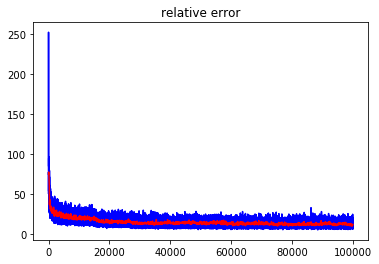

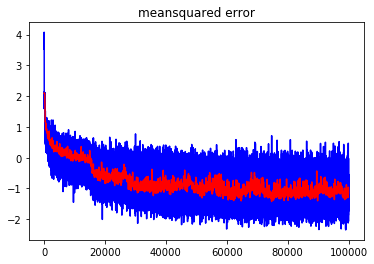

In [6]:
#plot
x1=np.linspace(1,epoch,epoch)
x2=np.linspace(1,epoch,epoch/50)
plt.figure(1)
plt.title('relative error')
plt.plot(x1,error_train,'b')
plt.plot(x2,error_test,'r')
plt.figure(2)
plt.title('meansquared error')
plt.plot(x1,np.log(mse_train),'b')
plt.plot(x2,np.log(mse_test),'r')
plt.show()
    